# DQN Trading System - Main Orchestration Notebook

This notebook orchestrates the complete DQN trading workflow:
1. Data collection and preprocessing (one-time per project)
2. Training for each strategy config
3. Out-of-sample validation comparison across all strategies
4. Final test comparison across all strategies

In [1]:
# Setup and imports
import sys
import os
import json
import glob
import warnings
warnings.filterwarnings('ignore')

# Import modules
from src.utils.config_loader import ConfigLoader
from src.utils.model_manager import ModelManager
from src.utils.progress_logger import ProgressLogger
from src.data.collector import DataCollector
from src.data.splitter import DataSplitter
from src.features.engineer import FeatureEngineer
from src.features.normalizer import RollingNormalizer
from src.trading.environment import TradingEnvironment
from src.training.trainer import DQNTrainer
from src.evaluation.validator import OutOfSampleValidator
from src.evaluation.metrics import PerformanceMetrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display, HTML, clear_output
import time
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")
%matplotlib inline

TensorFlow version: 2.12.0


## 1. Configuration

### Project Folder Structure:
- Each project folder contains:
  - `data_config.json` - Data settings, ticker, dates, validation/test splits
  - `trading_*.json` - One or more trading strategy configs

### Available Projects:
- `dry_run` - Quick test (1 episode, 2 years data)
- `default_run` - Full training (100 episodes, 10 years data)

### Test Mode:
- `test_mode=True` - Skip training if models exist, otherwise assert
- `test_mode=False` - Always perform training

In [2]:
# ========== CONFIGURATION ==========
PROJECT_FOLDER = 'my-project'  # Options: 'dry_run', 'default_run', or custom folder name
TEST_MODE = False  # If True, skip training if models exist (for testing only)
# ===================================

# Build paths
project_path = f'config/{PROJECT_FOLDER}'
data_config_path = f'{project_path}/data_config.json'

# Verify project folder exists
if not os.path.exists(project_path):
    raise ValueError(f"Project folder not found: {project_path}")

if not os.path.exists(data_config_path):
    raise ValueError(f"Data config not found: {data_config_path}")

# Load data config
data_config = ConfigLoader(data_config_path)

# Find all trading config files
trading_configs_paths = glob.glob(f'{project_path}/trading_*.json')
if not trading_configs_paths:
    raise ValueError(f"No trading configs found in {project_path}/")

# Sort for consistent ordering
trading_configs_paths.sort()

# Load all trading configs
trading_configs = []
for path in trading_configs_paths:
    with open(path, 'r') as f:
        tc = json.load(f)
        trading_configs.append({
            'path': path,
            'config': tc,
            'strategy_name': tc.get('strategy_name', tc.get('experiment_name', 'Unnamed')),
            'experiment_name': tc.get('experiment_name', os.path.basename(path).replace('.json', ''))
        })

# Initialize run
ticker = data_config.config['ticker']
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
run_name = f"{PROJECT_FOLDER}_{ticker}_{timestamp}"
logger = ProgressLogger(run_name=run_name, log_dir=f"logs/{PROJECT_FOLDER}")

# Create results directory early for saving plots
results_dir = f"results/{PROJECT_FOLDER}/run_{timestamp}"
os.makedirs(results_dir, exist_ok=True)

print(f"🚀 DQN Trading System")
print(f"{'='*70}")
print(f"📁 Project: {PROJECT_FOLDER}")
print(f"📊 Ticker: {ticker}")
print(f"📅 Date range: {data_config.config['start_date']} to {data_config.config['end_date']}")
print(f"🎯 Strategies: {len(trading_configs)}")
for i, tc in enumerate(trading_configs, 1):
    print(f"   {i}. {tc['strategy_name']} ({tc['experiment_name']})")
print(f"🧪 Test mode: {'ON' if TEST_MODE else 'OFF'}")
print(f"📝 Run name: {run_name}")
print(f"📂 Results will be saved to: {results_dir}")
print(f"{'='*70}")
print(f"\nMonitor this run: python monitor_training.py --run {run_name}")

[2026-01-18 21:52:54] Initialized - Run: my-project_SPY_20260118_215254
🚀 DQN Trading System
📁 Project: my-project
📊 Ticker: SPY
📅 Date range: 2005-01-01 to 2025-12-31
🎯 Strategies: 3
   1. SL/TP 10pct (Stop-Loss-Take-Profit-10pct)
   2. SL/TP 20pct (Stop-Loss-Take-Profit-20pct)
   3. No Guardrails (no_guardrails)
🧪 Test mode: OFF
📝 Run name: my-project_SPY_20260118_215254
📂 Results will be saved to: results/my-project/run_20260118_215254

Monitor this run: python monitor_training.py --run my-project_SPY_20260118_215254


## 2. Data Collection (One-Time)

In [3]:
# Collect data once for all strategies
logger.start_stage("Data Collection", f"Collecting {ticker} and VIX data")

collector = DataCollector(data_config.config)
spy_data, vix_data = collector.collect_data(force_download=False)

info = collector.get_data_info(spy_data, vix_data)
logger.complete_stage("Data Collection", info)

print("✅ Data Collection Summary:")
for key, value in info.items():
    print(f"  {key}: {value}")

[2026-01-18 21:52:54] Starting: Data Collection - Collecting SPY and VIX data
YF.download() has changed argument auto_adjust default to True
  Saved 5456 records to SPY_20040426_20251230.csv
  Saved 5456 records to VIX_20040426_20251230.csv
[2026-01-18 21:52:55] Completed: Data Collection - Duration: 1.2s
✅ Data Collection Summary:
  SPY_records: 5456
  SPY_start: 2004-04-26
  SPY_end: 2025-12-30
  vix_records: 5456
  vix_start: 2004-04-26
  vix_end: 2025-12-30


## 3. Feature Engineering

In [4]:
# Combine data and create features
logger.start_stage("Feature Engineering", f"Creating technical indicators and features")

combined_data = collector.combine_data(spy_data, vix_data)
print(f"Combined data shape: {combined_data.shape}")

engineer = FeatureEngineer(data_config.config)
featured_data = engineer.create_features(combined_data)

feature_columns = engineer.get_feature_names(featured_data)
feature_info = engineer.get_feature_info(featured_data)

metrics = {
    'total_features': len(feature_columns),
    'price_features': len(feature_info['price_features']),
    'technical_indicators': len(feature_info['technical_indicators']),
    'volume_features': len(feature_info['volume_features']),
    'vix_features': len(feature_info['vix_features'])
}

logger.complete_stage("Feature Engineering", metrics)

print(f"\n✅ Total features: {len(feature_columns)}")
print(f"Feature categories:")
for category in ['price_features', 'technical_indicators', 'volume_features', 'vix_features']:
    print(f"  • {category}: {len(feature_info[category])} features")

[2026-01-18 21:52:55] Starting: Feature Engineering - Creating technical indicators and features
Combined data shape: (5456, 6)
Creating technical indicators...
Features created. Dropped 199 rows with NaN values.
Total features: 36
[2026-01-18 21:52:55] Completed: Feature Engineering - Duration: 0.1s

✅ Total features: 25
Feature categories:
  • price_features: 7 features
  • technical_indicators: 14 features
  • volume_features: 3 features
  • vix_features: 1 features


## 4. Data Splitting & Normalization

In [5]:
# Split data FIRST (before normalization to avoid lookahead bias)
logger.start_stage("Data Splitting", "Creating train/validation/test splits")

splitter = DataSplitter(data_config.config)
splits = splitter.split_data(featured_data, verbose=True)

train_data_raw = splits['train']
validation_periods_raw = splits['validation']
test_data_raw = splits['test']

print(f"\n✅ Data split complete (unnormalized):")
print(f"  • Training samples: {len(train_data_raw)}")
print(f"  • Validation periods: {len(validation_periods_raw)}")
print(f"  • Test samples: {len(test_data_raw)}")

# Continuous timeline normalization
print(f"\n📊 Normalizing data (continuous timeline, stateful rolling)...")
logger.start_stage("Data Normalization", "Applying continuous rolling Z-score normalization")

all_data_chronological = pd.concat([
    train_data_raw,
    *validation_periods_raw,
    test_data_raw
]).sort_index()

print(f"  • Chronological timeline: {len(all_data_chronological)} total samples")
print(f"  • Date range: {all_data_chronological.index.min().date()} to {all_data_chronological.index.max().date()}")

normalizer = RollingNormalizer(data_config.config)
all_data_normalized = normalizer.fit_transform(
    all_data_chronological,
    feature_columns,
    preserve_original=True
)

print(f"  ✓ Applied rolling normalization (window={data_config.config['data']['normalization_window']} days)")

# Extract normalized splits
train_data = all_data_normalized.loc[train_data_raw.index]
validation_periods = [
    all_data_normalized.loc[val_period.index]
    for val_period in validation_periods_raw
]
test_data = all_data_normalized.loc[test_data_raw.index]

logger.complete_stage("Data Normalization", {
    'train_shape': train_data.shape,
    'validation_periods': len(validation_periods),
    'test_shape': test_data.shape
})

logger.complete_stage("Data Splitting", {
    'training_samples': len(train_data),
    'validation_periods': len(validation_periods),
    'test_samples': len(test_data)
})

print(f"\n✅ Normalized data shapes:")
print(f"  • Train: {train_data.shape}")
print(f"  • Validation: {len(validation_periods)} periods")
print(f"  • Test: {test_data.shape}")

[2026-01-18 21:52:55] Starting: Data Splitting - Creating train/validation/test splits

DATA SPLIT SUMMARY

Training Data:
  - Records: 3,772
  - Date range: 2006-01-03 to 2024-12-27
  - Duration: 6933 days

Validation Data (5 years):
  Period 1:
    - Records: 227
    - Date range: 2005-02-08 to 2005-12-30
  Period 2:
    - Records: 253
    - Date range: 2008-01-02 to 2008-12-31
  Period 3:
    - Records: 250
    - Date range: 2012-01-03 to 2012-12-31
  Period 4:
    - Records: 252
    - Date range: 2013-01-02 to 2013-12-31
  Period 5:
    - Records: 252
    - Date range: 2021-01-04 to 2021-12-31

Test Data:
  - Records: 251
  - Date range: 2024-12-30 to 2025-12-30
  - Duration: 365 days

Total records: 5,257


✅ Data split complete (unnormalized):
  • Training samples: 3772
  • Validation periods: 5
  • Test samples: 251

📊 Normalizing data (continuous timeline, stateful rolling)...
[2026-01-18 21:52:55] Starting: Data Normalization - Applying continuous rolling Z-score normalization

## 5. Training Loop - All Strategies

Train a model for each trading config in the project folder.

In [6]:
# Storage for all results
all_results = {}
model_manager = ModelManager(base_dir="models")

for idx, tc_info in enumerate(trading_configs, 1):
    strategy_name = tc_info['strategy_name']
    experiment_name = tc_info['experiment_name']

    print(f"\n{'='*70}")
    print(f"📊 Strategy {idx}/{len(trading_configs)}: {strategy_name}")
    print(f"{'='*70}")

    # Merge data config with trading config
    full_config = {**data_config.config, **tc_info['config']}

    # Create training environment
    train_env = TradingEnvironment(
        train_data,
        feature_columns,
        full_config,
        mode='train'
    )

    # Build model identifier (mirroring config structure)
    model_identifier = f"{PROJECT_FOLDER}/{experiment_name}"

    # Initialize trainer
    trainer = DQNTrainer(full_config, model_manager, progress_logger=logger)

    # Check for existing model (for TEST_MODE)
    model_dir = f"models/{model_identifier}"
    existing_models = glob.glob(f"{model_dir}/*.h5") if os.path.exists(model_dir) else []

    # Training logic
    if TEST_MODE:
        if existing_models:
            # Find the latest model
            latest_model = sorted(existing_models)[-1]
            print(f"✅ Test mode: Loading existing model from {latest_model}")
            trainer.agent.model.load_weights(latest_model)
            training_history = {'training_history': []}
            print(f"   Model loaded successfully")
        else:
            raise AssertionError(f"Test mode enabled but no models found in {model_dir}")
    else:
        # Train model
        logger.start_stage(f"Training: {strategy_name}",
                          f"Training for {full_config['training']['episodes']} episodes")

        print(f"Starting training...")
        print(f"📁 Models will be saved to: {model_dir}/")
        print(f"💾 Save frequency: Every {full_config['training']['save_frequency']} episodes")
        print(f"Monitor progress: python monitor_training.py --run {run_name}\n")

        # The trainer will automatically save models based on save_frequency
        training_history = trainer.train(train_env, validation_env=None, verbose=True)

        logger.complete_stage(f"Training: {strategy_name}", {
            'episodes_completed': len(training_history['training_history']),
            'final_return': training_history['training_history'][-1]['return'] if training_history['training_history'] else 0
        })

        print(f"\n✅ Training complete for {strategy_name}")

    # Store results
    all_results[strategy_name] = {
        'experiment_name': experiment_name,
        'trainer': trainer,
        'training_history': training_history,
        'config': full_config,
        'model_identifier': model_identifier
    }

print(f"\n{'='*70}")
print(f"✅ ALL TRAINING COMPLETE - {len(trading_configs)} strategies")
print(f"{'='*70}")


📊 Strategy 1/3: SL/TP 10pct
[2026-01-18 21:52:55] Starting: Training: SL/TP 10pct - Training for 500 episodes
Starting training...
📁 Models will be saved to: models/my-project/Stop-Loss-Take-Profit-10pct/
💾 Save frequency: Every 10 episodes
Monitor progress: python monitor_training.py --run my-project_SPY_20260118_215254



Episode 2/500:   1%|          | 27/3767 [00:00<00:13, 267.84it/s]


Episode 1/500 Summary
Total Reward: 26.04
Total Return: 15.18%
Total Profit: $1652.81
Trades: 2438
Win Rate: 28.42%
Sharpe Ratio: 0.44
Max Drawdown: -7.96%
Epsilon: 0.9950
Avg Loss: 0.256783

[2026-01-18 21:53:11] Training Progress - Episode 1: Return=15.18%, Trades=2438, Win Rate=28.42%


Episode 3/500:   1%|          | 31/3767 [00:00<00:12, 309.48it/s]


Episode 2/500 Summary
Total Reward: 132.66
Total Return: 21.05%
Total Profit: $2238.41
Trades: 2414
Win Rate: 29.62%
Sharpe Ratio: 0.47
Max Drawdown: -6.85%
Epsilon: 0.9900
Avg Loss: 0.489285

[2026-01-18 21:53:24] Training Progress - Episode 2: Return=21.05%, Trades=2414, Win Rate=29.62%


Episode 4/500:   1%|          | 26/3767 [00:00<00:14, 251.61it/s]


Episode 3/500 Summary
Total Reward: 100.75
Total Return: 17.43%
Total Profit: $1879.45
Trades: 2516
Win Rate: 29.05%
Sharpe Ratio: 0.48
Max Drawdown: -7.66%
Epsilon: 0.9851
Avg Loss: 0.473944

[2026-01-18 21:53:38] Training Progress - Episode 3: Return=17.43%, Trades=2516, Win Rate=29.05%


Episode 5/500:   1%|          | 27/3767 [00:00<00:14, 264.86it/s]


Episode 4/500 Summary
Total Reward: 27.17
Total Return: 10.87%
Total Profit: $1281.79
Trades: 2427
Win Rate: 28.88%
Sharpe Ratio: 0.34
Max Drawdown: -7.47%
Epsilon: 0.9801
Avg Loss: 0.492568

[2026-01-18 21:53:52] Training Progress - Episode 4: Return=10.87%, Trades=2427, Win Rate=28.88%


Episode 5/500: 100%|█████████▉| 3766/3767 [00:12<00:00, 293.82it/s]



Episode 5/500 Summary
Total Reward: 6.20
Total Return: 13.08%
Total Profit: $1441.28
Trades: 2444
Win Rate: 27.82%
Sharpe Ratio: 0.28
Max Drawdown: -6.92%
Epsilon: 0.9752
Avg Loss: 0.456160



Episode 6/500:   1%|          | 29/3767 [00:00<00:12, 287.63it/s]

[2026-01-18 21:54:05] Training Progress - Episode 5: Return=13.08%, Trades=2444, Win Rate=27.82%


Episode 7/500:   1%|          | 35/3767 [00:00<00:10, 340.34it/s]


Episode 6/500 Summary
Total Reward: 35.86
Total Return: 12.00%
Total Profit: $1390.30
Trades: 2419
Win Rate: 28.98%
Sharpe Ratio: 0.34
Max Drawdown: -4.83%
Epsilon: 0.9704
Avg Loss: 0.527204

[2026-01-18 21:54:18] Training Progress - Episode 6: Return=12.00%, Trades=2419, Win Rate=28.98%


Episode 8/500:   1%|          | 30/3767 [00:00<00:12, 297.42it/s]


Episode 7/500 Summary
Total Reward: 60.22
Total Return: 15.92%
Total Profit: $1756.85
Trades: 2427
Win Rate: 27.69%
Sharpe Ratio: 0.43
Max Drawdown: -6.78%
Epsilon: 0.9655
Avg Loss: 0.436440

[2026-01-18 21:54:31] Training Progress - Episode 7: Return=15.92%, Trades=2427, Win Rate=27.69%


Episode 9/500:   1%|          | 29/3767 [00:00<00:13, 285.01it/s]


Episode 8/500 Summary
Total Reward: 76.66
Total Return: 24.62%
Total Profit: $2562.70
Trades: 2349
Win Rate: 29.16%
Sharpe Ratio: 0.51
Max Drawdown: -5.66%
Epsilon: 0.9607
Avg Loss: 0.466541

[2026-01-18 21:54:44] Training Progress - Episode 8: Return=24.62%, Trades=2349, Win Rate=29.16%


Episode 10/500:   1%|          | 25/3767 [00:00<00:15, 249.18it/s]


Episode 9/500 Summary
Total Reward: 123.07
Total Return: 18.31%
Total Profit: $1960.31
Trades: 2440
Win Rate: 28.32%
Sharpe Ratio: 0.41
Max Drawdown: -7.58%
Epsilon: 0.9559
Avg Loss: 0.518677

[2026-01-18 21:54:57] Training Progress - Episode 9: Return=18.31%, Trades=2440, Win Rate=28.32%


Episode 11/500:   1%|          | 29/3767 [00:00<00:13, 282.38it/s]


Episode 10/500 Summary
Total Reward: 33.09
Total Return: 7.43%
Total Profit: $912.30
Trades: 2397
Win Rate: 27.49%
Sharpe Ratio: 0.19
Max Drawdown: -7.14%
Epsilon: 0.9511
Avg Loss: 0.522472

[2026-01-18 21:55:12] Training Progress - Episode 10: Return=7.43%, Trades=2397, Win Rate=27.49%


Episode 12/500:   1%|          | 29/3767 [00:00<00:13, 280.33it/s]


Episode 11/500 Summary
Total Reward: -25.07
Total Return: 4.92%
Total Profit: $626.53
Trades: 2476
Win Rate: 28.55%
Sharpe Ratio: 0.15
Max Drawdown: -8.99%
Epsilon: 0.9464
Avg Loss: 0.543316

[2026-01-18 21:55:26] Training Progress - Episode 11: Return=4.92%, Trades=2476, Win Rate=28.55%


Episode 13/500:   1%|          | 32/3767 [00:00<00:11, 314.96it/s]


Episode 12/500 Summary
Total Reward: 16.44
Total Return: 5.58%
Total Profit: $729.65
Trades: 2419
Win Rate: 28.07%
Sharpe Ratio: 0.17
Max Drawdown: -6.93%
Epsilon: 0.9416
Avg Loss: 0.466743

[2026-01-18 21:55:40] Training Progress - Episode 12: Return=5.58%, Trades=2419, Win Rate=28.07%


Episode 14/500:   1%|          | 25/3767 [00:00<00:15, 248.73it/s]


Episode 13/500 Summary
Total Reward: 130.44
Total Return: 18.89%
Total Profit: $1923.52
Trades: 2361
Win Rate: 29.14%
Sharpe Ratio: 0.54
Max Drawdown: -3.17%
Epsilon: 0.9369
Avg Loss: 0.524989

[2026-01-18 21:55:53] Training Progress - Episode 13: Return=18.89%, Trades=2361, Win Rate=29.14%


Episode 15/500:   1%|          | 26/3767 [00:00<00:14, 258.27it/s]


Episode 14/500 Summary
Total Reward: 63.73
Total Return: 14.60%
Total Profit: $1593.14
Trades: 2389
Win Rate: 28.30%
Sharpe Ratio: 0.32
Max Drawdown: -8.14%
Epsilon: 0.9322
Avg Loss: 0.460894

[2026-01-18 21:56:08] Training Progress - Episode 14: Return=14.60%, Trades=2389, Win Rate=28.30%


Episode 16/500:   1%|          | 28/3767 [00:00<00:13, 271.87it/s]


Episode 15/500 Summary
Total Reward: 95.14
Total Return: 10.92%
Total Profit: $1257.73
Trades: 2473
Win Rate: 28.63%
Sharpe Ratio: 0.32
Max Drawdown: -4.94%
Epsilon: 0.9276
Avg Loss: 0.494666

[2026-01-18 21:56:24] Training Progress - Episode 15: Return=10.92%, Trades=2473, Win Rate=28.63%


Episode 17/500:   1%|          | 25/3767 [00:00<00:15, 242.19it/s]


Episode 16/500 Summary
Total Reward: 67.86
Total Return: 23.68%
Total Profit: $2499.73
Trades: 2443
Win Rate: 29.31%
Sharpe Ratio: 0.77
Max Drawdown: -4.24%
Epsilon: 0.9229
Avg Loss: 0.480058

[2026-01-18 21:56:39] Training Progress - Episode 16: Return=23.68%, Trades=2443, Win Rate=29.31%


Episode 18/500:   1%|          | 25/3767 [00:00<00:15, 245.41it/s]


Episode 17/500 Summary
Total Reward: 51.82
Total Return: 10.30%
Total Profit: $1190.25
Trades: 2371
Win Rate: 28.26%
Sharpe Ratio: 0.31
Max Drawdown: -5.29%
Epsilon: 0.9183
Avg Loss: 0.447155

[2026-01-18 21:56:52] Training Progress - Episode 17: Return=10.30%, Trades=2371, Win Rate=28.26%


Episode 19/500:   0%|          | 15/3767 [00:00<00:26, 143.81it/s]


Episode 18/500 Summary
Total Reward: 72.34
Total Return: 20.12%
Total Profit: $2161.14
Trades: 2387
Win Rate: 29.33%
Sharpe Ratio: 0.55
Max Drawdown: -7.25%
Epsilon: 0.9137
Avg Loss: 0.484276

[2026-01-18 21:57:07] Training Progress - Episode 18: Return=20.12%, Trades=2387, Win Rate=29.33%


Episode 20/500:   1%|          | 27/3767 [00:00<00:14, 261.63it/s]


Episode 19/500 Summary
Total Reward: 16.55
Total Return: 18.39%
Total Profit: $1972.73
Trades: 2434
Win Rate: 28.84%
Sharpe Ratio: 0.57
Max Drawdown: -4.54%
Epsilon: 0.9092
Avg Loss: 0.562678

[2026-01-18 21:57:23] Training Progress - Episode 19: Return=18.39%, Trades=2434, Win Rate=28.84%


Episode 21/500:   1%|          | 27/3767 [00:00<00:14, 265.46it/s]


Episode 20/500 Summary
Total Reward: -7.06
Total Return: 1.50%
Total Profit: $333.92
Trades: 2401
Win Rate: 27.53%
Sharpe Ratio: 0.05
Max Drawdown: -8.31%
Epsilon: 0.9046
Avg Loss: 0.536617

[2026-01-18 21:57:36] Training Progress - Episode 20: Return=1.50%, Trades=2401, Win Rate=27.53%


Episode 22/500:   1%|          | 26/3767 [00:00<00:14, 258.39it/s]


Episode 21/500 Summary
Total Reward: 41.46
Total Return: 23.57%
Total Profit: $2559.04
Trades: 2373
Win Rate: 29.54%
Sharpe Ratio: 0.49
Max Drawdown: -4.33%
Epsilon: 0.9001
Avg Loss: 0.499385

[2026-01-18 21:57:50] Training Progress - Episode 21: Return=23.57%, Trades=2373, Win Rate=29.54%


Episode 23/500:   0%|          | 0/3767 [00:00<?, ?it/s]


Episode 22/500 Summary
Total Reward: 19.18
Total Return: 3.22%
Total Profit: $475.06
Trades: 2459
Win Rate: 28.67%
Sharpe Ratio: 0.11
Max Drawdown: -12.58%
Epsilon: 0.8956
Avg Loss: 0.549506

[2026-01-18 21:58:03] Training Progress - Episode 22: Return=3.22%, Trades=2459, Win Rate=28.67%


Episode 24/500:   1%|          | 29/3767 [00:00<00:13, 283.64it/s]


Episode 23/500 Summary
Total Reward: 56.42
Total Return: 16.12%
Total Profit: $1711.64
Trades: 2459
Win Rate: 28.47%
Sharpe Ratio: 0.50
Max Drawdown: -4.97%
Epsilon: 0.8911
Avg Loss: 0.535244

[2026-01-18 21:58:17] Training Progress - Episode 23: Return=16.12%, Trades=2459, Win Rate=28.47%


Episode 25/500:   1%|          | 24/3767 [00:00<00:16, 231.68it/s]


Episode 24/500 Summary
Total Reward: 28.14
Total Return: 11.02%
Total Profit: $1284.57
Trades: 2435
Win Rate: 28.50%
Sharpe Ratio: 0.23
Max Drawdown: -8.43%
Epsilon: 0.8867
Avg Loss: 0.575533

[2026-01-18 21:58:31] Training Progress - Episode 24: Return=11.02%, Trades=2435, Win Rate=28.50%


Episode 26/500:   1%|          | 30/3767 [00:00<00:12, 293.49it/s]


Episode 25/500 Summary
Total Reward: 162.76
Total Return: 26.43%
Total Profit: $2817.36
Trades: 2495
Win Rate: 28.90%
Sharpe Ratio: 0.63
Max Drawdown: -5.45%
Epsilon: 0.8822
Avg Loss: 0.588444

[2026-01-18 21:58:45] Training Progress - Episode 25: Return=26.43%, Trades=2495, Win Rate=28.90%


Episode 27/500:   1%|          | 30/3767 [00:00<00:12, 291.87it/s]


Episode 26/500 Summary
Total Reward: 136.10
Total Return: 21.99%
Total Profit: $2342.33
Trades: 2481
Win Rate: 28.38%
Sharpe Ratio: 0.43
Max Drawdown: -3.63%
Epsilon: 0.8778
Avg Loss: 0.570815

[2026-01-18 21:58:58] Training Progress - Episode 26: Return=21.99%, Trades=2481, Win Rate=28.38%


Episode 28/500:   1%|          | 25/3767 [00:00<00:15, 247.33it/s]


Episode 27/500 Summary
Total Reward: 58.25
Total Return: 9.03%
Total Profit: $1058.94
Trades: 2563
Win Rate: 28.01%
Sharpe Ratio: 0.23
Max Drawdown: -5.21%
Epsilon: 0.8734
Avg Loss: 0.547694

[2026-01-18 21:59:12] Training Progress - Episode 27: Return=9.03%, Trades=2563, Win Rate=28.01%


Episode 28/500: 100%|█████████▉| 3766/3767 [00:13<00:00, 281.56it/s]



Episode 28/500 Summary
Total Reward: 146.93
Total Return: 28.23%
Total Profit: $2982.30
Trades: 2519
Win Rate: 29.10%
Sharpe Ratio: 0.56
Max Drawdown: -7.42%
Epsilon: 0.8691
Avg Loss: 0.567624

[2026-01-18 21:59:25] Training Progress - Episode 28: Return=28.23%, Trades=2519, Win Rate=29.10%


Episode 30/500:   1%|          | 25/3767 [00:00<00:15, 247.34it/s]


Episode 29/500 Summary
Total Reward: 94.56
Total Return: 14.66%
Total Profit: $1601.16
Trades: 2540
Win Rate: 28.54%
Sharpe Ratio: 0.42
Max Drawdown: -4.36%
Epsilon: 0.8647
Avg Loss: 0.505493

[2026-01-18 21:59:40] Training Progress - Episode 29: Return=14.66%, Trades=2540, Win Rate=28.54%


Episode 31/500:   1%|          | 31/3767 [00:00<00:12, 302.42it/s]


Episode 30/500 Summary
Total Reward: 74.50
Total Return: 19.52%
Total Profit: $2112.35
Trades: 2555
Win Rate: 28.53%
Sharpe Ratio: 0.52
Max Drawdown: -5.05%
Epsilon: 0.8604
Avg Loss: 0.583007

[2026-01-18 21:59:53] Training Progress - Episode 30: Return=19.52%, Trades=2555, Win Rate=28.53%


Episode 32/500:   0%|          | 15/3767 [00:00<00:26, 141.51it/s]


Episode 31/500 Summary
Total Reward: 73.85
Total Return: 3.32%
Total Profit: $468.95
Trades: 2593
Win Rate: 27.61%
Sharpe Ratio: 0.10
Max Drawdown: -7.50%
Epsilon: 0.8561
Avg Loss: 0.628469

[2026-01-18 22:00:07] Training Progress - Episode 31: Return=3.32%, Trades=2593, Win Rate=27.61%


Episode 33/500:   1%|          | 27/3767 [00:00<00:13, 269.94it/s]


Episode 32/500 Summary
Total Reward: 50.05
Total Return: 21.04%
Total Profit: $2235.06
Trades: 2560
Win Rate: 29.49%
Sharpe Ratio: 0.70
Max Drawdown: -3.57%
Epsilon: 0.8518
Avg Loss: 0.630871

[2026-01-18 22:00:22] Training Progress - Episode 32: Return=21.04%, Trades=2560, Win Rate=29.49%


Episode 34/500:   1%|          | 26/3767 [00:00<00:14, 253.26it/s]


Episode 33/500 Summary
Total Reward: 27.64
Total Return: 15.55%
Total Profit: $1689.26
Trades: 2518
Win Rate: 28.32%
Sharpe Ratio: 0.48
Max Drawdown: -9.18%
Epsilon: 0.8475
Avg Loss: 0.593899

[2026-01-18 22:00:37] Training Progress - Episode 33: Return=15.55%, Trades=2518, Win Rate=28.32%


Episode 35/500:   1%|          | 21/3767 [00:00<00:18, 203.76it/s]


Episode 34/500 Summary
Total Reward: 49.54
Total Return: 19.42%
Total Profit: $2109.37
Trades: 2461
Win Rate: 28.36%
Sharpe Ratio: 0.42
Max Drawdown: -4.59%
Epsilon: 0.8433
Avg Loss: 0.566598

[2026-01-18 22:05:27] Training Progress - Episode 34: Return=19.42%, Trades=2461, Win Rate=28.36%


Episode 36/500:   1%|          | 21/3767 [00:00<00:17, 208.25it/s]


Episode 35/500 Summary
Total Reward: 115.83
Total Return: 11.85%
Total Profit: $1345.85
Trades: 2453
Win Rate: 28.94%
Sharpe Ratio: 0.32
Max Drawdown: -4.99%
Epsilon: 0.8391
Avg Loss: 0.588801

[2026-01-18 22:05:43] Training Progress - Episode 35: Return=11.85%, Trades=2453, Win Rate=28.94%


Episode 37/500:   1%|          | 22/3767 [00:00<00:17, 214.20it/s]


Episode 36/500 Summary
Total Reward: 3.43
Total Return: 11.95%
Total Profit: $1381.79
Trades: 2635
Win Rate: 28.24%
Sharpe Ratio: 0.25
Max Drawdown: -6.98%
Epsilon: 0.8349
Avg Loss: 0.559972

[2026-01-18 22:06:01] Training Progress - Episode 36: Return=11.95%, Trades=2635, Win Rate=28.24%


Episode 38/500:   1%|          | 32/3767 [00:00<00:11, 314.27it/s]


Episode 37/500 Summary
Total Reward: -14.65
Total Return: -0.69%
Total Profit: $102.13
Trades: 2597
Win Rate: 27.96%
Sharpe Ratio: -0.01
Max Drawdown: -9.90%
Epsilon: 0.8307
Avg Loss: 0.599518

[2026-01-18 22:06:17] Training Progress - Episode 37: Return=-0.69%, Trades=2597, Win Rate=27.96%


Episode 39/500:   1%|          | 26/3767 [00:00<00:14, 258.63it/s]


Episode 38/500 Summary
Total Reward: 68.91
Total Return: 8.22%
Total Profit: $1005.00
Trades: 2651
Win Rate: 28.37%
Sharpe Ratio: 0.28
Max Drawdown: -6.98%
Epsilon: 0.8266
Avg Loss: 0.628843

[2026-01-18 22:06:31] Training Progress - Episode 38: Return=8.22%, Trades=2651, Win Rate=28.37%


Episode 40/500:   1%|          | 26/3767 [00:00<00:14, 259.42it/s]


Episode 39/500 Summary
Total Reward: -25.89
Total Return: 9.82%
Total Profit: $1124.01
Trades: 2622
Win Rate: 28.26%
Sharpe Ratio: 0.31
Max Drawdown: -5.11%
Epsilon: 0.8224
Avg Loss: 0.694173

[2026-01-18 22:06:45] Training Progress - Episode 39: Return=9.82%, Trades=2622, Win Rate=28.26%


Episode 41/500:   1%|          | 25/3767 [00:00<00:15, 246.80it/s]


Episode 40/500 Summary
Total Reward: 61.85
Total Return: 11.27%
Total Profit: $1288.43
Trades: 2647
Win Rate: 28.22%
Sharpe Ratio: 0.34
Max Drawdown: -5.06%
Epsilon: 0.8183
Avg Loss: 0.651940

[2026-01-18 22:06:59] Training Progress - Episode 40: Return=11.27%, Trades=2647, Win Rate=28.22%


Episode 42/500:   1%|          | 29/3767 [00:00<00:13, 280.00it/s]


Episode 41/500 Summary
Total Reward: 108.18
Total Return: 24.50%
Total Profit: $2619.65
Trades: 2593
Win Rate: 28.50%
Sharpe Ratio: 0.57
Max Drawdown: -6.50%
Epsilon: 0.8142
Avg Loss: 0.789476

[2026-01-18 22:07:13] Training Progress - Episode 41: Return=24.50%, Trades=2593, Win Rate=28.50%


Episode 43/500:   0%|          | 13/3767 [00:00<00:29, 127.13it/s]


Episode 42/500 Summary
Total Reward: 24.39
Total Return: 6.94%
Total Profit: $842.82
Trades: 2640
Win Rate: 27.84%
Sharpe Ratio: 0.20
Max Drawdown: -11.07%
Epsilon: 0.8102
Avg Loss: 0.840118

[2026-01-18 22:07:27] Training Progress - Episode 42: Return=6.94%, Trades=2640, Win Rate=27.84%


Episode 44/500:   1%|          | 30/3767 [00:00<00:12, 297.41it/s]


Episode 43/500 Summary
Total Reward: 91.99
Total Return: 19.10%
Total Profit: $2059.06
Trades: 2672
Win Rate: 27.73%
Sharpe Ratio: 0.41
Max Drawdown: -6.79%
Epsilon: 0.8061
Avg Loss: 0.737850

[2026-01-18 22:07:42] Training Progress - Episode 43: Return=19.10%, Trades=2672, Win Rate=27.73%


Episode 45/500:   1%|          | 31/3767 [00:00<00:12, 303.93it/s]


Episode 44/500 Summary
Total Reward: 4.39
Total Return: 5.88%
Total Profit: $728.42
Trades: 2557
Win Rate: 28.35%
Sharpe Ratio: 0.20
Max Drawdown: -9.40%
Epsilon: 0.8021
Avg Loss: 0.674495

[2026-01-18 22:07:56] Training Progress - Episode 44: Return=5.88%, Trades=2557, Win Rate=28.35%


Episode 46/500:   1%|          | 24/3767 [00:00<00:15, 237.46it/s]


Episode 45/500 Summary
Total Reward: -11.95
Total Return: 9.63%
Total Profit: $1142.13
Trades: 2451
Win Rate: 28.60%
Sharpe Ratio: 0.29
Max Drawdown: -9.27%
Epsilon: 0.7981
Avg Loss: 0.741213

[2026-01-18 22:08:11] Training Progress - Episode 45: Return=9.63%, Trades=2451, Win Rate=28.60%


Episode 47/500:   1%|          | 30/3767 [00:00<00:12, 296.07it/s]


Episode 46/500 Summary
Total Reward: 62.04
Total Return: 15.06%
Total Profit: $1650.40
Trades: 2509
Win Rate: 28.26%
Sharpe Ratio: 0.43
Max Drawdown: -6.97%
Epsilon: 0.7941
Avg Loss: 0.617326

[2026-01-18 22:08:25] Training Progress - Episode 46: Return=15.06%, Trades=2509, Win Rate=28.26%


Episode 48/500:   1%|          | 25/3767 [00:00<00:15, 243.99it/s]


Episode 47/500 Summary
Total Reward: 127.91
Total Return: 12.60%
Total Profit: $1399.24
Trades: 2591
Win Rate: 28.79%
Sharpe Ratio: 0.34
Max Drawdown: -8.44%
Epsilon: 0.7901
Avg Loss: 0.698545

[2026-01-18 22:08:40] Training Progress - Episode 47: Return=12.60%, Trades=2591, Win Rate=28.79%


Episode 49/500:   1%|          | 25/3767 [00:00<00:15, 247.16it/s]


Episode 48/500 Summary
Total Reward: 63.36
Total Return: 25.84%
Total Profit: $2795.40
Trades: 2647
Win Rate: 28.64%
Sharpe Ratio: 0.64
Max Drawdown: -4.70%
Epsilon: 0.7862
Avg Loss: 0.637115

[2026-01-18 22:08:54] Training Progress - Episode 48: Return=25.84%, Trades=2647, Win Rate=28.64%


Episode 49/500: 100%|█████████▉| 3766/3767 [00:14<00:00, 260.11it/s]



Episode 49/500 Summary
Total Reward: 33.73
Total Return: 10.00%
Total Profit: $1174.66
Trades: 2435
Win Rate: 28.79%
Sharpe Ratio: 0.29
Max Drawdown: -6.61%
Epsilon: 0.7822
Avg Loss: 0.730566

[2026-01-18 22:09:09] Training Progress - Episode 49: Return=10.00%, Trades=2435, Win Rate=28.79%


Episode 51/500:   1%|          | 24/3767 [00:00<00:15, 238.25it/s]


Episode 50/500 Summary
Total Reward: -52.25
Total Return: -2.27%
Total Profit: $-43.07
Trades: 2735
Win Rate: 27.64%
Sharpe Ratio: -0.05
Max Drawdown: -10.11%
Epsilon: 0.7783
Avg Loss: 0.757805

[2026-01-18 22:24:28] Training Progress - Episode 50: Return=-2.27%, Trades=2735, Win Rate=27.64%


Episode 52/500:   1%|          | 29/3767 [00:00<00:12, 287.70it/s]


Episode 51/500 Summary
Total Reward: 70.68
Total Return: 28.71%
Total Profit: $3037.36
Trades: 2747
Win Rate: 28.69%
Sharpe Ratio: 0.61
Max Drawdown: -5.53%
Epsilon: 0.7744
Avg Loss: 0.633799

[2026-01-18 22:24:43] Training Progress - Episode 51: Return=28.71%, Trades=2747, Win Rate=28.69%


Episode 53/500:   1%|          | 25/3767 [00:00<00:15, 246.68it/s]


Episode 52/500 Summary
Total Reward: 57.72
Total Return: 14.16%
Total Profit: $1593.25
Trades: 2661
Win Rate: 28.56%
Sharpe Ratio: 0.39
Max Drawdown: -5.68%
Epsilon: 0.7705
Avg Loss: 0.746747

[2026-01-18 22:24:58] Training Progress - Episode 52: Return=14.16%, Trades=2661, Win Rate=28.56%


Episode 54/500:   1%|          | 21/3767 [00:00<00:18, 203.09it/s]


Episode 53/500 Summary
Total Reward: 19.99
Total Return: 23.70%
Total Profit: $2522.16
Trades: 2615
Win Rate: 27.92%
Sharpe Ratio: 0.59
Max Drawdown: -5.00%
Epsilon: 0.7667
Avg Loss: 0.736232

[2026-01-18 22:25:12] Training Progress - Episode 53: Return=23.70%, Trades=2615, Win Rate=27.92%


Episode 55/500:   1%|          | 26/3767 [00:00<00:14, 257.67it/s]


Episode 54/500 Summary
Total Reward: 17.02
Total Return: 16.91%
Total Profit: $1829.55
Trades: 2746
Win Rate: 27.82%
Sharpe Ratio: 0.35
Max Drawdown: -6.74%
Epsilon: 0.7629
Avg Loss: 0.805199

[2026-01-18 22:42:24] Training Progress - Episode 54: Return=16.91%, Trades=2746, Win Rate=27.82%


Episode 56/500:   1%|          | 31/3767 [00:00<00:12, 306.32it/s]


Episode 55/500 Summary
Total Reward: 21.17
Total Return: 0.30%
Total Profit: $165.24
Trades: 2724
Win Rate: 27.83%
Sharpe Ratio: 0.02
Max Drawdown: -11.49%
Epsilon: 0.7590
Avg Loss: 0.856276

[2026-01-18 22:42:38] Training Progress - Episode 55: Return=0.30%, Trades=2724, Win Rate=27.83%


Episode 57/500:   1%|          | 31/3767 [00:00<00:12, 304.20it/s]


Episode 56/500 Summary
Total Reward: 53.22
Total Return: 14.61%
Total Profit: $1597.48
Trades: 2526
Win Rate: 27.91%
Sharpe Ratio: 0.29
Max Drawdown: -5.86%
Epsilon: 0.7553
Avg Loss: 0.828959

[2026-01-18 22:42:52] Training Progress - Episode 56: Return=14.61%, Trades=2526, Win Rate=27.91%


Episode 58/500:   1%|          | 31/3767 [00:00<00:12, 306.44it/s]


Episode 57/500 Summary
Total Reward: 19.49
Total Return: 9.54%
Total Profit: $1085.64
Trades: 2510
Win Rate: 28.57%
Sharpe Ratio: 0.31
Max Drawdown: -6.40%
Epsilon: 0.7515
Avg Loss: 0.743808

[2026-01-18 23:00:43] Training Progress - Episode 57: Return=9.54%, Trades=2510, Win Rate=28.57%


Episode 58/500: 100%|█████████▉| 3766/3767 [00:13<00:00, 271.12it/s]



Episode 58/500 Summary
Total Reward: 68.55
Total Return: 13.17%
Total Profit: $1452.04
Trades: 2472
Win Rate: 29.33%
Sharpe Ratio: 0.37
Max Drawdown: -5.52%
Epsilon: 0.7477
Avg Loss: 0.770043

[2026-01-18 23:00:57] Training Progress - Episode 58: Return=13.17%, Trades=2472, Win Rate=29.33%


Episode 60/500:   1%|          | 25/3767 [00:00<00:15, 248.40it/s]


Episode 59/500 Summary
Total Reward: 86.92
Total Return: 10.44%
Total Profit: $1177.86
Trades: 2724
Win Rate: 28.30%
Sharpe Ratio: 0.31
Max Drawdown: -6.48%
Epsilon: 0.7440
Avg Loss: 0.791652

[2026-01-18 23:01:11] Training Progress - Episode 59: Return=10.44%, Trades=2724, Win Rate=28.30%


Episode 61/500:   1%|          | 31/3767 [00:00<00:12, 303.47it/s]


Episode 60/500 Summary
Total Reward: 143.61
Total Return: 29.08%
Total Profit: $3096.64
Trades: 2809
Win Rate: 28.37%
Sharpe Ratio: 0.60
Max Drawdown: -5.54%
Epsilon: 0.7403
Avg Loss: 0.637272

[2026-01-18 23:18:20] Training Progress - Episode 60: Return=29.08%, Trades=2809, Win Rate=28.37%


Episode 62/500:   1%|          | 31/3767 [00:00<00:12, 306.18it/s]


Episode 61/500 Summary
Total Reward: 95.55
Total Return: 17.43%
Total Profit: $1880.84
Trades: 2632
Win Rate: 27.96%
Sharpe Ratio: 0.41
Max Drawdown: -4.20%
Epsilon: 0.7366
Avg Loss: 0.679213

[2026-01-18 23:18:33] Training Progress - Episode 61: Return=17.43%, Trades=2632, Win Rate=27.96%


Episode 63/500:   1%|          | 33/3767 [00:00<00:11, 320.68it/s]


Episode 62/500 Summary
Total Reward: 65.67
Total Return: 19.84%
Total Profit: $2156.93
Trades: 2659
Win Rate: 27.94%
Sharpe Ratio: 0.35
Max Drawdown: -7.26%
Epsilon: 0.7329
Avg Loss: 0.668471

[2026-01-18 23:18:46] Training Progress - Episode 62: Return=19.84%, Trades=2659, Win Rate=27.94%


Episode 64/500:   1%|          | 29/3767 [00:00<00:12, 287.94it/s]


Episode 63/500 Summary
Total Reward: 23.98
Total Return: 9.06%
Total Profit: $1064.36
Trades: 2613
Win Rate: 27.90%
Sharpe Ratio: 0.33
Max Drawdown: -4.27%
Epsilon: 0.7292
Avg Loss: 0.701860

[2026-01-18 23:36:43] Training Progress - Episode 63: Return=9.06%, Trades=2613, Win Rate=27.90%


Episode 65/500:   1%|          | 30/3767 [00:00<00:12, 298.85it/s]


Episode 64/500 Summary
Total Reward: 31.92
Total Return: 11.67%
Total Profit: $1346.11
Trades: 2617
Win Rate: 27.86%
Sharpe Ratio: 0.30
Max Drawdown: -6.47%
Epsilon: 0.7256
Avg Loss: 0.738624

[2026-01-18 23:36:56] Training Progress - Episode 64: Return=11.67%, Trades=2617, Win Rate=27.86%


Episode 66/500:   1%|          | 31/3767 [00:00<00:12, 308.20it/s]


Episode 65/500 Summary
Total Reward: 95.09
Total Return: 24.60%
Total Profit: $2665.98
Trades: 2653
Win Rate: 28.80%
Sharpe Ratio: 0.47
Max Drawdown: -6.05%
Epsilon: 0.7219
Avg Loss: 0.724804

[2026-01-18 23:37:09] Training Progress - Episode 65: Return=24.60%, Trades=2653, Win Rate=28.80%


Episode 67/500:   1%|          | 19/3767 [00:00<00:20, 184.67it/s]


Episode 66/500 Summary
Total Reward: 22.02
Total Return: 9.42%
Total Profit: $1066.11
Trades: 2791
Win Rate: 28.77%
Sharpe Ratio: 0.31
Max Drawdown: -4.36%
Epsilon: 0.7183
Avg Loss: 0.847928

[2026-01-18 23:44:06] Training Progress - Episode 66: Return=9.42%, Trades=2791, Win Rate=28.77%


Episode 68/500:   1%|          | 25/3767 [00:00<00:14, 249.54it/s]


Episode 67/500 Summary
Total Reward: 117.52
Total Return: 14.85%
Total Profit: $1617.57
Trades: 2707
Win Rate: 28.70%
Sharpe Ratio: 0.43
Max Drawdown: -4.76%
Epsilon: 0.7147
Avg Loss: 1.022238

[2026-01-18 23:44:26] Training Progress - Episode 67: Return=14.85%, Trades=2707, Win Rate=28.70%


Episode 69/500:   1%|          | 27/3767 [00:00<00:13, 267.85it/s]


Episode 68/500 Summary
Total Reward: -8.48
Total Return: 10.37%
Total Profit: $1182.70
Trades: 2630
Win Rate: 27.57%
Sharpe Ratio: 0.30
Max Drawdown: -8.26%
Epsilon: 0.7112
Avg Loss: 0.824787

[2026-01-18 23:44:40] Training Progress - Episode 68: Return=10.37%, Trades=2630, Win Rate=27.57%


Episode 70/500:   1%|          | 26/3767 [00:00<00:14, 253.16it/s]


Episode 69/500 Summary
Total Reward: 100.04
Total Return: 11.44%
Total Profit: $1267.92
Trades: 2410
Win Rate: 28.34%
Sharpe Ratio: 0.34
Max Drawdown: -6.16%
Epsilon: 0.7076
Avg Loss: 0.923095

[2026-01-18 23:44:57] Training Progress - Episode 69: Return=11.44%, Trades=2410, Win Rate=28.34%


Episode 71/500:   1%|          | 22/3767 [00:00<00:17, 216.71it/s]


Episode 70/500 Summary
Total Reward: -85.73
Total Return: -1.09%
Total Profit: $20.87
Trades: 2830
Win Rate: 27.53%
Sharpe Ratio: -0.02
Max Drawdown: -10.38%
Epsilon: 0.7041
Avg Loss: 0.796591

[2026-01-18 23:45:17] Training Progress - Episode 70: Return=-1.09%, Trades=2830, Win Rate=27.53%


Episode 72/500:   1%|          | 24/3767 [00:00<00:15, 239.54it/s]


Episode 71/500 Summary
Total Reward: 64.69
Total Return: 19.06%
Total Profit: $2021.35
Trades: 2035
Win Rate: 28.99%
Sharpe Ratio: 0.47
Max Drawdown: -5.37%
Epsilon: 0.7005
Avg Loss: 0.953368

[2026-01-18 23:45:33] Training Progress - Episode 71: Return=19.06%, Trades=2035, Win Rate=28.99%


Episode 73/500:   1%|          | 26/3767 [00:00<00:14, 250.18it/s]


Episode 72/500 Summary
Total Reward: -31.54
Total Return: 15.86%
Total Profit: $1791.17
Trades: 2777
Win Rate: 27.76%
Sharpe Ratio: 0.32
Max Drawdown: -4.28%
Epsilon: 0.6970
Avg Loss: 0.784726

[2026-01-18 23:45:48] Training Progress - Episode 72: Return=15.86%, Trades=2777, Win Rate=27.76%


Episode 74/500:   1%|          | 27/3767 [00:00<00:14, 263.21it/s]


Episode 73/500 Summary
Total Reward: 30.75
Total Return: 19.83%
Total Profit: $2154.71
Trades: 2157
Win Rate: 28.14%
Sharpe Ratio: 0.35
Max Drawdown: -6.85%
Epsilon: 0.6936
Avg Loss: 0.879074

[2026-01-18 23:46:03] Training Progress - Episode 73: Return=19.83%, Trades=2157, Win Rate=28.14%


Episode 75/500:   1%|          | 25/3767 [00:00<00:15, 242.52it/s]


Episode 74/500 Summary
Total Reward: -40.20
Total Return: -3.74%
Total Profit: $-236.16
Trades: 2856
Win Rate: 28.50%
Sharpe Ratio: -0.11
Max Drawdown: -11.05%
Epsilon: 0.6901
Avg Loss: 0.868515

[2026-01-18 23:46:17] Training Progress - Episode 74: Return=-3.74%, Trades=2856, Win Rate=28.50%


Episode 76/500:   1%|          | 25/3767 [00:00<00:15, 244.67it/s]


Episode 75/500 Summary
Total Reward: 146.04
Total Return: 14.53%
Total Profit: $1571.38
Trades: 2668
Win Rate: 28.79%
Sharpe Ratio: 0.39
Max Drawdown: -7.52%
Epsilon: 0.6866
Avg Loss: 0.981702

[2026-01-18 23:46:33] Training Progress - Episode 75: Return=14.53%, Trades=2668, Win Rate=28.79%


Episode 77/500:   1%|          | 24/3767 [00:00<00:16, 226.25it/s]


Episode 76/500 Summary
Total Reward: 130.85
Total Return: 14.81%
Total Profit: $1622.32
Trades: 2747
Win Rate: 28.80%
Sharpe Ratio: 0.45
Max Drawdown: -3.69%
Epsilon: 0.6832
Avg Loss: 1.088988

[2026-01-18 23:46:48] Training Progress - Episode 76: Return=14.81%, Trades=2747, Win Rate=28.80%


Episode 78/500:   1%|          | 28/3767 [00:00<00:13, 269.42it/s]


Episode 77/500 Summary
Total Reward: 97.97
Total Return: 18.82%
Total Profit: $2004.26
Trades: 2475
Win Rate: 28.81%
Sharpe Ratio: 0.55
Max Drawdown: -7.15%
Epsilon: 0.6798
Avg Loss: 0.917314

[2026-01-18 23:47:05] Training Progress - Episode 77: Return=18.82%, Trades=2475, Win Rate=28.81%


Episode 79/500:   1%|          | 29/3767 [00:00<00:13, 284.94it/s]


Episode 78/500 Summary
Total Reward: 17.26
Total Return: 8.50%
Total Profit: $1035.33
Trades: 2827
Win Rate: 28.19%
Sharpe Ratio: 0.26
Max Drawdown: -8.05%
Epsilon: 0.6764
Avg Loss: 0.926761

[2026-01-18 23:47:22] Training Progress - Episode 78: Return=8.50%, Trades=2827, Win Rate=28.19%


Episode 80/500:   1%|          | 27/3767 [00:00<00:13, 268.11it/s]


Episode 79/500 Summary
Total Reward: -4.10
Total Return: 1.51%
Total Profit: $290.73
Trades: 2745
Win Rate: 28.23%
Sharpe Ratio: 0.06
Max Drawdown: -7.75%
Epsilon: 0.6730
Avg Loss: 0.931783

[2026-01-18 23:47:41] Training Progress - Episode 79: Return=1.51%, Trades=2745, Win Rate=28.23%


Episode 81/500:   0%|          | 16/3767 [00:00<00:25, 149.09it/s]


Episode 80/500 Summary
Total Reward: -48.83
Total Return: 9.06%
Total Profit: $1030.34
Trades: 2599
Win Rate: 28.16%
Sharpe Ratio: 0.29
Max Drawdown: -6.19%
Epsilon: 0.6696
Avg Loss: 0.982129

[2026-01-18 23:47:59] Training Progress - Episode 80: Return=9.06%, Trades=2599, Win Rate=28.16%


Episode 82/500:   1%|          | 24/3767 [00:00<00:16, 230.27it/s]


Episode 81/500 Summary
Total Reward: 97.02
Total Return: 27.53%
Total Profit: $2765.56
Trades: 2417
Win Rate: 28.09%
Sharpe Ratio: 0.73
Max Drawdown: -4.18%
Epsilon: 0.6663
Avg Loss: 1.047300

[2026-01-18 23:48:15] Training Progress - Episode 81: Return=27.53%, Trades=2417, Win Rate=28.09%


Episode 83/500:   1%|          | 25/3767 [00:00<00:15, 246.25it/s]


Episode 82/500 Summary
Total Reward: 84.06
Total Return: 21.82%
Total Profit: $2290.04
Trades: 1885
Win Rate: 28.33%
Sharpe Ratio: 0.44
Max Drawdown: -3.83%
Epsilon: 0.6630
Avg Loss: 1.122372

[2026-01-18 23:48:31] Training Progress - Episode 82: Return=21.82%, Trades=1885, Win Rate=28.33%


Episode 84/500:   1%|          | 24/3767 [00:00<00:16, 229.91it/s]


Episode 83/500 Summary
Total Reward: 58.46
Total Return: 11.77%
Total Profit: $1302.87
Trades: 2800
Win Rate: 28.46%
Sharpe Ratio: 0.25
Max Drawdown: -8.04%
Epsilon: 0.6597
Avg Loss: 1.119456

[2026-01-18 23:48:46] Training Progress - Episode 83: Return=11.77%, Trades=2800, Win Rate=28.46%


Episode 85/500:   1%|          | 27/3767 [00:00<00:14, 266.79it/s]


Episode 84/500 Summary
Total Reward: -9.47
Total Return: 3.15%
Total Profit: $482.30
Trades: 2565
Win Rate: 27.95%
Sharpe Ratio: 0.11
Max Drawdown: -7.51%
Epsilon: 0.6564
Avg Loss: 1.141690

[2026-01-18 23:49:00] Training Progress - Episode 84: Return=3.15%, Trades=2565, Win Rate=27.95%


Episode 86/500:   1%|          | 29/3767 [00:00<00:13, 285.14it/s]


Episode 85/500 Summary
Total Reward: 12.47
Total Return: 6.09%
Total Profit: $740.87
Trades: 2737
Win Rate: 27.84%
Sharpe Ratio: 0.20
Max Drawdown: -7.00%
Epsilon: 0.6531
Avg Loss: 1.115587

[2026-01-18 23:49:14] Training Progress - Episode 85: Return=6.09%, Trades=2737, Win Rate=27.84%


Episode 87/500:   1%|          | 27/3767 [00:00<00:14, 260.65it/s]


Episode 86/500 Summary
Total Reward: 71.94
Total Return: 18.08%
Total Profit: $1949.85
Trades: 2763
Win Rate: 27.90%
Sharpe Ratio: 0.49
Max Drawdown: -6.06%
Epsilon: 0.6498
Avg Loss: 0.849012

[2026-01-18 23:49:28] Training Progress - Episode 86: Return=18.08%, Trades=2763, Win Rate=27.90%


Episode 88/500:   1%|          | 26/3767 [00:00<00:14, 253.05it/s]


Episode 87/500 Summary
Total Reward: 43.25
Total Return: 13.14%
Total Profit: $1485.06
Trades: 2701
Win Rate: 27.47%
Sharpe Ratio: 0.36
Max Drawdown: -7.27%
Epsilon: 0.6466
Avg Loss: 0.958306

[2026-01-18 23:49:42] Training Progress - Episode 87: Return=13.14%, Trades=2701, Win Rate=27.47%


Episode 89/500:   1%|          | 25/3767 [00:00<00:15, 244.55it/s]


Episode 88/500 Summary
Total Reward: 130.42
Total Return: 22.07%
Total Profit: $2393.52
Trades: 2745
Win Rate: 29.14%
Sharpe Ratio: 0.74
Max Drawdown: -5.18%
Epsilon: 0.6433
Avg Loss: 0.967310

[2026-01-18 23:49:56] Training Progress - Episode 88: Return=22.07%, Trades=2745, Win Rate=29.14%


Episode 90/500:   1%|          | 27/3767 [00:00<00:13, 268.21it/s]


Episode 89/500 Summary
Total Reward: -43.14
Total Return: -1.30%
Total Profit: $9.76
Trades: 2518
Win Rate: 28.63%
Sharpe Ratio: -0.03
Max Drawdown: -11.96%
Epsilon: 0.6401
Avg Loss: 0.999081

[2026-01-18 23:50:10] Training Progress - Episode 89: Return=-1.30%, Trades=2518, Win Rate=28.63%


Episode 91/500:   1%|          | 27/3767 [00:00<00:14, 264.89it/s]


Episode 90/500 Summary
Total Reward: 75.09
Total Return: 15.27%
Total Profit: $1640.52
Trades: 2668
Win Rate: 28.34%
Sharpe Ratio: 0.44
Max Drawdown: -3.42%
Epsilon: 0.6369
Avg Loss: 0.949645

[2026-01-18 23:50:24] Training Progress - Episode 90: Return=15.27%, Trades=2668, Win Rate=28.34%


Episode 92/500:   1%|          | 26/3767 [00:00<00:14, 255.87it/s]


Episode 91/500 Summary
Total Reward: -25.74
Total Return: 6.36%
Total Profit: $805.44
Trades: 2985
Win Rate: 28.34%
Sharpe Ratio: 0.21
Max Drawdown: -8.86%
Epsilon: 0.6337
Avg Loss: 1.055572

[2026-01-18 23:50:37] Training Progress - Episode 91: Return=6.36%, Trades=2985, Win Rate=28.34%


Episode 93/500:   1%|          | 28/3767 [00:00<00:13, 271.19it/s]


Episode 92/500 Summary
Total Reward: 88.29
Total Return: 21.87%
Total Profit: $2314.22
Trades: 2891
Win Rate: 28.43%
Sharpe Ratio: 0.52
Max Drawdown: -6.56%
Epsilon: 0.6306
Avg Loss: 1.030219

[2026-01-18 23:50:51] Training Progress - Episode 92: Return=21.87%, Trades=2891, Win Rate=28.43%


Episode 94/500:   1%|          | 27/3767 [00:00<00:14, 266.26it/s]


Episode 93/500 Summary
Total Reward: 121.60
Total Return: 18.52%
Total Profit: $1986.87
Trades: 2776
Win Rate: 28.78%
Sharpe Ratio: 0.42
Max Drawdown: -4.20%
Epsilon: 0.6274
Avg Loss: 1.102996

[2026-01-18 23:51:05] Training Progress - Episode 93: Return=18.52%, Trades=2776, Win Rate=28.78%


Episode 95/500:   1%|          | 28/3767 [00:00<00:13, 274.65it/s]


Episode 94/500 Summary
Total Reward: 129.69
Total Return: 18.15%
Total Profit: $1946.38
Trades: 2219
Win Rate: 28.08%
Sharpe Ratio: 0.44
Max Drawdown: -7.77%
Epsilon: 0.6243
Avg Loss: 1.265365

[2026-01-18 23:51:19] Training Progress - Episode 94: Return=18.15%, Trades=2219, Win Rate=28.08%


Episode 96/500:   0%|          | 12/3767 [00:00<00:32, 117.04it/s]


Episode 95/500 Summary
Total Reward: -11.59
Total Return: 4.89%
Total Profit: $620.99
Trades: 2896
Win Rate: 28.35%
Sharpe Ratio: 0.17
Max Drawdown: -7.28%
Epsilon: 0.6211
Avg Loss: 0.962652

[2026-01-18 23:51:33] Training Progress - Episode 95: Return=4.89%, Trades=2896, Win Rate=28.35%


Episode 97/500:   1%|          | 26/3767 [00:00<00:14, 258.84it/s]


Episode 96/500 Summary
Total Reward: 24.09
Total Return: 10.75%
Total Profit: $1211.35
Trades: 2914
Win Rate: 28.28%
Sharpe Ratio: 0.35
Max Drawdown: -7.62%
Epsilon: 0.6180
Avg Loss: 1.134123

[2026-01-18 23:51:48] Training Progress - Episode 96: Return=10.75%, Trades=2914, Win Rate=28.28%


Episode 98/500:   1%|          | 25/3767 [00:00<00:15, 245.22it/s]


Episode 97/500 Summary
Total Reward: 142.21
Total Return: 22.05%
Total Profit: $2390.18
Trades: 3011
Win Rate: 28.46%
Sharpe Ratio: 0.53
Max Drawdown: -6.38%
Epsilon: 0.6149
Avg Loss: 0.982097

[2026-01-18 23:52:02] Training Progress - Episode 97: Return=22.05%, Trades=3011, Win Rate=28.46%


Episode 99/500:   1%|          | 24/3767 [00:00<00:15, 237.77it/s]


Episode 98/500 Summary
Total Reward: 74.37
Total Return: 9.54%
Total Profit: $1120.03
Trades: 2313
Win Rate: 28.27%
Sharpe Ratio: 0.30
Max Drawdown: -6.06%
Epsilon: 0.6119
Avg Loss: 1.078885

[2026-01-18 23:52:16] Training Progress - Episode 98: Return=9.54%, Trades=2313, Win Rate=28.27%


Episode 100/500:   1%|          | 25/3767 [00:00<00:15, 247.49it/s]


Episode 99/500 Summary
Total Reward: 143.92
Total Return: 20.91%
Total Profit: $2246.58
Trades: 2976
Win Rate: 27.96%
Sharpe Ratio: 0.67
Max Drawdown: -4.05%
Epsilon: 0.6088
Avg Loss: 1.133588

[2026-01-18 23:52:29] Training Progress - Episode 99: Return=20.91%, Trades=2976, Win Rate=27.96%


Episode 101/500:   1%|          | 24/3767 [00:00<00:15, 238.15it/s]


Episode 100/500 Summary
Total Reward: 78.38
Total Return: 13.90%
Total Profit: $1554.18
Trades: 2819
Win Rate: 28.84%
Sharpe Ratio: 0.49
Max Drawdown: -3.27%
Epsilon: 0.6058
Avg Loss: 0.979387

[2026-01-18 23:52:43] Training Progress - Episode 100: Return=13.90%, Trades=2819, Win Rate=28.84%


Episode 102/500:   1%|          | 27/3767 [00:00<00:14, 260.33it/s]


Episode 101/500 Summary
Total Reward: 112.39
Total Return: 8.80%
Total Profit: $966.57
Trades: 2913
Win Rate: 27.94%
Sharpe Ratio: 0.22
Max Drawdown: -9.73%
Epsilon: 0.6027
Avg Loss: 0.943706

[2026-01-18 23:52:57] Training Progress - Episode 101: Return=8.80%, Trades=2913, Win Rate=27.94%


Episode 103/500:   1%|          | 26/3767 [00:00<00:14, 253.30it/s]


Episode 102/500 Summary
Total Reward: 42.95
Total Return: 19.72%
Total Profit: $2124.77
Trades: 3013
Win Rate: 27.22%
Sharpe Ratio: 0.43
Max Drawdown: -2.64%
Epsilon: 0.5997
Avg Loss: 1.071738

[2026-01-18 23:53:12] Training Progress - Episode 102: Return=19.72%, Trades=3013, Win Rate=27.22%


Episode 104/500:   1%|          | 27/3767 [00:00<00:13, 269.45it/s]


Episode 103/500 Summary
Total Reward: 129.58
Total Return: 10.44%
Total Profit: $1172.20
Trades: 2816
Win Rate: 28.66%
Sharpe Ratio: 0.31
Max Drawdown: -6.34%
Epsilon: 0.5967
Avg Loss: 1.089585

[2026-01-18 23:53:26] Training Progress - Episode 103: Return=10.44%, Trades=2816, Win Rate=28.66%


Episode 105/500:   1%|          | 27/3767 [00:00<00:14, 265.34it/s]


Episode 104/500 Summary
Total Reward: 8.38
Total Return: 12.85%
Total Profit: $1390.82
Trades: 2216
Win Rate: 27.80%
Sharpe Ratio: 0.50
Max Drawdown: -4.67%
Epsilon: 0.5937
Avg Loss: 1.320863

[2026-01-18 23:53:41] Training Progress - Episode 104: Return=12.85%, Trades=2216, Win Rate=27.80%


Episode 106/500:   1%|          | 26/3767 [00:00<00:14, 259.90it/s]


Episode 105/500 Summary
Total Reward: 83.50
Total Return: 8.83%
Total Profit: $1030.60
Trades: 2855
Win Rate: 28.41%
Sharpe Ratio: 0.32
Max Drawdown: -5.89%
Epsilon: 0.5908
Avg Loss: 1.281034

[2026-01-18 23:53:55] Training Progress - Episode 105: Return=8.83%, Trades=2855, Win Rate=28.41%


Episode 107/500:   1%|          | 24/3767 [00:00<00:15, 237.58it/s]


Episode 106/500 Summary
Total Reward: 42.42
Total Return: 13.27%
Total Profit: $1421.42
Trades: 2533
Win Rate: 28.46%
Sharpe Ratio: 0.29
Max Drawdown: -5.75%
Epsilon: 0.5878
Avg Loss: 1.408120

[2026-01-18 23:54:10] Training Progress - Episode 106: Return=13.27%, Trades=2533, Win Rate=28.46%


Episode 108/500:   1%|          | 24/3767 [00:00<00:16, 233.41it/s]


Episode 107/500 Summary
Total Reward: 7.52
Total Return: 10.08%
Total Profit: $1194.78
Trades: 2901
Win Rate: 28.37%
Sharpe Ratio: 0.27
Max Drawdown: -9.02%
Epsilon: 0.5849
Avg Loss: 1.243749

[2026-01-18 23:54:26] Training Progress - Episode 107: Return=10.08%, Trades=2901, Win Rate=28.37%


Episode 109/500:   1%|          | 24/3767 [00:00<00:15, 234.86it/s]


Episode 108/500 Summary
Total Reward: 41.90
Total Return: 7.93%
Total Profit: $915.15
Trades: 2149
Win Rate: 28.71%
Sharpe Ratio: 0.21
Max Drawdown: -6.33%
Epsilon: 0.5820
Avg Loss: 1.274080

[2026-01-18 23:54:42] Training Progress - Episode 108: Return=7.93%, Trades=2149, Win Rate=28.71%


Episode 110/500:   1%|          | 23/3767 [00:00<00:16, 220.96it/s]


Episode 109/500 Summary
Total Reward: 37.35
Total Return: 12.93%
Total Profit: $1426.51
Trades: 2416
Win Rate: 28.39%
Sharpe Ratio: 0.43
Max Drawdown: -4.69%
Epsilon: 0.5790
Avg Loss: 1.223129

[2026-01-18 23:54:58] Training Progress - Episode 109: Return=12.93%, Trades=2416, Win Rate=28.39%


Episode 111/500:   1%|          | 26/3767 [00:00<00:15, 248.19it/s]


Episode 110/500 Summary
Total Reward: 62.12
Total Return: 12.30%
Total Profit: $1348.83
Trades: 2538
Win Rate: 28.53%
Sharpe Ratio: 0.33
Max Drawdown: -8.06%
Epsilon: 0.5762
Avg Loss: 1.228174

[2026-01-18 23:55:14] Training Progress - Episode 110: Return=12.30%, Trades=2538, Win Rate=28.53%


Episode 112/500:   1%|          | 22/3767 [00:00<00:17, 212.22it/s]


Episode 111/500 Summary
Total Reward: 133.94
Total Return: 16.30%
Total Profit: $1753.40
Trades: 2393
Win Rate: 27.66%
Sharpe Ratio: 0.50
Max Drawdown: -4.42%
Epsilon: 0.5733
Avg Loss: 1.153415

[2026-01-18 23:55:30] Training Progress - Episode 111: Return=16.30%, Trades=2393, Win Rate=27.66%


Episode 113/500:   1%|          | 21/3767 [00:00<00:17, 208.62it/s]


Episode 112/500 Summary
Total Reward: 148.60
Total Return: 16.31%
Total Profit: $1762.59
Trades: 2393
Win Rate: 28.63%
Sharpe Ratio: 0.49
Max Drawdown: -5.23%
Epsilon: 0.5704
Avg Loss: 1.023911

[2026-01-18 23:55:48] Training Progress - Episode 112: Return=16.31%, Trades=2393, Win Rate=28.63%


Episode 114/500:   1%|          | 22/3767 [00:00<00:17, 211.38it/s]


Episode 113/500 Summary
Total Reward: 112.34
Total Return: 15.01%
Total Profit: $1637.41
Trades: 2437
Win Rate: 28.23%
Sharpe Ratio: 0.54
Max Drawdown: -3.15%
Epsilon: 0.5676
Avg Loss: 0.813742

[2026-01-18 23:56:04] Training Progress - Episode 113: Return=15.01%, Trades=2437, Win Rate=28.23%


Episode 115/500:   1%|          | 25/3767 [00:00<00:15, 243.34it/s]


Episode 114/500 Summary
Total Reward: 110.30
Total Return: 8.10%
Total Profit: $919.70
Trades: 2511
Win Rate: 29.27%
Sharpe Ratio: 0.31
Max Drawdown: -4.40%
Epsilon: 0.5647
Avg Loss: 0.845943

[2026-01-18 23:56:20] Training Progress - Episode 114: Return=8.10%, Trades=2511, Win Rate=29.27%


Episode 116/500:   1%|          | 23/3767 [00:00<00:16, 222.46it/s]


Episode 115/500 Summary
Total Reward: 79.54
Total Return: 17.30%
Total Profit: $1848.53
Trades: 2682
Win Rate: 28.26%
Sharpe Ratio: 0.70
Max Drawdown: -4.02%
Epsilon: 0.5619
Avg Loss: 1.068837

[2026-01-18 23:56:36] Training Progress - Episode 115: Return=17.30%, Trades=2682, Win Rate=28.26%


Episode 117/500:   1%|          | 27/3767 [00:00<00:14, 263.55it/s]


Episode 116/500 Summary
Total Reward: -44.31
Total Return: -2.81%
Total Profit: $-168.62
Trades: 2264
Win Rate: 28.53%
Sharpe Ratio: -0.08
Max Drawdown: -13.46%
Epsilon: 0.5591
Avg Loss: 1.176265

[2026-01-18 23:56:51] Training Progress - Episode 116: Return=-2.81%, Trades=2264, Win Rate=28.53%


Episode 118/500:   1%|          | 25/3767 [00:00<00:15, 243.23it/s]


Episode 117/500 Summary
Total Reward: 115.40
Total Return: 16.18%
Total Profit: $1822.70
Trades: 2909
Win Rate: 27.88%
Sharpe Ratio: 0.63
Max Drawdown: -2.22%
Epsilon: 0.5563
Avg Loss: 0.965640

[2026-01-18 23:57:06] Training Progress - Episode 117: Return=16.18%, Trades=2909, Win Rate=27.88%


Episode 119/500:   1%|          | 28/3767 [00:00<00:13, 278.50it/s]


Episode 118/500 Summary
Total Reward: 16.82
Total Return: 8.45%
Total Profit: $956.74
Trades: 2341
Win Rate: 28.24%
Sharpe Ratio: 0.23
Max Drawdown: -10.37%
Epsilon: 0.5535
Avg Loss: 0.817381

[2026-01-18 23:57:21] Training Progress - Episode 118: Return=8.45%, Trades=2341, Win Rate=28.24%


Episode 120/500:   1%|          | 19/3767 [00:00<00:20, 187.26it/s]


Episode 119/500 Summary
Total Reward: 121.60
Total Return: 20.05%
Total Profit: $2139.44
Trades: 2947
Win Rate: 27.79%
Sharpe Ratio: 0.54
Max Drawdown: -3.27%
Epsilon: 0.5507
Avg Loss: 0.905403

[2026-01-18 23:57:36] Training Progress - Episode 119: Return=20.05%, Trades=2947, Win Rate=27.79%


Episode 121/500:   1%|          | 28/3767 [00:00<00:13, 268.58it/s]


Episode 120/500 Summary
Total Reward: 99.10
Total Return: 20.86%
Total Profit: $2237.34
Trades: 2131
Win Rate: 27.64%
Sharpe Ratio: 0.47
Max Drawdown: -3.78%
Epsilon: 0.5480
Avg Loss: 1.164180

[2026-01-18 23:57:51] Training Progress - Episode 120: Return=20.86%, Trades=2131, Win Rate=27.64%


Episode 122/500:   1%|          | 24/3767 [00:00<00:15, 235.59it/s]


Episode 121/500 Summary
Total Reward: 7.19
Total Return: 8.21%
Total Profit: $974.70
Trades: 2231
Win Rate: 28.55%
Sharpe Ratio: 0.26
Max Drawdown: -5.21%
Epsilon: 0.5452
Avg Loss: 1.517704

[2026-01-18 23:58:06] Training Progress - Episode 121: Return=8.21%, Trades=2231, Win Rate=28.55%


Episode 123/500:   1%|          | 25/3767 [00:00<00:15, 247.27it/s]


Episode 122/500 Summary
Total Reward: 126.89
Total Return: 15.50%
Total Profit: $1677.10
Trades: 2820
Win Rate: 28.55%
Sharpe Ratio: 0.52
Max Drawdown: -3.78%
Epsilon: 0.5425
Avg Loss: 1.616130

[2026-01-18 23:58:21] Training Progress - Episode 122: Return=15.50%, Trades=2820, Win Rate=28.55%


Episode 124/500:   1%|          | 25/3767 [00:00<00:15, 243.67it/s]


Episode 123/500 Summary
Total Reward: 75.27
Total Return: 15.48%
Total Profit: $1681.35
Trades: 3003
Win Rate: 28.60%
Sharpe Ratio: 0.39
Max Drawdown: -8.61%
Epsilon: 0.5398
Avg Loss: 1.312462

[2026-01-18 23:58:35] Training Progress - Episode 123: Return=15.48%, Trades=3003, Win Rate=28.60%


Episode 125/500:   1%|          | 27/3767 [00:00<00:14, 263.34it/s]


Episode 124/500 Summary
Total Reward: -50.33
Total Return: 3.31%
Total Profit: $490.85
Trades: 3097
Win Rate: 27.64%
Sharpe Ratio: 0.12
Max Drawdown: -8.75%
Epsilon: 0.5371
Avg Loss: 1.121565

[2026-01-18 23:58:50] Training Progress - Episode 124: Return=3.31%, Trades=3097, Win Rate=27.64%


Episode 126/500:   1%|          | 27/3767 [00:00<00:14, 266.29it/s]


Episode 125/500 Summary
Total Reward: 158.61
Total Return: 26.83%
Total Profit: $2851.32
Trades: 2001
Win Rate: 28.79%
Sharpe Ratio: 0.75
Max Drawdown: -3.56%
Epsilon: 0.5344
Avg Loss: 1.323678

[2026-01-18 23:59:06] Training Progress - Episode 125: Return=26.83%, Trades=2001, Win Rate=28.79%


Episode 127/500:   1%|          | 27/3767 [00:00<00:14, 257.94it/s]


Episode 126/500 Summary
Total Reward: 54.08
Total Return: 3.68%
Total Profit: $508.57
Trades: 2999
Win Rate: 27.84%
Sharpe Ratio: 0.15
Max Drawdown: -7.63%
Epsilon: 0.5318
Avg Loss: 1.310059

[2026-01-18 23:59:20] Training Progress - Episode 126: Return=3.68%, Trades=2999, Win Rate=27.84%


Episode 128/500:   0%|          | 18/3767 [00:00<00:21, 171.53it/s]


Episode 127/500 Summary
Total Reward: 40.84
Total Return: 5.44%
Total Profit: $696.84
Trades: 3103
Win Rate: 27.88%
Sharpe Ratio: 0.14
Max Drawdown: -8.35%
Epsilon: 0.5291
Avg Loss: 1.439877

[2026-01-18 23:59:34] Training Progress - Episode 127: Return=5.44%, Trades=3103, Win Rate=27.88%


Episode 129/500:   1%|          | 27/3767 [00:00<00:14, 263.41it/s]


Episode 128/500 Summary
Total Reward: 51.09
Total Return: 9.86%
Total Profit: $1099.31
Trades: 2721
Win Rate: 28.11%
Sharpe Ratio: 0.24
Max Drawdown: -4.33%
Epsilon: 0.5264
Avg Loss: 1.686858

[2026-01-18 23:59:49] Training Progress - Episode 128: Return=9.86%, Trades=2721, Win Rate=28.11%


Episode 130/500:   1%|          | 26/3767 [00:00<00:15, 248.26it/s]


Episode 129/500 Summary
Total Reward: 67.37
Total Return: 8.03%
Total Profit: $920.45
Trades: 1505
Win Rate: 29.77%
Sharpe Ratio: 0.25
Max Drawdown: -8.41%
Epsilon: 0.5238
Avg Loss: 1.501528

[2026-01-19 00:00:04] Training Progress - Episode 129: Return=8.03%, Trades=1505, Win Rate=29.77%


Episode 131/500:   1%|          | 22/3767 [00:00<00:17, 216.48it/s]


Episode 130/500 Summary
Total Reward: 41.48
Total Return: 12.71%
Total Profit: $1386.73
Trades: 2841
Win Rate: 27.60%
Sharpe Ratio: 0.38
Max Drawdown: -4.27%
Epsilon: 0.5212
Avg Loss: 1.686031

[2026-01-19 00:00:19] Training Progress - Episode 130: Return=12.71%, Trades=2841, Win Rate=27.60%


Episode 132/500:   1%|          | 25/3767 [00:00<00:15, 248.07it/s]


Episode 131/500 Summary
Total Reward: 78.73
Total Return: 7.64%
Total Profit: $886.40
Trades: 3084
Win Rate: 28.21%
Sharpe Ratio: 0.29
Max Drawdown: -7.36%
Epsilon: 0.5186
Avg Loss: 1.609481

[2026-01-19 00:00:34] Training Progress - Episode 131: Return=7.64%, Trades=3084, Win Rate=28.21%


Episode 133/500:   1%|          | 23/3767 [00:00<00:16, 227.21it/s]


Episode 132/500 Summary
Total Reward: 119.97
Total Return: 16.14%
Total Profit: $1678.07
Trades: 2347
Win Rate: 27.87%
Sharpe Ratio: 0.51
Max Drawdown: -2.53%
Epsilon: 0.5160
Avg Loss: 1.254331

[2026-01-19 00:00:49] Training Progress - Episode 132: Return=16.14%, Trades=2347, Win Rate=27.87%


Episode 134/500:   1%|          | 26/3767 [00:00<00:14, 256.05it/s]


Episode 133/500 Summary
Total Reward: 84.42
Total Return: 12.70%
Total Profit: $1393.07
Trades: 2568
Win Rate: 28.23%
Sharpe Ratio: 0.45
Max Drawdown: -4.86%
Epsilon: 0.5134
Avg Loss: 1.314103

[2026-01-19 00:01:04] Training Progress - Episode 133: Return=12.70%, Trades=2568, Win Rate=28.23%


Episode 134/500: 100%|█████████▉| 3766/3767 [00:15<00:00, 243.59it/s]



Episode 134/500 Summary
Total Reward: 52.68
Total Return: -4.04%
Total Profit: $-266.82
Trades: 2871
Win Rate: 27.86%
Sharpe Ratio: -0.16
Max Drawdown: -8.07%
Epsilon: 0.5108
Avg Loss: 1.154150

[2026-01-19 00:01:19] Training Progress - Episode 134: Return=-4.04%, Trades=2871, Win Rate=27.86%


Episode 136/500:   1%|          | 25/3767 [00:00<00:15, 244.40it/s]


Episode 135/500 Summary
Total Reward: 113.14
Total Return: 8.43%
Total Profit: $942.01
Trades: 2067
Win Rate: 28.50%
Sharpe Ratio: 0.34
Max Drawdown: -4.73%
Epsilon: 0.5083
Avg Loss: 1.215169

[2026-01-19 00:01:35] Training Progress - Episode 135: Return=8.43%, Trades=2067, Win Rate=28.50%


Episode 137/500:   1%|          | 25/3767 [00:00<00:15, 241.62it/s]


Episode 136/500 Summary
Total Reward: 33.33
Total Return: 9.92%
Total Profit: $1091.86
Trades: 3146
Win Rate: 27.88%
Sharpe Ratio: 0.31
Max Drawdown: -3.73%
Epsilon: 0.5058
Avg Loss: 1.270059

[2026-01-19 00:01:51] Training Progress - Episode 136: Return=9.92%, Trades=3146, Win Rate=27.88%


Episode 138/500:   1%|          | 27/3767 [00:00<00:14, 266.44it/s]


Episode 137/500 Summary
Total Reward: 126.37
Total Return: 22.70%
Total Profit: $2401.52
Trades: 1831
Win Rate: 29.06%
Sharpe Ratio: 0.43
Max Drawdown: -8.13%
Epsilon: 0.5032
Avg Loss: 1.131874

[2026-01-19 00:02:05] Training Progress - Episode 137: Return=22.70%, Trades=1831, Win Rate=29.06%


Episode 139/500:   1%|          | 26/3767 [00:00<00:14, 259.40it/s]


Episode 138/500 Summary
Total Reward: -17.13
Total Return: 15.78%
Total Profit: $1759.57
Trades: 3045
Win Rate: 28.31%
Sharpe Ratio: 0.58
Max Drawdown: -3.25%
Epsilon: 0.5007
Avg Loss: 1.236972

[2026-01-19 00:02:20] Training Progress - Episode 138: Return=15.78%, Trades=3045, Win Rate=28.31%


Episode 140/500:   1%|          | 27/3767 [00:00<00:14, 267.01it/s]


Episode 139/500 Summary
Total Reward: -12.72
Total Return: -1.63%
Total Profit: $9.74
Trades: 3139
Win Rate: 27.78%
Sharpe Ratio: -0.05
Max Drawdown: -10.24%
Epsilon: 0.4982
Avg Loss: 0.938094

[2026-01-19 00:02:34] Training Progress - Episode 139: Return=-1.63%, Trades=3139, Win Rate=27.78%


Episode 141/500:   1%|          | 24/3767 [00:00<00:15, 238.80it/s]


Episode 140/500 Summary
Total Reward: 90.03
Total Return: 10.84%
Total Profit: $1193.15
Trades: 2832
Win Rate: 27.40%
Sharpe Ratio: 0.30
Max Drawdown: -3.91%
Epsilon: 0.4957
Avg Loss: 1.021841

[2026-01-19 00:02:48] Training Progress - Episode 140: Return=10.84%, Trades=2832, Win Rate=27.40%


Episode 142/500:   1%|          | 26/3767 [00:00<00:14, 259.40it/s]


Episode 141/500 Summary
Total Reward: 42.68
Total Return: 7.76%
Total Profit: $917.53
Trades: 2953
Win Rate: 27.97%
Sharpe Ratio: 0.38
Max Drawdown: -4.24%
Epsilon: 0.4932
Avg Loss: 0.983134

[2026-01-19 00:03:03] Training Progress - Episode 141: Return=7.76%, Trades=2953, Win Rate=27.97%


Episode 143/500:   1%|          | 26/3767 [00:00<00:14, 252.70it/s]


Episode 142/500 Summary
Total Reward: 140.53
Total Return: 7.34%
Total Profit: $816.31
Trades: 1901
Win Rate: 29.56%
Sharpe Ratio: 0.28
Max Drawdown: -5.24%
Epsilon: 0.4908
Avg Loss: 0.905173

[2026-01-19 00:03:17] Training Progress - Episode 142: Return=7.34%, Trades=1901, Win Rate=29.56%


Episode 144/500:   1%|          | 26/3767 [00:00<00:14, 258.74it/s]


Episode 143/500 Summary
Total Reward: -40.24
Total Return: -0.47%
Total Profit: $101.57
Trades: 2599
Win Rate: 27.59%
Sharpe Ratio: -0.01
Max Drawdown: -6.92%
Epsilon: 0.4883
Avg Loss: 0.882790

[2026-01-19 00:03:32] Training Progress - Episode 143: Return=-0.47%, Trades=2599, Win Rate=27.59%


Episode 145/500:   1%|          | 24/3767 [00:00<00:15, 239.10it/s]


Episode 144/500 Summary
Total Reward: 76.21
Total Return: 8.85%
Total Profit: $984.66
Trades: 3038
Win Rate: 27.68%
Sharpe Ratio: 0.36
Max Drawdown: -3.14%
Epsilon: 0.4859
Avg Loss: 0.903977

[2026-01-19 00:03:47] Training Progress - Episode 144: Return=8.85%, Trades=3038, Win Rate=27.68%


Episode 146/500:   1%|          | 25/3767 [00:00<00:15, 245.87it/s]


Episode 145/500 Summary
Total Reward: 62.93
Total Return: 10.97%
Total Profit: $1266.49
Trades: 2537
Win Rate: 28.54%
Sharpe Ratio: 0.36
Max Drawdown: -3.83%
Epsilon: 0.4834
Avg Loss: 0.922311

[2026-01-19 00:04:02] Training Progress - Episode 145: Return=10.97%, Trades=2537, Win Rate=28.54%


Episode 147/500:   1%|          | 23/3767 [00:00<00:16, 228.62it/s]


Episode 146/500 Summary
Total Reward: 1.64
Total Return: 3.69%
Total Profit: $520.46
Trades: 2569
Win Rate: 28.34%
Sharpe Ratio: 0.18
Max Drawdown: -4.50%
Epsilon: 0.4810
Avg Loss: 1.131976

[2026-01-19 00:04:16] Training Progress - Episode 146: Return=3.69%, Trades=2569, Win Rate=28.34%


Episode 148/500:   1%|          | 26/3767 [00:00<00:14, 258.36it/s]


Episode 147/500 Summary
Total Reward: 54.93
Total Return: 10.55%
Total Profit: $1233.07
Trades: 2709
Win Rate: 27.83%
Sharpe Ratio: 0.26
Max Drawdown: -5.67%
Epsilon: 0.4786
Avg Loss: 1.044151

[2026-01-19 00:04:31] Training Progress - Episode 147: Return=10.55%, Trades=2709, Win Rate=27.83%


Episode 149/500:   1%|          | 27/3767 [00:00<00:13, 269.71it/s]


Episode 148/500 Summary
Total Reward: 68.03
Total Return: 12.01%
Total Profit: $1316.93
Trades: 2438
Win Rate: 28.06%
Sharpe Ratio: 0.40
Max Drawdown: -5.97%
Epsilon: 0.4762
Avg Loss: 1.068050

[2026-01-19 00:04:45] Training Progress - Episode 148: Return=12.01%, Trades=2438, Win Rate=28.06%


Episode 150/500:   1%|          | 28/3767 [00:00<00:13, 273.50it/s]


Episode 149/500 Summary
Total Reward: 10.29
Total Return: 8.13%
Total Profit: $916.94
Trades: 2222
Win Rate: 28.08%
Sharpe Ratio: 0.33
Max Drawdown: -4.05%
Epsilon: 0.4738
Avg Loss: 0.955672

[2026-01-19 00:04:59] Training Progress - Episode 149: Return=8.13%, Trades=2222, Win Rate=28.08%


Episode 151/500:   1%|          | 27/3767 [00:00<00:14, 262.61it/s]


Episode 150/500 Summary
Total Reward: 63.99
Total Return: 17.50%
Total Profit: $1842.21
Trades: 1611
Win Rate: 30.11%
Sharpe Ratio: 0.60
Max Drawdown: -3.48%
Epsilon: 0.4715
Avg Loss: 1.209075

[2026-01-19 00:05:14] Training Progress - Episode 150: Return=17.50%, Trades=1611, Win Rate=30.11%


Episode 152/500:   1%|          | 25/3767 [00:00<00:15, 242.67it/s]


Episode 151/500 Summary
Total Reward: 93.82
Total Return: 13.10%
Total Profit: $1467.96
Trades: 2769
Win Rate: 28.24%
Sharpe Ratio: 0.46
Max Drawdown: -5.69%
Epsilon: 0.4691
Avg Loss: 1.050252

[2026-01-19 00:05:29] Training Progress - Episode 151: Return=13.10%, Trades=2769, Win Rate=28.24%


Episode 153/500:   1%|          | 27/3767 [00:00<00:14, 264.93it/s]


Episode 152/500 Summary
Total Reward: 76.20
Total Return: 7.78%
Total Profit: $892.53
Trades: 3185
Win Rate: 28.16%
Sharpe Ratio: 0.20
Max Drawdown: -8.16%
Epsilon: 0.4668
Avg Loss: 1.269238

[2026-01-19 00:05:44] Training Progress - Episode 152: Return=7.78%, Trades=3185, Win Rate=28.16%


Episode 154/500:   1%|          | 28/3767 [00:00<00:13, 272.61it/s]


Episode 153/500 Summary
Total Reward: 88.79
Total Return: 18.59%
Total Profit: $2005.67
Trades: 1881
Win Rate: 29.29%
Sharpe Ratio: 0.43
Max Drawdown: -6.65%
Epsilon: 0.4644
Avg Loss: 1.119376

[2026-01-19 00:05:59] Training Progress - Episode 153: Return=18.59%, Trades=1881, Win Rate=29.29%


Episode 154/500: 100%|█████████▉| 3766/3767 [00:14<00:00, 260.86it/s]



Episode 154/500 Summary
Total Reward: 50.59
Total Return: 3.19%
Total Profit: $451.85
Trades: 2826
Win Rate: 28.27%
Sharpe Ratio: 0.12
Max Drawdown: -6.60%
Epsilon: 0.4621


Episode 155/500:   1%|          | 25/3767 [00:00<00:15, 238.44it/s]

Avg Loss: 1.283196

[2026-01-19 00:06:13] Training Progress - Episode 154: Return=3.19%, Trades=2826, Win Rate=28.27%


Episode 156/500:   1%|          | 25/3767 [00:00<00:14, 249.67it/s]


Episode 155/500 Summary
Total Reward: -20.91
Total Return: 8.28%
Total Profit: $936.02
Trades: 3021
Win Rate: 27.61%
Sharpe Ratio: 0.38
Max Drawdown: -3.75%
Epsilon: 0.4598
Avg Loss: 1.301743

[2026-01-19 00:06:28] Training Progress - Episode 155: Return=8.28%, Trades=3021, Win Rate=27.61%


Episode 157/500:   1%|          | 25/3767 [00:00<00:15, 242.30it/s]


Episode 156/500 Summary
Total Reward: 60.33
Total Return: 14.45%
Total Profit: $1566.41
Trades: 2327
Win Rate: 28.28%
Sharpe Ratio: 0.47
Max Drawdown: -5.48%
Epsilon: 0.4575
Avg Loss: 1.385085

[2026-01-19 00:06:43] Training Progress - Episode 156: Return=14.45%, Trades=2327, Win Rate=28.28%


Episode 158/500:   1%|          | 26/3767 [00:00<00:14, 253.89it/s]


Episode 157/500 Summary
Total Reward: -12.72
Total Return: -2.88%
Total Profit: $-220.59
Trades: 2036
Win Rate: 28.29%
Sharpe Ratio: -0.07
Max Drawdown: -9.17%
Epsilon: 0.4552
Avg Loss: 1.549826

[2026-01-19 00:06:57] Training Progress - Episode 157: Return=-2.88%, Trades=2036, Win Rate=28.29%


Episode 159/500:   1%|          | 27/3767 [00:00<00:13, 268.92it/s]


Episode 158/500 Summary
Total Reward: 107.56
Total Return: 18.26%
Total Profit: $1946.35
Trades: 2695
Win Rate: 28.68%
Sharpe Ratio: 0.75
Max Drawdown: -2.72%
Epsilon: 0.4529
Avg Loss: 1.674863

[2026-01-19 00:07:13] Training Progress - Episode 158: Return=18.26%, Trades=2695, Win Rate=28.68%


Episode 160/500:   1%|          | 28/3767 [00:00<00:13, 270.73it/s]


Episode 159/500 Summary
Total Reward: -19.23
Total Return: 2.18%
Total Profit: $330.48
Trades: 3088
Win Rate: 27.43%
Sharpe Ratio: 0.10
Max Drawdown: -6.90%
Epsilon: 0.4507
Avg Loss: 1.700358

[2026-01-19 00:07:28] Training Progress - Episode 159: Return=2.18%, Trades=3088, Win Rate=27.43%


Episode 161/500:   1%|          | 27/3767 [00:00<00:13, 269.14it/s]


Episode 160/500 Summary
Total Reward: 126.56
Total Return: 16.22%
Total Profit: $1724.21
Trades: 1633
Win Rate: 28.84%
Sharpe Ratio: 0.54
Max Drawdown: -6.59%
Epsilon: 0.4484
Avg Loss: 1.734750

[2026-01-19 00:07:43] Training Progress - Episode 160: Return=16.22%, Trades=1633, Win Rate=28.84%


Episode 162/500:   1%|          | 26/3767 [00:00<00:14, 258.02it/s]


Episode 161/500 Summary
Total Reward: 150.48
Total Return: 12.95%
Total Profit: $1443.12
Trades: 2329
Win Rate: 28.60%
Sharpe Ratio: 0.36
Max Drawdown: -7.57%
Epsilon: 0.4462
Avg Loss: 1.537147

[2026-01-19 00:07:57] Training Progress - Episode 161: Return=12.95%, Trades=2329, Win Rate=28.60%


Episode 163/500:   1%|          | 29/3767 [00:00<00:13, 284.99it/s]


Episode 162/500 Summary
Total Reward: 15.77
Total Return: 6.06%
Total Profit: $718.37
Trades: 2632
Win Rate: 27.58%
Sharpe Ratio: 0.25
Max Drawdown: -5.50%
Epsilon: 0.4440
Avg Loss: 1.079817

[2026-01-19 00:08:12] Training Progress - Episode 162: Return=6.06%, Trades=2632, Win Rate=27.58%


Episode 164/500:   1%|          | 27/3767 [00:00<00:14, 261.45it/s]


Episode 163/500 Summary
Total Reward: 134.61
Total Return: 13.73%
Total Profit: $1457.69
Trades: 2278
Win Rate: 28.71%
Sharpe Ratio: 0.49
Max Drawdown: -3.61%
Epsilon: 0.4417
Avg Loss: 1.098861

[2026-01-19 00:08:27] Training Progress - Episode 163: Return=13.73%, Trades=2278, Win Rate=28.71%


Episode 165/500:   1%|          | 25/3767 [00:00<00:15, 247.00it/s]


Episode 164/500 Summary
Total Reward: 11.70
Total Return: 14.53%
Total Profit: $1632.19
Trades: 2878
Win Rate: 28.14%
Sharpe Ratio: 0.41
Max Drawdown: -4.12%
Epsilon: 0.4395
Avg Loss: 1.239731

[2026-01-19 00:08:42] Training Progress - Episode 164: Return=14.53%, Trades=2878, Win Rate=28.14%


Episode 166/500:   1%|          | 25/3767 [00:00<00:15, 242.15it/s]


Episode 165/500 Summary
Total Reward: 149.17
Total Return: 12.29%
Total Profit: $1339.08
Trades: 2739
Win Rate: 28.77%
Sharpe Ratio: 0.48
Max Drawdown: -5.66%
Epsilon: 0.4373
Avg Loss: 1.344424

[2026-01-19 00:08:56] Training Progress - Episode 165: Return=12.29%, Trades=2739, Win Rate=28.77%


Episode 167/500:   1%|          | 28/3767 [00:00<00:13, 277.53it/s]


Episode 166/500 Summary
Total Reward: 26.02
Total Return: 16.26%
Total Profit: $1776.31
Trades: 2485
Win Rate: 28.65%
Sharpe Ratio: 0.32
Max Drawdown: -7.44%
Epsilon: 0.4351
Avg Loss: 1.222831

[2026-01-19 00:09:11] Training Progress - Episode 166: Return=16.26%, Trades=2485, Win Rate=28.65%


Episode 168/500:   1%|          | 27/3767 [00:00<00:14, 264.83it/s]


Episode 167/500 Summary
Total Reward: 2.03
Total Return: 8.00%
Total Profit: $964.66
Trades: 2539
Win Rate: 27.61%
Sharpe Ratio: 0.22
Max Drawdown: -7.87%
Epsilon: 0.4330
Avg Loss: 1.380421

[2026-01-19 00:09:26] Training Progress - Episode 167: Return=8.00%, Trades=2539, Win Rate=27.61%


Episode 169/500:   1%|          | 24/3767 [00:00<00:16, 231.05it/s]


Episode 168/500 Summary
Total Reward: 41.21
Total Return: 11.54%
Total Profit: $1277.42
Trades: 2200
Win Rate: 28.77%
Sharpe Ratio: 0.30
Max Drawdown: -7.07%
Epsilon: 0.4308
Avg Loss: 1.349956

[2026-01-19 00:09:41] Training Progress - Episode 168: Return=11.54%, Trades=2200, Win Rate=28.77%


Episode 170/500:   1%|          | 25/3767 [00:00<00:15, 246.10it/s]


Episode 169/500 Summary
Total Reward: 23.64
Total Return: 10.00%
Total Profit: $1154.43
Trades: 3257
Win Rate: 27.82%
Sharpe Ratio: 0.39
Max Drawdown: -9.70%
Epsilon: 0.4286
Avg Loss: 1.497392

[2026-01-19 00:09:56] Training Progress - Episode 169: Return=10.00%, Trades=3257, Win Rate=27.82%


Episode 171/500:   1%|          | 28/3767 [00:00<00:13, 277.05it/s]


Episode 170/500 Summary
Total Reward: 146.29
Total Return: 7.91%
Total Profit: $901.05
Trades: 3272
Win Rate: 28.09%
Sharpe Ratio: 0.36
Max Drawdown: -4.62%
Epsilon: 0.4265
Avg Loss: 1.680803

[2026-01-19 00:10:11] Training Progress - Episode 170: Return=7.91%, Trades=3272, Win Rate=28.09%


Episode 172/500:   1%|          | 26/3767 [00:00<00:14, 258.48it/s]


Episode 171/500 Summary
Total Reward: 106.32
Total Return: 19.83%
Total Profit: $2152.90
Trades: 2611
Win Rate: 28.30%
Sharpe Ratio: 0.43
Max Drawdown: -6.76%
Epsilon: 0.4244
Avg Loss: 1.176479

[2026-01-19 00:10:26] Training Progress - Episode 171: Return=19.83%, Trades=2611, Win Rate=28.30%


Episode 173/500:   1%|          | 27/3767 [00:00<00:14, 260.08it/s]


Episode 172/500 Summary
Total Reward: 93.74
Total Return: 24.28%
Total Profit: $2563.40
Trades: 2484
Win Rate: 27.62%
Sharpe Ratio: 0.58
Max Drawdown: -3.53%
Epsilon: 0.4223
Avg Loss: 1.221072

[2026-01-19 00:10:41] Training Progress - Episode 172: Return=24.28%, Trades=2484, Win Rate=27.62%


Episode 174/500:   1%|          | 27/3767 [00:00<00:14, 261.27it/s]


Episode 173/500 Summary
Total Reward: 90.44
Total Return: 31.71%
Total Profit: $3391.48
Trades: 3235
Win Rate: 28.13%
Sharpe Ratio: 0.59
Max Drawdown: -3.46%
Epsilon: 0.4201
Avg Loss: 1.269626

[2026-01-19 00:10:55] Training Progress - Episode 173: Return=31.71%, Trades=3235, Win Rate=28.13%


Episode 175/500:   1%|          | 25/3767 [00:00<00:15, 246.17it/s]


Episode 174/500 Summary
Total Reward: 5.87
Total Return: 3.65%
Total Profit: $533.05
Trades: 2635
Win Rate: 27.55%
Sharpe Ratio: 0.12
Max Drawdown: -8.50%
Epsilon: 0.4180
Avg Loss: 1.171559

[2026-01-19 00:11:10] Training Progress - Episode 174: Return=3.65%, Trades=2635, Win Rate=27.55%


Episode 175/500: 100%|█████████▉| 3766/3767 [00:14<00:00, 253.00it/s]



Episode 175/500 Summary
Total Reward: -29.38
Total Return: -0.02%
Total Profit: $143.20
Trades: 2607
Win Rate: 27.77%
Sharpe Ratio: 0.01
Max Drawdown: -6.66%
Epsilon: 0.4159


Episode 176/500:   1%|          | 24/3767 [00:00<00:15, 237.31it/s]

Avg Loss: 1.118447

[2026-01-19 00:11:26] Training Progress - Episode 175: Return=-0.02%, Trades=2607, Win Rate=27.77%


Episode 177/500:   1%|          | 27/3767 [00:00<00:13, 268.15it/s]


Episode 176/500 Summary
Total Reward: 13.76
Total Return: 9.46%
Total Profit: $1049.22
Trades: 2426
Win Rate: 27.21%
Sharpe Ratio: 0.39
Max Drawdown: -3.66%
Epsilon: 0.4139
Avg Loss: 0.973526

[2026-01-19 00:11:41] Training Progress - Episode 176: Return=9.46%, Trades=2426, Win Rate=27.21%


Episode 178/500:   1%|          | 26/3767 [00:00<00:14, 257.53it/s]


Episode 177/500 Summary
Total Reward: 5.30
Total Return: 6.12%
Total Profit: $746.28
Trades: 3226
Win Rate: 27.59%
Sharpe Ratio: 0.26
Max Drawdown: -8.62%
Epsilon: 0.4118
Avg Loss: 0.952570

[2026-01-19 00:11:56] Training Progress - Episode 177: Return=6.12%, Trades=3226, Win Rate=27.59%


Episode 179/500:   1%|          | 26/3767 [00:00<00:14, 257.43it/s]


Episode 178/500 Summary
Total Reward: 168.11
Total Return: 12.38%
Total Profit: $1352.83
Trades: 3268
Win Rate: 28.61%
Sharpe Ratio: 0.56
Max Drawdown: -2.45%
Epsilon: 0.4097
Avg Loss: 1.043821

[2026-01-19 00:12:11] Training Progress - Episode 178: Return=12.38%, Trades=3268, Win Rate=28.61%


Episode 180/500:   1%|          | 25/3767 [00:00<00:14, 249.91it/s]


Episode 179/500 Summary
Total Reward: 106.28
Total Return: 11.53%
Total Profit: $1245.84
Trades: 3239
Win Rate: 27.85%
Sharpe Ratio: 0.63
Max Drawdown: -3.00%
Epsilon: 0.4077
Avg Loss: 1.570440

[2026-01-19 00:12:26] Training Progress - Episode 179: Return=11.53%, Trades=3239, Win Rate=27.85%


Episode 181/500:   1%|          | 24/3767 [00:00<00:15, 237.30it/s]


Episode 180/500 Summary
Total Reward: 94.76
Total Return: 32.34%
Total Profit: $3372.14
Trades: 3304
Win Rate: 28.12%
Sharpe Ratio: 0.69
Max Drawdown: -2.74%
Epsilon: 0.4057
Avg Loss: 1.914966

[2026-01-19 00:12:41] Training Progress - Episode 180: Return=32.34%, Trades=3304, Win Rate=28.12%


Episode 182/500:   1%|          | 26/3767 [00:00<00:14, 256.24it/s]


Episode 181/500 Summary
Total Reward: 69.47
Total Return: 17.36%
Total Profit: $1915.34
Trades: 3071
Win Rate: 28.10%
Sharpe Ratio: 0.50
Max Drawdown: -3.19%
Epsilon: 0.4036
Avg Loss: 1.676594

[2026-01-19 00:12:56] Training Progress - Episode 181: Return=17.36%, Trades=3071, Win Rate=28.10%


Episode 183/500:   1%|          | 25/3767 [00:00<00:15, 239.17it/s]


Episode 182/500 Summary
Total Reward: 45.41
Total Return: 16.30%
Total Profit: $1735.68
Trades: 2907
Win Rate: 27.76%
Sharpe Ratio: 0.81
Max Drawdown: -4.10%
Epsilon: 0.4016
Avg Loss: 1.363101

[2026-01-19 00:13:11] Training Progress - Episode 182: Return=16.30%, Trades=2907, Win Rate=27.76%


Episode 184/500:   1%|          | 25/3767 [00:00<00:15, 243.56it/s]


Episode 183/500 Summary
Total Reward: 63.36
Total Return: 13.35%
Total Profit: $1481.35
Trades: 2047
Win Rate: 28.53%
Sharpe Ratio: 0.37
Max Drawdown: -5.38%
Epsilon: 0.3996
Avg Loss: 1.906074

[2026-01-19 00:13:26] Training Progress - Episode 183: Return=13.35%, Trades=2047, Win Rate=28.53%


Episode 185/500:   1%|          | 25/3767 [00:00<00:15, 239.85it/s]


Episode 184/500 Summary
Total Reward: -29.99
Total Return: 7.38%
Total Profit: $854.78
Trades: 2068
Win Rate: 27.95%
Sharpe Ratio: 0.17
Max Drawdown: -11.61%
Epsilon: 0.3976
Avg Loss: 1.224753

[2026-01-19 00:13:41] Training Progress - Episode 184: Return=7.38%, Trades=2068, Win Rate=27.95%


Episode 186/500:   1%|          | 25/3767 [00:00<00:14, 249.69it/s]


Episode 185/500 Summary
Total Reward: 78.56
Total Return: 18.21%
Total Profit: $1966.30
Trades: 3134
Win Rate: 28.27%
Sharpe Ratio: 0.69
Max Drawdown: -2.68%
Epsilon: 0.3956
Avg Loss: 1.759761

[2026-01-19 00:13:56] Training Progress - Episode 185: Return=18.21%, Trades=3134, Win Rate=28.27%


Episode 187/500:   1%|          | 24/3767 [00:00<00:15, 237.56it/s]


Episode 186/500 Summary
Total Reward: 101.84
Total Return: 17.67%
Total Profit: $1905.14
Trades: 3301
Win Rate: 28.51%
Sharpe Ratio: 0.60
Max Drawdown: -3.75%
Epsilon: 0.3936
Avg Loss: 2.159168

[2026-01-19 00:14:11] Training Progress - Episode 186: Return=17.67%, Trades=3301, Win Rate=28.51%


Episode 188/500:   1%|          | 26/3767 [00:00<00:14, 254.39it/s]


Episode 187/500 Summary
Total Reward: -23.66
Total Return: 8.99%
Total Profit: $1025.24
Trades: 2880
Win Rate: 26.74%
Sharpe Ratio: 0.33
Max Drawdown: -5.32%
Epsilon: 0.3917
Avg Loss: 1.793303

[2026-01-19 00:14:26] Training Progress - Episode 187: Return=8.99%, Trades=2880, Win Rate=26.74%


Episode 189/500:   1%|          | 25/3767 [00:00<00:15, 245.40it/s]


Episode 188/500 Summary
Total Reward: 85.47
Total Return: 6.68%
Total Profit: $778.72
Trades: 3254
Win Rate: 28.80%
Sharpe Ratio: 0.34
Max Drawdown: -5.43%
Epsilon: 0.3897
Avg Loss: 1.351265

[2026-01-19 00:14:41] Training Progress - Episode 188: Return=6.68%, Trades=3254, Win Rate=28.80%


Episode 190/500:   1%|          | 24/3767 [00:00<00:16, 230.04it/s]


Episode 189/500 Summary
Total Reward: 87.18
Total Return: 11.17%
Total Profit: $1199.72
Trades: 2062
Win Rate: 28.52%
Sharpe Ratio: 0.34
Max Drawdown: -5.05%
Epsilon: 0.3878
Avg Loss: 1.405299

[2026-01-19 00:14:56] Training Progress - Episode 189: Return=11.17%, Trades=2062, Win Rate=28.52%


Episode 191/500:   1%|          | 26/3767 [00:00<00:14, 257.54it/s]


Episode 190/500 Summary
Total Reward: -78.08
Total Return: 0.70%
Total Profit: $207.32
Trades: 1967
Win Rate: 27.05%
Sharpe Ratio: 0.03
Max Drawdown: -8.98%
Epsilon: 0.3858
Avg Loss: 1.739210

[2026-01-19 00:15:12] Training Progress - Episode 190: Return=0.70%, Trades=1967, Win Rate=27.05%


Episode 192/500:   1%|          | 27/3767 [00:00<00:14, 265.40it/s]


Episode 191/500 Summary
Total Reward: 24.41
Total Return: 9.44%
Total Profit: $1051.36
Trades: 2151
Win Rate: 27.80%
Sharpe Ratio: 0.44
Max Drawdown: -3.32%
Epsilon: 0.3839
Avg Loss: 1.453899

[2026-01-19 00:15:27] Training Progress - Episode 191: Return=9.44%, Trades=2151, Win Rate=27.80%


Episode 193/500:   1%|          | 26/3767 [00:00<00:14, 253.93it/s]


Episode 192/500 Summary
Total Reward: 71.81
Total Return: 19.19%
Total Profit: $2061.37
Trades: 2131
Win Rate: 28.06%
Sharpe Ratio: 0.63
Max Drawdown: -3.52%
Epsilon: 0.3820
Avg Loss: 1.068458

[2026-01-19 00:15:43] Training Progress - Episode 192: Return=19.19%, Trades=2131, Win Rate=28.06%


Episode 194/500:   1%|          | 26/3767 [00:00<00:14, 257.73it/s]


Episode 193/500 Summary
Total Reward: 20.94
Total Return: 5.26%
Total Profit: $615.35
Trades: 3322
Win Rate: 27.66%
Sharpe Ratio: 0.31
Max Drawdown: -3.10%
Epsilon: 0.3801
Avg Loss: 1.017484

[2026-01-19 00:15:58] Training Progress - Episode 193: Return=5.26%, Trades=3322, Win Rate=27.66%


Episode 195/500:   1%|          | 26/3767 [00:00<00:14, 251.39it/s]


Episode 194/500 Summary
Total Reward: 105.12
Total Return: 8.83%
Total Profit: $1009.50
Trades: 2921
Win Rate: 29.00%
Sharpe Ratio: 0.42
Max Drawdown: -4.05%
Epsilon: 0.3782
Avg Loss: 1.130593

[2026-01-19 00:16:13] Training Progress - Episode 194: Return=8.83%, Trades=2921, Win Rate=29.00%


Episode 196/500:   1%|          | 26/3767 [00:00<00:14, 258.16it/s]


Episode 195/500 Summary
Total Reward: 7.48
Total Return: 5.36%
Total Profit: $621.25
Trades: 2876
Win Rate: 27.09%
Sharpe Ratio: 0.27
Max Drawdown: -4.62%
Epsilon: 0.3763
Avg Loss: 0.987046

[2026-01-19 00:16:28] Training Progress - Episode 195: Return=5.36%, Trades=2876, Win Rate=27.09%


Episode 197/500:   1%|          | 26/3767 [00:00<00:14, 249.42it/s]


Episode 196/500 Summary
Total Reward: -19.94
Total Return: 4.95%
Total Profit: $545.52
Trades: 2533
Win Rate: 27.36%
Sharpe Ratio: 0.25
Max Drawdown: -4.65%
Epsilon: 0.3744
Avg Loss: 1.114302

[2026-01-19 00:16:43] Training Progress - Episode 196: Return=4.95%, Trades=2533, Win Rate=27.36%


Episode 198/500:   1%|          | 28/3767 [00:00<00:13, 271.09it/s]


Episode 197/500 Summary
Total Reward: 59.03
Total Return: 7.72%
Total Profit: $917.50
Trades: 2175
Win Rate: 28.46%
Sharpe Ratio: 0.24
Max Drawdown: -4.37%
Epsilon: 0.3725
Avg Loss: 0.812489

[2026-01-19 00:16:58] Training Progress - Episode 197: Return=7.72%, Trades=2175, Win Rate=28.46%


Episode 199/500:   1%|          | 26/3767 [00:00<00:14, 251.63it/s]


Episode 198/500 Summary
Total Reward: 36.64
Total Return: 5.57%
Total Profit: $639.54
Trades: 3268
Win Rate: 26.68%
Sharpe Ratio: 0.28
Max Drawdown: -5.65%
Epsilon: 0.3707
Avg Loss: 1.153461

[2026-01-19 00:17:14] Training Progress - Episode 198: Return=5.57%, Trades=3268, Win Rate=26.68%


Episode 200/500:   1%|          | 25/3767 [00:00<00:15, 246.84it/s]


Episode 199/500 Summary
Total Reward: -7.89
Total Return: 4.27%
Total Profit: $558.99
Trades: 2593
Win Rate: 28.00%
Sharpe Ratio: 0.18
Max Drawdown: -3.13%
Epsilon: 0.3688
Avg Loss: 1.242261

[2026-01-19 00:17:29] Training Progress - Episode 199: Return=4.27%, Trades=2593, Win Rate=28.00%


Episode 201/500:   1%|          | 24/3767 [00:00<00:15, 238.92it/s]


Episode 200/500 Summary
Total Reward: -3.70
Total Return: 4.59%
Total Profit: $556.95
Trades: 3199
Win Rate: 27.54%
Sharpe Ratio: 0.24
Max Drawdown: -3.87%
Epsilon: 0.3670
Avg Loss: 1.056997

[2026-01-19 00:17:45] Training Progress - Episode 200: Return=4.59%, Trades=3199, Win Rate=27.54%


Episode 202/500:   1%|          | 26/3767 [00:00<00:15, 245.89it/s]


Episode 201/500 Summary
Total Reward: 15.60
Total Return: 2.41%
Total Profit: $334.61
Trades: 3202
Win Rate: 27.80%
Sharpe Ratio: 0.12
Max Drawdown: -5.99%
Epsilon: 0.3651
Avg Loss: 0.822022

[2026-01-19 00:18:00] Training Progress - Episode 201: Return=2.41%, Trades=3202, Win Rate=27.80%


Episode 203/500:   1%|          | 26/3767 [00:00<00:14, 249.95it/s]


Episode 202/500 Summary
Total Reward: 23.73
Total Return: 14.79%
Total Profit: $1583.82
Trades: 2824
Win Rate: 27.58%
Sharpe Ratio: 0.32
Max Drawdown: -4.09%
Epsilon: 0.3633
Avg Loss: 0.888268

[2026-01-19 00:18:15] Training Progress - Episode 202: Return=14.79%, Trades=2824, Win Rate=27.58%


Episode 204/500:   1%|          | 26/3767 [00:00<00:15, 249.00it/s]


Episode 203/500 Summary
Total Reward: 27.52
Total Return: 9.28%
Total Profit: $1027.03
Trades: 2498
Win Rate: 28.10%
Sharpe Ratio: 0.31
Max Drawdown: -5.43%
Epsilon: 0.3615
Avg Loss: 1.133498

[2026-01-19 00:18:31] Training Progress - Episode 203: Return=9.28%, Trades=2498, Win Rate=28.10%


Episode 205/500:   1%|          | 26/3767 [00:00<00:15, 249.25it/s]


Episode 204/500 Summary
Total Reward: 76.74
Total Return: 11.63%
Total Profit: $1250.55
Trades: 2016
Win Rate: 28.08%
Sharpe Ratio: 0.31
Max Drawdown: -8.71%
Epsilon: 0.3597
Avg Loss: 1.316815

[2026-01-19 00:18:46] Training Progress - Episode 204: Return=11.63%, Trades=2016, Win Rate=28.08%


Episode 206/500:   1%|          | 25/3767 [00:00<00:15, 249.36it/s]


Episode 205/500 Summary
Total Reward: 71.12
Total Return: 6.45%
Total Profit: $769.08
Trades: 2297
Win Rate: 27.21%
Sharpe Ratio: 0.31
Max Drawdown: -6.58%
Epsilon: 0.3579
Avg Loss: 1.478503

[2026-01-19 00:19:01] Training Progress - Episode 205: Return=6.45%, Trades=2297, Win Rate=27.21%


Episode 207/500:   1%|          | 25/3767 [00:00<00:15, 244.44it/s]


Episode 206/500 Summary
Total Reward: 39.91
Total Return: 19.45%
Total Profit: $2048.44
Trades: 2650
Win Rate: 27.28%
Sharpe Ratio: 0.71
Max Drawdown: -1.81%
Epsilon: 0.3561
Avg Loss: 1.608078

[2026-01-19 00:19:17] Training Progress - Episode 206: Return=19.45%, Trades=2650, Win Rate=27.28%


Episode 208/500:   1%|          | 25/3767 [00:00<00:15, 245.77it/s]


Episode 207/500 Summary
Total Reward: 55.82
Total Return: 9.17%
Total Profit: $1030.46
Trades: 3121
Win Rate: 28.68%
Sharpe Ratio: 0.34
Max Drawdown: -7.16%
Epsilon: 0.3543
Avg Loss: 1.255244

[2026-01-19 00:19:32] Training Progress - Episode 207: Return=9.17%, Trades=3121, Win Rate=28.68%


Episode 209/500:   1%|          | 25/3767 [00:00<00:15, 248.71it/s]


Episode 208/500 Summary
Total Reward: 58.38
Total Return: 15.76%
Total Profit: $1771.68
Trades: 2917
Win Rate: 28.66%
Sharpe Ratio: 0.34
Max Drawdown: -8.46%
Epsilon: 0.3525
Avg Loss: 1.153135

[2026-01-19 00:19:48] Training Progress - Episode 208: Return=15.76%, Trades=2917, Win Rate=28.66%


Episode 210/500:   1%|          | 25/3767 [00:00<00:15, 241.37it/s]


Episode 209/500 Summary
Total Reward: 75.74
Total Return: 12.54%
Total Profit: $1385.84
Trades: 3250
Win Rate: 27.85%
Sharpe Ratio: 0.56
Max Drawdown: -4.29%
Epsilon: 0.3508
Avg Loss: 1.226336

[2026-01-19 00:20:03] Training Progress - Episode 209: Return=12.54%, Trades=3250, Win Rate=27.85%


Episode 211/500:   1%|          | 24/3767 [00:00<00:16, 230.17it/s]


Episode 210/500 Summary
Total Reward: 42.78
Total Return: 8.44%
Total Profit: $982.41
Trades: 2666
Win Rate: 27.79%
Sharpe Ratio: 0.20
Max Drawdown: -9.82%
Epsilon: 0.3490
Avg Loss: 1.070298

[2026-01-19 00:20:18] Training Progress - Episode 210: Return=8.44%, Trades=2666, Win Rate=27.79%


Episode 212/500:   1%|          | 26/3767 [00:00<00:14, 253.18it/s]


Episode 211/500 Summary
Total Reward: 109.68
Total Return: 20.93%
Total Profit: $2161.47
Trades: 1316
Win Rate: 29.64%
Sharpe Ratio: 0.45
Max Drawdown: -6.41%
Epsilon: 0.3473
Avg Loss: 1.209570

[2026-01-19 00:20:34] Training Progress - Episode 211: Return=20.93%, Trades=1316, Win Rate=29.64%


Episode 213/500:   1%|          | 28/3767 [00:00<00:13, 277.48it/s]


Episode 212/500 Summary
Total Reward: 18.03
Total Return: 15.29%
Total Profit: $1614.53
Trades: 1748
Win Rate: 28.20%
Sharpe Ratio: 0.66
Max Drawdown: -3.47%
Epsilon: 0.3455
Avg Loss: 1.087759

[2026-01-19 00:20:49] Training Progress - Episode 212: Return=15.29%, Trades=1748, Win Rate=28.20%


Episode 214/500:   1%|          | 24/3767 [00:00<00:16, 230.61it/s]


Episode 213/500 Summary
Total Reward: 83.40
Total Return: 7.57%
Total Profit: $880.36
Trades: 3124
Win Rate: 27.85%
Sharpe Ratio: 0.35
Max Drawdown: -7.26%
Epsilon: 0.3438
Avg Loss: 1.383968

[2026-01-19 00:21:04] Training Progress - Episode 213: Return=7.57%, Trades=3124, Win Rate=27.85%


Episode 215/500:   1%|          | 25/3767 [00:00<00:15, 243.07it/s]


Episode 214/500 Summary
Total Reward: -16.32
Total Return: 3.03%
Total Profit: $423.70
Trades: 2852
Win Rate: 27.91%
Sharpe Ratio: 0.15
Max Drawdown: -4.21%
Epsilon: 0.3421
Avg Loss: 1.040600

[2026-01-19 00:21:20] Training Progress - Episode 214: Return=3.03%, Trades=2852, Win Rate=27.91%


Episode 216/500:   1%|          | 26/3767 [00:00<00:14, 257.86it/s]


Episode 215/500 Summary
Total Reward: 44.15
Total Return: 18.45%
Total Profit: $1949.24
Trades: 2611
Win Rate: 28.46%
Sharpe Ratio: 0.45
Max Drawdown: -11.85%
Epsilon: 0.3404
Avg Loss: 0.942534

[2026-01-19 00:21:35] Training Progress - Episode 215: Return=18.45%, Trades=2611, Win Rate=28.46%


Episode 217/500:   1%|          | 25/3767 [00:00<00:14, 249.73it/s]


Episode 216/500 Summary
Total Reward: -81.75
Total Return: 9.38%
Total Profit: $1099.88
Trades: 2880
Win Rate: 28.02%
Sharpe Ratio: 0.23
Max Drawdown: -4.44%
Epsilon: 0.3387
Avg Loss: 0.844438

[2026-01-19 00:21:51] Training Progress - Episode 216: Return=9.38%, Trades=2880, Win Rate=28.02%


Episode 218/500:   1%|          | 25/3767 [00:00<00:15, 248.67it/s]


Episode 217/500 Summary
Total Reward: 23.06
Total Return: 21.89%
Total Profit: $2177.13
Trades: 2355
Win Rate: 28.03%
Sharpe Ratio: 0.51
Max Drawdown: -3.47%
Epsilon: 0.3370
Avg Loss: 0.934063

[2026-01-19 00:22:07] Training Progress - Episode 217: Return=21.89%, Trades=2355, Win Rate=28.03%


Episode 219/500:   1%|          | 24/3767 [00:00<00:15, 235.07it/s]


Episode 218/500 Summary
Total Reward: 7.19
Total Return: -3.71%
Total Profit: $-224.03
Trades: 2911
Win Rate: 26.83%
Sharpe Ratio: -0.17
Max Drawdown: -9.88%
Epsilon: 0.3353
Avg Loss: 1.040940

[2026-01-19 00:22:22] Training Progress - Episode 218: Return=-3.71%, Trades=2911, Win Rate=26.83%


Episode 220/500:   1%|          | 24/3767 [00:00<00:15, 238.34it/s]


Episode 219/500 Summary
Total Reward: -31.43
Total Return: 1.65%
Total Profit: $261.49
Trades: 3236
Win Rate: 28.00%
Sharpe Ratio: 0.07
Max Drawdown: -8.47%
Epsilon: 0.3336
Avg Loss: 0.837596

[2026-01-19 00:22:37] Training Progress - Episode 219: Return=1.65%, Trades=3236, Win Rate=28.00%


Episode 221/500:   1%|          | 24/3767 [00:00<00:15, 238.14it/s]


Episode 220/500 Summary
Total Reward: 76.84
Total Return: 14.99%
Total Profit: $1601.18
Trades: 3342
Win Rate: 28.43%
Sharpe Ratio: 0.72
Max Drawdown: -3.87%
Epsilon: 0.3320
Avg Loss: 0.837975

[2026-01-19 00:22:53] Training Progress - Episode 220: Return=14.99%, Trades=3342, Win Rate=28.43%


Episode 222/500:   1%|          | 24/3767 [00:00<00:15, 236.08it/s]


Episode 221/500 Summary
Total Reward: 40.15
Total Return: 11.30%
Total Profit: $1315.36
Trades: 3351
Win Rate: 27.78%
Sharpe Ratio: 0.42
Max Drawdown: -4.70%
Epsilon: 0.3303
Avg Loss: 1.112159

[2026-01-19 00:23:08] Training Progress - Episode 221: Return=11.30%, Trades=3351, Win Rate=27.78%


Episode 223/500:   1%|          | 26/3767 [00:00<00:14, 252.94it/s]


Episode 222/500 Summary
Total Reward: 87.10
Total Return: 10.79%
Total Profit: $1206.96
Trades: 3362
Win Rate: 27.54%
Sharpe Ratio: 0.52
Max Drawdown: -2.31%
Epsilon: 0.3286
Avg Loss: 1.353132

[2026-01-19 00:23:24] Training Progress - Episode 222: Return=10.79%, Trades=3362, Win Rate=27.54%


Episode 224/500:   1%|          | 25/3767 [00:00<00:15, 247.40it/s]


Episode 223/500 Summary
Total Reward: 90.83
Total Return: 4.17%
Total Profit: $535.31
Trades: 2895
Win Rate: 28.53%
Sharpe Ratio: 0.18
Max Drawdown: -5.98%
Epsilon: 0.3270
Avg Loss: 1.113347

[2026-01-19 00:23:40] Training Progress - Episode 223: Return=4.17%, Trades=2895, Win Rate=28.53%


Episode 225/500:   1%|          | 24/3767 [00:00<00:15, 237.63it/s]


Episode 224/500 Summary
Total Reward: -20.58
Total Return: 9.63%
Total Profit: $1131.08
Trades: 2698
Win Rate: 27.80%
Sharpe Ratio: 0.30
Max Drawdown: -3.92%
Epsilon: 0.3254
Avg Loss: 1.396140

[2026-01-19 00:23:55] Training Progress - Episode 224: Return=9.63%, Trades=2698, Win Rate=27.80%


Episode 226/500:   1%|          | 23/3767 [00:00<00:16, 227.56it/s]


Episode 225/500 Summary
Total Reward: -9.93
Total Return: 3.09%
Total Profit: $517.60
Trades: 3166
Win Rate: 27.83%
Sharpe Ratio: 0.09
Max Drawdown: -10.45%
Epsilon: 0.3237
Avg Loss: 1.538621

[2026-01-19 00:24:11] Training Progress - Episode 225: Return=3.09%, Trades=3166, Win Rate=27.83%


Episode 227/500:   1%|          | 21/3767 [00:00<00:18, 201.91it/s]


Episode 226/500 Summary
Total Reward: -19.28
Total Return: 6.91%
Total Profit: $834.61
Trades: 2869
Win Rate: 27.71%
Sharpe Ratio: 0.19
Max Drawdown: -6.62%
Epsilon: 0.3221
Avg Loss: 1.416659

[2026-01-19 00:24:26] Training Progress - Episode 226: Return=6.91%, Trades=2869, Win Rate=27.71%


Episode 228/500:   1%|          | 25/3767 [00:00<00:15, 243.26it/s]


Episode 227/500 Summary
Total Reward: 83.50
Total Return: 15.11%
Total Profit: $1597.82
Trades: 1880
Win Rate: 28.51%
Sharpe Ratio: 0.36
Max Drawdown: -3.48%
Epsilon: 0.3205
Avg Loss: 1.453837

[2026-01-19 00:24:42] Training Progress - Episode 227: Return=15.11%, Trades=1880, Win Rate=28.51%


Episode 229/500:   1%|          | 24/3767 [00:00<00:15, 234.85it/s]


Episode 228/500 Summary
Total Reward: 61.30
Total Return: 12.18%
Total Profit: $1297.50
Trades: 1654
Win Rate: 28.96%
Sharpe Ratio: 0.35
Max Drawdown: -7.23%
Epsilon: 0.3189
Avg Loss: 1.339990

[2026-01-19 00:24:57] Training Progress - Episode 228: Return=12.18%, Trades=1654, Win Rate=28.96%


Episode 230/500:   1%|          | 26/3767 [00:00<00:14, 259.12it/s]


Episode 229/500 Summary
Total Reward: 44.39
Total Return: 11.67%
Total Profit: $1268.09
Trades: 2437
Win Rate: 28.19%
Sharpe Ratio: 0.59
Max Drawdown: -3.32%
Epsilon: 0.3173
Avg Loss: 1.077735

[2026-01-19 00:25:13] Training Progress - Episode 229: Return=11.67%, Trades=2437, Win Rate=28.19%


Episode 231/500:   1%|          | 24/3767 [00:00<00:16, 233.80it/s]


Episode 230/500 Summary
Total Reward: -11.90
Total Return: 1.78%
Total Profit: $320.27
Trades: 3052
Win Rate: 28.28%
Sharpe Ratio: 0.08
Max Drawdown: -6.06%
Epsilon: 0.3157
Avg Loss: 0.794111

[2026-01-19 00:25:28] Training Progress - Episode 230: Return=1.78%, Trades=3052, Win Rate=28.28%


Episode 232/500:   1%|          | 24/3767 [00:00<00:16, 230.05it/s]


Episode 231/500 Summary
Total Reward: 89.09
Total Return: 21.26%
Total Profit: $2319.38
Trades: 2149
Win Rate: 27.55%
Sharpe Ratio: 0.49
Max Drawdown: -9.01%
Epsilon: 0.3141
Avg Loss: 0.717259

[2026-01-19 00:25:44] Training Progress - Episode 231: Return=21.26%, Trades=2149, Win Rate=27.55%


Episode 233/500:   1%|          | 24/3767 [00:00<00:15, 239.74it/s]


Episode 232/500 Summary
Total Reward: 26.08
Total Return: 9.92%
Total Profit: $1143.90
Trades: 2201
Win Rate: 27.21%
Sharpe Ratio: 0.26
Max Drawdown: -6.89%
Epsilon: 0.3126
Avg Loss: 0.914901

[2026-01-19 00:26:00] Training Progress - Episode 232: Return=9.92%, Trades=2201, Win Rate=27.21%


Episode 234/500:   1%|          | 25/3767 [00:00<00:15, 244.65it/s]


Episode 233/500 Summary
Total Reward: 2.79
Total Return: 3.22%
Total Profit: $420.57
Trades: 2118
Win Rate: 28.28%
Sharpe Ratio: 0.15
Max Drawdown: -5.93%
Epsilon: 0.3110
Avg Loss: 1.167235

[2026-01-19 00:26:15] Training Progress - Episode 233: Return=3.22%, Trades=2118, Win Rate=28.28%


Episode 235/500:   1%|          | 28/3767 [00:00<00:13, 272.98it/s]


Episode 234/500 Summary
Total Reward: 3.30
Total Return: 2.25%
Total Profit: $358.92
Trades: 3293
Win Rate: 27.18%
Sharpe Ratio: 0.11
Max Drawdown: -3.94%
Epsilon: 0.3095
Avg Loss: 1.133205

[2026-01-19 00:26:31] Training Progress - Episode 234: Return=2.25%, Trades=3293, Win Rate=27.18%


Episode 236/500:   1%|          | 25/3767 [00:00<00:15, 242.25it/s]


Episode 235/500 Summary
Total Reward: 41.59
Total Return: 10.32%
Total Profit: $1133.77
Trades: 2988
Win Rate: 28.25%
Sharpe Ratio: 0.48
Max Drawdown: -3.46%
Epsilon: 0.3079
Avg Loss: 0.861631

[2026-01-19 00:26:46] Training Progress - Episode 235: Return=10.32%, Trades=2988, Win Rate=28.25%


Episode 237/500:   1%|          | 25/3767 [00:00<00:15, 246.21it/s]


Episode 236/500 Summary
Total Reward: 42.43
Total Return: 16.44%
Total Profit: $1774.61
Trades: 2770
Win Rate: 27.94%
Sharpe Ratio: 0.35
Max Drawdown: -8.17%
Epsilon: 0.3064
Avg Loss: 1.003175

[2026-01-19 00:27:02] Training Progress - Episode 236: Return=16.44%, Trades=2770, Win Rate=27.94%


Episode 238/500:   1%|          | 25/3767 [00:00<00:15, 245.99it/s]


Episode 237/500 Summary
Total Reward: 76.99
Total Return: 12.91%
Total Profit: $1389.97
Trades: 2378
Win Rate: 28.30%
Sharpe Ratio: 0.56
Max Drawdown: -3.20%
Epsilon: 0.3048
Avg Loss: 0.824522

[2026-01-19 00:27:18] Training Progress - Episode 237: Return=12.91%, Trades=2378, Win Rate=28.30%


Episode 239/500:   1%|          | 26/3767 [00:00<00:15, 248.47it/s]


Episode 238/500 Summary
Total Reward: 50.54
Total Return: 2.34%
Total Profit: $364.51
Trades: 3288
Win Rate: 28.13%
Sharpe Ratio: 0.08
Max Drawdown: -12.03%
Epsilon: 0.3033
Avg Loss: 0.892662

[2026-01-19 00:27:33] Training Progress - Episode 238: Return=2.34%, Trades=3288, Win Rate=28.13%


Episode 240/500:   1%|          | 26/3767 [00:00<00:14, 256.82it/s]


Episode 239/500 Summary
Total Reward: -17.75
Total Return: 4.79%
Total Profit: $622.88
Trades: 3357
Win Rate: 27.29%
Sharpe Ratio: 0.24
Max Drawdown: -4.59%
Epsilon: 0.3018
Avg Loss: 0.921352

[2026-01-19 00:27:50] Training Progress - Episode 239: Return=4.79%, Trades=3357, Win Rate=27.29%


Episode 241/500:   1%|          | 24/3767 [00:00<00:15, 238.55it/s]


Episode 240/500 Summary
Total Reward: 60.41
Total Return: 18.25%
Total Profit: $1923.47
Trades: 2494
Win Rate: 28.75%
Sharpe Ratio: 0.75
Max Drawdown: -2.27%
Epsilon: 0.3003
Avg Loss: 1.007323

[2026-01-19 00:28:06] Training Progress - Episode 240: Return=18.25%, Trades=2494, Win Rate=28.75%


Episode 242/500:   1%|          | 24/3767 [00:00<00:16, 231.44it/s]


Episode 241/500 Summary
Total Reward: 37.01
Total Return: 16.66%
Total Profit: $1786.65
Trades: 2206
Win Rate: 27.92%
Sharpe Ratio: 0.55
Max Drawdown: -4.94%
Epsilon: 0.2988
Avg Loss: 1.206779

[2026-01-19 00:28:22] Training Progress - Episode 241: Return=16.66%, Trades=2206, Win Rate=27.92%


Episode 243/500:   1%|          | 26/3767 [00:00<00:14, 258.90it/s]


Episode 242/500 Summary
Total Reward: 3.47
Total Return: 7.78%
Total Profit: $891.12
Trades: 1921
Win Rate: 26.91%
Sharpe Ratio: 0.38
Max Drawdown: -1.74%
Epsilon: 0.2973
Avg Loss: 1.020639

[2026-01-19 00:28:37] Training Progress - Episode 242: Return=7.78%, Trades=1921, Win Rate=26.91%


Episode 244/500:   1%|          | 25/3767 [00:00<00:15, 240.84it/s]


Episode 243/500 Summary
Total Reward: 60.55
Total Return: 7.60%
Total Profit: $857.46
Trades: 3415
Win Rate: 27.82%
Sharpe Ratio: 0.41
Max Drawdown: -3.74%
Epsilon: 0.2958
Avg Loss: 0.795719

[2026-01-19 00:28:53] Training Progress - Episode 243: Return=7.60%, Trades=3415, Win Rate=27.82%


Episode 245/500:   1%|          | 26/3767 [00:00<00:14, 251.34it/s]


Episode 244/500 Summary
Total Reward: 50.38
Total Return: 14.21%
Total Profit: $1589.53
Trades: 3419
Win Rate: 28.34%
Sharpe Ratio: 0.48
Max Drawdown: -5.87%
Epsilon: 0.2943
Avg Loss: 1.316113

[2026-01-19 00:29:08] Training Progress - Episode 244: Return=14.21%, Trades=3419, Win Rate=28.34%


Episode 246/500:   1%|          | 24/3767 [00:00<00:15, 238.55it/s]


Episode 245/500 Summary
Total Reward: 54.29
Total Return: 4.15%
Total Profit: $581.78
Trades: 3095
Win Rate: 27.40%
Sharpe Ratio: 0.23
Max Drawdown: -4.44%
Epsilon: 0.2929
Avg Loss: 1.399249

[2026-01-19 00:29:24] Training Progress - Episode 245: Return=4.15%, Trades=3095, Win Rate=27.40%


Episode 247/500:   1%|          | 27/3767 [00:00<00:14, 264.89it/s]


Episode 246/500 Summary
Total Reward: 72.08
Total Return: 5.75%
Total Profit: $677.33
Trades: 3087
Win Rate: 27.66%
Sharpe Ratio: 0.30
Max Drawdown: -2.84%
Epsilon: 0.2914
Avg Loss: 1.430059

[2026-01-19 00:29:40] Training Progress - Episode 246: Return=5.75%, Trades=3087, Win Rate=27.66%


Episode 248/500:   1%|          | 26/3767 [00:00<00:14, 250.12it/s]


Episode 247/500 Summary
Total Reward: 80.75
Total Return: 4.41%
Total Profit: $535.32
Trades: 2046
Win Rate: 28.15%
Sharpe Ratio: 0.22
Max Drawdown: -5.56%
Epsilon: 0.2899
Avg Loss: 1.288488

[2026-01-19 00:29:56] Training Progress - Episode 247: Return=4.41%, Trades=2046, Win Rate=28.15%


Episode 249/500:   1%|          | 25/3767 [00:00<00:15, 243.91it/s]


Episode 248/500 Summary
Total Reward: 127.36
Total Return: 8.41%
Total Profit: $977.51
Trades: 3217
Win Rate: 28.35%
Sharpe Ratio: 0.33
Max Drawdown: -3.45%
Epsilon: 0.2885
Avg Loss: 1.541830

[2026-01-19 00:30:11] Training Progress - Episode 248: Return=8.41%, Trades=3217, Win Rate=28.35%


Episode 250/500:   1%|          | 25/3767 [00:00<00:15, 246.41it/s]


Episode 249/500 Summary
Total Reward: -39.61
Total Return: 2.15%
Total Profit: $337.15
Trades: 2557
Win Rate: 27.49%
Sharpe Ratio: 0.10
Max Drawdown: -5.64%
Epsilon: 0.2870
Avg Loss: 1.499106

[2026-01-19 00:30:27] Training Progress - Episode 249: Return=2.15%, Trades=2557, Win Rate=27.49%


Episode 251/500:   1%|          | 24/3767 [00:00<00:15, 237.86it/s]


Episode 250/500 Summary
Total Reward: 84.32
Total Return: 14.49%
Total Profit: $1578.30
Trades: 3425
Win Rate: 28.26%
Sharpe Ratio: 0.48
Max Drawdown: -5.15%
Epsilon: 0.2856
Avg Loss: 1.332086

[2026-01-19 00:30:43] Training Progress - Episode 250: Return=14.49%, Trades=3425, Win Rate=28.26%


Episode 252/500:   1%|          | 24/3767 [00:00<00:15, 235.55it/s]


Episode 251/500 Summary
Total Reward: 60.52
Total Return: 11.64%
Total Profit: $1279.75
Trades: 3394
Win Rate: 28.70%
Sharpe Ratio: 0.58
Max Drawdown: -3.24%
Epsilon: 0.2842
Avg Loss: 1.228351

[2026-01-19 00:30:59] Training Progress - Episode 251: Return=11.64%, Trades=3394, Win Rate=28.70%


Episode 253/500:   1%|          | 25/3767 [00:00<00:15, 247.22it/s]


Episode 252/500 Summary
Total Reward: 21.13
Total Return: 3.86%
Total Profit: $516.67
Trades: 3361
Win Rate: 27.73%
Sharpe Ratio: 0.19
Max Drawdown: -4.98%
Epsilon: 0.2828
Avg Loss: 1.052177

[2026-01-19 00:31:15] Training Progress - Episode 252: Return=3.86%, Trades=3361, Win Rate=27.73%


Episode 254/500:   1%|          | 23/3767 [00:00<00:16, 223.19it/s]


Episode 253/500 Summary
Total Reward: 40.26
Total Return: 7.29%
Total Profit: $836.23
Trades: 2608
Win Rate: 26.99%
Sharpe Ratio: 0.35
Max Drawdown: -3.67%
Epsilon: 0.2813
Avg Loss: 0.929827

[2026-01-19 00:31:30] Training Progress - Episode 253: Return=7.29%, Trades=2608, Win Rate=26.99%


Episode 255/500:   1%|          | 25/3767 [00:00<00:15, 244.39it/s]


Episode 254/500 Summary
Total Reward: 46.20
Total Return: 1.70%
Total Profit: $351.91
Trades: 3363
Win Rate: 27.42%
Sharpe Ratio: 0.08
Max Drawdown: -5.94%
Epsilon: 0.2799
Avg Loss: 1.120666

[2026-01-19 00:31:47] Training Progress - Episode 254: Return=1.70%, Trades=3363, Win Rate=27.42%


Episode 256/500:   1%|          | 27/3767 [00:00<00:13, 269.99it/s]


Episode 255/500 Summary
Total Reward: 71.62
Total Return: 6.73%
Total Profit: $784.42
Trades: 3258
Win Rate: 27.07%
Sharpe Ratio: 0.31
Max Drawdown: -4.70%
Epsilon: 0.2785
Avg Loss: 1.341527

[2026-01-19 00:32:03] Training Progress - Episode 255: Return=6.73%, Trades=3258, Win Rate=27.07%


Episode 257/500:   1%|          | 24/3767 [00:00<00:15, 238.79it/s]


Episode 256/500 Summary
Total Reward: 65.11
Total Return: 7.65%
Total Profit: $883.47
Trades: 3385
Win Rate: 27.39%
Sharpe Ratio: 0.39
Max Drawdown: -3.88%
Epsilon: 0.2771
Avg Loss: 1.283990

[2026-01-19 00:32:19] Training Progress - Episode 256: Return=7.65%, Trades=3385, Win Rate=27.39%


Episode 258/500:   1%|          | 25/3767 [00:00<00:15, 248.83it/s]


Episode 257/500 Summary
Total Reward: 19.47
Total Return: 5.49%
Total Profit: $677.40
Trades: 3332
Win Rate: 27.91%
Sharpe Ratio: 0.23
Max Drawdown: -4.29%
Epsilon: 0.2758
Avg Loss: 1.316089

[2026-01-19 00:32:35] Training Progress - Episode 257: Return=5.49%, Trades=3332, Win Rate=27.91%


Episode 259/500:   1%|          | 24/3767 [00:00<00:15, 235.12it/s]


Episode 258/500 Summary
Total Reward: 90.90
Total Return: 10.12%
Total Profit: $1123.45
Trades: 1421
Win Rate: 29.20%
Sharpe Ratio: 0.43
Max Drawdown: -2.73%
Epsilon: 0.2744
Avg Loss: 1.374747

[2026-01-19 00:32:50] Training Progress - Episode 258: Return=10.12%, Trades=1421, Win Rate=29.20%


Episode 260/500:   1%|          | 24/3767 [00:00<00:15, 237.42it/s]


Episode 259/500 Summary
Total Reward: 169.98
Total Return: 17.21%
Total Profit: $1812.71
Trades: 2173
Win Rate: 28.72%
Sharpe Ratio: 0.78
Max Drawdown: -2.74%
Epsilon: 0.2730
Avg Loss: 1.333831

[2026-01-19 00:33:06] Training Progress - Episode 259: Return=17.21%, Trades=2173, Win Rate=28.72%


Episode 261/500:   1%|          | 24/3767 [00:00<00:15, 234.10it/s]


Episode 260/500 Summary
Total Reward: 32.97
Total Return: 10.17%
Total Profit: $1135.53
Trades: 2115
Win Rate: 27.61%
Sharpe Ratio: 0.42
Max Drawdown: -2.72%
Epsilon: 0.2716
Avg Loss: 1.181772

[2026-01-19 00:33:22] Training Progress - Episode 260: Return=10.17%, Trades=2115, Win Rate=27.61%


Episode 262/500:   1%|          | 20/3767 [00:00<00:18, 199.29it/s]


Episode 261/500 Summary
Total Reward: 61.48
Total Return: -1.37%
Total Profit: $-10.28
Trades: 2693
Win Rate: 27.96%
Sharpe Ratio: -0.05
Max Drawdown: -7.84%
Epsilon: 0.2703
Avg Loss: 1.218128

[2026-01-19 00:33:39] Training Progress - Episode 261: Return=-1.37%, Trades=2693, Win Rate=27.96%


Episode 263/500:   1%|          | 24/3767 [00:00<00:15, 234.79it/s]


Episode 262/500 Summary
Total Reward: 19.20
Total Return: 14.01%
Total Profit: $1544.65
Trades: 2453
Win Rate: 28.01%
Sharpe Ratio: 0.50
Max Drawdown: -3.16%
Epsilon: 0.2689
Avg Loss: 1.170192

[2026-01-19 00:33:55] Training Progress - Episode 262: Return=14.01%, Trades=2453, Win Rate=28.01%


Episode 264/500:   1%|          | 22/3767 [00:00<00:17, 218.47it/s]


Episode 263/500 Summary
Total Reward: 184.13
Total Return: 10.32%
Total Profit: $1109.87
Trades: 3436
Win Rate: 28.75%
Sharpe Ratio: 0.61
Max Drawdown: -3.13%
Epsilon: 0.2676
Avg Loss: 1.381770

[2026-01-19 00:34:10] Training Progress - Episode 263: Return=10.32%, Trades=3436, Win Rate=28.75%


Episode 265/500:   1%|          | 26/3767 [00:00<00:14, 256.76it/s]


Episode 264/500 Summary
Total Reward: -39.43
Total Return: 3.35%
Total Profit: $435.69
Trades: 3339
Win Rate: 27.13%
Sharpe Ratio: 0.12
Max Drawdown: -3.57%
Epsilon: 0.2663
Avg Loss: 1.500054

[2026-01-19 00:34:26] Training Progress - Episode 264: Return=3.35%, Trades=3339, Win Rate=27.13%


Episode 266/500:   1%|          | 25/3767 [00:00<00:15, 243.03it/s]


Episode 265/500 Summary
Total Reward: 25.86
Total Return: 8.56%
Total Profit: $947.23
Trades: 2757
Win Rate: 27.68%
Sharpe Ratio: 0.50
Max Drawdown: -2.31%
Epsilon: 0.2649
Avg Loss: 1.358121

[2026-01-19 00:34:42] Training Progress - Episode 265: Return=8.56%, Trades=2757, Win Rate=27.68%


Episode 267/500:   1%|          | 26/3767 [00:00<00:14, 253.40it/s]


Episode 266/500 Summary
Total Reward: -26.16
Total Return: -0.41%
Total Profit: $95.53
Trades: 3275
Win Rate: 26.96%
Sharpe Ratio: -0.01
Max Drawdown: -6.19%
Epsilon: 0.2636
Avg Loss: 1.158828

[2026-01-19 00:34:58] Training Progress - Episode 266: Return=-0.41%, Trades=3275, Win Rate=26.96%


Episode 268/500:   1%|          | 23/3767 [00:00<00:16, 224.96it/s]


Episode 267/500 Summary
Total Reward: 55.47
Total Return: 19.92%
Total Profit: $2044.83
Trades: 2871
Win Rate: 28.67%
Sharpe Ratio: 0.45
Max Drawdown: -2.48%
Epsilon: 0.2623
Avg Loss: 1.052939

[2026-01-19 00:35:14] Training Progress - Episode 267: Return=19.92%, Trades=2871, Win Rate=28.67%


Episode 269/500:   1%|          | 26/3767 [00:00<00:14, 249.99it/s]


Episode 268/500 Summary
Total Reward: 71.69
Total Return: 15.22%
Total Profit: $1663.57
Trades: 3182
Win Rate: 28.76%
Sharpe Ratio: 0.64
Max Drawdown: -2.28%
Epsilon: 0.2610
Avg Loss: 1.098097

[2026-01-19 00:35:30] Training Progress - Episode 268: Return=15.22%, Trades=3182, Win Rate=28.76%


Episode 270/500:   1%|          | 25/3767 [00:00<00:15, 241.02it/s]


Episode 269/500 Summary
Total Reward: 40.18
Total Return: 8.65%
Total Profit: $999.89
Trades: 3377
Win Rate: 27.72%
Sharpe Ratio: 0.47
Max Drawdown: -4.02%
Epsilon: 0.2597
Avg Loss: 1.107910

[2026-01-19 00:35:46] Training Progress - Episode 269: Return=8.65%, Trades=3377, Win Rate=27.72%


Episode 271/500:   1%|          | 23/3767 [00:00<00:16, 227.31it/s]


Episode 270/500 Summary
Total Reward: 67.29
Total Return: 2.91%
Total Profit: $371.44
Trades: 3456
Win Rate: 27.52%
Sharpe Ratio: 0.19
Max Drawdown: -2.59%
Epsilon: 0.2584
Avg Loss: 1.129800

[2026-01-19 00:36:02] Training Progress - Episode 270: Return=2.91%, Trades=3456, Win Rate=27.52%


Episode 272/500:   1%|          | 24/3767 [00:00<00:15, 238.80it/s]


Episode 271/500 Summary
Total Reward: 90.44
Total Return: 11.01%
Total Profit: $1185.66
Trades: 2967
Win Rate: 27.97%
Sharpe Ratio: 0.51
Max Drawdown: -2.32%
Epsilon: 0.2571
Avg Loss: 1.160222

[2026-01-19 00:36:18] Training Progress - Episode 271: Return=11.01%, Trades=2967, Win Rate=27.97%


Episode 273/500:   1%|          | 23/3767 [00:00<00:16, 229.12it/s]


Episode 272/500 Summary
Total Reward: -0.60
Total Return: 5.44%
Total Profit: $637.89
Trades: 2730
Win Rate: 27.69%
Sharpe Ratio: 0.30
Max Drawdown: -3.10%
Epsilon: 0.2558
Avg Loss: 0.897719

[2026-01-19 00:36:35] Training Progress - Episode 272: Return=5.44%, Trades=2730, Win Rate=27.69%


Episode 274/500:   1%|          | 24/3767 [00:00<00:16, 232.14it/s]


Episode 273/500 Summary
Total Reward: 172.85
Total Return: 20.40%
Total Profit: $2113.43
Trades: 1141
Win Rate: 30.94%
Sharpe Ratio: 0.48
Max Drawdown: -3.48%
Epsilon: 0.2545
Avg Loss: 1.006395

[2026-01-19 00:36:51] Training Progress - Episode 273: Return=20.40%, Trades=1141, Win Rate=30.94%


Episode 275/500:   1%|          | 23/3767 [00:00<00:16, 226.13it/s]


Episode 274/500 Summary
Total Reward: -35.60
Total Return: 5.27%
Total Profit: $618.47
Trades: 2262
Win Rate: 27.81%
Sharpe Ratio: 0.22
Max Drawdown: -8.15%
Epsilon: 0.2532
Avg Loss: 1.160947

[2026-01-19 00:37:07] Training Progress - Episode 274: Return=5.27%, Trades=2262, Win Rate=27.81%


Episode 276/500:   1%|          | 25/3767 [00:00<00:15, 244.50it/s]


Episode 275/500 Summary
Total Reward: 190.77
Total Return: 17.52%
Total Profit: $1843.68
Trades: 2193
Win Rate: 28.91%
Sharpe Ratio: 0.68
Max Drawdown: -3.88%
Epsilon: 0.2520
Avg Loss: 1.347237

[2026-01-19 00:37:23] Training Progress - Episode 275: Return=17.52%, Trades=2193, Win Rate=28.91%


Episode 277/500:   1%|          | 20/3767 [00:00<00:19, 195.82it/s]


Episode 276/500 Summary
Total Reward: 20.30
Total Return: 6.24%
Total Profit: $799.94
Trades: 2983
Win Rate: 28.03%
Sharpe Ratio: 0.30
Max Drawdown: -4.04%
Epsilon: 0.2507
Avg Loss: 1.105587

[2026-01-19 00:37:42] Training Progress - Episode 276: Return=6.24%, Trades=2983, Win Rate=28.03%


Episode 278/500:   1%|          | 25/3767 [00:00<00:15, 248.03it/s]


Episode 277/500 Summary
Total Reward: 67.91
Total Return: 19.55%
Total Profit: $1999.30
Trades: 2615
Win Rate: 28.07%
Sharpe Ratio: 0.65
Max Drawdown: -2.78%
Epsilon: 0.2495
Avg Loss: 1.093198

[2026-01-19 00:37:59] Training Progress - Episode 277: Return=19.55%, Trades=2615, Win Rate=28.07%


Episode 279/500:   1%|          | 26/3767 [00:00<00:15, 247.87it/s]


Episode 278/500 Summary
Total Reward: 161.61
Total Return: 19.23%
Total Profit: $2059.04
Trades: 1817
Win Rate: 28.29%
Sharpe Ratio: 0.56
Max Drawdown: -4.09%
Epsilon: 0.2482
Avg Loss: 1.202495

[2026-01-19 00:38:14] Training Progress - Episode 278: Return=19.23%, Trades=1817, Win Rate=28.29%


Episode 280/500:   1%|          | 25/3767 [00:00<00:15, 242.57it/s]


Episode 279/500 Summary
Total Reward: 124.91
Total Return: 17.55%
Total Profit: $1906.93
Trades: 2549
Win Rate: 28.17%
Sharpe Ratio: 0.78
Max Drawdown: -2.36%
Epsilon: 0.2470
Avg Loss: 1.423943

[2026-01-19 00:38:30] Training Progress - Episode 279: Return=17.55%, Trades=2549, Win Rate=28.17%


Episode 281/500:   1%|          | 25/3767 [00:00<00:15, 241.29it/s]


Episode 280/500 Summary
Total Reward: 67.66
Total Return: 9.54%
Total Profit: $1121.66
Trades: 3217
Win Rate: 27.54%
Sharpe Ratio: 0.41
Max Drawdown: -4.24%
Epsilon: 0.2457
Avg Loss: 1.615147

[2026-01-19 00:38:46] Training Progress - Episode 280: Return=9.54%, Trades=3217, Win Rate=27.54%


Episode 282/500:   1%|          | 23/3767 [00:00<00:16, 226.82it/s]


Episode 281/500 Summary
Total Reward: -59.67
Total Return: -5.88%
Total Profit: $-423.03
Trades: 2407
Win Rate: 26.88%
Sharpe Ratio: -0.27
Max Drawdown: -7.10%
Epsilon: 0.2445
Avg Loss: 1.328495

[2026-01-19 00:39:02] Training Progress - Episode 281: Return=-5.88%, Trades=2407, Win Rate=26.88%


Episode 283/500:   1%|          | 22/3767 [00:00<00:17, 218.47it/s]


Episode 282/500 Summary
Total Reward: 173.45
Total Return: 13.66%
Total Profit: $1431.17
Trades: 1611
Win Rate: 29.48%
Sharpe Ratio: 0.67
Max Drawdown: -2.79%
Epsilon: 0.2433
Avg Loss: 1.013722

[2026-01-19 00:39:18] Training Progress - Episode 282: Return=13.66%, Trades=1611, Win Rate=29.48%


Episode 284/500:   1%|          | 21/3767 [00:00<00:18, 207.63it/s]


Episode 283/500 Summary
Total Reward: 84.08
Total Return: 6.62%
Total Profit: $713.02
Trades: 1291
Win Rate: 28.74%
Sharpe Ratio: 0.28
Max Drawdown: -4.57%
Epsilon: 0.2421
Avg Loss: 1.117869

[2026-01-19 00:39:34] Training Progress - Episode 283: Return=6.62%, Trades=1291, Win Rate=28.74%


Episode 285/500:   1%|          | 19/3767 [00:00<00:20, 183.31it/s]


Episode 284/500 Summary
Total Reward: 103.78
Total Return: 15.23%
Total Profit: $1615.04
Trades: 2362
Win Rate: 28.32%
Sharpe Ratio: 0.57
Max Drawdown: -2.85%
Epsilon: 0.2409
Avg Loss: 1.791951

[2026-01-19 00:39:51] Training Progress - Episode 284: Return=15.23%, Trades=2362, Win Rate=28.32%


Episode 286/500:   0%|          | 17/3767 [00:00<00:22, 164.95it/s]


Episode 285/500 Summary
Total Reward: 123.72
Total Return: 13.54%
Total Profit: $1434.89
Trades: 2546
Win Rate: 28.28%
Sharpe Ratio: 0.70
Max Drawdown: -1.61%
Epsilon: 0.2397
Avg Loss: 1.612346

[2026-01-19 00:40:07] Training Progress - Episode 285: Return=13.54%, Trades=2546, Win Rate=28.28%


Episode 287/500:   1%|          | 23/3767 [00:00<00:16, 220.44it/s]


Episode 286/500 Summary
Total Reward: 64.59
Total Return: 17.88%
Total Profit: $2065.28
Trades: 2631
Win Rate: 28.01%
Sharpe Ratio: 0.42
Max Drawdown: -5.21%
Epsilon: 0.2385
Avg Loss: 1.481456

[2026-01-19 00:40:23] Training Progress - Episode 286: Return=17.88%, Trades=2631, Win Rate=28.01%


Episode 288/500:   1%|          | 24/3767 [00:00<00:15, 235.11it/s]


Episode 287/500 Summary
Total Reward: 74.36
Total Return: 9.48%
Total Profit: $1073.56
Trades: 3449
Win Rate: 28.33%
Sharpe Ratio: 0.61
Max Drawdown: -2.27%
Epsilon: 0.2373
Avg Loss: 1.514714

[2026-01-19 00:40:39] Training Progress - Episode 287: Return=9.48%, Trades=3449, Win Rate=28.33%


Episode 289/500:   1%|          | 26/3767 [00:00<00:14, 251.88it/s]


Episode 288/500 Summary
Total Reward: 30.21
Total Return: 6.17%
Total Profit: $754.38
Trades: 3426
Win Rate: 27.82%
Sharpe Ratio: 0.28
Max Drawdown: -4.13%
Epsilon: 0.2361
Avg Loss: 1.488621

[2026-01-19 00:40:55] Training Progress - Episode 288: Return=6.17%, Trades=3426, Win Rate=27.82%


Episode 290/500:   1%|          | 23/3767 [00:00<00:16, 220.48it/s]


Episode 289/500 Summary
Total Reward: 90.72
Total Return: 0.49%
Total Profit: $155.57
Trades: 3461
Win Rate: 26.93%
Sharpe Ratio: 0.03
Max Drawdown: -7.50%
Epsilon: 0.2349
Avg Loss: 1.327779

[2026-01-19 00:41:12] Training Progress - Episode 289: Return=0.49%, Trades=3461, Win Rate=26.93%


Episode 291/500:   1%|          | 24/3767 [00:00<00:15, 237.70it/s]


Episode 290/500 Summary
Total Reward: 81.99
Total Return: 5.65%
Total Profit: $631.65
Trades: 1632
Win Rate: 28.06%
Sharpe Ratio: 0.20
Max Drawdown: -6.94%
Epsilon: 0.2337
Avg Loss: 1.266906

[2026-01-19 00:41:28] Training Progress - Episode 290: Return=5.65%, Trades=1632, Win Rate=28.06%


Episode 292/500:   1%|          | 24/3767 [00:00<00:16, 232.80it/s]


Episode 291/500 Summary
Total Reward: 74.34
Total Return: 11.29%
Total Profit: $1274.47
Trades: 2963
Win Rate: 28.45%
Sharpe Ratio: 0.49
Max Drawdown: -3.55%
Epsilon: 0.2326
Avg Loss: 1.498079

[2026-01-19 00:41:45] Training Progress - Episode 291: Return=11.29%, Trades=2963, Win Rate=28.45%


Episode 293/500:   1%|          | 23/3767 [00:00<00:16, 228.01it/s]


Episode 292/500 Summary
Total Reward: 28.51
Total Return: -1.99%
Total Profit: $-86.84
Trades: 2959
Win Rate: 28.35%
Sharpe Ratio: -0.11
Max Drawdown: -5.22%
Epsilon: 0.2314
Avg Loss: 1.167340

[2026-01-19 00:42:01] Training Progress - Episode 292: Return=-1.99%, Trades=2959, Win Rate=28.35%


Episode 294/500:   1%|          | 23/3767 [00:00<00:16, 228.84it/s]


Episode 293/500 Summary
Total Reward: 79.07
Total Return: 6.95%
Total Profit: $785.60
Trades: 3111
Win Rate: 27.80%
Sharpe Ratio: 0.36
Max Drawdown: -2.71%
Epsilon: 0.2302
Avg Loss: 1.239016

[2026-01-19 00:42:17] Training Progress - Episode 293: Return=6.95%, Trades=3111, Win Rate=27.80%


Episode 295/500:   1%|          | 25/3767 [00:00<00:15, 241.21it/s]


Episode 294/500 Summary
Total Reward: 137.47
Total Return: 18.00%
Total Profit: $1906.22
Trades: 2395
Win Rate: 27.85%
Sharpe Ratio: 0.61
Max Drawdown: -2.87%
Epsilon: 0.2291
Avg Loss: 1.034093

[2026-01-19 00:42:33] Training Progress - Episode 294: Return=18.00%, Trades=2395, Win Rate=27.85%


Episode 296/500:   1%|          | 25/3767 [00:00<00:15, 241.48it/s]


Episode 295/500 Summary
Total Reward: -4.68
Total Return: 10.25%
Total Profit: $1146.18
Trades: 2251
Win Rate: 28.12%
Sharpe Ratio: 0.44
Max Drawdown: -4.48%
Epsilon: 0.2279
Avg Loss: 1.211862

[2026-01-19 00:42:49] Training Progress - Episode 295: Return=10.25%, Trades=2251, Win Rate=28.12%


Episode 297/500:   1%|          | 24/3767 [00:00<00:15, 238.16it/s]


Episode 296/500 Summary
Total Reward: -35.16
Total Return: -3.01%
Total Profit: $-199.02
Trades: 2225
Win Rate: 27.46%
Sharpe Ratio: -0.11
Max Drawdown: -7.76%
Epsilon: 0.2268
Avg Loss: 1.147850

[2026-01-19 00:43:05] Training Progress - Episode 296: Return=-3.01%, Trades=2225, Win Rate=27.46%


Episode 298/500:   1%|          | 23/3767 [00:00<00:16, 228.15it/s]


Episode 297/500 Summary
Total Reward: 13.46
Total Return: 5.23%
Total Profit: $590.25
Trades: 3056
Win Rate: 27.88%
Sharpe Ratio: 0.26
Max Drawdown: -3.38%
Epsilon: 0.2257
Avg Loss: 0.824127

[2026-01-19 00:43:21] Training Progress - Episode 297: Return=5.23%, Trades=3056, Win Rate=27.88%


Episode 299/500:   0%|          | 18/3767 [00:00<00:22, 168.02it/s]


Episode 298/500 Summary
Total Reward: 183.89
Total Return: 20.93%
Total Profit: $2087.27
Trades: 1553
Win Rate: 29.10%
Sharpe Ratio: 0.65
Max Drawdown: -3.74%
Epsilon: 0.2245
Avg Loss: 1.122719

[2026-01-19 00:43:37] Training Progress - Episode 298: Return=20.93%, Trades=1553, Win Rate=29.10%


Episode 300/500:   1%|          | 24/3767 [00:00<00:16, 232.91it/s]


Episode 299/500 Summary
Total Reward: 71.66
Total Return: 10.79%
Total Profit: $1199.60
Trades: 2303
Win Rate: 26.88%
Sharpe Ratio: 0.50
Max Drawdown: -2.43%
Epsilon: 0.2234
Avg Loss: 1.652608

[2026-01-19 00:43:54] Training Progress - Episode 299: Return=10.79%, Trades=2303, Win Rate=26.88%


Episode 301/500:   1%|          | 23/3767 [00:00<00:16, 225.97it/s]


Episode 300/500 Summary
Total Reward: 65.01
Total Return: 1.48%
Total Profit: $216.72
Trades: 3066
Win Rate: 27.79%
Sharpe Ratio: 0.10
Max Drawdown: -5.01%
Epsilon: 0.2223
Avg Loss: 1.740020

[2026-01-19 00:44:10] Training Progress - Episode 300: Return=1.48%, Trades=3066, Win Rate=27.79%


Episode 302/500:   1%|          | 25/3767 [00:00<00:15, 239.28it/s]


Episode 301/500 Summary
Total Reward: 106.33
Total Return: 3.56%
Total Profit: $436.12
Trades: 3508
Win Rate: 27.59%
Sharpe Ratio: 0.20
Max Drawdown: -3.96%
Epsilon: 0.2212
Avg Loss: 1.580034

[2026-01-19 00:44:27] Training Progress - Episode 301: Return=3.56%, Trades=3508, Win Rate=27.59%


Episode 303/500:   1%|          | 24/3767 [00:00<00:15, 234.16it/s]


Episode 302/500 Summary
Total Reward: 41.50
Total Return: 6.20%
Total Profit: $683.39
Trades: 3038
Win Rate: 27.22%
Sharpe Ratio: 0.34
Max Drawdown: -5.92%
Epsilon: 0.2201
Avg Loss: 1.435164

[2026-01-19 00:44:43] Training Progress - Episode 302: Return=6.20%, Trades=3038, Win Rate=27.22%


Episode 304/500:   1%|          | 24/3767 [00:00<00:16, 229.85it/s]


Episode 303/500 Summary
Total Reward: 212.99
Total Return: 23.86%
Total Profit: $2445.97
Trades: 1480
Win Rate: 29.73%
Sharpe Ratio: 0.48
Max Drawdown: -9.62%
Epsilon: 0.2190
Avg Loss: 1.190059

[2026-01-19 00:44:59] Training Progress - Episode 303: Return=23.86%, Trades=1480, Win Rate=29.73%


Episode 305/500:   1%|          | 22/3767 [00:00<00:17, 216.92it/s]


Episode 304/500 Summary
Total Reward: 74.33
Total Return: 9.75%
Total Profit: $1029.06
Trades: 1308
Win Rate: 29.13%
Sharpe Ratio: 0.39
Max Drawdown: -4.07%
Epsilon: 0.2179
Avg Loss: 1.234306

[2026-01-19 00:45:15] Training Progress - Episode 304: Return=9.75%, Trades=1308, Win Rate=29.13%


Episode 306/500:   1%|          | 22/3767 [00:00<00:17, 218.49it/s]


Episode 305/500 Summary
Total Reward: 8.79
Total Return: 6.60%
Total Profit: $824.44
Trades: 3158
Win Rate: 28.34%
Sharpe Ratio: 0.22
Max Drawdown: -6.56%
Epsilon: 0.2168
Avg Loss: 1.209531

[2026-01-19 00:45:32] Training Progress - Episode 305: Return=6.60%, Trades=3158, Win Rate=28.34%


Episode 307/500:   1%|          | 25/3767 [00:00<00:15, 239.89it/s]


Episode 306/500 Summary
Total Reward: 28.37
Total Return: 2.36%
Total Profit: $342.32
Trades: 2929
Win Rate: 27.55%
Sharpe Ratio: 0.10
Max Drawdown: -4.97%
Epsilon: 0.2157
Avg Loss: 0.774735

[2026-01-19 00:45:49] Training Progress - Episode 306: Return=2.36%, Trades=2929, Win Rate=27.55%


Episode 308/500:   1%|          | 23/3767 [00:00<00:16, 224.71it/s]


Episode 307/500 Summary
Total Reward: -22.05
Total Return: 2.43%
Total Profit: $345.98
Trades: 2268
Win Rate: 27.07%
Sharpe Ratio: 0.11
Max Drawdown: -4.10%
Epsilon: 0.2146
Avg Loss: 0.807605

[2026-01-19 00:46:05] Training Progress - Episode 307: Return=2.43%, Trades=2268, Win Rate=27.07%


Episode 309/500:   1%|          | 23/3767 [00:00<00:16, 229.23it/s]


Episode 308/500 Summary
Total Reward: 81.07
Total Return: 6.07%
Total Profit: $717.58
Trades: 3256
Win Rate: 27.95%
Sharpe Ratio: 0.27
Max Drawdown: -4.92%
Epsilon: 0.2136
Avg Loss: 0.833056

[2026-01-19 00:46:22] Training Progress - Episode 308: Return=6.07%, Trades=3256, Win Rate=27.95%


Episode 310/500:   1%|          | 24/3767 [00:00<00:15, 236.29it/s]


Episode 309/500 Summary
Total Reward: 58.25
Total Return: 8.08%
Total Profit: $912.36
Trades: 3420
Win Rate: 27.69%
Sharpe Ratio: 0.40
Max Drawdown: -4.50%
Epsilon: 0.2125
Avg Loss: 0.818446

[2026-01-19 00:46:38] Training Progress - Episode 309: Return=8.08%, Trades=3420, Win Rate=27.69%


Episode 310/500: 100%|█████████▉| 3766/3767 [00:16<00:00, 233.44it/s]



Episode 310/500 Summary
Total Reward: 93.02
Total Return: 18.33%
Total Profit: $1924.89
Trades: 3154
Win Rate: 27.81%
Sharpe Ratio: 0.42
Max Drawdown: -3.15%
Epsilon: 0.2114


Episode 311/500:   1%|          | 23/3767 [00:00<00:17, 220.08it/s]

Avg Loss: 0.695562

[2026-01-19 00:46:55] Training Progress - Episode 310: Return=18.33%, Trades=3154, Win Rate=27.81%


Episode 312/500:   1%|          | 23/3767 [00:00<00:16, 222.11it/s]


Episode 311/500 Summary
Total Reward: 31.83
Total Return: 12.91%
Total Profit: $1374.21
Trades: 2572
Win Rate: 28.54%
Sharpe Ratio: 0.60
Max Drawdown: -3.00%
Epsilon: 0.2104
Avg Loss: 0.832087

[2026-01-19 00:47:11] Training Progress - Episode 311: Return=12.91%, Trades=2572, Win Rate=28.54%


Episode 313/500:   1%|          | 24/3767 [00:00<00:15, 235.02it/s]


Episode 312/500 Summary
Total Reward: 31.38
Total Return: 1.91%
Total Profit: $325.15
Trades: 2345
Win Rate: 27.68%
Sharpe Ratio: 0.09
Max Drawdown: -5.97%
Epsilon: 0.2093
Avg Loss: 0.800287

[2026-01-19 00:47:28] Training Progress - Episode 312: Return=1.91%, Trades=2345, Win Rate=27.68%


Episode 314/500:   1%|          | 21/3767 [00:00<00:18, 207.78it/s]


Episode 313/500 Summary
Total Reward: 160.53
Total Return: 27.29%
Total Profit: $2800.41
Trades: 2134
Win Rate: 27.98%
Sharpe Ratio: 0.60
Max Drawdown: -1.62%
Epsilon: 0.2083
Avg Loss: 1.131433

[2026-01-19 00:47:44] Training Progress - Episode 313: Return=27.29%, Trades=2134, Win Rate=27.98%


Episode 315/500:   1%|          | 23/3767 [00:00<00:16, 229.45it/s]


Episode 314/500 Summary
Total Reward: 9.12
Total Return: 9.59%
Total Profit: $1070.49
Trades: 2171
Win Rate: 27.82%
Sharpe Ratio: 0.47
Max Drawdown: -2.54%
Epsilon: 0.2072
Avg Loss: 1.261017

[2026-01-19 00:48:01] Training Progress - Episode 314: Return=9.59%, Trades=2171, Win Rate=27.82%


Episode 316/500:   1%|          | 23/3767 [00:00<00:16, 225.38it/s]


Episode 315/500 Summary
Total Reward: 91.80
Total Return: 14.69%
Total Profit: $1589.05
Trades: 3357
Win Rate: 27.29%
Sharpe Ratio: 0.75
Max Drawdown: -2.94%
Epsilon: 0.2062
Avg Loss: 1.357224

[2026-01-19 00:48:17] Training Progress - Episode 315: Return=14.69%, Trades=3357, Win Rate=27.29%


Episode 317/500:   1%|          | 23/3767 [00:00<00:16, 226.86it/s]


Episode 316/500 Summary
Total Reward: 50.78
Total Return: 0.92%
Total Profit: $187.86
Trades: 3374
Win Rate: 27.50%
Sharpe Ratio: 0.06
Max Drawdown: -5.23%
Epsilon: 0.2052
Avg Loss: 0.934084

[2026-01-19 00:48:33] Training Progress - Episode 316: Return=0.92%, Trades=3374, Win Rate=27.50%


Episode 318/500:   1%|          | 23/3767 [00:00<00:16, 221.05it/s]


Episode 317/500 Summary
Total Reward: 114.79
Total Return: 15.16%
Total Profit: $1620.06
Trades: 3315
Win Rate: 28.24%
Sharpe Ratio: 0.58
Max Drawdown: -1.35%
Epsilon: 0.2041
Avg Loss: 1.185497

[2026-01-19 00:48:49] Training Progress - Episode 317: Return=15.16%, Trades=3315, Win Rate=28.24%


Episode 319/500:   1%|          | 23/3767 [00:00<00:16, 223.11it/s]


Episode 318/500 Summary
Total Reward: 82.93
Total Return: 1.80%
Total Profit: $260.98
Trades: 2787
Win Rate: 28.31%
Sharpe Ratio: 0.11
Max Drawdown: -3.68%
Epsilon: 0.2031
Avg Loss: 1.431380

[2026-01-19 00:49:06] Training Progress - Episode 318: Return=1.80%, Trades=2787, Win Rate=28.31%


Episode 320/500:   1%|          | 24/3767 [00:00<00:16, 231.16it/s]


Episode 319/500 Summary
Total Reward: 27.28
Total Return: 24.26%
Total Profit: $2580.92
Trades: 3528
Win Rate: 27.83%
Sharpe Ratio: 0.46
Max Drawdown: -5.75%
Epsilon: 0.2021
Avg Loss: 1.819561

[2026-01-19 00:49:22] Training Progress - Episode 319: Return=24.26%, Trades=3528, Win Rate=27.83%


Episode 321/500:   1%|          | 22/3767 [00:00<00:17, 218.36it/s]


Episode 320/500 Summary
Total Reward: 55.62
Total Return: 4.82%
Total Profit: $587.76
Trades: 2425
Win Rate: 28.21%
Sharpe Ratio: 0.28
Max Drawdown: -3.05%
Epsilon: 0.2011
Avg Loss: 1.596391

[2026-01-19 00:49:39] Training Progress - Episode 320: Return=4.82%, Trades=2425, Win Rate=28.21%


Episode 322/500:   1%|          | 23/3767 [00:00<00:16, 223.41it/s]


Episode 321/500 Summary
Total Reward: -17.18
Total Return: 9.85%
Total Profit: $1119.70
Trades: 3366
Win Rate: 28.43%
Sharpe Ratio: 0.54
Max Drawdown: -2.55%
Epsilon: 0.2001
Avg Loss: 1.232876

[2026-01-19 00:49:55] Training Progress - Episode 321: Return=9.85%, Trades=3366, Win Rate=28.43%


Episode 323/500:   1%|          | 23/3767 [00:00<00:16, 225.33it/s]


Episode 322/500 Summary
Total Reward: 75.50
Total Return: 11.96%
Total Profit: $1288.02
Trades: 2958
Win Rate: 28.33%
Sharpe Ratio: 0.59
Max Drawdown: -2.04%
Epsilon: 0.1991
Avg Loss: 1.582711

[2026-01-19 00:50:12] Training Progress - Episode 322: Return=11.96%, Trades=2958, Win Rate=28.33%


Episode 324/500:   1%|          | 25/3767 [00:00<00:15, 243.58it/s]


Episode 323/500 Summary
Total Reward: 70.30
Total Return: 6.30%
Total Profit: $698.40
Trades: 3020
Win Rate: 27.52%
Sharpe Ratio: 0.25
Max Drawdown: -4.70%
Epsilon: 0.1981
Avg Loss: 1.163975

[2026-01-19 00:50:28] Training Progress - Episode 323: Return=6.30%, Trades=3020, Win Rate=27.52%


Episode 325/500:   1%|          | 24/3767 [00:00<00:15, 238.89it/s]


Episode 324/500 Summary
Total Reward: 38.57
Total Return: 2.95%
Total Profit: $377.17
Trades: 2952
Win Rate: 27.37%
Sharpe Ratio: 0.11
Max Drawdown: -6.24%
Epsilon: 0.1971
Avg Loss: 1.110814

[2026-01-19 00:50:44] Training Progress - Episode 324: Return=2.95%, Trades=2952, Win Rate=27.37%


Episode 326/500:   1%|          | 23/3767 [00:00<00:16, 224.64it/s]


Episode 325/500 Summary
Total Reward: -33.23
Total Return: -2.09%
Total Profit: $-100.86
Trades: 2668
Win Rate: 27.21%
Sharpe Ratio: -0.08
Max Drawdown: -8.15%
Epsilon: 0.1961
Avg Loss: 1.121947

[2026-01-19 00:51:00] Training Progress - Episode 325: Return=-2.09%, Trades=2668, Win Rate=27.21%


Episode 327/500:   1%|          | 23/3767 [00:00<00:16, 225.01it/s]


Episode 326/500 Summary
Total Reward: 62.13
Total Return: 7.57%
Total Profit: $855.38
Trades: 2307
Win Rate: 28.26%
Sharpe Ratio: 0.34
Max Drawdown: -3.59%
Epsilon: 0.1951
Avg Loss: 0.811099

[2026-01-19 00:51:17] Training Progress - Episode 326: Return=7.57%, Trades=2307, Win Rate=28.26%


Episode 328/500:   1%|          | 25/3767 [00:00<00:15, 246.42it/s]


Episode 327/500 Summary
Total Reward: -88.51
Total Return: -5.46%
Total Profit: $-438.34
Trades: 3024
Win Rate: 26.95%
Sharpe Ratio: -0.25
Max Drawdown: -7.64%
Epsilon: 0.1942
Avg Loss: 0.743465

[2026-01-19 00:51:33] Training Progress - Episode 327: Return=-5.46%, Trades=3024, Win Rate=26.95%


Episode 329/500:   1%|          | 23/3767 [00:00<00:16, 222.98it/s]


Episode 328/500 Summary
Total Reward: 120.17
Total Return: 6.28%
Total Profit: $785.08
Trades: 3395
Win Rate: 28.84%
Sharpe Ratio: 0.24
Max Drawdown: -7.25%
Epsilon: 0.1932
Avg Loss: 1.011960

[2026-01-19 00:51:50] Training Progress - Episode 328: Return=6.28%, Trades=3395, Win Rate=28.84%


Episode 330/500:   1%|          | 22/3767 [00:00<00:17, 219.96it/s]


Episode 329/500 Summary
Total Reward: 17.68
Total Return: 14.46%
Total Profit: $1639.77
Trades: 3481
Win Rate: 27.15%
Sharpe Ratio: 0.46
Max Drawdown: -3.88%
Epsilon: 0.1922
Avg Loss: 1.205536

[2026-01-19 00:52:07] Training Progress - Episode 329: Return=14.46%, Trades=3481, Win Rate=27.15%


Episode 331/500:   1%|          | 23/3767 [00:00<00:16, 229.93it/s]


Episode 330/500 Summary
Total Reward: 37.97
Total Return: 5.30%
Total Profit: $643.35
Trades: 3315
Win Rate: 27.90%
Sharpe Ratio: 0.17
Max Drawdown: -5.10%
Epsilon: 0.1913
Avg Loss: 1.412291

[2026-01-19 00:52:23] Training Progress - Episode 330: Return=5.30%, Trades=3315, Win Rate=27.90%


Episode 332/500:   1%|          | 22/3767 [00:00<00:17, 218.87it/s]


Episode 331/500 Summary
Total Reward: 140.07
Total Return: 12.80%
Total Profit: $1384.45
Trades: 3353
Win Rate: 27.89%
Sharpe Ratio: 0.66
Max Drawdown: -2.25%
Epsilon: 0.1903
Avg Loss: 1.439116

[2026-01-19 00:52:40] Training Progress - Episode 331: Return=12.80%, Trades=3353, Win Rate=27.89%


Episode 333/500:   1%|          | 23/3767 [00:00<00:16, 224.73it/s]


Episode 332/500 Summary
Total Reward: 67.01
Total Return: 5.30%
Total Profit: $627.55
Trades: 2798
Win Rate: 27.77%
Sharpe Ratio: 0.28
Max Drawdown: -5.68%
Epsilon: 0.1893
Avg Loss: 1.004199

[2026-01-19 00:52:56] Training Progress - Episode 332: Return=5.30%, Trades=2798, Win Rate=27.77%


Episode 334/500:   1%|          | 24/3767 [00:00<00:16, 232.82it/s]


Episode 333/500 Summary
Total Reward: 61.85
Total Return: 5.60%
Total Profit: $646.76
Trades: 2755
Win Rate: 28.57%
Sharpe Ratio: 0.25
Max Drawdown: -5.34%
Epsilon: 0.1884
Avg Loss: 1.104526

[2026-01-19 00:53:12] Training Progress - Episode 333: Return=5.60%, Trades=2755, Win Rate=28.57%


Episode 335/500:   1%|          | 23/3767 [00:00<00:17, 220.19it/s]


Episode 334/500 Summary
Total Reward: 35.64
Total Return: 7.78%
Total Profit: $950.80
Trades: 3019
Win Rate: 27.46%
Sharpe Ratio: 0.27
Max Drawdown: -8.12%
Epsilon: 0.1875
Avg Loss: 0.857337

[2026-01-19 00:53:29] Training Progress - Episode 334: Return=7.78%, Trades=3019, Win Rate=27.46%


Episode 336/500:   1%|          | 22/3767 [00:00<00:17, 219.78it/s]


Episode 335/500 Summary
Total Reward: 112.42
Total Return: -1.30%
Total Profit: $-49.18
Trades: 2667
Win Rate: 29.10%
Sharpe Ratio: -0.05
Max Drawdown: -11.66%
Epsilon: 0.1865
Avg Loss: 0.962756

[2026-01-19 00:53:46] Training Progress - Episode 335: Return=-1.30%, Trades=2667, Win Rate=29.10%


Episode 337/500:   1%|          | 23/3767 [00:00<00:16, 223.65it/s]


Episode 336/500 Summary
Total Reward: 53.15
Total Return: -0.38%
Total Profit: $37.47
Trades: 1970
Win Rate: 27.16%
Sharpe Ratio: -0.00
Max Drawdown: -8.57%
Epsilon: 0.1856
Avg Loss: 1.405756

[2026-01-19 00:54:02] Training Progress - Episode 336: Return=-0.38%, Trades=1970, Win Rate=27.16%


Episode 338/500:   1%|          | 23/3767 [00:00<00:16, 223.71it/s]


Episode 337/500 Summary
Total Reward: 33.85
Total Return: 1.39%
Total Profit: $228.01
Trades: 3498
Win Rate: 26.84%
Sharpe Ratio: 0.07
Max Drawdown: -4.90%
Epsilon: 0.1847
Avg Loss: 1.397326

[2026-01-19 00:54:19] Training Progress - Episode 337: Return=1.39%, Trades=3498, Win Rate=26.84%


Episode 339/500:   1%|          | 26/3767 [00:00<00:15, 248.98it/s]


Episode 338/500 Summary
Total Reward: 61.64
Total Return: 6.01%
Total Profit: $721.10
Trades: 3509
Win Rate: 27.16%
Sharpe Ratio: 0.30
Max Drawdown: -3.84%
Epsilon: 0.1837
Avg Loss: 1.152521

[2026-01-19 00:54:35] Training Progress - Episode 338: Return=6.01%, Trades=3509, Win Rate=27.16%


Episode 340/500:   1%|          | 23/3767 [00:00<00:16, 228.46it/s]


Episode 339/500 Summary
Total Reward: 45.65
Total Return: 9.16%
Total Profit: $1031.39
Trades: 3491
Win Rate: 28.33%
Sharpe Ratio: 0.49
Max Drawdown: -2.17%
Epsilon: 0.1828
Avg Loss: 1.489482

[2026-01-19 00:54:51] Training Progress - Episode 339: Return=9.16%, Trades=3491, Win Rate=28.33%


Episode 341/500:   1%|          | 23/3767 [00:00<00:16, 229.85it/s]


Episode 340/500 Summary
Total Reward: -74.29
Total Return: -5.06%
Total Profit: $-409.77
Trades: 3502
Win Rate: 27.50%
Sharpe Ratio: -0.34
Max Drawdown: -7.43%
Epsilon: 0.1819
Avg Loss: 1.068575

[2026-01-19 00:55:08] Training Progress - Episode 340: Return=-5.06%, Trades=3502, Win Rate=27.50%


Episode 342/500:   1%|          | 24/3767 [00:00<00:16, 232.76it/s]


Episode 341/500 Summary
Total Reward: 29.06
Total Return: 3.78%
Total Profit: $445.68
Trades: 2512
Win Rate: 27.59%
Sharpe Ratio: 0.21
Max Drawdown: -4.95%
Epsilon: 0.1810
Avg Loss: 1.150080

[2026-01-19 00:55:24] Training Progress - Episode 341: Return=3.78%, Trades=2512, Win Rate=27.59%


Episode 343/500:   1%|          | 24/3767 [00:00<00:15, 237.58it/s]


Episode 342/500 Summary
Total Reward: 19.96
Total Return: 4.46%
Total Profit: $538.66
Trades: 3258
Win Rate: 27.84%
Sharpe Ratio: 0.23
Max Drawdown: -5.30%
Epsilon: 0.1801
Avg Loss: 0.828662

[2026-01-19 00:55:41] Training Progress - Episode 342: Return=4.46%, Trades=3258, Win Rate=27.84%


Episode 344/500:   1%|          | 25/3767 [00:00<00:15, 241.81it/s]


Episode 343/500 Summary
Total Reward: 29.32
Total Return: 14.41%
Total Profit: $1600.27
Trades: 3494
Win Rate: 28.51%
Sharpe Ratio: 0.52
Max Drawdown: -2.08%
Epsilon: 0.1792
Avg Loss: 0.916409

[2026-01-19 00:55:58] Training Progress - Episode 343: Return=14.41%, Trades=3494, Win Rate=28.51%


Episode 345/500:   1%|          | 25/3767 [00:00<00:15, 241.05it/s]


Episode 344/500 Summary
Total Reward: 119.07
Total Return: 16.99%
Total Profit: $1789.80
Trades: 2245
Win Rate: 27.62%
Sharpe Ratio: 0.62
Max Drawdown: -3.52%
Epsilon: 0.1783
Avg Loss: 0.989991

[2026-01-19 00:56:14] Training Progress - Episode 344: Return=16.99%, Trades=2245, Win Rate=27.62%


Episode 346/500:   1%|          | 22/3767 [00:00<00:17, 219.29it/s]


Episode 345/500 Summary
Total Reward: 68.31
Total Return: 7.40%
Total Profit: $941.35
Trades: 3501
Win Rate: 27.88%
Sharpe Ratio: 0.31
Max Drawdown: -4.30%
Epsilon: 0.1774
Avg Loss: 1.030141

[2026-01-19 00:56:31] Training Progress - Episode 345: Return=7.40%, Trades=3501, Win Rate=27.88%


Episode 347/500:   1%|          | 25/3767 [00:00<00:15, 241.52it/s]


Episode 346/500 Summary
Total Reward: 84.55
Total Return: 18.47%
Total Profit: $1987.70
Trades: 3393
Win Rate: 28.47%
Sharpe Ratio: 0.70
Max Drawdown: -2.04%
Epsilon: 0.1765
Avg Loss: 1.007922

[2026-01-19 00:56:47] Training Progress - Episode 346: Return=18.47%, Trades=3393, Win Rate=28.47%


Episode 348/500:   1%|          | 23/3767 [00:00<00:16, 226.39it/s]


Episode 347/500 Summary
Total Reward: 26.14
Total Return: 9.85%
Total Profit: $1105.80
Trades: 2845
Win Rate: 27.94%
Sharpe Ratio: 0.51
Max Drawdown: -2.35%
Epsilon: 0.1756
Avg Loss: 0.947062

[2026-01-19 00:57:04] Training Progress - Episode 347: Return=9.85%, Trades=2845, Win Rate=27.94%


Episode 349/500:   1%|          | 24/3767 [00:00<00:15, 235.48it/s]


Episode 348/500 Summary
Total Reward: -54.47
Total Return: 2.42%
Total Profit: $365.08
Trades: 2616
Win Rate: 27.29%
Sharpe Ratio: 0.13
Max Drawdown: -4.01%
Epsilon: 0.1748
Avg Loss: 0.869672

[2026-01-19 00:57:20] Training Progress - Episode 348: Return=2.42%, Trades=2616, Win Rate=27.29%


Episode 350/500:   1%|          | 23/3767 [00:00<00:16, 225.97it/s]


Episode 349/500 Summary
Total Reward: 116.90
Total Return: 2.07%
Total Profit: $281.76
Trades: 3360
Win Rate: 28.45%
Sharpe Ratio: 0.14
Max Drawdown: -3.73%
Epsilon: 0.1739
Avg Loss: 1.021913

[2026-01-19 00:57:37] Training Progress - Episode 349: Return=2.07%, Trades=3360, Win Rate=28.45%


Episode 351/500:   1%|          | 23/3767 [00:00<00:16, 222.54it/s]


Episode 350/500 Summary
Total Reward: -26.82
Total Return: 1.39%
Total Profit: $346.77
Trades: 3491
Win Rate: 27.33%
Sharpe Ratio: 0.06
Max Drawdown: -6.87%
Epsilon: 0.1730
Avg Loss: 1.057327

[2026-01-19 00:57:54] Training Progress - Episode 350: Return=1.39%, Trades=3491, Win Rate=27.33%


Episode 352/500:   1%|          | 23/3767 [00:00<00:16, 222.28it/s]


Episode 351/500 Summary
Total Reward: 154.71
Total Return: 19.45%
Total Profit: $2118.12
Trades: 3499
Win Rate: 28.12%
Sharpe Ratio: 0.72
Max Drawdown: -3.18%
Epsilon: 0.1721
Avg Loss: 1.218492

[2026-01-19 00:58:11] Training Progress - Episode 351: Return=19.45%, Trades=3499, Win Rate=28.12%


Episode 353/500:   1%|          | 24/3767 [00:00<00:16, 229.75it/s]


Episode 352/500 Summary
Total Reward: 103.02
Total Return: 6.28%
Total Profit: $736.84
Trades: 3552
Win Rate: 28.24%
Sharpe Ratio: 0.35
Max Drawdown: -2.77%
Epsilon: 0.1713
Avg Loss: 1.442198

[2026-01-19 00:58:27] Training Progress - Episode 352: Return=6.28%, Trades=3552, Win Rate=28.24%


Episode 354/500:   1%|          | 23/3767 [00:00<00:16, 226.89it/s]


Episode 353/500 Summary
Total Reward: 18.49
Total Return: 8.87%
Total Profit: $954.48
Trades: 2740
Win Rate: 28.58%
Sharpe Ratio: 0.44
Max Drawdown: -3.08%
Epsilon: 0.1704
Avg Loss: 1.462783

[2026-01-19 00:58:44] Training Progress - Episode 353: Return=8.87%, Trades=2740, Win Rate=28.58%


Episode 355/500:   1%|          | 26/3767 [00:00<00:14, 249.78it/s]


Episode 354/500 Summary
Total Reward: 60.56
Total Return: 12.53%
Total Profit: $1383.12
Trades: 2870
Win Rate: 28.29%
Sharpe Ratio: 0.56
Max Drawdown: -3.68%
Epsilon: 0.1696
Avg Loss: 0.980638

[2026-01-19 00:59:00] Training Progress - Episode 354: Return=12.53%, Trades=2870, Win Rate=28.29%


Episode 356/500:   1%|          | 22/3767 [00:00<00:17, 219.85it/s]


Episode 355/500 Summary
Total Reward: 4.55
Total Return: 5.45%
Total Profit: $645.31
Trades: 3467
Win Rate: 27.06%
Sharpe Ratio: 0.24
Max Drawdown: -4.04%
Epsilon: 0.1687
Avg Loss: 0.652888

[2026-01-19 00:59:17] Training Progress - Episode 355: Return=5.45%, Trades=3467, Win Rate=27.06%


Episode 357/500:   1%|          | 25/3767 [00:00<00:15, 239.30it/s]


Episode 356/500 Summary
Total Reward: -66.38
Total Return: 3.85%
Total Profit: $539.23
Trades: 2494
Win Rate: 27.43%
Sharpe Ratio: 0.19
Max Drawdown: -4.02%
Epsilon: 0.1679
Avg Loss: 0.626704

[2026-01-19 00:59:34] Training Progress - Episode 356: Return=3.85%, Trades=2494, Win Rate=27.43%


Episode 358/500:   1%|          | 23/3767 [00:00<00:16, 222.07it/s]


Episode 357/500 Summary
Total Reward: 63.67
Total Return: 10.37%
Total Profit: $1114.63
Trades: 2362
Win Rate: 27.60%
Sharpe Ratio: 0.35
Max Drawdown: -5.28%
Epsilon: 0.1670
Avg Loss: 0.646107

[2026-01-19 00:59:51] Training Progress - Episode 357: Return=10.37%, Trades=2362, Win Rate=27.60%


Episode 359/500:   1%|          | 23/3767 [00:00<00:16, 221.26it/s]


Episode 358/500 Summary
Total Reward: 80.27
Total Return: 12.68%
Total Profit: $1340.06
Trades: 1466
Win Rate: 28.79%
Sharpe Ratio: 0.39
Max Drawdown: -6.41%
Epsilon: 0.1662
Avg Loss: 1.061137

[2026-01-19 01:00:08] Training Progress - Episode 358: Return=12.68%, Trades=1466, Win Rate=28.79%


Episode 360/500:   1%|          | 23/3767 [00:00<00:16, 227.50it/s]


Episode 359/500 Summary
Total Reward: 18.28
Total Return: 10.18%
Total Profit: $1176.30
Trades: 1783
Win Rate: 27.09%
Sharpe Ratio: 0.20
Max Drawdown: -12.97%
Epsilon: 0.1654
Avg Loss: 1.248417

[2026-01-19 01:00:24] Training Progress - Episode 359: Return=10.18%, Trades=1783, Win Rate=27.09%


Episode 361/500:   1%|          | 23/3767 [00:00<00:16, 223.87it/s]


Episode 360/500 Summary
Total Reward: -25.95
Total Return: 10.53%
Total Profit: $1144.69
Trades: 1438
Win Rate: 27.47%
Sharpe Ratio: 0.55
Max Drawdown: -2.21%
Epsilon: 0.1646
Avg Loss: 1.178812

[2026-01-19 01:00:41] Training Progress - Episode 360: Return=10.53%, Trades=1438, Win Rate=27.47%


Episode 362/500:   1%|          | 22/3767 [00:00<00:17, 213.10it/s]


Episode 361/500 Summary
Total Reward: -29.35
Total Return: -1.45%
Total Profit: $-25.54
Trades: 2528
Win Rate: 28.40%
Sharpe Ratio: -0.06
Max Drawdown: -6.25%
Epsilon: 0.1637
Avg Loss: 0.785914

[2026-01-19 01:00:57] Training Progress - Episode 361: Return=-1.45%, Trades=2528, Win Rate=28.40%


Episode 363/500:   1%|          | 23/3767 [00:00<00:16, 228.50it/s]


Episode 362/500 Summary
Total Reward: -73.48
Total Return: -0.07%
Total Profit: $74.77
Trades: 2418
Win Rate: 27.50%
Sharpe Ratio: 0.00
Max Drawdown: -5.35%
Epsilon: 0.1629
Avg Loss: 1.010089

[2026-01-19 01:01:14] Training Progress - Episode 362: Return=-0.07%, Trades=2418, Win Rate=27.50%


Episode 364/500:   1%|          | 23/3767 [00:00<00:16, 228.70it/s]


Episode 363/500 Summary
Total Reward: 19.41
Total Return: 9.13%
Total Profit: $1076.25
Trades: 3243
Win Rate: 27.01%
Sharpe Ratio: 0.34
Max Drawdown: -4.93%
Epsilon: 0.1621
Avg Loss: 1.095392

[2026-01-19 01:01:31] Training Progress - Episode 363: Return=9.13%, Trades=3243, Win Rate=27.01%


Episode 365/500:   1%|          | 23/3767 [00:00<00:16, 227.88it/s]


Episode 364/500 Summary
Total Reward: -14.14
Total Return: 3.16%
Total Profit: $409.70
Trades: 3412
Win Rate: 27.70%
Sharpe Ratio: 0.18
Max Drawdown: -6.59%
Epsilon: 0.1613
Avg Loss: 0.993896

[2026-01-19 01:01:48] Training Progress - Episode 364: Return=3.16%, Trades=3412, Win Rate=27.70%


Episode 366/500:   1%|          | 21/3767 [00:00<00:17, 209.02it/s]


Episode 365/500 Summary
Total Reward: -22.44
Total Return: 3.91%
Total Profit: $512.68
Trades: 2382
Win Rate: 27.54%
Sharpe Ratio: 0.19
Max Drawdown: -4.60%
Epsilon: 0.1605
Avg Loss: 1.032228

[2026-01-19 01:02:05] Training Progress - Episode 365: Return=3.91%, Trades=2382, Win Rate=27.54%


Episode 367/500:   1%|          | 22/3767 [00:00<00:17, 214.43it/s]


Episode 366/500 Summary
Total Reward: 31.47
Total Return: 5.43%
Total Profit: $647.57
Trades: 2284
Win Rate: 27.71%
Sharpe Ratio: 0.21
Max Drawdown: -4.62%
Epsilon: 0.1597
Avg Loss: 0.924211

[2026-01-19 01:02:21] Training Progress - Episode 366: Return=5.43%, Trades=2284, Win Rate=27.71%


Episode 368/500:   1%|          | 23/3767 [00:00<00:16, 226.24it/s]


Episode 367/500 Summary
Total Reward: 19.96
Total Return: 11.68%
Total Profit: $1314.66
Trades: 2756
Win Rate: 27.47%
Sharpe Ratio: 0.55
Max Drawdown: -1.80%
Epsilon: 0.1589
Avg Loss: 1.162805

[2026-01-19 01:02:38] Training Progress - Episode 367: Return=11.68%, Trades=2756, Win Rate=27.47%


Episode 369/500:   1%|          | 24/3767 [00:00<00:16, 229.93it/s]


Episode 368/500 Summary
Total Reward: -43.37
Total Return: 0.34%
Total Profit: $110.37
Trades: 1904
Win Rate: 27.89%
Sharpe Ratio: 0.02
Max Drawdown: -5.59%
Epsilon: 0.1581
Avg Loss: 1.089252

[2026-01-19 01:02:55] Training Progress - Episode 368: Return=0.34%, Trades=1904, Win Rate=27.89%


Episode 370/500:   1%|          | 24/3767 [00:00<00:15, 237.83it/s]


Episode 369/500 Summary
Total Reward: 39.34
Total Return: 12.51%
Total Profit: $1371.07
Trades: 3148
Win Rate: 27.32%
Sharpe Ratio: 0.33
Max Drawdown: -4.60%
Epsilon: 0.1573
Avg Loss: 0.713359

[2026-01-19 01:03:11] Training Progress - Episode 369: Return=12.51%, Trades=3148, Win Rate=27.32%


Episode 371/500:   1%|          | 22/3767 [00:00<00:17, 218.76it/s]


Episode 370/500 Summary
Total Reward: 117.09
Total Return: 7.92%
Total Profit: $894.17
Trades: 3558
Win Rate: 27.68%
Sharpe Ratio: 0.36
Max Drawdown: -4.26%
Epsilon: 0.1565
Avg Loss: 0.736382

[2026-01-19 01:03:28] Training Progress - Episode 370: Return=7.92%, Trades=3558, Win Rate=27.68%


Episode 372/500:   1%|          | 23/3767 [00:00<00:16, 227.59it/s]


Episode 371/500 Summary
Total Reward: -6.63
Total Return: 2.13%
Total Profit: $315.98
Trades: 3318
Win Rate: 27.58%
Sharpe Ratio: 0.11
Max Drawdown: -4.82%
Epsilon: 0.1557
Avg Loss: 1.086022

[2026-01-19 01:03:45] Training Progress - Episode 371: Return=2.13%, Trades=3318, Win Rate=27.58%


Episode 373/500:   1%|          | 24/3767 [00:00<00:15, 239.13it/s]


Episode 372/500 Summary
Total Reward: 91.91
Total Return: 1.47%
Total Profit: $198.49
Trades: 2194
Win Rate: 27.62%
Sharpe Ratio: 0.09
Max Drawdown: -7.52%
Epsilon: 0.1549
Avg Loss: 1.285163

[2026-01-19 01:04:02] Training Progress - Episode 372: Return=1.47%, Trades=2194, Win Rate=27.62%


Episode 374/500:   1%|          | 23/3767 [00:00<00:16, 221.25it/s]


Episode 373/500 Summary
Total Reward: 124.51
Total Return: 3.05%
Total Profit: $398.30
Trades: 3555
Win Rate: 27.93%
Sharpe Ratio: 0.17
Max Drawdown: -3.17%
Epsilon: 0.1542
Avg Loss: 1.174206

[2026-01-19 01:04:19] Training Progress - Episode 373: Return=3.05%, Trades=3555, Win Rate=27.93%


Episode 375/500:   1%|          | 23/3767 [00:00<00:16, 223.82it/s]


Episode 374/500 Summary
Total Reward: 82.01
Total Return: 6.73%
Total Profit: $756.16
Trades: 3495
Win Rate: 27.93%
Sharpe Ratio: 0.46
Max Drawdown: -1.46%
Epsilon: 0.1534
Avg Loss: 1.309484

[2026-01-19 01:04:35] Training Progress - Episode 374: Return=6.73%, Trades=3495, Win Rate=27.93%


Episode 376/500:   1%|          | 24/3767 [00:00<00:16, 231.49it/s]


Episode 375/500 Summary
Total Reward: 43.52
Total Return: -1.61%
Total Profit: $-70.80
Trades: 2443
Win Rate: 27.79%
Sharpe Ratio: -0.07
Max Drawdown: -4.83%
Epsilon: 0.1526
Avg Loss: 1.520714

[2026-01-19 01:04:52] Training Progress - Episode 375: Return=-1.61%, Trades=2443, Win Rate=27.79%


Episode 377/500:   1%|          | 21/3767 [00:00<00:18, 203.64it/s]


Episode 376/500 Summary
Total Reward: 139.04
Total Return: 5.06%
Total Profit: $571.53
Trades: 3219
Win Rate: 27.83%
Sharpe Ratio: 0.39
Max Drawdown: -1.93%
Epsilon: 0.1519
Avg Loss: 1.350249

[2026-01-19 01:05:08] Training Progress - Episode 376: Return=5.06%, Trades=3219, Win Rate=27.83%


Episode 378/500:   1%|          | 23/3767 [00:00<00:16, 224.14it/s]


Episode 377/500 Summary
Total Reward: -28.43
Total Return: -3.34%
Total Profit: $-258.49
Trades: 3518
Win Rate: 27.03%
Sharpe Ratio: -0.19
Max Drawdown: -7.24%
Epsilon: 0.1511
Avg Loss: 1.364104

[2026-01-19 01:05:25] Training Progress - Episode 377: Return=-3.34%, Trades=3518, Win Rate=27.03%


Episode 379/500:   1%|          | 23/3767 [00:00<00:16, 229.93it/s]


Episode 378/500 Summary
Total Reward: 169.23
Total Return: 8.65%
Total Profit: $943.02
Trades: 3405
Win Rate: 28.31%
Sharpe Ratio: 0.63
Max Drawdown: -1.76%
Epsilon: 0.1504
Avg Loss: 1.187632

[2026-01-19 01:05:42] Training Progress - Episode 378: Return=8.65%, Trades=3405, Win Rate=28.31%


Episode 380/500:   1%|          | 24/3767 [00:00<00:15, 234.65it/s]


Episode 379/500 Summary
Total Reward: -7.15
Total Return: 4.01%
Total Profit: $557.46
Trades: 3561
Win Rate: 27.83%
Sharpe Ratio: 0.20
Max Drawdown: -3.71%
Epsilon: 0.1496
Avg Loss: 1.247259

[2026-01-19 01:05:59] Training Progress - Episode 379: Return=4.01%, Trades=3561, Win Rate=27.83%


Episode 381/500:   1%|          | 23/3767 [00:00<00:16, 228.98it/s]


Episode 380/500 Summary
Total Reward: -9.67
Total Return: -1.28%
Total Profit: $-38.31
Trades: 2984
Win Rate: 27.41%
Sharpe Ratio: -0.08
Max Drawdown: -7.80%
Epsilon: 0.1489
Avg Loss: 0.967356

[2026-01-19 01:06:16] Training Progress - Episode 380: Return=-1.28%, Trades=2984, Win Rate=27.41%


Episode 382/500:   1%|          | 23/3767 [00:00<00:16, 229.22it/s]


Episode 381/500 Summary
Total Reward: 60.43
Total Return: 20.55%
Total Profit: $2231.75
Trades: 2841
Win Rate: 28.51%
Sharpe Ratio: 0.41
Max Drawdown: -6.07%
Epsilon: 0.1481
Avg Loss: 0.864419

[2026-01-19 01:06:32] Training Progress - Episode 381: Return=20.55%, Trades=2841, Win Rate=28.51%


Episode 383/500:   1%|          | 22/3767 [00:00<00:17, 214.30it/s]


Episode 382/500 Summary
Total Reward: -23.97
Total Return: -1.79%
Total Profit: $-81.87
Trades: 1744
Win Rate: 27.75%
Sharpe Ratio: -0.07
Max Drawdown: -8.37%
Epsilon: 0.1474
Avg Loss: 0.824526

[2026-01-19 01:06:49] Training Progress - Episode 382: Return=-1.79%, Trades=1744, Win Rate=27.75%


Episode 384/500:   1%|          | 22/3767 [00:00<00:17, 218.98it/s]


Episode 383/500 Summary
Total Reward: 69.32
Total Return: 5.35%
Total Profit: $642.68
Trades: 3463
Win Rate: 27.92%
Sharpe Ratio: 0.33
Max Drawdown: -2.66%
Epsilon: 0.1466
Avg Loss: 1.009972

[2026-01-19 01:07:05] Training Progress - Episode 383: Return=5.35%, Trades=3463, Win Rate=27.92%


Episode 385/500:   1%|          | 23/3767 [00:00<00:16, 223.56it/s]


Episode 384/500 Summary
Total Reward: 6.30
Total Return: 2.01%
Total Profit: $292.60
Trades: 2509
Win Rate: 27.90%
Sharpe Ratio: 0.10
Max Drawdown: -4.49%
Epsilon: 0.1459
Avg Loss: 1.196263

[2026-01-19 01:07:22] Training Progress - Episode 384: Return=2.01%, Trades=2509, Win Rate=27.90%


Episode 386/500:   1%|          | 24/3767 [00:00<00:16, 233.69it/s]


Episode 385/500 Summary
Total Reward: 44.36
Total Return: 3.30%
Total Profit: $401.12
Trades: 3566
Win Rate: 27.65%
Sharpe Ratio: 0.25
Max Drawdown: -2.36%
Epsilon: 0.1452
Avg Loss: 1.495747

[2026-01-19 01:07:39] Training Progress - Episode 385: Return=3.30%, Trades=3566, Win Rate=27.65%


Episode 387/500:   1%|          | 22/3767 [00:00<00:17, 216.01it/s]


Episode 386/500 Summary
Total Reward: 78.60
Total Return: 4.97%
Total Profit: $595.79
Trades: 3516
Win Rate: 26.82%
Sharpe Ratio: 0.25
Max Drawdown: -3.96%
Epsilon: 0.1444
Avg Loss: 1.137951

[2026-01-19 01:07:56] Training Progress - Episode 386: Return=4.97%, Trades=3516, Win Rate=26.82%


Episode 388/500:   1%|          | 23/3767 [00:00<00:16, 229.44it/s]


Episode 387/500 Summary
Total Reward: 30.08
Total Return: 8.45%
Total Profit: $953.19
Trades: 3502
Win Rate: 27.50%
Sharpe Ratio: 0.45
Max Drawdown: -2.56%
Epsilon: 0.1437
Avg Loss: 1.027934

[2026-01-19 01:08:13] Training Progress - Episode 387: Return=8.45%, Trades=3502, Win Rate=27.50%


Episode 389/500:   1%|          | 23/3767 [00:00<00:16, 227.64it/s]


Episode 388/500 Summary
Total Reward: 30.31
Total Return: 6.90%
Total Profit: $827.12
Trades: 3342
Win Rate: 27.32%
Sharpe Ratio: 0.24
Max Drawdown: -3.91%
Epsilon: 0.1430
Avg Loss: 1.170468

[2026-01-19 01:08:30] Training Progress - Episode 388: Return=6.90%, Trades=3342, Win Rate=27.32%


Episode 390/500:   1%|          | 22/3767 [00:00<00:17, 210.99it/s]


Episode 389/500 Summary
Total Reward: 85.23
Total Return: 2.36%
Total Profit: $384.00
Trades: 2685
Win Rate: 27.30%
Sharpe Ratio: 0.14
Max Drawdown: -3.04%
Epsilon: 0.1423
Avg Loss: 1.306935

[2026-01-19 01:08:49] Training Progress - Episode 389: Return=2.36%, Trades=2685, Win Rate=27.30%


Episode 391/500:   1%|          | 24/3767 [00:00<00:16, 233.39it/s]


Episode 390/500 Summary
Total Reward: 128.08
Total Return: 26.38%
Total Profit: $2790.99
Trades: 3526
Win Rate: 28.13%
Sharpe Ratio: 0.59
Max Drawdown: -1.48%
Epsilon: 0.1416
Avg Loss: 1.692292

[2026-01-19 01:09:06] Training Progress - Episode 390: Return=26.38%, Trades=3526, Win Rate=28.13%


Episode 392/500:   1%|          | 19/3767 [00:00<00:20, 185.87it/s]


Episode 391/500 Summary
Total Reward: 34.55
Total Return: 1.53%
Total Profit: $249.96
Trades: 3285
Win Rate: 27.73%
Sharpe Ratio: 0.08
Max Drawdown: -5.08%
Epsilon: 0.1409
Avg Loss: 1.406609

[2026-01-19 01:09:23] Training Progress - Episode 391: Return=1.53%, Trades=3285, Win Rate=27.73%


Episode 393/500:   1%|          | 23/3767 [00:00<00:16, 228.62it/s]


Episode 392/500 Summary
Total Reward: 64.35
Total Return: 7.80%
Total Profit: $908.94
Trades: 3497
Win Rate: 27.31%
Sharpe Ratio: 0.25
Max Drawdown: -4.86%
Epsilon: 0.1402
Avg Loss: 1.075176

[2026-01-19 01:09:41] Training Progress - Episode 392: Return=7.80%, Trades=3497, Win Rate=27.31%


Episode 394/500:   1%|          | 24/3767 [00:00<00:15, 236.06it/s]


Episode 393/500 Summary
Total Reward: 146.83
Total Return: 14.86%
Total Profit: $1622.83
Trades: 2979
Win Rate: 28.80%
Sharpe Ratio: 0.56
Max Drawdown: -1.64%
Epsilon: 0.1395
Avg Loss: 1.109396

[2026-01-19 01:09:58] Training Progress - Episode 393: Return=14.86%, Trades=2979, Win Rate=28.80%


Episode 395/500:   1%|          | 23/3767 [00:00<00:16, 222.52it/s]


Episode 394/500 Summary
Total Reward: 67.74
Total Return: 8.45%
Total Profit: $1006.57
Trades: 3415
Win Rate: 27.41%
Sharpe Ratio: 0.44
Max Drawdown: -2.73%
Epsilon: 0.1388
Avg Loss: 1.169649

[2026-01-19 01:10:15] Training Progress - Episode 394: Return=8.45%, Trades=3415, Win Rate=27.41%


Episode 396/500:   1%|          | 23/3767 [00:00<00:16, 220.34it/s]


Episode 395/500 Summary
Total Reward: 68.84
Total Return: 9.85%
Total Profit: $1093.11
Trades: 3516
Win Rate: 27.76%
Sharpe Ratio: 0.44
Max Drawdown: -2.59%
Epsilon: 0.1381
Avg Loss: 1.114482

[2026-01-19 01:10:31] Training Progress - Episode 395: Return=9.85%, Trades=3516, Win Rate=27.76%


Episode 397/500:   1%|          | 24/3767 [00:00<00:15, 234.80it/s]


Episode 396/500 Summary
Total Reward: 95.68
Total Return: 11.89%
Total Profit: $1311.52
Trades: 3158
Win Rate: 28.31%
Sharpe Ratio: 0.59
Max Drawdown: -3.11%
Epsilon: 0.1374
Avg Loss: 1.038219

[2026-01-19 01:10:48] Training Progress - Episode 396: Return=11.89%, Trades=3158, Win Rate=28.31%


Episode 398/500:   1%|          | 22/3767 [00:00<00:17, 216.18it/s]


Episode 397/500 Summary
Total Reward: -14.76
Total Return: 0.03%
Total Profit: $70.04
Trades: 1610
Win Rate: 28.57%
Sharpe Ratio: 0.01
Max Drawdown: -5.43%
Epsilon: 0.1367
Avg Loss: 1.109578

[2026-01-19 01:11:05] Training Progress - Episode 397: Return=0.03%, Trades=1610, Win Rate=28.57%


Episode 399/500:   1%|          | 23/3767 [00:00<00:16, 222.87it/s]


Episode 398/500 Summary
Total Reward: 76.40
Total Return: 10.27%
Total Profit: $1164.22
Trades: 3599
Win Rate: 27.73%
Sharpe Ratio: 0.43
Max Drawdown: -4.08%
Epsilon: 0.1360
Avg Loss: 0.834916

[2026-01-19 01:11:22] Training Progress - Episode 398: Return=10.27%, Trades=3599, Win Rate=27.73%


Episode 400/500:   1%|          | 24/3767 [00:00<00:15, 237.88it/s]


Episode 399/500 Summary
Total Reward: -28.43
Total Return: 0.10%
Total Profit: $107.72
Trades: 2801
Win Rate: 27.67%
Sharpe Ratio: 0.01
Max Drawdown: -4.55%
Epsilon: 0.1353
Avg Loss: 0.575476

[2026-01-19 01:11:39] Training Progress - Episode 399: Return=0.10%, Trades=2801, Win Rate=27.67%


Episode 401/500:   1%|          | 22/3767 [00:00<00:17, 217.22it/s]


Episode 400/500 Summary
Total Reward: 52.01
Total Return: 11.30%
Total Profit: $1236.70
Trades: 3546
Win Rate: 27.81%
Sharpe Ratio: 0.46
Max Drawdown: -6.45%
Epsilon: 0.1347
Avg Loss: 0.657855

[2026-01-19 01:11:56] Training Progress - Episode 400: Return=11.30%, Trades=3546, Win Rate=27.81%


Episode 402/500:   1%|          | 22/3767 [00:00<00:17, 218.72it/s]


Episode 401/500 Summary
Total Reward: 18.06
Total Return: 4.25%
Total Profit: $550.45
Trades: 3434
Win Rate: 27.66%
Sharpe Ratio: 0.21
Max Drawdown: -2.83%
Epsilon: 0.1340
Avg Loss: 0.884268

[2026-01-19 01:12:12] Training Progress - Episode 401: Return=4.25%, Trades=3434, Win Rate=27.66%


Episode 403/500:   1%|          | 24/3767 [00:00<00:15, 235.30it/s]


Episode 402/500 Summary
Total Reward: 46.67
Total Return: 4.44%
Total Profit: $558.59
Trades: 2057
Win Rate: 26.93%
Sharpe Ratio: 0.20
Max Drawdown: -3.00%
Epsilon: 0.1333
Avg Loss: 1.259869

[2026-01-19 01:12:29] Training Progress - Episode 402: Return=4.44%, Trades=2057, Win Rate=26.93%


Episode 404/500:   1%|          | 23/3767 [00:00<00:16, 221.33it/s]


Episode 403/500 Summary
Total Reward: -32.86
Total Return: 4.60%
Total Profit: $523.03
Trades: 1930
Win Rate: 27.46%
Sharpe Ratio: 0.31
Max Drawdown: -2.12%
Epsilon: 0.1326
Avg Loss: 1.399223

[2026-01-19 01:12:46] Training Progress - Episode 403: Return=4.60%, Trades=1930, Win Rate=27.46%


Episode 405/500:   1%|          | 23/3767 [00:00<00:16, 226.16it/s]


Episode 404/500 Summary
Total Reward: 174.55
Total Return: 14.60%
Total Profit: $1542.22
Trades: 2865
Win Rate: 28.13%
Sharpe Ratio: 0.94
Max Drawdown: -1.32%
Epsilon: 0.1320
Avg Loss: 1.211639

[2026-01-19 01:13:02] Training Progress - Episode 404: Return=14.60%, Trades=2865, Win Rate=28.13%


Episode 406/500:   1%|          | 22/3767 [00:00<00:17, 219.28it/s]


Episode 405/500 Summary
Total Reward: 80.44
Total Return: 5.00%
Total Profit: $615.99
Trades: 3484
Win Rate: 27.44%
Sharpe Ratio: 0.23
Max Drawdown: -4.34%
Epsilon: 0.1313
Avg Loss: 1.154580

[2026-01-19 01:13:19] Training Progress - Episode 405: Return=5.00%, Trades=3484, Win Rate=27.44%


Episode 406/500: 100%|█████████▉| 3766/3767 [00:16<00:00, 225.47it/s]



Episode 406/500 Summary
Total Reward: 82.07
Total Return: 5.08%
Total Profit: $593.12
Trades: 2710
Win Rate: 28.38%
Sharpe Ratio: 0.32
Max Drawdown: -4.19%
Epsilon: 0.1307


Episode 407/500:   1%|          | 22/3767 [00:00<00:17, 217.75it/s]

Avg Loss: 1.253564

[2026-01-19 01:13:36] Training Progress - Episode 406: Return=5.08%, Trades=2710, Win Rate=28.38%


Episode 408/500:   1%|          | 24/3767 [00:00<00:16, 229.83it/s]


Episode 407/500 Summary
Total Reward: 78.88
Total Return: 5.61%
Total Profit: $652.32
Trades: 3590
Win Rate: 28.16%
Sharpe Ratio: 0.27
Max Drawdown: -3.35%
Epsilon: 0.1300
Avg Loss: 0.897516

[2026-01-19 01:13:54] Training Progress - Episode 407: Return=5.61%, Trades=3590, Win Rate=28.16%


Episode 409/500:   1%|          | 21/3767 [00:00<00:18, 206.58it/s]


Episode 408/500 Summary
Total Reward: 110.55
Total Return: 14.49%
Total Profit: $1520.33
Trades: 3042
Win Rate: 27.12%
Sharpe Ratio: 0.69
Max Drawdown: -3.03%
Epsilon: 0.1294
Avg Loss: 0.994634

[2026-01-19 01:14:11] Training Progress - Episode 408: Return=14.49%, Trades=3042, Win Rate=27.12%


Episode 410/500:   1%|          | 24/3767 [00:00<00:15, 234.03it/s]


Episode 409/500 Summary
Total Reward: 94.21
Total Return: 8.87%
Total Profit: $979.68
Trades: 3553
Win Rate: 27.78%
Sharpe Ratio: 0.60
Max Drawdown: -2.53%
Epsilon: 0.1287
Avg Loss: 1.331364

[2026-01-19 01:14:28] Training Progress - Episode 409: Return=8.87%, Trades=3553, Win Rate=27.78%


Episode 411/500:   1%|          | 22/3767 [00:00<00:17, 218.21it/s]


Episode 410/500 Summary
Total Reward: 117.84
Total Return: 4.42%
Total Profit: $539.80
Trades: 3564
Win Rate: 28.00%
Sharpe Ratio: 0.21
Max Drawdown: -6.49%
Epsilon: 0.1281
Avg Loss: 1.507839

[2026-01-19 01:14:45] Training Progress - Episode 410: Return=4.42%, Trades=3564, Win Rate=28.00%


Episode 412/500:   1%|          | 22/3767 [00:00<00:17, 214.38it/s]


Episode 411/500 Summary
Total Reward: 65.42
Total Return: 6.24%
Total Profit: $695.68
Trades: 3075
Win Rate: 27.32%
Sharpe Ratio: 0.45
Max Drawdown: -1.38%
Epsilon: 0.1274
Avg Loss: 1.180959

[2026-01-19 01:15:01] Training Progress - Episode 411: Return=6.24%, Trades=3075, Win Rate=27.32%


Episode 413/500:   1%|          | 23/3767 [00:00<00:16, 227.33it/s]


Episode 412/500 Summary
Total Reward: 158.35
Total Return: 1.27%
Total Profit: $182.46
Trades: 3436
Win Rate: 28.14%
Sharpe Ratio: 0.12
Max Drawdown: -4.93%
Epsilon: 0.1268
Avg Loss: 1.081295

[2026-01-19 01:15:18] Training Progress - Episode 412: Return=1.27%, Trades=3436, Win Rate=28.14%


Episode 414/500:   1%|          | 24/3767 [00:00<00:15, 234.69it/s]


Episode 413/500 Summary
Total Reward: 75.95
Total Return: 6.35%
Total Profit: $714.18
Trades: 3406
Win Rate: 27.33%
Sharpe Ratio: 0.44
Max Drawdown: -3.21%
Epsilon: 0.1262
Avg Loss: 0.776366

[2026-01-19 01:15:35] Training Progress - Episode 413: Return=6.35%, Trades=3406, Win Rate=27.33%


Episode 415/500:   1%|          | 23/3767 [00:00<00:16, 221.26it/s]


Episode 414/500 Summary
Total Reward: 72.00
Total Return: 13.54%
Total Profit: $1476.91
Trades: 2802
Win Rate: 28.44%
Sharpe Ratio: 0.67
Max Drawdown: -2.71%
Epsilon: 0.1255
Avg Loss: 0.832424

[2026-01-19 01:15:52] Training Progress - Episode 414: Return=13.54%, Trades=2802, Win Rate=28.44%


Episode 416/500:   1%|          | 21/3767 [00:00<00:18, 206.02it/s]


Episode 415/500 Summary
Total Reward: 93.10
Total Return: 2.66%
Total Profit: $356.54
Trades: 3135
Win Rate: 27.30%
Sharpe Ratio: 0.16
Max Drawdown: -3.64%
Epsilon: 0.1249
Avg Loss: 0.720867

[2026-01-19 01:16:09] Training Progress - Episode 415: Return=2.66%, Trades=3135, Win Rate=27.30%


Episode 417/500:   1%|          | 23/3767 [00:00<00:16, 227.07it/s]


Episode 416/500 Summary
Total Reward: 116.60
Total Return: 11.16%
Total Profit: $1202.26
Trades: 3308
Win Rate: 27.75%
Sharpe Ratio: 0.68
Max Drawdown: -1.75%
Epsilon: 0.1243
Avg Loss: 0.822062

[2026-01-19 01:16:26] Training Progress - Episode 416: Return=11.16%, Trades=3308, Win Rate=27.75%


Episode 418/500:   1%|          | 23/3767 [00:00<00:16, 222.98it/s]


Episode 417/500 Summary
Total Reward: 57.28
Total Return: 10.18%
Total Profit: $1113.58
Trades: 3395
Win Rate: 26.69%
Sharpe Ratio: 0.67
Max Drawdown: -1.49%
Epsilon: 0.1237
Avg Loss: 1.214988

[2026-01-19 01:16:43] Training Progress - Episode 417: Return=10.18%, Trades=3395, Win Rate=26.69%


Episode 419/500:   1%|          | 22/3767 [00:00<00:17, 214.85it/s]


Episode 418/500 Summary
Total Reward: 149.04
Total Return: 8.78%
Total Profit: $951.02
Trades: 3072
Win Rate: 27.38%
Sharpe Ratio: 0.46
Max Drawdown: -2.86%
Epsilon: 0.1230
Avg Loss: 1.290623

[2026-01-19 01:17:00] Training Progress - Episode 418: Return=8.78%, Trades=3072, Win Rate=27.38%


Episode 420/500:   1%|          | 23/3767 [00:00<00:16, 228.65it/s]


Episode 419/500 Summary
Total Reward: -35.31
Total Return: 6.90%
Total Profit: $822.76
Trades: 2759
Win Rate: 27.04%
Sharpe Ratio: 0.18
Max Drawdown: -5.92%
Epsilon: 0.1224
Avg Loss: 1.479607

[2026-01-19 01:17:17] Training Progress - Episode 419: Return=6.90%, Trades=2759, Win Rate=27.04%


Episode 421/500:   1%|          | 21/3767 [00:00<00:17, 208.90it/s]


Episode 420/500 Summary
Total Reward: 129.36
Total Return: 8.28%
Total Profit: $916.39
Trades: 1539
Win Rate: 28.33%
Sharpe Ratio: 0.47
Max Drawdown: -2.23%
Epsilon: 0.1218
Avg Loss: 1.464151

[2026-01-19 01:17:33] Training Progress - Episode 420: Return=8.28%, Trades=1539, Win Rate=28.33%


Episode 422/500:   1%|          | 23/3767 [00:00<00:16, 225.48it/s]


Episode 421/500 Summary
Total Reward: -1.99
Total Return: 6.81%
Total Profit: $777.95
Trades: 2845
Win Rate: 27.84%
Sharpe Ratio: 0.34
Max Drawdown: -2.45%
Epsilon: 0.1212
Avg Loss: 1.353886

[2026-01-19 01:17:51] Training Progress - Episode 421: Return=6.81%, Trades=2845, Win Rate=27.84%


Episode 423/500:   1%|          | 22/3767 [00:00<00:17, 217.89it/s]


Episode 422/500 Summary
Total Reward: 21.92
Total Return: 2.64%
Total Profit: $351.46
Trades: 3578
Win Rate: 27.84%
Sharpe Ratio: 0.13
Max Drawdown: -4.12%
Epsilon: 0.1206
Avg Loss: 1.211776

[2026-01-19 01:18:08] Training Progress - Episode 422: Return=2.64%, Trades=3578, Win Rate=27.84%


Episode 424/500:   1%|          | 24/3767 [00:00<00:16, 229.57it/s]


Episode 423/500 Summary
Total Reward: 77.56
Total Return: 7.34%
Total Profit: $847.12
Trades: 3440
Win Rate: 27.79%
Sharpe Ratio: 0.50
Max Drawdown: -3.31%
Epsilon: 0.1200
Avg Loss: 0.966961

[2026-01-19 01:18:25] Training Progress - Episode 423: Return=7.34%, Trades=3440, Win Rate=27.79%


Episode 425/500:   1%|          | 22/3767 [00:00<00:17, 209.45it/s]


Episode 424/500 Summary
Total Reward: 19.82
Total Return: 27.62%
Total Profit: $2918.02
Trades: 2923
Win Rate: 27.40%
Sharpe Ratio: 0.53
Max Drawdown: -4.81%
Epsilon: 0.1194
Avg Loss: 0.979117

[2026-01-19 01:18:41] Training Progress - Episode 424: Return=27.62%, Trades=2923, Win Rate=27.40%


Episode 426/500:   1%|          | 22/3767 [00:00<00:17, 211.43it/s]


Episode 425/500 Summary
Total Reward: 95.49
Total Return: 6.78%
Total Profit: $767.12
Trades: 3386
Win Rate: 28.15%
Sharpe Ratio: 0.30
Max Drawdown: -3.99%
Epsilon: 0.1188
Avg Loss: 1.332609

[2026-01-19 01:18:58] Training Progress - Episode 425: Return=6.78%, Trades=3386, Win Rate=28.15%


Episode 427/500:   1%|          | 23/3767 [00:00<00:16, 221.29it/s]


Episode 426/500 Summary
Total Reward: 188.67
Total Return: 24.78%
Total Profit: $2523.76
Trades: 1144
Win Rate: 29.20%
Sharpe Ratio: 0.54
Max Drawdown: -3.30%
Epsilon: 0.1182
Avg Loss: 1.287858

[2026-01-19 01:19:15] Training Progress - Episode 426: Return=24.78%, Trades=1144, Win Rate=29.20%


Episode 428/500:   1%|          | 23/3767 [00:00<00:16, 228.80it/s]


Episode 427/500 Summary
Total Reward: -19.35
Total Return: -0.70%
Total Profit: $35.87
Trades: 777
Win Rate: 26.90%
Sharpe Ratio: -0.03
Max Drawdown: -4.25%
Epsilon: 0.1176
Avg Loss: 1.393512

[2026-01-19 01:19:32] Training Progress - Episode 427: Return=-0.70%, Trades=777, Win Rate=26.90%


Episode 429/500:   1%|          | 23/3767 [00:00<00:16, 228.08it/s]


Episode 428/500 Summary
Total Reward: 98.34
Total Return: 7.52%
Total Profit: $817.84
Trades: 3133
Win Rate: 27.99%
Sharpe Ratio: 0.40
Max Drawdown: -2.50%
Epsilon: 0.1170
Avg Loss: 1.110661

[2026-01-19 01:19:49] Training Progress - Episode 428: Return=7.52%, Trades=3133, Win Rate=27.99%


Episode 430/500:   1%|          | 23/3767 [00:00<00:16, 223.40it/s]


Episode 429/500 Summary
Total Reward: 73.97
Total Return: 13.50%
Total Profit: $1460.65
Trades: 2996
Win Rate: 27.64%
Sharpe Ratio: 0.63
Max Drawdown: -2.04%
Epsilon: 0.1164
Avg Loss: 0.825144

[2026-01-19 01:20:06] Training Progress - Episode 429: Return=13.50%, Trades=2996, Win Rate=27.64%


Episode 431/500:   1%|          | 23/3767 [00:00<00:16, 225.39it/s]


Episode 430/500 Summary
Total Reward: 40.31
Total Return: 4.77%
Total Profit: $557.87
Trades: 3580
Win Rate: 27.23%
Sharpe Ratio: 0.27
Max Drawdown: -2.56%
Epsilon: 0.1159
Avg Loss: 0.789124

[2026-01-19 01:20:23] Training Progress - Episode 430: Return=4.77%, Trades=3580, Win Rate=27.23%


Episode 432/500:   1%|          | 24/3767 [00:00<00:15, 235.28it/s]


Episode 431/500 Summary
Total Reward: 133.24
Total Return: 9.93%
Total Profit: $1085.26
Trades: 3386
Win Rate: 27.94%
Sharpe Ratio: 0.60
Max Drawdown: -3.13%
Epsilon: 0.1153
Avg Loss: 1.029351

[2026-01-19 01:20:40] Training Progress - Episode 431: Return=9.93%, Trades=3386, Win Rate=27.94%


Episode 433/500:   1%|          | 23/3767 [00:00<00:16, 220.75it/s]


Episode 432/500 Summary
Total Reward: -8.04
Total Return: 5.60%
Total Profit: $674.67
Trades: 3374
Win Rate: 27.92%
Sharpe Ratio: 0.29
Max Drawdown: -4.27%
Epsilon: 0.1147
Avg Loss: 1.076802

[2026-01-19 01:20:57] Training Progress - Episode 432: Return=5.60%, Trades=3374, Win Rate=27.92%


Episode 434/500:   1%|          | 23/3767 [00:00<00:16, 227.29it/s]


Episode 433/500 Summary
Total Reward: 127.14
Total Return: 12.62%
Total Profit: $1347.83
Trades: 3650
Win Rate: 27.15%
Sharpe Ratio: 0.46
Max Drawdown: -1.21%
Epsilon: 0.1141
Avg Loss: 1.249062

[2026-01-19 01:21:14] Training Progress - Episode 433: Return=12.62%, Trades=3650, Win Rate=27.15%


Episode 435/500:   1%|          | 23/3767 [00:00<00:16, 227.42it/s]


Episode 434/500 Summary
Total Reward: 48.52
Total Return: 8.66%
Total Profit: $984.34
Trades: 3599
Win Rate: 27.62%
Sharpe Ratio: 0.63
Max Drawdown: -2.34%
Epsilon: 0.1136
Avg Loss: 1.146950

[2026-01-19 01:21:31] Training Progress - Episode 434: Return=8.66%, Trades=3599, Win Rate=27.62%


Episode 436/500:   1%|          | 23/3767 [00:00<00:16, 225.54it/s]


Episode 435/500 Summary
Total Reward: 77.64
Total Return: 8.78%
Total Profit: $985.26
Trades: 3161
Win Rate: 28.54%
Sharpe Ratio: 0.48
Max Drawdown: -4.16%
Epsilon: 0.1130
Avg Loss: 1.152790

[2026-01-19 01:21:48] Training Progress - Episode 435: Return=8.78%, Trades=3161, Win Rate=28.54%


Episode 437/500:   1%|          | 23/3767 [00:00<00:16, 223.37it/s]


Episode 436/500 Summary
Total Reward: 138.07
Total Return: 10.97%
Total Profit: $1194.87
Trades: 3318
Win Rate: 27.91%
Sharpe Ratio: 0.46
Max Drawdown: -3.38%
Epsilon: 0.1124
Avg Loss: 0.949543

[2026-01-19 01:22:05] Training Progress - Episode 436: Return=10.97%, Trades=3318, Win Rate=27.91%


Episode 438/500:   1%|          | 23/3767 [00:00<00:16, 227.30it/s]


Episode 437/500 Summary
Total Reward: 166.30
Total Return: 8.20%
Total Profit: $880.36
Trades: 3602
Win Rate: 27.79%
Sharpe Ratio: 0.72
Max Drawdown: -2.06%
Epsilon: 0.1119
Avg Loss: 1.272595

[2026-01-19 01:22:22] Training Progress - Episode 437: Return=8.20%, Trades=3602, Win Rate=27.79%


Episode 439/500:   1%|          | 23/3767 [00:00<00:16, 226.75it/s]


Episode 438/500 Summary
Total Reward: 33.58
Total Return: -0.87%
Total Profit: $13.25
Trades: 3329
Win Rate: 27.37%
Sharpe Ratio: -0.01
Max Drawdown: -11.67%
Epsilon: 0.1113
Avg Loss: 1.323980

[2026-01-19 01:22:39] Training Progress - Episode 438: Return=-0.87%, Trades=3329, Win Rate=27.37%


Episode 440/500:   1%|          | 23/3767 [00:00<00:16, 228.12it/s]


Episode 439/500 Summary
Total Reward: 211.74
Total Return: 19.74%
Total Profit: $2037.47
Trades: 1247
Win Rate: 28.55%
Sharpe Ratio: 0.92
Max Drawdown: -1.77%
Epsilon: 0.1107
Avg Loss: 1.171077

[2026-01-19 01:22:56] Training Progress - Episode 439: Return=19.74%, Trades=1247, Win Rate=28.55%


Episode 441/500:   1%|          | 23/3767 [00:00<00:16, 227.05it/s]


Episode 440/500 Summary
Total Reward: 120.49
Total Return: 32.22%
Total Profit: $3345.26
Trades: 2485
Win Rate: 28.57%
Sharpe Ratio: 0.63
Max Drawdown: -5.30%
Epsilon: 0.1102
Avg Loss: 1.013357

[2026-01-19 01:23:13] Training Progress - Episode 440: Return=32.22%, Trades=2485, Win Rate=28.57%


Episode 442/500:   1%|          | 23/3767 [00:00<00:16, 220.45it/s]


Episode 441/500 Summary
Total Reward: -23.60
Total Return: -3.83%
Total Profit: $-246.38
Trades: 2420
Win Rate: 27.48%
Sharpe Ratio: -0.15
Max Drawdown: -7.37%
Epsilon: 0.1096
Avg Loss: 1.124495

[2026-01-19 01:23:30] Training Progress - Episode 441: Return=-3.83%, Trades=2420, Win Rate=27.48%


Episode 443/500:   1%|          | 22/3767 [00:00<00:17, 212.46it/s]


Episode 442/500 Summary
Total Reward: 253.52
Total Return: 14.69%
Total Profit: $1513.42
Trades: 2217
Win Rate: 28.69%
Sharpe Ratio: 0.48
Max Drawdown: -3.28%
Epsilon: 0.1091
Avg Loss: 1.269105

[2026-01-19 01:23:48] Training Progress - Episode 442: Return=14.69%, Trades=2217, Win Rate=28.69%


Episode 444/500:   1%|          | 24/3767 [00:00<00:16, 231.75it/s]


Episode 443/500 Summary
Total Reward: 51.43
Total Return: 4.95%
Total Profit: $546.98
Trades: 2650
Win Rate: 27.70%
Sharpe Ratio: 0.35
Max Drawdown: -2.69%
Epsilon: 0.1085
Avg Loss: 1.711220

[2026-01-19 01:24:04] Training Progress - Episode 443: Return=4.95%, Trades=2650, Win Rate=27.70%


Episode 445/500:   1%|          | 22/3767 [00:00<00:17, 215.79it/s]


Episode 444/500 Summary
Total Reward: 121.13
Total Return: 22.88%
Total Profit: $2409.10
Trades: 1953
Win Rate: 27.24%
Sharpe Ratio: 0.53
Max Drawdown: -6.90%
Epsilon: 0.1080
Avg Loss: 1.389067

[2026-01-19 01:24:21] Training Progress - Episode 444: Return=22.88%, Trades=1953, Win Rate=27.24%


Episode 446/500:   1%|          | 23/3767 [00:00<00:16, 221.71it/s]


Episode 445/500 Summary
Total Reward: -0.74
Total Return: 4.47%
Total Profit: $509.91
Trades: 1340
Win Rate: 28.51%
Sharpe Ratio: 0.35
Max Drawdown: -2.67%
Epsilon: 0.1075
Avg Loss: 1.186261

[2026-01-19 01:24:38] Training Progress - Episode 445: Return=4.47%, Trades=1340, Win Rate=28.51%


Episode 447/500:   1%|          | 23/3767 [00:00<00:16, 227.42it/s]


Episode 446/500 Summary
Total Reward: 144.93
Total Return: 7.23%
Total Profit: $755.84
Trades: 1982
Win Rate: 28.41%
Sharpe Ratio: 0.56
Max Drawdown: -2.18%
Epsilon: 0.1069
Avg Loss: 1.408908

[2026-01-19 01:24:55] Training Progress - Episode 446: Return=7.23%, Trades=1982, Win Rate=28.41%


Episode 448/500:   1%|          | 23/3767 [00:00<00:16, 227.91it/s]


Episode 447/500 Summary
Total Reward: 138.53
Total Return: 5.55%
Total Profit: $624.13
Trades: 3312
Win Rate: 28.80%
Sharpe Ratio: 0.50
Max Drawdown: -1.78%
Epsilon: 0.1064
Avg Loss: 1.116957

[2026-01-19 01:25:12] Training Progress - Episode 447: Return=5.55%, Trades=3312, Win Rate=28.80%


Episode 449/500:   1%|          | 23/3767 [00:00<00:16, 227.91it/s]


Episode 448/500 Summary
Total Reward: 147.21
Total Return: 3.56%
Total Profit: $429.57
Trades: 3197
Win Rate: 28.03%
Sharpe Ratio: 0.25
Max Drawdown: -4.10%
Epsilon: 0.1059
Avg Loss: 1.631366

[2026-01-19 01:25:29] Training Progress - Episode 448: Return=3.56%, Trades=3197, Win Rate=28.03%


Episode 450/500:   1%|          | 23/3767 [00:00<00:16, 222.88it/s]


Episode 449/500 Summary
Total Reward: 157.29
Total Return: 13.57%
Total Profit: $1460.63
Trades: 3412
Win Rate: 27.84%
Sharpe Ratio: 0.57
Max Drawdown: -4.11%
Epsilon: 0.1053
Avg Loss: 1.368109

[2026-01-19 01:25:46] Training Progress - Episode 449: Return=13.57%, Trades=3412, Win Rate=27.84%


Episode 451/500:   1%|          | 23/3767 [00:00<00:16, 224.59it/s]


Episode 450/500 Summary
Total Reward: -26.45
Total Return: 13.12%
Total Profit: $1496.21
Trades: 3580
Win Rate: 27.68%
Sharpe Ratio: 0.28
Max Drawdown: -8.06%
Epsilon: 0.1048
Avg Loss: 1.334483

[2026-01-19 01:26:03] Training Progress - Episode 450: Return=13.12%, Trades=3580, Win Rate=27.68%


Episode 452/500:   1%|          | 23/3767 [00:00<00:16, 220.58it/s]


Episode 451/500 Summary
Total Reward: 175.58
Total Return: 16.46%
Total Profit: $1744.87
Trades: 1715
Win Rate: 28.34%
Sharpe Ratio: 0.61
Max Drawdown: -4.01%
Epsilon: 0.1043
Avg Loss: 1.252326

[2026-01-19 01:26:20] Training Progress - Episode 451: Return=16.46%, Trades=1715, Win Rate=28.34%


Episode 453/500:   1%|          | 23/3767 [00:00<00:16, 223.91it/s]


Episode 452/500 Summary
Total Reward: 31.16
Total Return: 2.17%
Total Profit: $276.24
Trades: 1550
Win Rate: 28.97%
Sharpe Ratio: 0.15
Max Drawdown: -3.22%
Epsilon: 0.1038
Avg Loss: 1.211582

[2026-01-19 01:26:37] Training Progress - Episode 452: Return=2.17%, Trades=1550, Win Rate=28.97%


Episode 454/500:   1%|          | 23/3767 [00:00<00:16, 223.58it/s]


Episode 453/500 Summary
Total Reward: 158.65
Total Return: 10.39%
Total Profit: $1117.95
Trades: 3049
Win Rate: 28.30%
Sharpe Ratio: 0.62
Max Drawdown: -1.44%
Epsilon: 0.1032
Avg Loss: 1.189829

[2026-01-19 01:26:54] Training Progress - Episode 453: Return=10.39%, Trades=3049, Win Rate=28.30%


Episode 455/500:   1%|          | 22/3767 [00:00<00:17, 219.93it/s]


Episode 454/500 Summary
Total Reward: -19.86
Total Return: -2.01%
Total Profit: $-121.00
Trades: 2937
Win Rate: 27.51%
Sharpe Ratio: -0.13
Max Drawdown: -5.72%
Epsilon: 0.1027
Avg Loss: 0.733092

[2026-01-19 01:27:11] Training Progress - Episode 454: Return=-2.01%, Trades=2937, Win Rate=27.51%


Episode 456/500:   1%|          | 23/3767 [00:00<00:16, 220.83it/s]


Episode 455/500 Summary
Total Reward: 101.60
Total Return: 12.86%
Total Profit: $1401.64
Trades: 3413
Win Rate: 27.60%
Sharpe Ratio: 0.51
Max Drawdown: -3.13%
Epsilon: 0.1022
Avg Loss: 0.808623

[2026-01-19 01:27:28] Training Progress - Episode 455: Return=12.86%, Trades=3413, Win Rate=27.60%


Episode 457/500:   1%|          | 22/3767 [00:00<00:17, 215.09it/s]


Episode 456/500 Summary
Total Reward: 21.83
Total Return: 5.28%
Total Profit: $626.03
Trades: 3327
Win Rate: 27.56%
Sharpe Ratio: 0.33
Max Drawdown: -2.52%
Epsilon: 0.1017
Avg Loss: 0.851720

[2026-01-19 01:27:46] Training Progress - Episode 456: Return=5.28%, Trades=3327, Win Rate=27.56%


Episode 458/500:   1%|          | 22/3767 [00:00<00:17, 217.86it/s]


Episode 457/500 Summary
Total Reward: 162.17
Total Return: 5.92%
Total Profit: $659.23
Trades: 2743
Win Rate: 28.25%
Sharpe Ratio: 0.47
Max Drawdown: -1.99%
Epsilon: 0.1012
Avg Loss: 1.249629

[2026-01-19 01:28:03] Training Progress - Episode 457: Return=5.92%, Trades=2743, Win Rate=28.25%


Episode 459/500:   1%|          | 22/3767 [00:00<00:17, 218.85it/s]


Episode 458/500 Summary
Total Reward: 145.83
Total Return: 9.94%
Total Profit: $1080.83
Trades: 3266
Win Rate: 28.20%
Sharpe Ratio: 0.66
Max Drawdown: -2.56%
Epsilon: 0.1007
Avg Loss: 1.499908

[2026-01-19 01:28:20] Training Progress - Episode 458: Return=9.94%, Trades=3266, Win Rate=28.20%


Episode 460/500:   1%|          | 23/3767 [00:00<00:16, 224.06it/s]


Episode 459/500 Summary
Total Reward: 134.16
Total Return: 8.48%
Total Profit: $922.37
Trades: 2796
Win Rate: 27.68%
Sharpe Ratio: 0.37
Max Drawdown: -3.35%
Epsilon: 0.1002
Avg Loss: 1.570240

[2026-01-19 01:28:36] Training Progress - Episode 459: Return=8.48%, Trades=2796, Win Rate=27.68%


Episode 461/500:   1%|          | 23/3767 [00:00<00:16, 220.33it/s]


Episode 460/500 Summary
Total Reward: 95.38
Total Return: 11.25%
Total Profit: $1259.86
Trades: 2605
Win Rate: 27.87%
Sharpe Ratio: 0.68
Max Drawdown: -1.80%
Epsilon: 0.0997
Avg Loss: 1.571154

[2026-01-19 01:28:53] Training Progress - Episode 460: Return=11.25%, Trades=2605, Win Rate=27.87%


Episode 462/500:   1%|          | 21/3767 [00:00<00:18, 205.06it/s]


Episode 461/500 Summary
Total Reward: 122.31
Total Return: 9.58%
Total Profit: $1058.83
Trades: 3456
Win Rate: 28.59%
Sharpe Ratio: 0.48
Max Drawdown: -4.27%
Epsilon: 0.0992
Avg Loss: 1.327146

[2026-01-19 01:29:10] Training Progress - Episode 461: Return=9.58%, Trades=3456, Win Rate=28.59%


Episode 463/500:   1%|          | 24/3767 [00:00<00:15, 234.30it/s]


Episode 462/500 Summary
Total Reward: 88.33
Total Return: 8.86%
Total Profit: $983.92
Trades: 3616
Win Rate: 28.12%
Sharpe Ratio: 0.42
Max Drawdown: -2.81%
Epsilon: 0.0987
Avg Loss: 0.955320

[2026-01-19 01:29:27] Training Progress - Episode 462: Return=8.86%, Trades=3616, Win Rate=28.12%


Episode 464/500:   1%|          | 22/3767 [00:00<00:17, 219.65it/s]


Episode 463/500 Summary
Total Reward: 55.45
Total Return: 15.39%
Total Profit: $1652.60
Trades: 3613
Win Rate: 28.15%
Sharpe Ratio: 0.52
Max Drawdown: -1.77%
Epsilon: 0.0982
Avg Loss: 0.768717

[2026-01-19 01:29:45] Training Progress - Episode 463: Return=15.39%, Trades=3613, Win Rate=28.15%


Episode 465/500:   1%|          | 23/3767 [00:00<00:16, 225.85it/s]


Episode 464/500 Summary
Total Reward: 190.24
Total Return: 9.75%
Total Profit: $1058.82
Trades: 3364
Win Rate: 27.79%
Sharpe Ratio: 0.79
Max Drawdown: -1.18%
Epsilon: 0.0977
Avg Loss: 1.003788

[2026-01-19 01:30:03] Training Progress - Episode 464: Return=9.75%, Trades=3364, Win Rate=27.79%


Episode 466/500:   1%|          | 23/3767 [00:00<00:16, 225.67it/s]


Episode 465/500 Summary
Total Reward: 111.97
Total Return: 9.89%
Total Profit: $1083.65
Trades: 3606
Win Rate: 28.15%
Sharpe Ratio: 0.62
Max Drawdown: -1.39%
Epsilon: 0.0972
Avg Loss: 1.091749

[2026-01-19 01:30:20] Training Progress - Episode 465: Return=9.89%, Trades=3606, Win Rate=28.15%


Episode 467/500:   1%|          | 22/3767 [00:00<00:17, 212.63it/s]


Episode 466/500 Summary
Total Reward: 103.60
Total Return: 7.05%
Total Profit: $757.88
Trades: 1660
Win Rate: 27.29%
Sharpe Ratio: 0.31
Max Drawdown: -3.95%
Epsilon: 0.0967
Avg Loss: 1.188055

[2026-01-19 01:30:36] Training Progress - Episode 466: Return=7.05%, Trades=1660, Win Rate=27.29%


Episode 468/500:   1%|          | 21/3767 [00:00<00:18, 207.26it/s]


Episode 467/500 Summary
Total Reward: 206.17
Total Return: 13.28%
Total Profit: $1393.92
Trades: 2708
Win Rate: 28.69%
Sharpe Ratio: 0.77
Max Drawdown: -2.43%
Epsilon: 0.0962
Avg Loss: 1.180064

[2026-01-19 01:30:53] Training Progress - Episode 467: Return=13.28%, Trades=2708, Win Rate=28.69%


Episode 469/500:   1%|          | 23/3767 [00:00<00:16, 228.25it/s]


Episode 468/500 Summary
Total Reward: 127.02
Total Return: 20.66%
Total Profit: $2132.92
Trades: 2811
Win Rate: 28.28%
Sharpe Ratio: 0.83
Max Drawdown: -2.57%
Epsilon: 0.0958
Avg Loss: 1.269415

[2026-01-19 01:31:10] Training Progress - Episode 468: Return=20.66%, Trades=2811, Win Rate=28.28%


Episode 470/500:   1%|          | 22/3767 [00:00<00:17, 216.13it/s]


Episode 469/500 Summary
Total Reward: 114.19
Total Return: 7.29%
Total Profit: $805.83
Trades: 3394
Win Rate: 27.05%
Sharpe Ratio: 0.51
Max Drawdown: -2.00%
Epsilon: 0.0953
Avg Loss: 1.205266

[2026-01-19 01:31:27] Training Progress - Episode 469: Return=7.29%, Trades=3394, Win Rate=27.05%


Episode 471/500:   1%|          | 24/3767 [00:00<00:16, 232.68it/s]


Episode 470/500 Summary
Total Reward: 65.07
Total Return: 11.02%
Total Profit: $1202.57
Trades: 3157
Win Rate: 27.46%
Sharpe Ratio: 0.67
Max Drawdown: -1.97%
Epsilon: 0.0948
Avg Loss: 0.941282

[2026-01-19 01:31:45] Training Progress - Episode 470: Return=11.02%, Trades=3157, Win Rate=27.46%


Episode 472/500:   1%|          | 22/3767 [00:00<00:17, 218.67it/s]


Episode 471/500 Summary
Total Reward: 45.27
Total Return: 13.22%
Total Profit: $1465.54
Trades: 2762
Win Rate: 28.57%
Sharpe Ratio: 0.69
Max Drawdown: -3.35%
Epsilon: 0.0943
Avg Loss: 0.903714

[2026-01-19 01:32:02] Training Progress - Episode 471: Return=13.22%, Trades=2762, Win Rate=28.57%


Episode 473/500:   1%|          | 22/3767 [00:00<00:17, 217.05it/s]


Episode 472/500 Summary
Total Reward: 149.60
Total Return: 15.19%
Total Profit: $1630.31
Trades: 3141
Win Rate: 27.92%
Sharpe Ratio: 0.38
Max Drawdown: -6.51%
Epsilon: 0.0939
Avg Loss: 0.765966

[2026-01-19 01:32:19] Training Progress - Episode 472: Return=15.19%, Trades=3141, Win Rate=27.92%


Episode 474/500:   1%|          | 23/3767 [00:00<00:16, 220.49it/s]


Episode 473/500 Summary
Total Reward: 65.29
Total Return: 0.03%
Total Profit: $97.42
Trades: 3480
Win Rate: 27.24%
Sharpe Ratio: 0.01
Max Drawdown: -2.97%
Epsilon: 0.0934
Avg Loss: 1.067606

[2026-01-19 01:32:37] Training Progress - Episode 473: Return=0.03%, Trades=3480, Win Rate=27.24%


Episode 475/500:   1%|          | 23/3767 [00:00<00:16, 228.58it/s]


Episode 474/500 Summary
Total Reward: 99.88
Total Return: 3.92%
Total Profit: $475.46
Trades: 3572
Win Rate: 28.36%
Sharpe Ratio: 0.34
Max Drawdown: -1.84%
Epsilon: 0.0929
Avg Loss: 1.156642

[2026-01-19 01:32:54] Training Progress - Episode 474: Return=3.92%, Trades=3572, Win Rate=28.36%


Episode 476/500:   1%|          | 22/3767 [00:00<00:17, 219.62it/s]


Episode 475/500 Summary
Total Reward: 87.33
Total Return: 5.78%
Total Profit: $633.85
Trades: 3456
Win Rate: 27.49%
Sharpe Ratio: 0.28
Max Drawdown: -3.02%
Epsilon: 0.0925
Avg Loss: 1.315337

[2026-01-19 01:33:11] Training Progress - Episode 475: Return=5.78%, Trades=3456, Win Rate=27.49%


Episode 477/500:   1%|          | 21/3767 [00:00<00:18, 200.45it/s]


Episode 476/500 Summary
Total Reward: 54.89
Total Return: 4.14%
Total Profit: $492.85
Trades: 3651
Win Rate: 28.21%
Sharpe Ratio: 0.34
Max Drawdown: -2.35%
Epsilon: 0.0920
Avg Loss: 1.032966

[2026-01-19 01:33:28] Training Progress - Episode 476: Return=4.14%, Trades=3651, Win Rate=28.21%


Episode 478/500:   1%|          | 22/3767 [00:00<00:17, 217.18it/s]


Episode 477/500 Summary
Total Reward: 114.57
Total Return: 6.99%
Total Profit: $764.73
Trades: 3665
Win Rate: 28.54%
Sharpe Ratio: 0.47
Max Drawdown: -3.12%
Epsilon: 0.0915
Avg Loss: 1.224033

[2026-01-19 01:33:47] Training Progress - Episode 477: Return=6.99%, Trades=3665, Win Rate=28.54%


Episode 479/500:   1%|          | 22/3767 [00:00<00:17, 219.07it/s]


Episode 478/500 Summary
Total Reward: 83.31
Total Return: 8.95%
Total Profit: $982.37
Trades: 3519
Win Rate: 27.45%
Sharpe Ratio: 0.51
Max Drawdown: -2.42%
Epsilon: 0.0911
Avg Loss: 0.846564

[2026-01-19 01:34:04] Training Progress - Episode 478: Return=8.95%, Trades=3519, Win Rate=27.45%


Episode 480/500:   1%|          | 20/3767 [00:00<00:18, 198.68it/s]


Episode 479/500 Summary
Total Reward: -22.64
Total Return: 6.59%
Total Profit: $768.02
Trades: 2331
Win Rate: 26.56%
Sharpe Ratio: 0.31
Max Drawdown: -2.97%
Epsilon: 0.0906
Avg Loss: 1.081428

[2026-01-19 01:34:21] Training Progress - Episode 479: Return=6.59%, Trades=2331, Win Rate=26.56%


Episode 481/500:   1%|          | 22/3767 [00:00<00:17, 219.74it/s]


Episode 480/500 Summary
Total Reward: 72.29
Total Return: 4.88%
Total Profit: $585.45
Trades: 3543
Win Rate: 27.52%
Sharpe Ratio: 0.31
Max Drawdown: -3.12%
Epsilon: 0.0902
Avg Loss: 0.700514

[2026-01-19 01:34:39] Training Progress - Episode 480: Return=4.88%, Trades=3543, Win Rate=27.52%


Episode 482/500:   1%|          | 22/3767 [00:00<00:17, 215.40it/s]


Episode 481/500 Summary
Total Reward: 143.48
Total Return: 5.78%
Total Profit: $631.34
Trades: 3422
Win Rate: 28.14%
Sharpe Ratio: 0.31
Max Drawdown: -3.10%
Epsilon: 0.0897
Avg Loss: 0.979691

[2026-01-19 01:34:56] Training Progress - Episode 481: Return=5.78%, Trades=3422, Win Rate=28.14%


Episode 483/500:   1%|          | 23/3767 [00:00<00:17, 220.20it/s]


Episode 482/500 Summary
Total Reward: 120.91
Total Return: 6.89%
Total Profit: $771.94
Trades: 2458
Win Rate: 28.72%
Sharpe Ratio: 0.31
Max Drawdown: -2.64%
Epsilon: 0.0893
Avg Loss: 1.530689

[2026-01-19 01:35:13] Training Progress - Episode 482: Return=6.89%, Trades=2458, Win Rate=28.72%


Episode 484/500:   1%|          | 24/3767 [00:00<00:16, 231.98it/s]


Episode 483/500 Summary
Total Reward: 124.32
Total Return: 9.75%
Total Profit: $1076.75
Trades: 3622
Win Rate: 27.86%
Sharpe Ratio: 0.66
Max Drawdown: -1.78%
Epsilon: 0.0888
Avg Loss: 1.786953

[2026-01-19 01:35:30] Training Progress - Episode 483: Return=9.75%, Trades=3622, Win Rate=27.86%


Episode 485/500:   1%|          | 22/3767 [00:00<00:17, 213.82it/s]


Episode 484/500 Summary
Total Reward: 40.28
Total Return: 10.66%
Total Profit: $1202.67
Trades: 3355
Win Rate: 27.96%
Sharpe Ratio: 0.66
Max Drawdown: -1.76%
Epsilon: 0.0884
Avg Loss: 1.173242

[2026-01-19 01:35:47] Training Progress - Episode 484: Return=10.66%, Trades=3355, Win Rate=27.96%


Episode 486/500:   1%|          | 22/3767 [00:00<00:17, 214.70it/s]


Episode 485/500 Summary
Total Reward: 41.44
Total Return: -1.13%
Total Profit: $87.46
Trades: 2639
Win Rate: 28.27%
Sharpe Ratio: -0.03
Max Drawdown: -7.05%
Epsilon: 0.0879
Avg Loss: 1.136334

[2026-01-19 01:36:05] Training Progress - Episode 485: Return=-1.13%, Trades=2639, Win Rate=28.27%


Episode 487/500:   1%|          | 23/3767 [00:00<00:16, 227.30it/s]


Episode 486/500 Summary
Total Reward: 271.19
Total Return: 23.73%
Total Profit: $2483.86
Trades: 617
Win Rate: 31.60%
Sharpe Ratio: 0.77
Max Drawdown: -2.83%
Epsilon: 0.0875
Avg Loss: 1.484473

[2026-01-19 01:36:22] Training Progress - Episode 486: Return=23.73%, Trades=617, Win Rate=31.60%


Episode 488/500:   1%|          | 23/3767 [00:00<00:17, 220.16it/s]


Episode 487/500 Summary
Total Reward: 9.72
Total Return: 9.76%
Total Profit: $1090.75
Trades: 1765
Win Rate: 28.44%
Sharpe Ratio: 0.50
Max Drawdown: -2.34%
Epsilon: 0.0871
Avg Loss: 1.845148

[2026-01-19 01:36:39] Training Progress - Episode 487: Return=9.76%, Trades=1765, Win Rate=28.44%


Episode 489/500:   1%|          | 23/3767 [00:00<00:16, 228.65it/s]


Episode 488/500 Summary
Total Reward: 16.61
Total Return: 9.69%
Total Profit: $1081.17
Trades: 1571
Win Rate: 26.23%
Sharpe Ratio: 0.39
Max Drawdown: -3.18%
Epsilon: 0.0866
Avg Loss: 1.567905

[2026-01-19 01:36:56] Training Progress - Episode 488: Return=9.69%, Trades=1571, Win Rate=26.23%


Episode 490/500:   1%|          | 24/3767 [00:00<00:15, 234.25it/s]


Episode 489/500 Summary
Total Reward: -23.10
Total Return: -0.52%
Total Profit: $54.65
Trades: 2412
Win Rate: 27.57%
Sharpe Ratio: -0.02
Max Drawdown: -3.98%
Epsilon: 0.0862
Avg Loss: 0.819971

[2026-01-19 01:37:13] Training Progress - Episode 489: Return=-0.52%, Trades=2412, Win Rate=27.57%


Episode 491/500:   1%|          | 22/3767 [00:00<00:17, 219.27it/s]


Episode 490/500 Summary
Total Reward: 129.33
Total Return: 18.16%
Total Profit: $1999.60
Trades: 3229
Win Rate: 28.09%
Sharpe Ratio: 0.75
Max Drawdown: -1.74%
Epsilon: 0.0858
Avg Loss: 1.009366

[2026-01-19 01:37:30] Training Progress - Episode 490: Return=18.16%, Trades=3229, Win Rate=28.09%


Episode 492/500:   1%|          | 22/3767 [00:00<00:17, 212.43it/s]


Episode 491/500 Summary
Total Reward: -11.33
Total Return: 2.81%
Total Profit: $427.40
Trades: 3117
Win Rate: 27.46%
Sharpe Ratio: 0.16
Max Drawdown: -4.19%
Epsilon: 0.0853
Avg Loss: 0.875895

[2026-01-19 01:37:47] Training Progress - Episode 491: Return=2.81%, Trades=3117, Win Rate=27.46%


Episode 493/500:   1%|          | 21/3767 [00:00<00:18, 206.56it/s]


Episode 492/500 Summary
Total Reward: 49.39
Total Return: 5.62%
Total Profit: $675.45
Trades: 3394
Win Rate: 26.93%
Sharpe Ratio: 0.31
Max Drawdown: -2.00%
Epsilon: 0.0849
Avg Loss: 0.924551

[2026-01-19 01:38:04] Training Progress - Episode 492: Return=5.62%, Trades=3394, Win Rate=26.93%


Episode 494/500:   1%|          | 23/3767 [00:00<00:16, 225.92it/s]


Episode 493/500 Summary
Total Reward: 93.69
Total Return: 11.17%
Total Profit: $1182.57
Trades: 1375
Win Rate: 28.58%
Sharpe Ratio: 0.41
Max Drawdown: -5.41%
Epsilon: 0.0845
Avg Loss: 1.112686

[2026-01-19 01:38:22] Training Progress - Episode 493: Return=11.17%, Trades=1375, Win Rate=28.58%


Episode 495/500:   1%|          | 22/3767 [00:00<00:17, 214.02it/s]


Episode 494/500 Summary
Total Reward: 95.68
Total Return: 19.80%
Total Profit: $2003.70
Trades: 1083
Win Rate: 28.16%
Sharpe Ratio: 0.46
Max Drawdown: -4.94%
Epsilon: 0.0841
Avg Loss: 1.466870

[2026-01-19 01:38:41] Training Progress - Episode 494: Return=19.80%, Trades=1083, Win Rate=28.16%


Episode 496/500:   1%|          | 23/3767 [00:00<00:16, 224.26it/s]


Episode 495/500 Summary
Total Reward: 61.50
Total Return: 13.47%
Total Profit: $1521.25
Trades: 2776
Win Rate: 27.59%
Sharpe Ratio: 0.50
Max Drawdown: -4.57%
Epsilon: 0.0836
Avg Loss: 1.422280

[2026-01-19 01:38:58] Training Progress - Episode 495: Return=13.47%, Trades=2776, Win Rate=27.59%


Episode 497/500:   1%|          | 23/3767 [00:00<00:16, 221.22it/s]


Episode 496/500 Summary
Total Reward: 169.34
Total Return: 23.46%
Total Profit: $2454.05
Trades: 2102
Win Rate: 28.16%
Sharpe Ratio: 0.62
Max Drawdown: -3.26%
Epsilon: 0.0832
Avg Loss: 1.014660

[2026-01-19 01:39:15] Training Progress - Episode 496: Return=23.46%, Trades=2102, Win Rate=28.16%


Episode 498/500:   1%|          | 22/3767 [00:00<00:17, 214.00it/s]


Episode 497/500 Summary
Total Reward: 39.93
Total Return: 9.07%
Total Profit: $1035.08
Trades: 2229
Win Rate: 27.86%
Sharpe Ratio: 0.48
Max Drawdown: -4.65%
Epsilon: 0.0828
Avg Loss: 1.023868

[2026-01-19 01:39:32] Training Progress - Episode 497: Return=9.07%, Trades=2229, Win Rate=27.86%


Episode 499/500:   1%|          | 23/3767 [00:00<00:16, 221.51it/s]


Episode 498/500 Summary
Total Reward: 123.88
Total Return: 18.46%
Total Profit: $2031.74
Trades: 3608
Win Rate: 27.58%
Sharpe Ratio: 0.77
Max Drawdown: -2.27%
Epsilon: 0.0824
Avg Loss: 1.161336

[2026-01-19 01:39:51] Training Progress - Episode 498: Return=18.46%, Trades=3608, Win Rate=27.58%


Episode 500/500:   1%|          | 22/3767 [00:00<00:17, 211.15it/s]


Episode 499/500 Summary
Total Reward: 15.48
Total Return: 5.52%
Total Profit: $658.28
Trades: 2938
Win Rate: 26.72%
Sharpe Ratio: 0.31
Max Drawdown: -3.22%
Epsilon: 0.0820
Avg Loss: 1.161909

[2026-01-19 01:40:08] Training Progress - Episode 499: Return=5.52%, Trades=2938, Win Rate=26.72%


Episode 1/500:   0%|          | 0/3767 [00:00<?, ?it/s]


Episode 500/500 Summary
Total Reward: -16.65
Total Return: 4.54%
Total Profit: $575.61
Trades: 3609
Win Rate: 27.71%
Sharpe Ratio: 0.28
Max Drawdown: -3.47%
Epsilon: 0.0816
Avg Loss: 1.395108

[2026-01-19 01:40:25] Training Progress - Episode 500: Return=4.54%, Trades=3609, Win Rate=27.71%
[2026-01-19 01:40:25] Completed: Training: SL/TP 10pct - Duration: 13649.7s

✅ Training complete for SL/TP 10pct

📊 Strategy 2/3: SL/TP 20pct
[2026-01-19 01:40:25] Starting: Training: SL/TP 20pct - Training for 500 episodes
Starting training...
📁 Models will be saved to: models/my-project/Stop-Loss-Take-Profit-20pct/
💾 Save frequency: Every 10 episodes
Monitor progress: python monitor_training.py --run my-project_SPY_20260118_215254



Episode 2/500:   1%|          | 35/3767 [00:00<00:10, 341.44it/s]


Episode 1/500 Summary
Total Reward: 106.02
Total Return: 25.12%
Total Profit: $2643.30
Trades: 2430
Win Rate: 28.85%
Sharpe Ratio: 0.54
Max Drawdown: -5.86%
Epsilon: 0.9950
Avg Loss: 0.468225

[2026-01-19 01:40:36] Training Progress - Episode 1: Return=25.12%, Trades=2430, Win Rate=28.85%


Episode 3/500:   1%|          | 36/3767 [00:00<00:10, 350.49it/s]


Episode 2/500 Summary
Total Reward: 93.30
Total Return: 15.58%
Total Profit: $1709.76
Trades: 2441
Win Rate: 28.47%
Sharpe Ratio: 0.51
Max Drawdown: -6.47%
Epsilon: 0.9900
Avg Loss: 0.460602

[2026-01-19 01:40:47] Training Progress - Episode 2: Return=15.58%, Trades=2441, Win Rate=28.47%


Episode 4/500:   1%|          | 35/3767 [00:00<00:10, 341.70it/s]


Episode 3/500 Summary
Total Reward: 35.57
Total Return: 9.90%
Total Profit: $1149.31
Trades: 2335
Win Rate: 28.82%
Sharpe Ratio: 0.28
Max Drawdown: -8.29%
Epsilon: 0.9851
Avg Loss: 0.445359

[2026-01-19 01:40:58] Training Progress - Episode 3: Return=9.90%, Trades=2335, Win Rate=28.82%


Episode 5/500:   1%|          | 36/3767 [00:00<00:10, 354.78it/s]


Episode 4/500 Summary
Total Reward: 84.35
Total Return: 18.82%
Total Profit: $2024.99
Trades: 2401
Win Rate: 29.28%
Sharpe Ratio: 0.56
Max Drawdown: -4.42%
Epsilon: 0.9801
Avg Loss: 0.497679

[2026-01-19 01:41:09] Training Progress - Episode 4: Return=18.82%, Trades=2401, Win Rate=29.28%


Episode 6/500:   1%|          | 35/3767 [00:00<00:10, 341.28it/s]


Episode 5/500 Summary
Total Reward: 32.29
Total Return: 8.03%
Total Profit: $966.26
Trades: 2395
Win Rate: 29.02%
Sharpe Ratio: 0.26
Max Drawdown: -6.69%
Epsilon: 0.9752
Avg Loss: 0.435400

[2026-01-19 01:41:20] Training Progress - Episode 5: Return=8.03%, Trades=2395, Win Rate=29.02%


Episode 7/500:   1%|          | 35/3767 [00:00<00:10, 343.88it/s]


Episode 6/500 Summary
Total Reward: 34.81
Total Return: 12.38%
Total Profit: $1368.24
Trades: 2396
Win Rate: 27.75%
Sharpe Ratio: 0.38
Max Drawdown: -3.28%
Epsilon: 0.9704
Avg Loss: 0.489284

[2026-01-19 01:41:30] Training Progress - Episode 6: Return=12.38%, Trades=2396, Win Rate=27.75%


Episode 8/500:   1%|          | 28/3767 [00:00<00:13, 276.25it/s]


Episode 7/500 Summary
Total Reward: 80.58
Total Return: 11.53%
Total Profit: $1284.73
Trades: 2415
Win Rate: 29.03%
Sharpe Ratio: 0.35
Max Drawdown: -8.26%
Epsilon: 0.9655
Avg Loss: 0.393725

[2026-01-19 01:41:42] Training Progress - Episode 7: Return=11.53%, Trades=2415, Win Rate=29.03%


Episode 9/500:   1%|          | 34/3767 [00:00<00:11, 336.57it/s]


Episode 8/500 Summary
Total Reward: 79.98
Total Return: 11.05%
Total Profit: $1233.17
Trades: 2420
Win Rate: 28.88%
Sharpe Ratio: 0.30
Max Drawdown: -6.71%
Epsilon: 0.9607
Avg Loss: 0.454676

[2026-01-19 01:41:53] Training Progress - Episode 8: Return=11.05%, Trades=2420, Win Rate=28.88%


Episode 10/500:   1%|          | 34/3767 [00:00<00:11, 336.24it/s]


Episode 9/500 Summary
Total Reward: -34.60
Total Return: 4.74%
Total Profit: $608.52
Trades: 2446
Win Rate: 28.17%
Sharpe Ratio: 0.15
Max Drawdown: -7.51%
Epsilon: 0.9559
Avg Loss: 0.430792

[2026-01-19 01:42:04] Training Progress - Episode 9: Return=4.74%, Trades=2446, Win Rate=28.17%


Episode 11/500:   1%|          | 35/3767 [00:00<00:10, 348.26it/s]


Episode 10/500 Summary
Total Reward: 32.96
Total Return: 10.01%
Total Profit: $1133.06
Trades: 2428
Win Rate: 27.18%
Sharpe Ratio: 0.27
Max Drawdown: -8.14%
Epsilon: 0.9511
Avg Loss: 0.447207

[2026-01-19 01:42:15] Training Progress - Episode 10: Return=10.01%, Trades=2428, Win Rate=27.18%


Episode 12/500:   1%|          | 34/3767 [00:00<00:10, 339.37it/s]


Episode 11/500 Summary
Total Reward: 46.12
Total Return: 16.44%
Total Profit: $1786.18
Trades: 2461
Win Rate: 28.73%
Sharpe Ratio: 0.43
Max Drawdown: -6.00%
Epsilon: 0.9464
Avg Loss: 0.457214

[2026-01-19 01:42:26] Training Progress - Episode 11: Return=16.44%, Trades=2461, Win Rate=28.73%


Episode 13/500:   1%|          | 33/3767 [00:00<00:11, 329.78it/s]


Episode 12/500 Summary
Total Reward: 90.68
Total Return: 20.09%
Total Profit: $2136.40
Trades: 2418
Win Rate: 29.40%
Sharpe Ratio: 0.53
Max Drawdown: -5.46%
Epsilon: 0.9416
Avg Loss: 0.436745

[2026-01-19 01:42:37] Training Progress - Episode 12: Return=20.09%, Trades=2418, Win Rate=29.40%


Episode 14/500:   1%|          | 32/3767 [00:00<00:11, 316.64it/s]


Episode 13/500 Summary
Total Reward: 84.95
Total Return: 10.31%
Total Profit: $1196.70
Trades: 2437
Win Rate: 29.13%
Sharpe Ratio: 0.28
Max Drawdown: -8.32%
Epsilon: 0.9369
Avg Loss: 0.462097

[2026-01-19 01:42:48] Training Progress - Episode 13: Return=10.31%, Trades=2437, Win Rate=29.13%


Episode 15/500:   1%|          | 34/3767 [00:00<00:11, 335.16it/s]


Episode 14/500 Summary
Total Reward: -47.01
Total Return: 4.96%
Total Profit: $627.18
Trades: 2432
Win Rate: 28.25%
Sharpe Ratio: 0.15
Max Drawdown: -8.05%
Epsilon: 0.9322
Avg Loss: 0.445383

[2026-01-19 01:42:59] Training Progress - Episode 14: Return=4.96%, Trades=2432, Win Rate=28.25%


Episode 16/500:   1%|          | 36/3767 [00:00<00:10, 344.78it/s]


Episode 15/500 Summary
Total Reward: 118.72
Total Return: 22.28%
Total Profit: $2363.65
Trades: 2375
Win Rate: 28.76%
Sharpe Ratio: 0.62
Max Drawdown: -3.39%
Epsilon: 0.9276
Avg Loss: 0.422143

[2026-01-19 01:43:11] Training Progress - Episode 15: Return=22.28%, Trades=2375, Win Rate=28.76%


Episode 17/500:   1%|          | 33/3767 [00:00<00:11, 324.34it/s]


Episode 16/500 Summary
Total Reward: 92.12
Total Return: 23.46%
Total Profit: $2530.12
Trades: 2423
Win Rate: 28.31%
Sharpe Ratio: 0.60
Max Drawdown: -4.87%
Epsilon: 0.9229
Avg Loss: 0.424349

[2026-01-19 01:43:22] Training Progress - Episode 16: Return=23.46%, Trades=2423, Win Rate=28.31%


Episode 18/500:   1%|          | 34/3767 [00:00<00:11, 331.33it/s]


Episode 17/500 Summary
Total Reward: 147.38
Total Return: 25.22%
Total Profit: $2668.70
Trades: 2513
Win Rate: 29.25%
Sharpe Ratio: 0.80
Max Drawdown: -3.29%
Epsilon: 0.9183
Avg Loss: 0.459698

[2026-01-19 01:43:33] Training Progress - Episode 17: Return=25.22%, Trades=2513, Win Rate=29.25%


Episode 19/500:   1%|          | 36/3767 [00:00<00:10, 350.34it/s]


Episode 18/500 Summary
Total Reward: 125.18
Total Return: 26.57%
Total Profit: $2846.23
Trades: 2497
Win Rate: 28.71%
Sharpe Ratio: 0.55
Max Drawdown: -5.46%
Epsilon: 0.9137
Avg Loss: 0.493095

[2026-01-19 01:43:45] Training Progress - Episode 18: Return=26.57%, Trades=2497, Win Rate=28.71%


Episode 20/500:   1%|          | 33/3767 [00:00<00:11, 328.95it/s]


Episode 19/500 Summary
Total Reward: 133.76
Total Return: 22.39%
Total Profit: $2370.37
Trades: 2424
Win Rate: 29.25%
Sharpe Ratio: 0.56
Max Drawdown: -6.37%
Epsilon: 0.9092
Avg Loss: 0.453377

[2026-01-19 01:43:57] Training Progress - Episode 19: Return=22.39%, Trades=2424, Win Rate=29.25%


Episode 21/500:   1%|          | 34/3767 [00:00<00:11, 332.15it/s]


Episode 20/500 Summary
Total Reward: 56.36
Total Return: 7.89%
Total Profit: $953.37
Trades: 2459
Win Rate: 27.78%
Sharpe Ratio: 0.21
Max Drawdown: -7.59%
Epsilon: 0.9046
Avg Loss: 0.430363

[2026-01-19 01:44:08] Training Progress - Episode 20: Return=7.89%, Trades=2459, Win Rate=27.78%


Episode 22/500:   1%|          | 34/3767 [00:00<00:11, 335.85it/s]


Episode 21/500 Summary
Total Reward: 131.30
Total Return: 19.03%
Total Profit: $2032.37
Trades: 2374
Win Rate: 29.65%
Sharpe Ratio: 0.53
Max Drawdown: -6.56%
Epsilon: 0.9001
Avg Loss: 0.424068

[2026-01-19 01:44:20] Training Progress - Episode 21: Return=19.03%, Trades=2374, Win Rate=29.65%


Episode 23/500:   1%|          | 34/3767 [00:00<00:11, 337.34it/s]


Episode 22/500 Summary
Total Reward: 106.07
Total Return: 15.06%
Total Profit: $1638.09
Trades: 2422
Win Rate: 28.90%
Sharpe Ratio: 0.42
Max Drawdown: -9.95%
Epsilon: 0.8956
Avg Loss: 0.457790

[2026-01-19 01:44:31] Training Progress - Episode 22: Return=15.06%, Trades=2422, Win Rate=28.90%


Episode 24/500:   1%|          | 35/3767 [00:00<00:10, 344.46it/s]


Episode 23/500 Summary
Total Reward: 84.56
Total Return: 26.56%
Total Profit: $2811.68
Trades: 2507
Win Rate: 29.12%
Sharpe Ratio: 0.57
Max Drawdown: -3.29%
Epsilon: 0.8911
Avg Loss: 0.578603

[2026-01-19 01:44:43] Training Progress - Episode 23: Return=26.56%, Trades=2507, Win Rate=29.12%


Episode 25/500:   1%|          | 34/3767 [00:00<00:11, 331.34it/s]


Episode 24/500 Summary
Total Reward: 44.30
Total Return: 14.25%
Total Profit: $1566.52
Trades: 2486
Win Rate: 29.32%
Sharpe Ratio: 0.41
Max Drawdown: -5.87%
Epsilon: 0.8867
Avg Loss: 0.471908

[2026-01-19 01:44:54] Training Progress - Episode 24: Return=14.25%, Trades=2486, Win Rate=29.32%


Episode 26/500:   1%|          | 32/3767 [00:00<00:11, 318.46it/s]


Episode 25/500 Summary
Total Reward: 34.93
Total Return: 13.91%
Total Profit: $1570.02
Trades: 2451
Win Rate: 28.64%
Sharpe Ratio: 0.38
Max Drawdown: -5.82%
Epsilon: 0.8822
Avg Loss: 0.494703

[2026-01-19 01:45:05] Training Progress - Episode 25: Return=13.91%, Trades=2451, Win Rate=28.64%


Episode 27/500:   1%|          | 33/3767 [00:00<00:11, 323.16it/s]


Episode 26/500 Summary
Total Reward: 43.10
Total Return: 18.45%
Total Profit: $1984.57
Trades: 2542
Win Rate: 28.05%
Sharpe Ratio: 0.34
Max Drawdown: -6.63%
Epsilon: 0.8778
Avg Loss: 0.469940

[2026-01-19 01:45:17] Training Progress - Episode 26: Return=18.45%, Trades=2542, Win Rate=28.05%


Episode 28/500:   1%|          | 33/3767 [00:00<00:11, 322.90it/s]


Episode 27/500 Summary
Total Reward: 49.14
Total Return: 9.78%
Total Profit: $1111.90
Trades: 2434
Win Rate: 28.96%
Sharpe Ratio: 0.31
Max Drawdown: -6.63%
Epsilon: 0.8734
Avg Loss: 0.474391

[2026-01-19 01:45:29] Training Progress - Episode 27: Return=9.78%, Trades=2434, Win Rate=28.96%


Episode 29/500:   1%|          | 35/3767 [00:00<00:10, 348.69it/s]


Episode 28/500 Summary
Total Reward: 80.17
Total Return: 16.74%
Total Profit: $1815.14
Trades: 2529
Win Rate: 28.83%
Sharpe Ratio: 0.41
Max Drawdown: -3.81%
Epsilon: 0.8691
Avg Loss: 0.554276

[2026-01-19 01:45:41] Training Progress - Episode 28: Return=16.74%, Trades=2529, Win Rate=28.83%


Episode 30/500:   1%|          | 33/3767 [00:00<00:11, 322.28it/s]


Episode 29/500 Summary
Total Reward: 34.18
Total Return: 13.62%
Total Profit: $1513.14
Trades: 2433
Win Rate: 28.61%
Sharpe Ratio: 0.33
Max Drawdown: -7.56%
Epsilon: 0.8647
Avg Loss: 0.532971

[2026-01-19 01:45:53] Training Progress - Episode 29: Return=13.62%, Trades=2433, Win Rate=28.61%


Episode 31/500:   1%|          | 30/3767 [00:00<00:12, 296.06it/s]


Episode 30/500 Summary
Total Reward: 27.27
Total Return: 12.88%
Total Profit: $1427.28
Trades: 2479
Win Rate: 28.24%
Sharpe Ratio: 0.27
Max Drawdown: -6.59%
Epsilon: 0.8604
Avg Loss: 0.541493

[2026-01-19 01:46:06] Training Progress - Episode 30: Return=12.88%, Trades=2479, Win Rate=28.24%


Episode 32/500:   1%|          | 31/3767 [00:00<00:12, 302.09it/s]


Episode 31/500 Summary
Total Reward: 207.78
Total Return: 31.88%
Total Profit: $3330.17
Trades: 2469
Win Rate: 29.16%
Sharpe Ratio: 0.64
Max Drawdown: -3.09%
Epsilon: 0.8561
Avg Loss: 0.522775

[2026-01-19 01:46:17] Training Progress - Episode 31: Return=31.88%, Trades=2469, Win Rate=29.16%


Episode 33/500:   1%|          | 33/3767 [00:00<00:11, 323.75it/s]


Episode 32/500 Summary
Total Reward: 56.58
Total Return: 16.91%
Total Profit: $1832.96
Trades: 2483
Win Rate: 28.03%
Sharpe Ratio: 0.43
Max Drawdown: -6.08%
Epsilon: 0.8518
Avg Loss: 0.521324

[2026-01-19 01:46:29] Training Progress - Episode 32: Return=16.91%, Trades=2483, Win Rate=28.03%


Episode 34/500:   1%|          | 34/3767 [00:00<00:11, 331.90it/s]


Episode 33/500 Summary
Total Reward: 72.14
Total Return: 14.28%
Total Profit: $1611.87
Trades: 2549
Win Rate: 29.31%
Sharpe Ratio: 0.44
Max Drawdown: -5.21%
Epsilon: 0.8475
Avg Loss: 0.531914

[2026-01-19 01:46:41] Training Progress - Episode 33: Return=14.28%, Trades=2549, Win Rate=29.31%


Episode 35/500:   1%|          | 32/3767 [00:00<00:11, 318.49it/s]


Episode 34/500 Summary
Total Reward: 113.66
Total Return: 23.48%
Total Profit: $2505.00
Trades: 2475
Win Rate: 29.25%
Sharpe Ratio: 0.47
Max Drawdown: -7.65%
Epsilon: 0.8433
Avg Loss: 0.532130

[2026-01-19 01:46:53] Training Progress - Episode 34: Return=23.48%, Trades=2475, Win Rate=29.25%


Episode 36/500:   1%|          | 31/3767 [00:00<00:12, 308.77it/s]


Episode 35/500 Summary
Total Reward: 112.03
Total Return: 28.33%
Total Profit: $2963.13
Trades: 2491
Win Rate: 28.70%
Sharpe Ratio: 0.59
Max Drawdown: -6.03%
Epsilon: 0.8391
Avg Loss: 0.519872

[2026-01-19 01:47:05] Training Progress - Episode 35: Return=28.33%, Trades=2491, Win Rate=28.70%


Episode 37/500:   1%|          | 31/3767 [00:00<00:12, 302.27it/s]


Episode 36/500 Summary
Total Reward: 65.39
Total Return: 16.77%
Total Profit: $1850.91
Trades: 2479
Win Rate: 28.28%
Sharpe Ratio: 0.35
Max Drawdown: -6.53%
Epsilon: 0.8349
Avg Loss: 0.564141

[2026-01-19 01:47:17] Training Progress - Episode 36: Return=16.77%, Trades=2479, Win Rate=28.28%


Episode 38/500:   1%|          | 30/3767 [00:00<00:12, 294.47it/s]


Episode 37/500 Summary
Total Reward: 62.94
Total Return: 17.62%
Total Profit: $1941.50
Trades: 2533
Win Rate: 28.78%
Sharpe Ratio: 0.40
Max Drawdown: -4.80%
Epsilon: 0.8307
Avg Loss: 0.614791

[2026-01-19 01:47:28] Training Progress - Episode 37: Return=17.62%, Trades=2533, Win Rate=28.78%


Episode 39/500:   1%|          | 33/3767 [00:00<00:11, 324.30it/s]


Episode 38/500 Summary
Total Reward: 30.46
Total Return: 12.19%
Total Profit: $1351.14
Trades: 2512
Win Rate: 28.94%
Sharpe Ratio: 0.34
Max Drawdown: -6.98%
Epsilon: 0.8266
Avg Loss: 0.548800

[2026-01-19 01:47:41] Training Progress - Episode 38: Return=12.19%, Trades=2512, Win Rate=28.94%


Episode 40/500:   1%|          | 32/3767 [00:00<00:11, 319.06it/s]


Episode 39/500 Summary
Total Reward: 4.24
Total Return: 16.65%
Total Profit: $1851.77
Trades: 2577
Win Rate: 27.51%
Sharpe Ratio: 0.40
Max Drawdown: -7.52%
Epsilon: 0.8224
Avg Loss: 0.539663

[2026-01-19 01:47:53] Training Progress - Episode 39: Return=16.65%, Trades=2577, Win Rate=27.51%


Episode 41/500:   1%|          | 32/3767 [00:00<00:11, 313.12it/s]


Episode 40/500 Summary
Total Reward: 89.09
Total Return: 22.02%
Total Profit: $2385.30
Trades: 2467
Win Rate: 29.83%
Sharpe Ratio: 0.61
Max Drawdown: -4.39%
Epsilon: 0.8183
Avg Loss: 0.582362

[2026-01-19 01:48:05] Training Progress - Episode 40: Return=22.02%, Trades=2467, Win Rate=29.83%


Episode 42/500:   1%|          | 32/3767 [00:00<00:11, 314.01it/s]


Episode 41/500 Summary
Total Reward: 86.06
Total Return: 8.71%
Total Profit: $1017.49
Trades: 2545
Win Rate: 28.80%
Sharpe Ratio: 0.25
Max Drawdown: -7.17%
Epsilon: 0.8142
Avg Loss: 0.679380

[2026-01-19 01:48:17] Training Progress - Episode 41: Return=8.71%, Trades=2545, Win Rate=28.80%


Episode 43/500:   1%|          | 32/3767 [00:00<00:11, 314.44it/s]


Episode 42/500 Summary
Total Reward: 132.28
Total Return: 22.94%
Total Profit: $2430.39
Trades: 2620
Win Rate: 29.08%
Sharpe Ratio: 0.64
Max Drawdown: -4.81%
Epsilon: 0.8102
Avg Loss: 0.666521

[2026-01-19 01:48:29] Training Progress - Episode 42: Return=22.94%, Trades=2620, Win Rate=29.08%


Episode 44/500:   1%|          | 30/3767 [00:00<00:12, 295.62it/s]


Episode 43/500 Summary
Total Reward: 122.41
Total Return: 24.34%
Total Profit: $2598.01
Trades: 2613
Win Rate: 28.32%
Sharpe Ratio: 0.59
Max Drawdown: -6.47%
Epsilon: 0.8061
Avg Loss: 0.648451

[2026-01-19 01:48:41] Training Progress - Episode 43: Return=24.34%, Trades=2613, Win Rate=28.32%


Episode 45/500:   1%|          | 32/3767 [00:00<00:11, 316.50it/s]


Episode 44/500 Summary
Total Reward: 140.02
Total Return: 16.19%
Total Profit: $1800.18
Trades: 2621
Win Rate: 29.42%
Sharpe Ratio: 0.46
Max Drawdown: -5.63%
Epsilon: 0.8021
Avg Loss: 0.618017

[2026-01-19 01:48:53] Training Progress - Episode 44: Return=16.19%, Trades=2621, Win Rate=29.42%


Episode 46/500:   1%|          | 31/3767 [00:00<00:12, 309.25it/s]


Episode 45/500 Summary
Total Reward: 39.29
Total Return: 10.93%
Total Profit: $1222.62
Trades: 2680
Win Rate: 27.72%
Sharpe Ratio: 0.30
Max Drawdown: -5.68%
Epsilon: 0.7981
Avg Loss: 0.838950

[2026-01-19 01:49:05] Training Progress - Episode 45: Return=10.93%, Trades=2680, Win Rate=27.72%


Episode 47/500:   1%|          | 30/3767 [00:00<00:12, 298.28it/s]


Episode 46/500 Summary
Total Reward: -18.45
Total Return: 15.77%
Total Profit: $1775.56
Trades: 2617
Win Rate: 28.70%
Sharpe Ratio: 0.48
Max Drawdown: -4.20%
Epsilon: 0.7941
Avg Loss: 0.800205

[2026-01-19 01:49:18] Training Progress - Episode 46: Return=15.77%, Trades=2617, Win Rate=28.70%


Episode 48/500:   1%|          | 35/3767 [00:00<00:10, 343.83it/s]


Episode 47/500 Summary
Total Reward: 55.57
Total Return: 30.87%
Total Profit: $3258.09
Trades: 2473
Win Rate: 28.99%
Sharpe Ratio: 0.66
Max Drawdown: -2.70%
Epsilon: 0.7901
Avg Loss: 0.610830

[2026-01-19 01:49:30] Training Progress - Episode 47: Return=30.87%, Trades=2473, Win Rate=28.99%


Episode 49/500:   1%|          | 32/3767 [00:00<00:11, 314.07it/s]


Episode 48/500 Summary
Total Reward: 149.56
Total Return: 23.22%
Total Profit: $2508.47
Trades: 2637
Win Rate: 29.92%
Sharpe Ratio: 0.62
Max Drawdown: -3.73%
Epsilon: 0.7862
Avg Loss: 0.594697

[2026-01-19 01:49:43] Training Progress - Episode 48: Return=23.22%, Trades=2637, Win Rate=29.92%


Episode 50/500:   1%|          | 30/3767 [00:00<00:12, 296.88it/s]


Episode 49/500 Summary
Total Reward: -20.92
Total Return: 14.48%
Total Profit: $1636.92
Trades: 2601
Win Rate: 28.64%
Sharpe Ratio: 0.28
Max Drawdown: -6.00%
Epsilon: 0.7822
Avg Loss: 0.608531

[2026-01-19 01:49:55] Training Progress - Episode 49: Return=14.48%, Trades=2601, Win Rate=28.64%


Episode 51/500:   1%|          | 28/3767 [00:00<00:13, 275.55it/s]


Episode 50/500 Summary
Total Reward: 19.83
Total Return: 12.87%
Total Profit: $1456.47
Trades: 2605
Win Rate: 28.14%
Sharpe Ratio: 0.43
Max Drawdown: -7.58%
Epsilon: 0.7783
Avg Loss: 0.617039

[2026-01-19 01:50:07] Training Progress - Episode 50: Return=12.87%, Trades=2605, Win Rate=28.14%


Episode 52/500:   1%|          | 30/3767 [00:00<00:13, 286.52it/s]


Episode 51/500 Summary
Total Reward: 31.57
Total Return: 5.92%
Total Profit: $752.58
Trades: 2647
Win Rate: 28.33%
Sharpe Ratio: 0.20
Max Drawdown: -6.28%
Epsilon: 0.7744
Avg Loss: 0.614762

[2026-01-19 01:50:20] Training Progress - Episode 51: Return=5.92%, Trades=2647, Win Rate=28.33%


Episode 53/500:   1%|          | 31/3767 [00:00<00:12, 301.59it/s]


Episode 52/500 Summary
Total Reward: 67.10
Total Return: 3.82%
Total Profit: $538.10
Trades: 2599
Win Rate: 28.86%
Sharpe Ratio: 0.14
Max Drawdown: -5.05%
Epsilon: 0.7705
Avg Loss: 0.594567

[2026-01-19 01:50:32] Training Progress - Episode 52: Return=3.82%, Trades=2599, Win Rate=28.86%


Episode 54/500:   1%|          | 30/3767 [00:00<00:12, 295.43it/s]


Episode 53/500 Summary
Total Reward: 95.66
Total Return: 17.75%
Total Profit: $1946.00
Trades: 2709
Win Rate: 28.46%
Sharpe Ratio: 0.45
Max Drawdown: -6.37%
Epsilon: 0.7667
Avg Loss: 0.701088

[2026-01-19 01:50:45] Training Progress - Episode 53: Return=17.75%, Trades=2709, Win Rate=28.46%


Episode 55/500:   1%|          | 33/3767 [00:00<00:11, 321.54it/s]


Episode 54/500 Summary
Total Reward: 192.10
Total Return: 21.56%
Total Profit: $2291.26
Trades: 2720
Win Rate: 28.86%
Sharpe Ratio: 0.53
Max Drawdown: -7.84%
Epsilon: 0.7629
Avg Loss: 0.599737

[2026-01-19 01:50:57] Training Progress - Episode 54: Return=21.56%, Trades=2720, Win Rate=28.86%


Episode 56/500:   1%|          | 32/3767 [00:00<00:11, 317.15it/s]


Episode 55/500 Summary
Total Reward: 136.77
Total Return: 21.41%
Total Profit: $2268.76
Trades: 2746
Win Rate: 28.40%
Sharpe Ratio: 0.71
Max Drawdown: -4.55%
Epsilon: 0.7590
Avg Loss: 0.620458

[2026-01-19 01:51:10] Training Progress - Episode 55: Return=21.41%, Trades=2746, Win Rate=28.40%


Episode 57/500:   1%|          | 33/3767 [00:00<00:11, 329.91it/s]


Episode 56/500 Summary
Total Reward: 29.45
Total Return: 13.64%
Total Profit: $1507.65
Trades: 2770
Win Rate: 27.80%
Sharpe Ratio: 0.40
Max Drawdown: -5.87%
Epsilon: 0.7553
Avg Loss: 0.659061

[2026-01-19 01:51:22] Training Progress - Episode 56: Return=13.64%, Trades=2770, Win Rate=27.80%


Episode 58/500:   1%|          | 26/3767 [00:00<00:14, 257.37it/s]


Episode 57/500 Summary
Total Reward: 72.76
Total Return: 16.54%
Total Profit: $1785.89
Trades: 2440
Win Rate: 28.11%
Sharpe Ratio: 0.42
Max Drawdown: -4.33%
Epsilon: 0.7515
Avg Loss: 0.640543

[2026-01-19 01:51:34] Training Progress - Episode 57: Return=16.54%, Trades=2440, Win Rate=28.11%


Episode 59/500:   1%|          | 30/3767 [00:00<00:12, 296.67it/s]


Episode 58/500 Summary
Total Reward: 57.27
Total Return: 17.45%
Total Profit: $1864.24
Trades: 2730
Win Rate: 27.29%
Sharpe Ratio: 0.49
Max Drawdown: -3.05%
Epsilon: 0.7477
Avg Loss: 0.671506

[2026-01-19 01:51:48] Training Progress - Episode 58: Return=17.45%, Trades=2730, Win Rate=27.29%


Episode 60/500:   1%|          | 29/3767 [00:00<00:13, 282.68it/s]


Episode 59/500 Summary
Total Reward: 32.93
Total Return: 2.14%
Total Profit: $346.28
Trades: 2727
Win Rate: 28.38%
Sharpe Ratio: 0.08
Max Drawdown: -10.41%
Epsilon: 0.7440
Avg Loss: 0.649617

[2026-01-19 01:52:00] Training Progress - Episode 59: Return=2.14%, Trades=2727, Win Rate=28.38%


Episode 61/500:   1%|          | 30/3767 [00:00<00:12, 294.16it/s]


Episode 60/500 Summary
Total Reward: 60.80
Total Return: 3.53%
Total Profit: $485.51
Trades: 2642
Win Rate: 28.16%
Sharpe Ratio: 0.13
Max Drawdown: -9.18%
Epsilon: 0.7403
Avg Loss: 0.688097

[2026-01-19 01:52:13] Training Progress - Episode 60: Return=3.53%, Trades=2642, Win Rate=28.16%


Episode 62/500:   1%|          | 28/3767 [00:00<00:13, 279.58it/s]


Episode 61/500 Summary
Total Reward: 21.84
Total Return: 12.81%
Total Profit: $1432.26
Trades: 2805
Win Rate: 28.70%
Sharpe Ratio: 0.37
Max Drawdown: -5.39%
Epsilon: 0.7366
Avg Loss: 0.706382

[2026-01-19 01:52:26] Training Progress - Episode 61: Return=12.81%, Trades=2805, Win Rate=28.70%


Episode 63/500:   1%|          | 30/3767 [00:00<00:13, 287.37it/s]


Episode 62/500 Summary
Total Reward: -3.97
Total Return: 6.49%
Total Profit: $790.56
Trades: 2553
Win Rate: 27.81%
Sharpe Ratio: 0.19
Max Drawdown: -5.63%
Epsilon: 0.7329
Avg Loss: 0.732032

[2026-01-19 01:52:38] Training Progress - Episode 62: Return=6.49%, Trades=2553, Win Rate=27.81%


Episode 64/500:   1%|          | 33/3767 [00:00<00:11, 329.64it/s]


Episode 63/500 Summary
Total Reward: 38.70
Total Return: 14.05%
Total Profit: $1525.78
Trades: 2690
Win Rate: 28.59%
Sharpe Ratio: 0.51
Max Drawdown: -4.93%
Epsilon: 0.7292
Avg Loss: 0.646915

[2026-01-19 01:52:51] Training Progress - Episode 63: Return=14.05%, Trades=2690, Win Rate=28.59%


Episode 65/500:   1%|          | 33/3767 [00:00<00:11, 321.38it/s]


Episode 64/500 Summary
Total Reward: 96.36
Total Return: 16.13%
Total Profit: $1745.18
Trades: 2776
Win Rate: 29.25%
Sharpe Ratio: 0.44
Max Drawdown: -6.84%
Epsilon: 0.7256
Avg Loss: 0.639571

[2026-01-19 01:53:04] Training Progress - Episode 64: Return=16.13%, Trades=2776, Win Rate=29.25%


Episode 66/500:   1%|          | 30/3767 [00:00<00:13, 287.36it/s]


Episode 65/500 Summary
Total Reward: -1.14
Total Return: 8.57%
Total Profit: $994.96
Trades: 2702
Win Rate: 28.16%
Sharpe Ratio: 0.27
Max Drawdown: -4.45%
Epsilon: 0.7219
Avg Loss: 0.714622

[2026-01-19 01:53:17] Training Progress - Episode 65: Return=8.57%, Trades=2702, Win Rate=28.16%


Episode 67/500:   1%|          | 30/3767 [00:00<00:12, 295.72it/s]


Episode 66/500 Summary
Total Reward: 10.14
Total Return: 4.43%
Total Profit: $556.73
Trades: 2086
Win Rate: 27.85%
Sharpe Ratio: 0.14
Max Drawdown: -8.86%
Epsilon: 0.7183
Avg Loss: 0.703222

[2026-01-19 01:53:29] Training Progress - Episode 66: Return=4.43%, Trades=2086, Win Rate=27.85%


Episode 68/500:   1%|          | 28/3767 [00:00<00:13, 269.85it/s]


Episode 67/500 Summary
Total Reward: 65.02
Total Return: 16.63%
Total Profit: $1840.14
Trades: 2505
Win Rate: 29.18%
Sharpe Ratio: 0.47
Max Drawdown: -4.33%
Epsilon: 0.7147
Avg Loss: 0.758792

[2026-01-19 01:53:42] Training Progress - Episode 67: Return=16.63%, Trades=2505, Win Rate=29.18%


Episode 69/500:   1%|          | 30/3767 [00:00<00:12, 297.68it/s]


Episode 68/500 Summary
Total Reward: 105.28
Total Return: 19.43%
Total Profit: $2087.03
Trades: 2660
Win Rate: 28.57%
Sharpe Ratio: 0.51
Max Drawdown: -6.27%
Epsilon: 0.7112
Avg Loss: 0.686352

[2026-01-19 01:53:55] Training Progress - Episode 68: Return=19.43%, Trades=2660, Win Rate=28.57%


Episode 70/500:   1%|          | 28/3767 [00:00<00:13, 278.06it/s]


Episode 69/500 Summary
Total Reward: 127.56
Total Return: 16.13%
Total Profit: $1772.53
Trades: 2819
Win Rate: 28.06%
Sharpe Ratio: 0.43
Max Drawdown: -8.64%
Epsilon: 0.7076
Avg Loss: 0.661062

[2026-01-19 01:54:08] Training Progress - Episode 69: Return=16.13%, Trades=2819, Win Rate=28.06%


Episode 71/500:   1%|          | 26/3767 [00:00<00:14, 256.16it/s]


Episode 70/500 Summary
Total Reward: 113.47
Total Return: 25.25%
Total Profit: $2725.88
Trades: 2829
Win Rate: 28.31%
Sharpe Ratio: 0.68
Max Drawdown: -2.92%
Epsilon: 0.7041
Avg Loss: 0.667705

[2026-01-19 01:54:21] Training Progress - Episode 70: Return=25.25%, Trades=2829, Win Rate=28.31%


Episode 72/500:   1%|          | 30/3767 [00:00<00:12, 295.76it/s]


Episode 71/500 Summary
Total Reward: -63.70
Total Return: 8.66%
Total Profit: $1016.97
Trades: 2822
Win Rate: 27.29%
Sharpe Ratio: 0.21
Max Drawdown: -6.36%
Epsilon: 0.7005
Avg Loss: 0.680283

[2026-01-19 01:54:34] Training Progress - Episode 71: Return=8.66%, Trades=2822, Win Rate=27.29%


Episode 73/500:   1%|          | 30/3767 [00:00<00:12, 296.80it/s]


Episode 72/500 Summary
Total Reward: 44.35
Total Return: 16.15%
Total Profit: $1742.28
Trades: 2642
Win Rate: 28.43%
Sharpe Ratio: 0.54
Max Drawdown: -3.70%
Epsilon: 0.6970
Avg Loss: 0.677612

[2026-01-19 01:54:47] Training Progress - Episode 72: Return=16.15%, Trades=2642, Win Rate=28.43%


Episode 74/500:   1%|          | 34/3767 [00:00<00:11, 334.59it/s]


Episode 73/500 Summary
Total Reward: 91.54
Total Return: 15.38%
Total Profit: $1674.56
Trades: 2818
Win Rate: 29.03%
Sharpe Ratio: 0.56
Max Drawdown: -6.62%
Epsilon: 0.6936
Avg Loss: 0.697447

[2026-01-19 01:55:00] Training Progress - Episode 73: Return=15.38%, Trades=2818, Win Rate=29.03%


Episode 75/500:   1%|          | 30/3767 [00:00<00:12, 299.68it/s]


Episode 74/500 Summary
Total Reward: 90.95
Total Return: 9.58%
Total Profit: $1071.69
Trades: 2194
Win Rate: 29.12%
Sharpe Ratio: 0.28
Max Drawdown: -4.65%
Epsilon: 0.6901
Avg Loss: 0.664960

[2026-01-19 01:55:13] Training Progress - Episode 74: Return=9.58%, Trades=2194, Win Rate=29.12%


Episode 76/500:   1%|          | 30/3767 [00:00<00:13, 287.43it/s]


Episode 75/500 Summary
Total Reward: 13.38
Total Return: 10.31%
Total Profit: $1197.52
Trades: 2553
Win Rate: 27.93%
Sharpe Ratio: 0.34
Max Drawdown: -5.22%
Epsilon: 0.6866
Avg Loss: 0.683014

[2026-01-19 01:55:25] Training Progress - Episode 75: Return=10.31%, Trades=2553, Win Rate=27.93%


Episode 77/500:   1%|          | 20/3767 [00:00<00:19, 196.98it/s]


Episode 76/500 Summary
Total Reward: 128.11
Total Return: 19.84%
Total Profit: $2122.37
Trades: 2830
Win Rate: 28.55%
Sharpe Ratio: 0.59
Max Drawdown: -5.24%
Epsilon: 0.6832
Avg Loss: 0.686221

[2026-01-19 01:55:39] Training Progress - Episode 76: Return=19.84%, Trades=2830, Win Rate=28.55%


Episode 78/500:   1%|          | 30/3767 [00:00<00:12, 298.51it/s]


Episode 77/500 Summary
Total Reward: 76.04
Total Return: 20.39%
Total Profit: $2175.18
Trades: 2844
Win Rate: 28.48%
Sharpe Ratio: 0.46
Max Drawdown: -5.55%
Epsilon: 0.6798
Avg Loss: 0.648414

[2026-01-19 01:55:52] Training Progress - Episode 77: Return=20.39%, Trades=2844, Win Rate=28.48%


Episode 79/500:   1%|          | 30/3767 [00:00<00:12, 288.31it/s]


Episode 78/500 Summary
Total Reward: -47.85
Total Return: 7.65%
Total Profit: $975.64
Trades: 2829
Win Rate: 28.03%
Sharpe Ratio: 0.22
Max Drawdown: -5.97%
Epsilon: 0.6764
Avg Loss: 0.665878

[2026-01-19 01:56:05] Training Progress - Episode 78: Return=7.65%, Trades=2829, Win Rate=28.03%


Episode 80/500:   1%|          | 30/3767 [00:00<00:12, 294.37it/s]


Episode 79/500 Summary
Total Reward: 16.89
Total Return: 14.90%
Total Profit: $1673.88
Trades: 2863
Win Rate: 28.12%
Sharpe Ratio: 0.32
Max Drawdown: -9.79%
Epsilon: 0.6730
Avg Loss: 0.658328

[2026-01-19 01:56:18] Training Progress - Episode 79: Return=14.90%, Trades=2863, Win Rate=28.12%


Episode 81/500:   1%|          | 30/3767 [00:00<00:12, 298.97it/s]


Episode 80/500 Summary
Total Reward: 104.17
Total Return: 18.29%
Total Profit: $1980.34
Trades: 2744
Win Rate: 29.01%
Sharpe Ratio: 0.55
Max Drawdown: -5.07%
Epsilon: 0.6696
Avg Loss: 0.690815

[2026-01-19 01:56:31] Training Progress - Episode 80: Return=18.29%, Trades=2744, Win Rate=29.01%


Episode 82/500:   1%|          | 30/3767 [00:00<00:12, 296.82it/s]


Episode 81/500 Summary
Total Reward: 47.47
Total Return: 23.03%
Total Profit: $2486.73
Trades: 2503
Win Rate: 28.77%
Sharpe Ratio: 0.45
Max Drawdown: -5.19%
Epsilon: 0.6663
Avg Loss: 0.883645

[2026-01-19 01:56:44] Training Progress - Episode 81: Return=23.03%, Trades=2503, Win Rate=28.77%


Episode 83/500:   1%|          | 27/3767 [00:00<00:14, 265.35it/s]


Episode 82/500 Summary
Total Reward: 40.14
Total Return: 11.15%
Total Profit: $1228.05
Trades: 2506
Win Rate: 28.01%
Sharpe Ratio: 0.28
Max Drawdown: -9.94%
Epsilon: 0.6630
Avg Loss: 0.941375

[2026-01-19 01:56:57] Training Progress - Episode 82: Return=11.15%, Trades=2506, Win Rate=28.01%


Episode 84/500:   1%|          | 28/3767 [00:00<00:13, 279.43it/s]


Episode 83/500 Summary
Total Reward: -22.27
Total Return: 11.76%
Total Profit: $1350.16
Trades: 2739
Win Rate: 27.78%
Sharpe Ratio: 0.29
Max Drawdown: -5.54%
Epsilon: 0.6597
Avg Loss: 0.976517

[2026-01-19 01:57:11] Training Progress - Episode 83: Return=11.76%, Trades=2739, Win Rate=27.78%


Episode 85/500:   1%|          | 30/3767 [00:00<00:12, 297.23it/s]


Episode 84/500 Summary
Total Reward: 17.43
Total Return: 2.82%
Total Profit: $446.67
Trades: 2797
Win Rate: 27.60%
Sharpe Ratio: 0.09
Max Drawdown: -9.06%
Epsilon: 0.6564
Avg Loss: 0.980416

[2026-01-19 01:57:24] Training Progress - Episode 84: Return=2.82%, Trades=2797, Win Rate=27.60%


Episode 86/500:   1%|          | 31/3767 [00:00<00:12, 296.94it/s]


Episode 85/500 Summary
Total Reward: 111.12
Total Return: 18.67%
Total Profit: $2051.49
Trades: 2863
Win Rate: 28.05%
Sharpe Ratio: 0.53
Max Drawdown: -4.84%
Epsilon: 0.6531
Avg Loss: 0.978266

[2026-01-19 01:57:37] Training Progress - Episode 85: Return=18.67%, Trades=2863, Win Rate=28.05%


Episode 87/500:   1%|          | 31/3767 [00:00<00:12, 302.59it/s]


Episode 86/500 Summary
Total Reward: 133.26
Total Return: 17.06%
Total Profit: $1917.12
Trades: 2685
Win Rate: 28.38%
Sharpe Ratio: 0.46
Max Drawdown: -4.09%
Epsilon: 0.6498
Avg Loss: 1.008722

[2026-01-19 01:57:51] Training Progress - Episode 86: Return=17.06%, Trades=2685, Win Rate=28.38%


Episode 88/500:   1%|          | 29/3767 [00:00<00:12, 289.55it/s]


Episode 87/500 Summary
Total Reward: 156.44
Total Return: 19.09%
Total Profit: $2101.67
Trades: 2919
Win Rate: 28.50%
Sharpe Ratio: 0.54
Max Drawdown: -7.13%
Epsilon: 0.6466
Avg Loss: 0.736336

[2026-01-19 01:58:04] Training Progress - Episode 87: Return=19.09%, Trades=2919, Win Rate=28.50%


Episode 89/500:   1%|          | 29/3767 [00:00<00:12, 288.53it/s]


Episode 88/500 Summary
Total Reward: 8.01
Total Return: 6.13%
Total Profit: $805.13
Trades: 2933
Win Rate: 26.80%
Sharpe Ratio: 0.18
Max Drawdown: -6.99%
Epsilon: 0.6433
Avg Loss: 0.643450

[2026-01-19 01:58:18] Training Progress - Episode 88: Return=6.13%, Trades=2933, Win Rate=26.80%


Episode 90/500:   1%|          | 28/3767 [00:00<00:13, 275.53it/s]


Episode 89/500 Summary
Total Reward: 0.54
Total Return: 8.83%
Total Profit: $1022.14
Trades: 2672
Win Rate: 28.71%
Sharpe Ratio: 0.29
Max Drawdown: -5.04%
Epsilon: 0.6401
Avg Loss: 0.663150

[2026-01-19 01:58:31] Training Progress - Episode 89: Return=8.83%, Trades=2672, Win Rate=28.71%


Episode 91/500:   1%|          | 28/3767 [00:00<00:13, 272.56it/s]


Episode 90/500 Summary
Total Reward: 18.19
Total Return: 4.68%
Total Profit: $583.38
Trades: 2811
Win Rate: 27.50%
Sharpe Ratio: 0.19
Max Drawdown: -8.61%
Epsilon: 0.6369
Avg Loss: 0.746944

[2026-01-19 01:58:45] Training Progress - Episode 90: Return=4.68%, Trades=2811, Win Rate=27.50%


Episode 92/500:   1%|          | 28/3767 [00:00<00:13, 278.56it/s]


Episode 91/500 Summary
Total Reward: 78.32
Total Return: 18.06%
Total Profit: $1928.91
Trades: 2144
Win Rate: 28.92%
Sharpe Ratio: 0.47
Max Drawdown: -7.10%
Epsilon: 0.6337
Avg Loss: 0.760531

[2026-01-19 01:58:58] Training Progress - Episode 91: Return=18.06%, Trades=2144, Win Rate=28.92%


Episode 93/500:   1%|          | 31/3767 [00:00<00:12, 304.30it/s]


Episode 92/500 Summary
Total Reward: 85.75
Total Return: 4.45%
Total Profit: $594.53
Trades: 2991
Win Rate: 27.15%
Sharpe Ratio: 0.16
Max Drawdown: -6.14%
Epsilon: 0.6306
Avg Loss: 0.902254

[2026-01-19 01:59:11] Training Progress - Episode 92: Return=4.45%, Trades=2991, Win Rate=27.15%


Episode 94/500:   1%|          | 30/3767 [00:00<00:12, 296.87it/s]


Episode 93/500 Summary
Total Reward: 34.30
Total Return: 9.55%
Total Profit: $1142.38
Trades: 2417
Win Rate: 27.51%
Sharpe Ratio: 0.28
Max Drawdown: -8.48%
Epsilon: 0.6274
Avg Loss: 0.903826

[2026-01-19 01:59:25] Training Progress - Episode 93: Return=9.55%, Trades=2417, Win Rate=27.51%


Episode 95/500:   1%|          | 28/3767 [00:00<00:13, 275.69it/s]


Episode 94/500 Summary
Total Reward: 46.19
Total Return: 11.05%
Total Profit: $1235.09
Trades: 3011
Win Rate: 27.83%
Sharpe Ratio: 0.44
Max Drawdown: -4.99%
Epsilon: 0.6243
Avg Loss: 0.769099

[2026-01-19 01:59:39] Training Progress - Episode 94: Return=11.05%, Trades=3011, Win Rate=27.83%


Episode 96/500:   1%|          | 27/3767 [00:00<00:14, 259.18it/s]


Episode 95/500 Summary
Total Reward: 55.14
Total Return: 13.56%
Total Profit: $1512.89
Trades: 2949
Win Rate: 28.69%
Sharpe Ratio: 0.33
Max Drawdown: -7.57%
Epsilon: 0.6211
Avg Loss: 0.769833

[2026-01-19 01:59:53] Training Progress - Episode 95: Return=13.56%, Trades=2949, Win Rate=28.69%


Episode 97/500:   1%|          | 27/3767 [00:00<00:14, 263.95it/s]


Episode 96/500 Summary
Total Reward: 35.32
Total Return: 14.24%
Total Profit: $1608.93
Trades: 2877
Win Rate: 27.42%
Sharpe Ratio: 0.54
Max Drawdown: -3.92%
Epsilon: 0.6180
Avg Loss: 0.807357

[2026-01-19 02:00:07] Training Progress - Episode 96: Return=14.24%, Trades=2877, Win Rate=27.42%


Episode 98/500:   1%|          | 31/3767 [00:00<00:12, 306.50it/s]


Episode 97/500 Summary
Total Reward: 40.62
Total Return: 9.92%
Total Profit: $1133.64
Trades: 2579
Win Rate: 28.23%
Sharpe Ratio: 0.31
Max Drawdown: -6.87%
Epsilon: 0.6149
Avg Loss: 0.770832

[2026-01-19 02:00:20] Training Progress - Episode 97: Return=9.92%, Trades=2579, Win Rate=28.23%


Episode 99/500:   1%|          | 27/3767 [00:00<00:13, 268.35it/s]


Episode 98/500 Summary
Total Reward: 197.30
Total Return: 15.23%
Total Profit: $1601.82
Trades: 1876
Win Rate: 28.89%
Sharpe Ratio: 0.52
Max Drawdown: -7.91%
Epsilon: 0.6119
Avg Loss: 0.898745

[2026-01-19 02:00:34] Training Progress - Episode 98: Return=15.23%, Trades=1876, Win Rate=28.89%


Episode 100/500:   1%|          | 28/3767 [00:00<00:13, 276.74it/s]


Episode 99/500 Summary
Total Reward: 124.04
Total Return: 18.36%
Total Profit: $1994.73
Trades: 2529
Win Rate: 28.39%
Sharpe Ratio: 0.39
Max Drawdown: -5.55%
Epsilon: 0.6088
Avg Loss: 0.942737

[2026-01-19 02:00:47] Training Progress - Episode 99: Return=18.36%, Trades=2529, Win Rate=28.39%


Episode 101/500:   1%|          | 28/3767 [00:00<00:13, 272.46it/s]


Episode 100/500 Summary
Total Reward: 0.47
Total Return: 12.21%
Total Profit: $1389.77
Trades: 2947
Win Rate: 27.82%
Sharpe Ratio: 0.42
Max Drawdown: -4.00%
Epsilon: 0.6058
Avg Loss: 0.989794

[2026-01-19 02:01:01] Training Progress - Episode 100: Return=12.21%, Trades=2947, Win Rate=27.82%


Episode 102/500:   1%|          | 29/3767 [00:00<00:13, 283.38it/s]


Episode 101/500 Summary
Total Reward: 19.10
Total Return: 17.02%
Total Profit: $1854.25
Trades: 2796
Win Rate: 28.61%
Sharpe Ratio: 0.46
Max Drawdown: -4.36%
Epsilon: 0.6027
Avg Loss: 0.912731

[2026-01-19 02:01:14] Training Progress - Episode 101: Return=17.02%, Trades=2796, Win Rate=28.61%


Episode 103/500:   1%|          | 29/3767 [00:00<00:13, 280.06it/s]


Episode 102/500 Summary
Total Reward: 52.81
Total Return: 15.31%
Total Profit: $1658.46
Trades: 2266
Win Rate: 28.51%
Sharpe Ratio: 0.34
Max Drawdown: -5.66%
Epsilon: 0.5997
Avg Loss: 0.876099

[2026-01-19 02:01:28] Training Progress - Episode 102: Return=15.31%, Trades=2266, Win Rate=28.51%


Episode 104/500:   1%|          | 27/3767 [00:00<00:14, 264.56it/s]


Episode 103/500 Summary
Total Reward: 107.05
Total Return: 12.88%
Total Profit: $1406.39
Trades: 2619
Win Rate: 27.91%
Sharpe Ratio: 0.42
Max Drawdown: -6.48%
Epsilon: 0.5967
Avg Loss: 0.915916

[2026-01-19 02:01:42] Training Progress - Episode 103: Return=12.88%, Trades=2619, Win Rate=27.91%


Episode 105/500:   1%|          | 29/3767 [00:00<00:13, 285.24it/s]


Episode 104/500 Summary
Total Reward: 109.68
Total Return: 22.52%
Total Profit: $2426.15
Trades: 2891
Win Rate: 28.23%
Sharpe Ratio: 0.56
Max Drawdown: -3.71%
Epsilon: 0.5937
Avg Loss: 0.795645

[2026-01-19 02:01:56] Training Progress - Episode 104: Return=22.52%, Trades=2891, Win Rate=28.23%


Episode 106/500:   1%|          | 27/3767 [00:00<00:13, 268.93it/s]


Episode 105/500 Summary
Total Reward: 73.85
Total Return: 10.93%
Total Profit: $1265.77
Trades: 3019
Win Rate: 28.35%
Sharpe Ratio: 0.30
Max Drawdown: -3.61%
Epsilon: 0.5908
Avg Loss: 0.771094

[2026-01-19 02:02:10] Training Progress - Episode 105: Return=10.93%, Trades=3019, Win Rate=28.35%


Episode 107/500:   1%|          | 26/3767 [00:00<00:14, 259.10it/s]


Episode 106/500 Summary
Total Reward: 121.07
Total Return: 18.73%
Total Profit: $1997.05
Trades: 2679
Win Rate: 28.78%
Sharpe Ratio: 0.44
Max Drawdown: -6.66%
Epsilon: 0.5878
Avg Loss: 0.726770

[2026-01-19 02:02:23] Training Progress - Episode 106: Return=18.73%, Trades=2679, Win Rate=28.78%


Episode 108/500:   1%|          | 29/3767 [00:00<00:13, 277.78it/s]


Episode 107/500 Summary
Total Reward: 135.88
Total Return: 9.75%
Total Profit: $1114.74
Trades: 2672
Win Rate: 28.56%
Sharpe Ratio: 0.32
Max Drawdown: -6.98%
Epsilon: 0.5849
Avg Loss: 0.719952

[2026-01-19 02:02:37] Training Progress - Episode 107: Return=9.75%, Trades=2672, Win Rate=28.56%


Episode 109/500:   1%|          | 28/3767 [00:00<00:13, 273.83it/s]


Episode 108/500 Summary
Total Reward: 203.24
Total Return: 24.41%
Total Profit: $2545.43
Trades: 2525
Win Rate: 28.91%
Sharpe Ratio: 0.67
Max Drawdown: -4.47%
Epsilon: 0.5820
Avg Loss: 0.732932

[2026-01-19 02:02:51] Training Progress - Episode 108: Return=24.41%, Trades=2525, Win Rate=28.91%


Episode 110/500:   1%|          | 26/3767 [00:00<00:14, 251.19it/s]


Episode 109/500 Summary
Total Reward: 7.45
Total Return: 9.11%
Total Profit: $1061.03
Trades: 3050
Win Rate: 28.75%
Sharpe Ratio: 0.35
Max Drawdown: -5.27%
Epsilon: 0.5790
Avg Loss: 0.817938

[2026-01-19 02:03:04] Training Progress - Episode 109: Return=9.11%, Trades=3050, Win Rate=28.75%


Episode 111/500:   1%|          | 26/3767 [00:00<00:15, 247.59it/s]


Episode 110/500 Summary
Total Reward: 16.85
Total Return: 6.06%
Total Profit: $745.51
Trades: 2921
Win Rate: 27.42%
Sharpe Ratio: 0.16
Max Drawdown: -11.37%
Epsilon: 0.5762
Avg Loss: 0.946864

[2026-01-19 02:03:18] Training Progress - Episode 110: Return=6.06%, Trades=2921, Win Rate=27.42%


Episode 112/500:   1%|          | 28/3767 [00:00<00:13, 276.04it/s]


Episode 111/500 Summary
Total Reward: 82.19
Total Return: 16.02%
Total Profit: $1709.21
Trades: 2367
Win Rate: 27.67%
Sharpe Ratio: 0.41
Max Drawdown: -5.30%
Epsilon: 0.5733
Avg Loss: 0.960020

[2026-01-19 02:03:32] Training Progress - Episode 111: Return=16.02%, Trades=2367, Win Rate=27.67%


Episode 113/500:   1%|          | 27/3767 [00:00<00:13, 269.40it/s]


Episode 112/500 Summary
Total Reward: 81.95
Total Return: 7.10%
Total Profit: $824.58
Trades: 1651
Win Rate: 29.68%
Sharpe Ratio: 0.19
Max Drawdown: -10.97%
Epsilon: 0.5704
Avg Loss: 1.021497

[2026-01-19 02:03:47] Training Progress - Episode 112: Return=7.10%, Trades=1651, Win Rate=29.68%


Episode 114/500:   1%|          | 27/3767 [00:00<00:14, 259.48it/s]


Episode 113/500 Summary
Total Reward: 23.64
Total Return: 21.61%
Total Profit: $2402.71
Trades: 3013
Win Rate: 27.91%
Sharpe Ratio: 0.40
Max Drawdown: -7.11%
Epsilon: 0.5676
Avg Loss: 1.085908

[2026-01-19 02:04:01] Training Progress - Episode 113: Return=21.61%, Trades=3013, Win Rate=27.91%


Episode 115/500:   1%|          | 26/3767 [00:00<00:14, 257.83it/s]


Episode 114/500 Summary
Total Reward: 102.33
Total Return: 13.40%
Total Profit: $1425.98
Trades: 2004
Win Rate: 28.04%
Sharpe Ratio: 0.42
Max Drawdown: -3.30%
Epsilon: 0.5647
Avg Loss: 0.933283

[2026-01-19 02:04:15] Training Progress - Episode 114: Return=13.40%, Trades=2004, Win Rate=28.04%


Episode 116/500:   1%|          | 26/3767 [00:00<00:14, 252.82it/s]


Episode 115/500 Summary
Total Reward: 121.04
Total Return: 16.58%
Total Profit: $1847.31
Trades: 2805
Win Rate: 27.56%
Sharpe Ratio: 0.47
Max Drawdown: -4.64%
Epsilon: 0.5619
Avg Loss: 0.898131

[2026-01-19 02:04:29] Training Progress - Episode 115: Return=16.58%, Trades=2805, Win Rate=27.56%


Episode 117/500:   1%|          | 30/3767 [00:00<00:12, 298.86it/s]


Episode 116/500 Summary
Total Reward: 104.77
Total Return: 16.55%
Total Profit: $1819.37
Trades: 2706
Win Rate: 29.23%
Sharpe Ratio: 0.43
Max Drawdown: -5.71%
Epsilon: 0.5591
Avg Loss: 0.852462

[2026-01-19 02:04:43] Training Progress - Episode 116: Return=16.55%, Trades=2706, Win Rate=29.23%


Episode 118/500:   1%|          | 25/3767 [00:00<00:15, 244.99it/s]


Episode 117/500 Summary
Total Reward: 129.02
Total Return: 12.40%
Total Profit: $1396.18
Trades: 2703
Win Rate: 28.04%
Sharpe Ratio: 0.44
Max Drawdown: -4.11%
Epsilon: 0.5563
Avg Loss: 0.785490

[2026-01-19 02:04:56] Training Progress - Episode 117: Return=12.40%, Trades=2703, Win Rate=28.04%


Episode 119/500:   1%|          | 26/3767 [00:00<00:15, 248.61it/s]


Episode 118/500 Summary
Total Reward: 6.89
Total Return: 9.77%
Total Profit: $1112.09
Trades: 2801
Win Rate: 27.67%
Sharpe Ratio: 0.24
Max Drawdown: -6.36%
Epsilon: 0.5535
Avg Loss: 0.928166

[2026-01-19 02:05:11] Training Progress - Episode 118: Return=9.77%, Trades=2801, Win Rate=27.67%


Episode 120/500:   1%|          | 27/3767 [00:00<00:13, 269.29it/s]


Episode 119/500 Summary
Total Reward: 125.46
Total Return: 25.17%
Total Profit: $2619.30
Trades: 2092
Win Rate: 28.87%
Sharpe Ratio: 0.65
Max Drawdown: -6.07%
Epsilon: 0.5507
Avg Loss: 1.031000

[2026-01-19 02:05:24] Training Progress - Episode 119: Return=25.17%, Trades=2092, Win Rate=28.87%


Episode 121/500:   1%|          | 19/3767 [00:00<00:20, 180.92it/s]


Episode 120/500 Summary
Total Reward: -89.50
Total Return: -1.28%
Total Profit: $44.30
Trades: 3055
Win Rate: 27.86%
Sharpe Ratio: -0.03
Max Drawdown: -8.23%
Epsilon: 0.5480
Avg Loss: 0.955970

[2026-01-19 02:05:39] Training Progress - Episode 120: Return=-1.28%, Trades=3055, Win Rate=27.86%


Episode 122/500:   1%|          | 29/3767 [00:00<00:13, 284.47it/s]


Episode 121/500 Summary
Total Reward: 155.17
Total Return: 34.32%
Total Profit: $3521.93
Trades: 2317
Win Rate: 28.44%
Sharpe Ratio: 0.68
Max Drawdown: -2.98%
Epsilon: 0.5452
Avg Loss: 0.892380

[2026-01-19 02:05:53] Training Progress - Episode 121: Return=34.32%, Trades=2317, Win Rate=28.44%


Episode 123/500:   1%|          | 30/3767 [00:00<00:12, 289.24it/s]


Episode 122/500 Summary
Total Reward: 160.02
Total Return: 24.10%
Total Profit: $2604.20
Trades: 2893
Win Rate: 28.76%
Sharpe Ratio: 0.56
Max Drawdown: -5.37%
Epsilon: 0.5425
Avg Loss: 0.986428

[2026-01-19 02:06:07] Training Progress - Episode 122: Return=24.10%, Trades=2893, Win Rate=28.76%


Episode 124/500:   1%|          | 28/3767 [00:00<00:13, 267.10it/s]


Episode 123/500 Summary
Total Reward: 99.39
Total Return: 12.66%
Total Profit: $1358.40
Trades: 1838
Win Rate: 28.13%
Sharpe Ratio: 0.38
Max Drawdown: -4.69%
Epsilon: 0.5398
Avg Loss: 0.906897

[2026-01-19 02:06:21] Training Progress - Episode 123: Return=12.66%, Trades=1838, Win Rate=28.13%


Episode 125/500:   1%|          | 26/3767 [00:00<00:14, 259.05it/s]


Episode 124/500 Summary
Total Reward: 70.96
Total Return: 16.94%
Total Profit: $1860.92
Trades: 2621
Win Rate: 28.54%
Sharpe Ratio: 0.45
Max Drawdown: -8.96%
Epsilon: 0.5371
Avg Loss: 1.327237

[2026-01-19 02:06:35] Training Progress - Episode 124: Return=16.94%, Trades=2621, Win Rate=28.54%


Episode 126/500:   1%|          | 27/3767 [00:00<00:14, 265.85it/s]


Episode 125/500 Summary
Total Reward: 71.93
Total Return: 22.50%
Total Profit: $2389.34
Trades: 1879
Win Rate: 28.37%
Sharpe Ratio: 0.56
Max Drawdown: -6.14%
Epsilon: 0.5344
Avg Loss: 1.268019

[2026-01-19 02:06:49] Training Progress - Episode 125: Return=22.50%, Trades=1879, Win Rate=28.37%


Episode 127/500:   1%|          | 27/3767 [00:00<00:14, 261.30it/s]


Episode 126/500 Summary
Total Reward: 108.37
Total Return: 13.91%
Total Profit: $1522.84
Trades: 2323
Win Rate: 28.02%
Sharpe Ratio: 0.47
Max Drawdown: -3.59%
Epsilon: 0.5318
Avg Loss: 1.120432

[2026-01-19 02:07:03] Training Progress - Episode 126: Return=13.91%, Trades=2323, Win Rate=28.02%


Episode 128/500:   1%|          | 26/3767 [00:00<00:14, 253.88it/s]


Episode 127/500 Summary
Total Reward: 23.37
Total Return: 12.41%
Total Profit: $1367.56
Trades: 3084
Win Rate: 28.40%
Sharpe Ratio: 0.54
Max Drawdown: -2.51%
Epsilon: 0.5291
Avg Loss: 1.029018

[2026-01-19 02:07:17] Training Progress - Episode 127: Return=12.41%, Trades=3084, Win Rate=28.40%


Episode 129/500:   1%|          | 27/3767 [00:00<00:14, 264.14it/s]


Episode 128/500 Summary
Total Reward: 129.72
Total Return: 13.89%
Total Profit: $1476.93
Trades: 1679
Win Rate: 29.96%
Sharpe Ratio: 0.40
Max Drawdown: -5.98%
Epsilon: 0.5264
Avg Loss: 1.252773

[2026-01-19 02:07:31] Training Progress - Episode 128: Return=13.89%, Trades=1679, Win Rate=29.96%


Episode 130/500:   1%|          | 25/3767 [00:00<00:15, 247.01it/s]


Episode 129/500 Summary
Total Reward: 183.23
Total Return: 20.73%
Total Profit: $2190.30
Trades: 1545
Win Rate: 29.32%
Sharpe Ratio: 0.66
Max Drawdown: -3.99%
Epsilon: 0.5238
Avg Loss: 1.299380

[2026-01-19 02:07:46] Training Progress - Episode 129: Return=20.73%, Trades=1545, Win Rate=29.32%


Episode 131/500:   1%|          | 26/3767 [00:00<00:14, 256.41it/s]


Episode 130/500 Summary
Total Reward: 74.05
Total Return: 12.39%
Total Profit: $1345.37
Trades: 2361
Win Rate: 28.00%
Sharpe Ratio: 0.36
Max Drawdown: -5.34%
Epsilon: 0.5212
Avg Loss: 1.235610

[2026-01-19 02:08:00] Training Progress - Episode 130: Return=12.39%, Trades=2361, Win Rate=28.00%


Episode 132/500:   1%|          | 25/3767 [00:00<00:15, 243.81it/s]


Episode 131/500 Summary
Total Reward: 179.02
Total Return: 20.54%
Total Profit: $2143.84
Trades: 1906
Win Rate: 29.64%
Sharpe Ratio: 0.74
Max Drawdown: -4.12%
Epsilon: 0.5186
Avg Loss: 1.091915

[2026-01-19 02:08:14] Training Progress - Episode 131: Return=20.54%, Trades=1906, Win Rate=29.64%


Episode 133/500:   1%|          | 28/3767 [00:00<00:13, 267.22it/s]


Episode 132/500 Summary
Total Reward: 113.54
Total Return: 15.54%
Total Profit: $1640.68
Trades: 1804
Win Rate: 28.44%
Sharpe Ratio: 0.28
Max Drawdown: -7.33%
Epsilon: 0.5160
Avg Loss: 0.939735

[2026-01-19 02:08:28] Training Progress - Episode 132: Return=15.54%, Trades=1804, Win Rate=28.44%


Episode 134/500:   1%|          | 24/3767 [00:00<00:15, 238.61it/s]


Episode 133/500 Summary
Total Reward: 59.14
Total Return: 17.87%
Total Profit: $1970.95
Trades: 2746
Win Rate: 28.44%
Sharpe Ratio: 0.35
Max Drawdown: -7.94%
Epsilon: 0.5134
Avg Loss: 0.947389

[2026-01-19 02:08:43] Training Progress - Episode 133: Return=17.87%, Trades=2746, Win Rate=28.44%


Episode 135/500:   1%|          | 26/3767 [00:00<00:14, 256.94it/s]


Episode 134/500 Summary
Total Reward: 75.99
Total Return: 15.69%
Total Profit: $1738.45
Trades: 1849
Win Rate: 29.20%
Sharpe Ratio: 0.41
Max Drawdown: -5.80%
Epsilon: 0.5108
Avg Loss: 0.974505

[2026-01-19 02:08:57] Training Progress - Episode 134: Return=15.69%, Trades=1849, Win Rate=29.20%


Episode 136/500:   1%|          | 26/3767 [00:00<00:14, 258.74it/s]


Episode 135/500 Summary
Total Reward: 173.70
Total Return: 26.41%
Total Profit: $2761.51
Trades: 2275
Win Rate: 29.23%
Sharpe Ratio: 0.73
Max Drawdown: -3.64%
Epsilon: 0.5083
Avg Loss: 0.978023

[2026-01-19 02:09:11] Training Progress - Episode 135: Return=26.41%, Trades=2275, Win Rate=29.23%


Episode 137/500:   1%|          | 27/3767 [00:00<00:13, 269.05it/s]


Episode 136/500 Summary
Total Reward: 25.63
Total Return: 14.18%
Total Profit: $1582.36
Trades: 3054
Win Rate: 28.42%
Sharpe Ratio: 0.35
Max Drawdown: -5.77%
Epsilon: 0.5058
Avg Loss: 0.970759

[2026-01-19 02:09:25] Training Progress - Episode 136: Return=14.18%, Trades=3054, Win Rate=28.42%


Episode 138/500:   1%|          | 24/3767 [00:00<00:15, 239.16it/s]


Episode 137/500 Summary
Total Reward: 4.57
Total Return: -0.90%
Total Profit: $52.61
Trades: 2458
Win Rate: 27.54%
Sharpe Ratio: -0.01
Max Drawdown: -10.33%
Epsilon: 0.5032
Avg Loss: 0.998924

[2026-01-19 02:09:40] Training Progress - Episode 137: Return=-0.90%, Trades=2458, Win Rate=27.54%


Episode 139/500:   1%|          | 27/3767 [00:00<00:14, 263.07it/s]


Episode 138/500 Summary
Total Reward: 124.81
Total Return: 20.98%
Total Profit: $2211.27
Trades: 1878
Win Rate: 30.14%
Sharpe Ratio: 0.63
Max Drawdown: -4.11%
Epsilon: 0.5007
Avg Loss: 1.159677

[2026-01-19 02:09:54] Training Progress - Episode 138: Return=20.98%, Trades=1878, Win Rate=30.14%


Episode 140/500:   1%|          | 26/3767 [00:00<00:14, 257.54it/s]


Episode 139/500 Summary
Total Reward: 34.66
Total Return: 9.14%
Total Profit: $1042.09
Trades: 2454
Win Rate: 27.71%
Sharpe Ratio: 0.31
Max Drawdown: -6.40%
Epsilon: 0.4982
Avg Loss: 1.059034

[2026-01-19 02:10:09] Training Progress - Episode 139: Return=9.14%, Trades=2454, Win Rate=27.71%


Episode 141/500:   1%|          | 26/3767 [00:00<00:14, 256.49it/s]


Episode 140/500 Summary
Total Reward: 124.12
Total Return: 26.12%
Total Profit: $2750.25
Trades: 2986
Win Rate: 27.73%
Sharpe Ratio: 0.61
Max Drawdown: -4.17%
Epsilon: 0.4957
Avg Loss: 0.970189

[2026-01-19 02:10:23] Training Progress - Episode 140: Return=26.12%, Trades=2986, Win Rate=27.73%


Episode 142/500:   1%|          | 23/3767 [00:00<00:16, 221.65it/s]


Episode 141/500 Summary
Total Reward: 52.57
Total Return: 15.07%
Total Profit: $1673.72
Trades: 2391
Win Rate: 28.77%
Sharpe Ratio: 0.44
Max Drawdown: -6.66%
Epsilon: 0.4932
Avg Loss: 0.904285

[2026-01-19 02:10:37] Training Progress - Episode 141: Return=15.07%, Trades=2391, Win Rate=28.77%


Episode 143/500:   1%|          | 25/3767 [00:00<00:15, 247.79it/s]


Episode 142/500 Summary
Total Reward: 165.64
Total Return: 19.93%
Total Profit: $2133.51
Trades: 1485
Win Rate: 29.63%
Sharpe Ratio: 0.57
Max Drawdown: -4.97%
Epsilon: 0.4908
Avg Loss: 0.980178

[2026-01-19 02:10:52] Training Progress - Episode 142: Return=19.93%, Trades=1485, Win Rate=29.63%


Episode 144/500:   1%|          | 29/3767 [00:00<00:13, 276.86it/s]


Episode 143/500 Summary
Total Reward: -24.49
Total Return: 15.58%
Total Profit: $1715.73
Trades: 2918
Win Rate: 27.90%
Sharpe Ratio: 0.44
Max Drawdown: -4.07%
Epsilon: 0.4883
Avg Loss: 0.984447

[2026-01-19 02:11:06] Training Progress - Episode 143: Return=15.58%, Trades=2918, Win Rate=27.90%


Episode 145/500:   1%|          | 27/3767 [00:00<00:13, 268.51it/s]


Episode 144/500 Summary
Total Reward: 112.91
Total Return: 20.27%
Total Profit: $2053.21
Trades: 1609
Win Rate: 28.40%
Sharpe Ratio: 0.43
Max Drawdown: -4.22%
Epsilon: 0.4859
Avg Loss: 1.121041

[2026-01-19 02:11:21] Training Progress - Episode 144: Return=20.27%, Trades=1609, Win Rate=28.40%


Episode 146/500:   1%|          | 26/3767 [00:00<00:14, 259.48it/s]


Episode 145/500 Summary
Total Reward: 52.92
Total Return: 18.06%
Total Profit: $1981.21
Trades: 3186
Win Rate: 28.56%
Sharpe Ratio: 0.37
Max Drawdown: -4.39%
Epsilon: 0.4834
Avg Loss: 1.184010

[2026-01-19 02:11:35] Training Progress - Episode 145: Return=18.06%, Trades=3186, Win Rate=28.56%


Episode 147/500:   1%|          | 26/3767 [00:00<00:15, 248.75it/s]


Episode 146/500 Summary
Total Reward: 91.47
Total Return: 19.28%
Total Profit: $2070.04
Trades: 3092
Win Rate: 28.53%
Sharpe Ratio: 0.60
Max Drawdown: -4.38%
Epsilon: 0.4810
Avg Loss: 1.230381

[2026-01-19 02:11:50] Training Progress - Episode 146: Return=19.28%, Trades=3092, Win Rate=28.53%


Episode 148/500:   1%|          | 26/3767 [00:00<00:15, 248.39it/s]


Episode 147/500 Summary
Total Reward: 102.48
Total Return: 19.34%
Total Profit: $2101.28
Trades: 2641
Win Rate: 28.59%
Sharpe Ratio: 0.49
Max Drawdown: -6.13%
Epsilon: 0.4786
Avg Loss: 1.295413

[2026-01-19 02:12:04] Training Progress - Episode 147: Return=19.34%, Trades=2641, Win Rate=28.59%


Episode 149/500:   1%|          | 28/3767 [00:00<00:13, 270.08it/s]


Episode 148/500 Summary
Total Reward: 54.19
Total Return: 12.76%
Total Profit: $1447.65
Trades: 3163
Win Rate: 27.63%
Sharpe Ratio: 0.39
Max Drawdown: -4.55%
Epsilon: 0.4762
Avg Loss: 1.368312

[2026-01-19 02:12:19] Training Progress - Episode 148: Return=12.76%, Trades=3163, Win Rate=27.63%


Episode 150/500:   1%|          | 29/3767 [00:00<00:12, 289.64it/s]


Episode 149/500 Summary
Total Reward: 64.53
Total Return: 13.34%
Total Profit: $1498.59
Trades: 2365
Win Rate: 27.74%
Sharpe Ratio: 0.31
Max Drawdown: -8.14%
Epsilon: 0.4738
Avg Loss: 1.126918

[2026-01-19 02:12:34] Training Progress - Episode 149: Return=13.34%, Trades=2365, Win Rate=27.74%


Episode 151/500:   1%|          | 27/3767 [00:00<00:13, 268.93it/s]


Episode 150/500 Summary
Total Reward: 109.81
Total Return: 14.95%
Total Profit: $1630.19
Trades: 3105
Win Rate: 27.92%
Sharpe Ratio: 0.51
Max Drawdown: -3.00%
Epsilon: 0.4715
Avg Loss: 0.953971

[2026-01-19 02:12:48] Training Progress - Episode 150: Return=14.95%, Trades=3105, Win Rate=27.92%


Episode 152/500:   1%|          | 25/3767 [00:00<00:15, 247.33it/s]


Episode 151/500 Summary
Total Reward: 49.81
Total Return: 14.55%
Total Profit: $1584.99
Trades: 1637
Win Rate: 28.22%
Sharpe Ratio: 0.24
Max Drawdown: -9.91%
Epsilon: 0.4691
Avg Loss: 1.032883

[2026-01-19 02:13:03] Training Progress - Episode 151: Return=14.55%, Trades=1637, Win Rate=28.22%


Episode 153/500:   1%|          | 26/3767 [00:00<00:14, 250.67it/s]


Episode 152/500 Summary
Total Reward: 117.25
Total Return: 12.82%
Total Profit: $1426.77
Trades: 2818
Win Rate: 28.39%
Sharpe Ratio: 0.55
Max Drawdown: -3.26%
Epsilon: 0.4668
Avg Loss: 1.010345

[2026-01-19 02:13:17] Training Progress - Episode 152: Return=12.82%, Trades=2818, Win Rate=28.39%


Episode 154/500:   1%|          | 26/3767 [00:00<00:14, 251.58it/s]


Episode 153/500 Summary
Total Reward: 109.93
Total Return: 3.61%
Total Profit: $439.25
Trades: 2651
Win Rate: 28.48%
Sharpe Ratio: 0.19
Max Drawdown: -6.80%
Epsilon: 0.4644
Avg Loss: 1.171780

[2026-01-19 02:13:31] Training Progress - Episode 153: Return=3.61%, Trades=2651, Win Rate=28.48%


Episode 155/500:   1%|          | 24/3767 [00:00<00:15, 235.80it/s]


Episode 154/500 Summary
Total Reward: -1.32
Total Return: 9.64%
Total Profit: $1095.57
Trades: 2397
Win Rate: 28.20%
Sharpe Ratio: 0.21
Max Drawdown: -10.53%
Epsilon: 0.4621
Avg Loss: 1.219728

[2026-01-19 02:13:46] Training Progress - Episode 154: Return=9.64%, Trades=2397, Win Rate=28.20%


Episode 156/500:   1%|          | 26/3767 [00:00<00:14, 256.72it/s]


Episode 155/500 Summary
Total Reward: 16.21
Total Return: 9.30%
Total Profit: $1061.20
Trades: 1695
Win Rate: 28.02%
Sharpe Ratio: 0.31
Max Drawdown: -5.24%
Epsilon: 0.4598
Avg Loss: 1.416243

[2026-01-19 02:14:01] Training Progress - Episode 155: Return=9.30%, Trades=1695, Win Rate=28.02%


Episode 157/500:   1%|          | 27/3767 [00:00<00:14, 266.05it/s]


Episode 156/500 Summary
Total Reward: 49.28
Total Return: 8.22%
Total Profit: $997.54
Trades: 2607
Win Rate: 28.54%
Sharpe Ratio: 0.25
Max Drawdown: -11.91%
Epsilon: 0.4575
Avg Loss: 1.161915

[2026-01-19 02:14:16] Training Progress - Episode 156: Return=8.22%, Trades=2607, Win Rate=28.54%


Episode 158/500:   1%|          | 28/3767 [00:00<00:13, 277.09it/s]


Episode 157/500 Summary
Total Reward: -9.21
Total Return: 10.18%
Total Profit: $1134.97
Trades: 2392
Win Rate: 28.39%
Sharpe Ratio: 0.41
Max Drawdown: -4.79%
Epsilon: 0.4552
Avg Loss: 1.189203

[2026-01-19 02:14:30] Training Progress - Episode 157: Return=10.18%, Trades=2392, Win Rate=28.39%


Episode 159/500:   1%|          | 25/3767 [00:00<00:15, 242.49it/s]


Episode 158/500 Summary
Total Reward: 75.34
Total Return: 8.61%
Total Profit: $957.32
Trades: 1937
Win Rate: 27.83%
Sharpe Ratio: 0.25
Max Drawdown: -5.95%
Epsilon: 0.4529
Avg Loss: 1.316192

[2026-01-19 02:14:45] Training Progress - Episode 158: Return=8.61%, Trades=1937, Win Rate=27.83%


Episode 160/500:   1%|          | 25/3767 [00:00<00:15, 240.04it/s]


Episode 159/500 Summary
Total Reward: 65.74
Total Return: 13.85%
Total Profit: $1559.45
Trades: 3010
Win Rate: 26.94%
Sharpe Ratio: 0.36
Max Drawdown: -5.38%
Epsilon: 0.4507
Avg Loss: 1.390299

[2026-01-19 02:14:59] Training Progress - Episode 159: Return=13.85%, Trades=3010, Win Rate=26.94%


Episode 161/500:   1%|          | 25/3767 [00:00<00:15, 249.14it/s]


Episode 160/500 Summary
Total Reward: 3.05
Total Return: 12.82%
Total Profit: $1360.59
Trades: 2031
Win Rate: 27.72%
Sharpe Ratio: 0.27
Max Drawdown: -6.24%
Epsilon: 0.4484
Avg Loss: 1.118814

[2026-01-19 02:15:14] Training Progress - Episode 160: Return=12.82%, Trades=2031, Win Rate=27.72%


Episode 162/500:   1%|          | 28/3767 [00:00<00:13, 270.30it/s]


Episode 161/500 Summary
Total Reward: 56.23
Total Return: 13.85%
Total Profit: $1548.91
Trades: 1989
Win Rate: 28.31%
Sharpe Ratio: 0.44
Max Drawdown: -6.39%
Epsilon: 0.4462
Avg Loss: 1.227030

[2026-01-19 02:15:28] Training Progress - Episode 161: Return=13.85%, Trades=1989, Win Rate=28.31%


Episode 163/500:   1%|          | 27/3767 [00:00<00:14, 260.98it/s]


Episode 162/500 Summary
Total Reward: 13.87
Total Return: 16.78%
Total Profit: $1826.89
Trades: 2352
Win Rate: 27.51%
Sharpe Ratio: 0.28
Max Drawdown: -7.65%
Epsilon: 0.4440
Avg Loss: 1.388580

[2026-01-19 02:15:44] Training Progress - Episode 162: Return=16.78%, Trades=2352, Win Rate=27.51%


Episode 164/500:   1%|          | 25/3767 [00:00<00:15, 241.88it/s]


Episode 163/500 Summary
Total Reward: -25.99
Total Return: 20.50%
Total Profit: $2204.86
Trades: 2671
Win Rate: 27.52%
Sharpe Ratio: 0.47
Max Drawdown: -6.03%
Epsilon: 0.4417
Avg Loss: 1.429802

[2026-01-19 02:15:59] Training Progress - Episode 163: Return=20.50%, Trades=2671, Win Rate=27.52%


Episode 165/500:   1%|          | 26/3767 [00:00<00:14, 258.69it/s]


Episode 164/500 Summary
Total Reward: 110.66
Total Return: 20.08%
Total Profit: $2080.36
Trades: 1783
Win Rate: 29.28%
Sharpe Ratio: 0.54
Max Drawdown: -5.57%
Epsilon: 0.4395
Avg Loss: 1.261204

[2026-01-19 02:16:13] Training Progress - Episode 164: Return=20.08%, Trades=1783, Win Rate=29.28%


Episode 166/500:   1%|          | 27/3767 [00:00<00:14, 262.03it/s]


Episode 165/500 Summary
Total Reward: 50.61
Total Return: 8.09%
Total Profit: $933.03
Trades: 2300
Win Rate: 29.00%
Sharpe Ratio: 0.35
Max Drawdown: -3.31%
Epsilon: 0.4373
Avg Loss: 1.275833

[2026-01-19 02:16:28] Training Progress - Episode 165: Return=8.09%, Trades=2300, Win Rate=29.00%


Episode 167/500:   1%|          | 27/3767 [00:00<00:14, 266.70it/s]


Episode 166/500 Summary
Total Reward: 102.75
Total Return: 18.80%
Total Profit: $2028.32
Trades: 2663
Win Rate: 28.95%
Sharpe Ratio: 0.65
Max Drawdown: -3.45%
Epsilon: 0.4351
Avg Loss: 1.364292

[2026-01-19 02:16:43] Training Progress - Episode 166: Return=18.80%, Trades=2663, Win Rate=28.95%


Episode 168/500:   1%|          | 26/3767 [00:00<00:14, 258.20it/s]


Episode 167/500 Summary
Total Reward: 48.29
Total Return: 13.53%
Total Profit: $1510.94
Trades: 3166
Win Rate: 28.33%
Sharpe Ratio: 0.45
Max Drawdown: -7.60%
Epsilon: 0.4330
Avg Loss: 1.196155

[2026-01-19 02:16:57] Training Progress - Episode 167: Return=13.53%, Trades=3166, Win Rate=28.33%


Episode 168/500: 100%|█████████▉| 3766/3767 [00:14<00:00, 254.24it/s]



Episode 168/500 Summary
Total Reward: 108.35
Total Return: 16.70%
Total Profit: $1805.59
Trades: 2928
Win Rate: 28.76%
Sharpe Ratio: 0.52
Max Drawdown: -4.34%
Epsilon: 0.4308


Episode 169/500:   1%|          | 20/3767 [00:00<00:19, 195.36it/s]

Avg Loss: 1.325925

[2026-01-19 02:17:13] Training Progress - Episode 168: Return=16.70%, Trades=2928, Win Rate=28.76%


Episode 170/500:   1%|          | 27/3767 [00:00<00:13, 267.49it/s]


Episode 169/500 Summary
Total Reward: -48.35
Total Return: 5.53%
Total Profit: $709.90
Trades: 3152
Win Rate: 27.32%
Sharpe Ratio: 0.19
Max Drawdown: -7.56%
Epsilon: 0.4286
Avg Loss: 1.291434

[2026-01-19 02:17:28] Training Progress - Episode 169: Return=5.53%, Trades=3152, Win Rate=27.32%


Episode 171/500:   1%|          | 26/3767 [00:00<00:14, 252.11it/s]


Episode 170/500 Summary
Total Reward: 53.84
Total Return: 31.30%
Total Profit: $3207.44
Trades: 2135
Win Rate: 28.99%
Sharpe Ratio: 0.49
Max Drawdown: -11.10%
Epsilon: 0.4265
Avg Loss: 1.511898

[2026-01-19 02:17:44] Training Progress - Episode 170: Return=31.30%, Trades=2135, Win Rate=28.99%


Episode 172/500:   1%|          | 26/3767 [00:00<00:14, 259.44it/s]


Episode 171/500 Summary
Total Reward: 97.44
Total Return: 15.43%
Total Profit: $1705.83
Trades: 2743
Win Rate: 28.07%
Sharpe Ratio: 0.47
Max Drawdown: -3.34%
Epsilon: 0.4244
Avg Loss: 1.425477

[2026-01-19 02:17:58] Training Progress - Episode 171: Return=15.43%, Trades=2743, Win Rate=28.07%


Episode 173/500:   1%|          | 25/3767 [00:00<00:15, 240.38it/s]


Episode 172/500 Summary
Total Reward: 150.27
Total Return: 19.56%
Total Profit: $2047.24
Trades: 2204
Win Rate: 28.40%
Sharpe Ratio: 0.54
Max Drawdown: -8.29%
Epsilon: 0.4223
Avg Loss: 1.329934

[2026-01-19 02:18:13] Training Progress - Episode 172: Return=19.56%, Trades=2204, Win Rate=28.40%


Episode 174/500:   1%|          | 26/3767 [00:00<00:14, 249.48it/s]


Episode 173/500 Summary
Total Reward: 7.38
Total Return: 4.55%
Total Profit: $574.13
Trades: 2371
Win Rate: 27.54%
Sharpe Ratio: 0.16
Max Drawdown: -6.66%
Epsilon: 0.4201
Avg Loss: 1.025738

[2026-01-19 02:18:28] Training Progress - Episode 173: Return=4.55%, Trades=2371, Win Rate=27.54%


Episode 175/500:   1%|          | 25/3767 [00:00<00:15, 242.63it/s]


Episode 174/500 Summary
Total Reward: 138.05
Total Return: 7.96%
Total Profit: $868.79
Trades: 1661
Win Rate: 29.38%
Sharpe Ratio: 0.31
Max Drawdown: -5.15%
Epsilon: 0.4180
Avg Loss: 1.008147

[2026-01-19 02:18:43] Training Progress - Episode 174: Return=7.96%, Trades=1661, Win Rate=29.38%


Episode 176/500:   1%|          | 25/3767 [00:00<00:15, 247.01it/s]


Episode 175/500 Summary
Total Reward: 34.77
Total Return: 11.98%
Total Profit: $1353.88
Trades: 2838
Win Rate: 28.61%
Sharpe Ratio: 0.49
Max Drawdown: -3.56%
Epsilon: 0.4159
Avg Loss: 1.136781

[2026-01-19 02:18:58] Training Progress - Episode 175: Return=11.98%, Trades=2838, Win Rate=28.61%


Episode 177/500:   1%|          | 27/3767 [00:00<00:14, 261.13it/s]


Episode 176/500 Summary
Total Reward: 22.05
Total Return: 6.82%
Total Profit: $882.90
Trades: 2945
Win Rate: 28.79%
Sharpe Ratio: 0.30
Max Drawdown: -5.12%
Epsilon: 0.4139
Avg Loss: 1.264802

[2026-01-19 02:19:13] Training Progress - Episode 176: Return=6.82%, Trades=2945, Win Rate=28.79%


Episode 178/500:   1%|          | 26/3767 [00:00<00:14, 253.44it/s]


Episode 177/500 Summary
Total Reward: 109.10
Total Return: 9.70%
Total Profit: $1086.26
Trades: 2409
Win Rate: 28.23%
Sharpe Ratio: 0.34
Max Drawdown: -6.11%
Epsilon: 0.4118
Avg Loss: 1.277920

[2026-01-19 02:19:27] Training Progress - Episode 177: Return=9.70%, Trades=2409, Win Rate=28.23%


Episode 179/500:   1%|          | 27/3767 [00:00<00:14, 262.16it/s]


Episode 178/500 Summary
Total Reward: -23.46
Total Return: -6.92%
Total Profit: $-588.02
Trades: 2740
Win Rate: 27.85%
Sharpe Ratio: -0.24
Max Drawdown: -13.44%
Epsilon: 0.4097
Avg Loss: 1.387964

[2026-01-19 02:19:43] Training Progress - Episode 178: Return=-6.92%, Trades=2740, Win Rate=27.85%


Episode 180/500:   1%|          | 26/3767 [00:00<00:14, 253.42it/s]


Episode 179/500 Summary
Total Reward: 25.91
Total Return: 1.26%
Total Profit: $225.88
Trades: 2870
Win Rate: 27.42%
Sharpe Ratio: 0.06
Max Drawdown: -4.06%
Epsilon: 0.4077
Avg Loss: 1.180830

[2026-01-19 02:19:58] Training Progress - Episode 179: Return=1.26%, Trades=2870, Win Rate=27.42%


Episode 181/500:   1%|          | 25/3767 [00:00<00:15, 248.43it/s]


Episode 180/500 Summary
Total Reward: 63.18
Total Return: 3.90%
Total Profit: $542.95
Trades: 2603
Win Rate: 28.04%
Sharpe Ratio: 0.14
Max Drawdown: -5.00%
Epsilon: 0.4057
Avg Loss: 1.033982

[2026-01-19 02:20:13] Training Progress - Episode 180: Return=3.90%, Trades=2603, Win Rate=28.04%


Episode 182/500:   1%|          | 25/3767 [00:00<00:15, 246.49it/s]


Episode 181/500 Summary
Total Reward: 119.56
Total Return: 10.34%
Total Profit: $1140.32
Trades: 2344
Win Rate: 28.33%
Sharpe Ratio: 0.31
Max Drawdown: -9.30%
Epsilon: 0.4036
Avg Loss: 1.008294

[2026-01-19 02:20:28] Training Progress - Episode 181: Return=10.34%, Trades=2344, Win Rate=28.33%


Episode 183/500:   1%|          | 27/3767 [00:00<00:14, 264.89it/s]


Episode 182/500 Summary
Total Reward: 30.26
Total Return: 10.30%
Total Profit: $1147.09
Trades: 2742
Win Rate: 28.05%
Sharpe Ratio: 0.42
Max Drawdown: -2.48%
Epsilon: 0.4016
Avg Loss: 1.017220

[2026-01-19 02:20:43] Training Progress - Episode 182: Return=10.30%, Trades=2742, Win Rate=28.05%


Episode 184/500:   1%|          | 24/3767 [00:00<00:15, 238.16it/s]


Episode 183/500 Summary
Total Reward: -15.03
Total Return: 21.14%
Total Profit: $2266.82
Trades: 2628
Win Rate: 28.12%
Sharpe Ratio: 0.36
Max Drawdown: -7.29%
Epsilon: 0.3996
Avg Loss: 1.188073

[2026-01-19 02:20:57] Training Progress - Episode 183: Return=21.14%, Trades=2628, Win Rate=28.12%


Episode 185/500:   1%|          | 24/3767 [00:00<00:15, 236.12it/s]


Episode 184/500 Summary
Total Reward: 109.55
Total Return: 5.66%
Total Profit: $703.72
Trades: 1495
Win Rate: 29.57%
Sharpe Ratio: 0.16
Max Drawdown: -9.64%
Epsilon: 0.3976
Avg Loss: 1.223996

[2026-01-19 02:21:12] Training Progress - Episode 184: Return=5.66%, Trades=1495, Win Rate=29.57%


Episode 186/500:   1%|          | 23/3767 [00:00<00:16, 226.32it/s]


Episode 185/500 Summary
Total Reward: 19.99
Total Return: 9.40%
Total Profit: $1055.43
Trades: 2510
Win Rate: 28.49%
Sharpe Ratio: 0.40
Max Drawdown: -2.52%
Epsilon: 0.3956
Avg Loss: 1.365302

[2026-01-19 02:21:28] Training Progress - Episode 185: Return=9.40%, Trades=2510, Win Rate=28.49%


Episode 187/500:   1%|          | 25/3767 [00:00<00:15, 240.06it/s]


Episode 186/500 Summary
Total Reward: 28.73
Total Return: 17.81%
Total Profit: $1909.63
Trades: 3003
Win Rate: 27.67%
Sharpe Ratio: 0.45
Max Drawdown: -6.84%
Epsilon: 0.3936
Avg Loss: 1.719414

[2026-01-19 02:21:44] Training Progress - Episode 186: Return=17.81%, Trades=3003, Win Rate=27.67%


Episode 188/500:   1%|          | 25/3767 [00:00<00:15, 246.18it/s]


Episode 187/500 Summary
Total Reward: 6.17
Total Return: 17.02%
Total Profit: $1908.85
Trades: 3322
Win Rate: 28.39%
Sharpe Ratio: 0.44
Max Drawdown: -6.83%
Epsilon: 0.3917
Avg Loss: 1.472164

[2026-01-19 02:21:59] Training Progress - Episode 187: Return=17.02%, Trades=3322, Win Rate=28.39%


Episode 189/500:   1%|          | 29/3767 [00:00<00:13, 282.59it/s]


Episode 188/500 Summary
Total Reward: 90.61
Total Return: 22.01%
Total Profit: $2201.45
Trades: 1947
Win Rate: 28.04%
Sharpe Ratio: 0.68
Max Drawdown: -3.15%
Epsilon: 0.3897
Avg Loss: 1.745811

[2026-01-19 02:22:14] Training Progress - Episode 188: Return=22.01%, Trades=1947, Win Rate=28.04%


Episode 190/500:   1%|          | 25/3767 [00:00<00:15, 245.53it/s]


Episode 189/500 Summary
Total Reward: 5.63
Total Return: 12.67%
Total Profit: $1421.27
Trades: 3330
Win Rate: 28.35%
Sharpe Ratio: 0.45
Max Drawdown: -2.82%
Epsilon: 0.3878
Avg Loss: 1.825903

[2026-01-19 02:22:29] Training Progress - Episode 189: Return=12.67%, Trades=3330, Win Rate=28.35%


Episode 191/500:   1%|          | 27/3767 [00:00<00:14, 263.13it/s]


Episode 190/500 Summary
Total Reward: 37.48
Total Return: 9.52%
Total Profit: $1051.73
Trades: 2236
Win Rate: 27.86%
Sharpe Ratio: 0.29
Max Drawdown: -6.68%
Epsilon: 0.3858
Avg Loss: 1.235514

[2026-01-19 02:22:45] Training Progress - Episode 190: Return=9.52%, Trades=2236, Win Rate=27.86%


Episode 192/500:   1%|          | 24/3767 [00:00<00:15, 236.95it/s]


Episode 191/500 Summary
Total Reward: 79.19
Total Return: 25.65%
Total Profit: $2752.18
Trades: 2137
Win Rate: 28.36%
Sharpe Ratio: 0.59
Max Drawdown: -5.23%
Epsilon: 0.3839
Avg Loss: 1.794401

[2026-01-19 02:23:00] Training Progress - Episode 191: Return=25.65%, Trades=2137, Win Rate=28.36%


Episode 193/500:   1%|          | 25/3767 [00:00<00:15, 246.98it/s]


Episode 192/500 Summary
Total Reward: -12.36
Total Return: 10.38%
Total Profit: $1191.48
Trades: 3284
Win Rate: 27.80%
Sharpe Ratio: 0.41
Max Drawdown: -4.77%
Epsilon: 0.3820
Avg Loss: 1.504294

[2026-01-19 02:23:15] Training Progress - Episode 192: Return=10.38%, Trades=3284, Win Rate=27.80%


Episode 194/500:   1%|          | 24/3767 [00:00<00:16, 233.93it/s]


Episode 193/500 Summary
Total Reward: 146.79
Total Return: 13.59%
Total Profit: $1522.13
Trades: 3063
Win Rate: 28.24%
Sharpe Ratio: 0.49
Max Drawdown: -5.20%
Epsilon: 0.3801
Avg Loss: 1.729084

[2026-01-19 02:23:30] Training Progress - Episode 193: Return=13.59%, Trades=3063, Win Rate=28.24%


Episode 195/500:   1%|          | 23/3767 [00:00<00:16, 223.82it/s]


Episode 194/500 Summary
Total Reward: -3.39
Total Return: 16.13%
Total Profit: $1749.47
Trades: 3175
Win Rate: 27.40%
Sharpe Ratio: 0.50
Max Drawdown: -4.91%
Epsilon: 0.3782
Avg Loss: 1.167384

[2026-01-19 02:23:46] Training Progress - Episode 194: Return=16.13%, Trades=3175, Win Rate=27.40%


Episode 196/500:   1%|          | 24/3767 [00:00<00:15, 237.94it/s]


Episode 195/500 Summary
Total Reward: -6.03
Total Return: 1.42%
Total Profit: $262.12
Trades: 3131
Win Rate: 28.23%
Sharpe Ratio: 0.07
Max Drawdown: -5.27%
Epsilon: 0.3763
Avg Loss: 1.066555

[2026-01-19 02:24:01] Training Progress - Episode 195: Return=1.42%, Trades=3131, Win Rate=28.23%


Episode 197/500:   1%|          | 28/3767 [00:00<00:13, 267.90it/s]


Episode 196/500 Summary
Total Reward: 145.68
Total Return: 18.51%
Total Profit: $1964.09
Trades: 1811
Win Rate: 29.27%
Sharpe Ratio: 0.58
Max Drawdown: -3.90%
Epsilon: 0.3744
Avg Loss: 1.085767

[2026-01-19 02:24:17] Training Progress - Episode 196: Return=18.51%, Trades=1811, Win Rate=29.27%


Episode 198/500:   1%|          | 26/3767 [00:00<00:14, 257.81it/s]


Episode 197/500 Summary
Total Reward: 123.08
Total Return: 20.25%
Total Profit: $2186.43
Trades: 3143
Win Rate: 28.35%
Sharpe Ratio: 0.66
Max Drawdown: -2.72%
Epsilon: 0.3725
Avg Loss: 1.027081

[2026-01-19 02:24:32] Training Progress - Episode 197: Return=20.25%, Trades=3143, Win Rate=28.35%


Episode 199/500:   1%|          | 26/3767 [00:00<00:14, 253.84it/s]


Episode 198/500 Summary
Total Reward: -5.26
Total Return: 14.87%
Total Profit: $1670.73
Trades: 3153
Win Rate: 27.31%
Sharpe Ratio: 0.38
Max Drawdown: -4.60%
Epsilon: 0.3707
Avg Loss: 1.416543

[2026-01-19 02:24:47] Training Progress - Episode 198: Return=14.87%, Trades=3153, Win Rate=27.31%


Episode 200/500:   1%|          | 29/3767 [00:00<00:13, 284.23it/s]


Episode 199/500 Summary
Total Reward: 53.92
Total Return: 26.40%
Total Profit: $2797.92
Trades: 2215
Win Rate: 28.80%
Sharpe Ratio: 0.54
Max Drawdown: -8.13%
Epsilon: 0.3688
Avg Loss: 1.099545

[2026-01-19 02:25:02] Training Progress - Episode 199: Return=26.40%, Trades=2215, Win Rate=28.80%


Episode 201/500:   1%|          | 24/3767 [00:00<00:16, 232.07it/s]


Episode 200/500 Summary
Total Reward: 105.90
Total Return: 9.96%
Total Profit: $1162.78
Trades: 2945
Win Rate: 28.08%
Sharpe Ratio: 0.47
Max Drawdown: -2.91%
Epsilon: 0.3670
Avg Loss: 1.082014

[2026-01-19 02:25:17] Training Progress - Episode 200: Return=9.96%, Trades=2945, Win Rate=28.08%


Episode 202/500:   1%|          | 26/3767 [00:00<00:14, 257.56it/s]


Episode 201/500 Summary
Total Reward: 142.39
Total Return: 24.59%
Total Profit: $2553.74
Trades: 1861
Win Rate: 28.75%
Sharpe Ratio: 0.74
Max Drawdown: -2.36%
Epsilon: 0.3651
Avg Loss: 1.542530

[2026-01-19 02:25:33] Training Progress - Episode 201: Return=24.59%, Trades=1861, Win Rate=28.75%


Episode 203/500:   1%|          | 26/3767 [00:00<00:14, 257.03it/s]


Episode 202/500 Summary
Total Reward: 67.54
Total Return: 7.66%
Total Profit: $891.34
Trades: 3027
Win Rate: 27.35%
Sharpe Ratio: 0.25
Max Drawdown: -3.97%
Epsilon: 0.3633
Avg Loss: 1.234996

[2026-01-19 02:25:48] Training Progress - Episode 202: Return=7.66%, Trades=3027, Win Rate=27.35%


Episode 204/500:   1%|          | 25/3767 [00:00<00:15, 247.03it/s]


Episode 203/500 Summary
Total Reward: 84.30
Total Return: 9.67%
Total Profit: $1114.26
Trades: 2933
Win Rate: 28.61%
Sharpe Ratio: 0.44
Max Drawdown: -3.24%
Epsilon: 0.3615
Avg Loss: 1.077538

[2026-01-19 02:26:04] Training Progress - Episode 203: Return=9.67%, Trades=2933, Win Rate=28.61%


Episode 205/500:   1%|          | 25/3767 [00:00<00:15, 242.76it/s]


Episode 204/500 Summary
Total Reward: 127.83
Total Return: 9.41%
Total Profit: $1068.75
Trades: 3049
Win Rate: 27.91%
Sharpe Ratio: 0.44
Max Drawdown: -3.18%
Epsilon: 0.3597
Avg Loss: 0.963937

[2026-01-19 02:26:19] Training Progress - Episode 204: Return=9.41%, Trades=3049, Win Rate=27.91%


Episode 206/500:   1%|          | 26/3767 [00:00<00:14, 254.55it/s]


Episode 205/500 Summary
Total Reward: 14.19
Total Return: 2.60%
Total Profit: $354.93
Trades: 2753
Win Rate: 27.21%
Sharpe Ratio: 0.13
Max Drawdown: -6.66%
Epsilon: 0.3579
Avg Loss: 1.147103

[2026-01-19 02:26:34] Training Progress - Episode 205: Return=2.60%, Trades=2753, Win Rate=27.21%


Episode 207/500:   1%|          | 27/3767 [00:00<00:14, 259.32it/s]


Episode 206/500 Summary
Total Reward: -40.29
Total Return: 3.56%
Total Profit: $464.15
Trades: 3074
Win Rate: 27.72%
Sharpe Ratio: 0.18
Max Drawdown: -4.61%
Epsilon: 0.3561
Avg Loss: 1.362373

[2026-01-19 02:26:49] Training Progress - Episode 206: Return=3.56%, Trades=3074, Win Rate=27.72%


Episode 208/500:   1%|          | 25/3767 [00:00<00:15, 246.43it/s]


Episode 207/500 Summary
Total Reward: 146.01
Total Return: 18.52%
Total Profit: $1876.14
Trades: 1613
Win Rate: 28.95%
Sharpe Ratio: 0.51
Max Drawdown: -5.57%
Epsilon: 0.3543
Avg Loss: 1.554684

[2026-01-19 02:27:04] Training Progress - Episode 207: Return=18.52%, Trades=1613, Win Rate=28.95%


Episode 209/500:   1%|          | 23/3767 [00:00<00:16, 229.31it/s]


Episode 208/500 Summary
Total Reward: 62.54
Total Return: 12.62%
Total Profit: $1364.77
Trades: 2854
Win Rate: 28.63%
Sharpe Ratio: 0.53
Max Drawdown: -4.47%
Epsilon: 0.3525
Avg Loss: 1.756108

[2026-01-19 02:27:19] Training Progress - Episode 208: Return=12.62%, Trades=2854, Win Rate=28.63%


Episode 210/500:   1%|          | 25/3767 [00:00<00:15, 248.76it/s]


Episode 209/500 Summary
Total Reward: 119.39
Total Return: 2.58%
Total Profit: $354.32
Trades: 2731
Win Rate: 29.29%
Sharpe Ratio: 0.12
Max Drawdown: -5.76%
Epsilon: 0.3508
Avg Loss: 1.146834

[2026-01-19 02:27:35] Training Progress - Episode 209: Return=2.58%, Trades=2731, Win Rate=29.29%


Episode 211/500:   1%|          | 26/3767 [00:00<00:14, 259.85it/s]


Episode 210/500 Summary
Total Reward: 76.74
Total Return: -1.48%
Total Profit: $-6.10
Trades: 3005
Win Rate: 27.59%
Sharpe Ratio: -0.06
Max Drawdown: -5.82%
Epsilon: 0.3490
Avg Loss: 1.231985

[2026-01-19 02:27:51] Training Progress - Episode 210: Return=-1.48%, Trades=3005, Win Rate=27.59%


Episode 212/500:   1%|          | 25/3767 [00:00<00:15, 247.98it/s]


Episode 211/500 Summary
Total Reward: 9.25
Total Return: 4.72%
Total Profit: $574.96
Trades: 2016
Win Rate: 27.53%
Sharpe Ratio: 0.13
Max Drawdown: -5.19%
Epsilon: 0.3473
Avg Loss: 0.976367

[2026-01-19 02:28:06] Training Progress - Episode 211: Return=4.72%, Trades=2016, Win Rate=27.53%


Episode 213/500:   1%|          | 25/3767 [00:00<00:15, 245.79it/s]


Episode 212/500 Summary
Total Reward: 156.96
Total Return: 24.01%
Total Profit: $2491.58
Trades: 2034
Win Rate: 29.06%
Sharpe Ratio: 0.83
Max Drawdown: -3.07%
Epsilon: 0.3455
Avg Loss: 0.937076

[2026-01-19 02:28:22] Training Progress - Episode 212: Return=24.01%, Trades=2034, Win Rate=29.06%


Episode 214/500:   1%|          | 26/3767 [00:00<00:14, 257.48it/s]


Episode 213/500 Summary
Total Reward: 15.58
Total Return: 1.19%
Total Profit: $268.70
Trades: 3126
Win Rate: 27.19%
Sharpe Ratio: 0.05
Max Drawdown: -9.26%
Epsilon: 0.3438
Avg Loss: 1.203267

[2026-01-19 02:28:37] Training Progress - Episode 213: Return=1.19%, Trades=3126, Win Rate=27.19%


Episode 215/500:   1%|          | 26/3767 [00:00<00:14, 258.39it/s]


Episode 214/500 Summary
Total Reward: 80.72
Total Return: 3.94%
Total Profit: $542.14
Trades: 3317
Win Rate: 28.25%
Sharpe Ratio: 0.16
Max Drawdown: -3.81%
Epsilon: 0.3421
Avg Loss: 1.543621

[2026-01-19 02:28:52] Training Progress - Episode 214: Return=3.94%, Trades=3317, Win Rate=28.25%


Episode 216/500:   1%|          | 24/3767 [00:00<00:15, 235.85it/s]


Episode 215/500 Summary
Total Reward: -18.54
Total Return: 11.77%
Total Profit: $1366.37
Trades: 3368
Win Rate: 26.96%
Sharpe Ratio: 0.32
Max Drawdown: -3.93%
Epsilon: 0.3404
Avg Loss: 1.472287

[2026-01-19 02:29:07] Training Progress - Episode 215: Return=11.77%, Trades=3368, Win Rate=26.96%


Episode 217/500:   1%|          | 24/3767 [00:00<00:15, 238.23it/s]


Episode 216/500 Summary
Total Reward: 123.94
Total Return: 16.78%
Total Profit: $1862.68
Trades: 2983
Win Rate: 28.73%
Sharpe Ratio: 0.66
Max Drawdown: -3.64%
Epsilon: 0.3387
Avg Loss: 1.543865

[2026-01-19 02:29:23] Training Progress - Episode 216: Return=16.78%, Trades=2983, Win Rate=28.73%


Episode 218/500:   1%|          | 23/3767 [00:00<00:17, 218.08it/s]


Episode 217/500 Summary
Total Reward: 11.03
Total Return: 4.53%
Total Profit: $665.38
Trades: 2885
Win Rate: 27.49%
Sharpe Ratio: 0.17
Max Drawdown: -4.29%
Epsilon: 0.3370
Avg Loss: 1.948766

[2026-01-19 02:29:39] Training Progress - Episode 217: Return=4.53%, Trades=2885, Win Rate=27.49%


Episode 219/500:   1%|          | 24/3767 [00:00<00:15, 234.19it/s]


Episode 218/500 Summary
Total Reward: -30.12
Total Return: -2.80%
Total Profit: $-104.65
Trades: 3375
Win Rate: 27.47%
Sharpe Ratio: -0.10
Max Drawdown: -7.68%
Epsilon: 0.3353
Avg Loss: 1.944764

[2026-01-19 02:29:54] Training Progress - Episode 218: Return=-2.80%, Trades=3375, Win Rate=27.47%


Episode 220/500:   1%|          | 24/3767 [00:00<00:16, 231.18it/s]


Episode 219/500 Summary
Total Reward: 91.77
Total Return: 12.62%
Total Profit: $1353.25
Trades: 2544
Win Rate: 28.77%
Sharpe Ratio: 0.50
Max Drawdown: -3.90%
Epsilon: 0.3336
Avg Loss: 1.763145

[2026-01-19 02:30:10] Training Progress - Episode 219: Return=12.62%, Trades=2544, Win Rate=28.77%


Episode 221/500:   1%|          | 24/3767 [00:00<00:15, 238.63it/s]


Episode 220/500 Summary
Total Reward: -39.99
Total Return: 0.19%
Total Profit: $115.64
Trades: 2848
Win Rate: 27.74%
Sharpe Ratio: 0.02
Max Drawdown: -5.55%
Epsilon: 0.3320
Avg Loss: 1.180978

[2026-01-19 02:30:25] Training Progress - Episode 220: Return=0.19%, Trades=2848, Win Rate=27.74%


Episode 222/500:   1%|          | 26/3767 [00:00<00:14, 255.53it/s]


Episode 221/500 Summary
Total Reward: 86.72
Total Return: 6.80%
Total Profit: $779.73
Trades: 3054
Win Rate: 28.59%
Sharpe Ratio: 0.33
Max Drawdown: -5.76%
Epsilon: 0.3303
Avg Loss: 1.032439

[2026-01-19 02:30:40] Training Progress - Episode 221: Return=6.80%, Trades=3054, Win Rate=28.59%


Episode 223/500:   1%|          | 26/3767 [00:00<00:14, 251.25it/s]


Episode 222/500 Summary
Total Reward: 105.03
Total Return: 8.08%
Total Profit: $909.28
Trades: 3406
Win Rate: 28.21%
Sharpe Ratio: 0.46
Max Drawdown: -2.07%
Epsilon: 0.3286
Avg Loss: 1.187507

[2026-01-19 02:30:56] Training Progress - Episode 222: Return=8.08%, Trades=3406, Win Rate=28.21%


Episode 224/500:   1%|          | 23/3767 [00:00<00:16, 226.83it/s]


Episode 223/500 Summary
Total Reward: 39.98
Total Return: 4.21%
Total Profit: $513.35
Trades: 2770
Win Rate: 28.95%
Sharpe Ratio: 0.17
Max Drawdown: -7.13%
Epsilon: 0.3270
Avg Loss: 0.881193

[2026-01-19 02:31:11] Training Progress - Episode 223: Return=4.21%, Trades=2770, Win Rate=28.95%


Episode 225/500:   1%|          | 25/3767 [00:00<00:15, 248.45it/s]


Episode 224/500 Summary
Total Reward: -6.26
Total Return: 8.62%
Total Profit: $1033.57
Trades: 2781
Win Rate: 27.72%
Sharpe Ratio: 0.27
Max Drawdown: -6.09%
Epsilon: 0.3254
Avg Loss: 0.880492

[2026-01-19 02:31:27] Training Progress - Episode 224: Return=8.62%, Trades=2781, Win Rate=27.72%


Episode 226/500:   1%|          | 25/3767 [00:00<00:15, 248.97it/s]


Episode 225/500 Summary
Total Reward: 19.25
Total Return: 1.82%
Total Profit: $314.81
Trades: 3179
Win Rate: 28.18%
Sharpe Ratio: 0.08
Max Drawdown: -7.31%
Epsilon: 0.3237
Avg Loss: 0.848672

[2026-01-19 02:31:43] Training Progress - Episode 225: Return=1.82%, Trades=3179, Win Rate=28.18%


Episode 227/500:   1%|          | 26/3767 [00:00<00:14, 255.97it/s]


Episode 226/500 Summary
Total Reward: 28.03
Total Return: 10.11%
Total Profit: $1094.88
Trades: 1515
Win Rate: 29.50%
Sharpe Ratio: 0.38
Max Drawdown: -4.66%
Epsilon: 0.3221
Avg Loss: 1.118525

[2026-01-19 02:31:59] Training Progress - Episode 226: Return=10.11%, Trades=1515, Win Rate=29.50%


Episode 228/500:   1%|          | 24/3767 [00:00<00:16, 230.31it/s]


Episode 227/500 Summary
Total Reward: 77.88
Total Return: 18.70%
Total Profit: $1945.94
Trades: 1494
Win Rate: 28.98%
Sharpe Ratio: 0.46
Max Drawdown: -3.33%
Epsilon: 0.3205
Avg Loss: 1.168592

[2026-01-19 02:32:15] Training Progress - Episode 227: Return=18.70%, Trades=1494, Win Rate=28.98%


Episode 229/500:   1%|          | 24/3767 [00:00<00:15, 239.99it/s]


Episode 228/500 Summary
Total Reward: -21.69
Total Return: 13.32%
Total Profit: $1499.77
Trades: 2626
Win Rate: 27.65%
Sharpe Ratio: 0.31
Max Drawdown: -5.22%
Epsilon: 0.3189
Avg Loss: 1.502853

[2026-01-19 02:32:30] Training Progress - Episode 228: Return=13.32%, Trades=2626, Win Rate=27.65%


Episode 230/500:   1%|          | 26/3767 [00:00<00:15, 248.12it/s]


Episode 229/500 Summary
Total Reward: 25.41
Total Return: 6.25%
Total Profit: $733.57
Trades: 2850
Win Rate: 26.98%
Sharpe Ratio: 0.31
Max Drawdown: -2.51%
Epsilon: 0.3173
Avg Loss: 1.322530

[2026-01-19 02:32:45] Training Progress - Episode 229: Return=6.25%, Trades=2850, Win Rate=26.98%


Episode 231/500:   1%|          | 26/3767 [00:00<00:14, 251.59it/s]


Episode 230/500 Summary
Total Reward: 53.87
Total Return: 12.01%
Total Profit: $1292.16
Trades: 3112
Win Rate: 28.37%
Sharpe Ratio: 0.66
Max Drawdown: -1.51%
Epsilon: 0.3157
Avg Loss: 1.208805

[2026-01-19 02:33:01] Training Progress - Episode 230: Return=12.01%, Trades=3112, Win Rate=28.37%


Episode 232/500:   1%|          | 25/3767 [00:00<00:15, 245.52it/s]


Episode 231/500 Summary
Total Reward: 109.08
Total Return: 4.27%
Total Profit: $555.43
Trades: 3174
Win Rate: 28.29%
Sharpe Ratio: 0.18
Max Drawdown: -6.19%
Epsilon: 0.3141
Avg Loss: 1.253393

[2026-01-19 02:33:17] Training Progress - Episode 231: Return=4.27%, Trades=3174, Win Rate=28.29%


Episode 233/500:   1%|          | 25/3767 [00:00<00:15, 248.59it/s]


Episode 232/500 Summary
Total Reward: 138.32
Total Return: 16.48%
Total Profit: $1704.19
Trades: 2289
Win Rate: 28.70%
Sharpe Ratio: 0.41
Max Drawdown: -1.51%
Epsilon: 0.3126
Avg Loss: 1.342449

[2026-01-19 02:33:32] Training Progress - Episode 232: Return=16.48%, Trades=2289, Win Rate=28.70%


Episode 234/500:   1%|          | 24/3767 [00:00<00:15, 234.57it/s]


Episode 233/500 Summary
Total Reward: 18.23
Total Return: 1.07%
Total Profit: $253.92
Trades: 3275
Win Rate: 27.73%
Sharpe Ratio: 0.05
Max Drawdown: -5.71%
Epsilon: 0.3110
Avg Loss: 1.408457

[2026-01-19 02:33:49] Training Progress - Episode 233: Return=1.07%, Trades=3275, Win Rate=27.73%


Episode 235/500:   1%|          | 26/3767 [00:00<00:14, 252.61it/s]


Episode 234/500 Summary
Total Reward: 60.87
Total Return: 1.66%
Total Profit: $241.86
Trades: 3142
Win Rate: 28.10%
Sharpe Ratio: 0.08
Max Drawdown: -4.03%
Epsilon: 0.3095
Avg Loss: 1.456956

[2026-01-19 02:34:05] Training Progress - Episode 234: Return=1.66%, Trades=3142, Win Rate=28.10%


Episode 236/500:   1%|          | 24/3767 [00:00<00:15, 239.29it/s]


Episode 235/500 Summary
Total Reward: 140.72
Total Return: 7.78%
Total Profit: $859.03
Trades: 3346
Win Rate: 28.30%
Sharpe Ratio: 0.49
Max Drawdown: -2.67%
Epsilon: 0.3079
Avg Loss: 1.682822

[2026-01-19 02:34:21] Training Progress - Episode 235: Return=7.78%, Trades=3346, Win Rate=28.30%


Episode 237/500:   1%|          | 24/3767 [00:00<00:15, 236.78it/s]


Episode 236/500 Summary
Total Reward: 18.61
Total Return: 5.43%
Total Profit: $626.49
Trades: 3122
Win Rate: 28.16%
Sharpe Ratio: 0.27
Max Drawdown: -3.31%
Epsilon: 0.3064
Avg Loss: 1.463623

[2026-01-19 02:34:36] Training Progress - Episode 236: Return=5.43%, Trades=3122, Win Rate=28.16%


Episode 238/500:   1%|          | 25/3767 [00:00<00:15, 241.59it/s]


Episode 237/500 Summary
Total Reward: 116.56
Total Return: 6.06%
Total Profit: $689.63
Trades: 3351
Win Rate: 27.66%
Sharpe Ratio: 0.35
Max Drawdown: -2.42%
Epsilon: 0.3048
Avg Loss: 1.004605

[2026-01-19 02:34:52] Training Progress - Episode 237: Return=6.06%, Trades=3351, Win Rate=27.66%


Episode 239/500:   1%|          | 25/3767 [00:00<00:15, 238.52it/s]


Episode 238/500 Summary
Total Reward: 84.60
Total Return: 6.33%
Total Profit: $716.88
Trades: 1835
Win Rate: 29.43%
Sharpe Ratio: 0.18
Max Drawdown: -6.80%
Epsilon: 0.3033
Avg Loss: 1.124549

[2026-01-19 02:35:07] Training Progress - Episode 238: Return=6.33%, Trades=1835, Win Rate=29.43%


Episode 240/500:   1%|          | 25/3767 [00:00<00:15, 242.66it/s]


Episode 239/500 Summary
Total Reward: 128.71
Total Return: 16.30%
Total Profit: $1735.58
Trades: 2804
Win Rate: 28.32%
Sharpe Ratio: 0.59
Max Drawdown: -4.91%
Epsilon: 0.3018
Avg Loss: 0.871075

[2026-01-19 02:35:23] Training Progress - Episode 239: Return=16.30%, Trades=2804, Win Rate=28.32%


Episode 241/500:   1%|          | 24/3767 [00:00<00:16, 230.96it/s]


Episode 240/500 Summary
Total Reward: 209.63
Total Return: 23.93%
Total Profit: $2450.40
Trades: 1557
Win Rate: 30.12%
Sharpe Ratio: 0.56
Max Drawdown: -3.69%
Epsilon: 0.3003
Avg Loss: 1.054434

[2026-01-19 02:35:39] Training Progress - Episode 240: Return=23.93%, Trades=1557, Win Rate=30.12%


Episode 242/500:   1%|          | 26/3767 [00:00<00:14, 255.56it/s]


Episode 241/500 Summary
Total Reward: 97.69
Total Return: 16.00%
Total Profit: $1707.66
Trades: 2228
Win Rate: 28.37%
Sharpe Ratio: 0.36
Max Drawdown: -6.45%
Epsilon: 0.2988
Avg Loss: 1.163463

[2026-01-19 02:35:55] Training Progress - Episode 241: Return=16.00%, Trades=2228, Win Rate=28.37%


Episode 243/500:   1%|          | 22/3767 [00:00<00:17, 210.99it/s]


Episode 242/500 Summary
Total Reward: 68.72
Total Return: 10.86%
Total Profit: $1218.79
Trades: 2603
Win Rate: 28.77%
Sharpe Ratio: 0.43
Max Drawdown: -3.55%
Epsilon: 0.2973
Avg Loss: 1.566737

[2026-01-19 02:36:10] Training Progress - Episode 242: Return=10.86%, Trades=2603, Win Rate=28.77%


Episode 244/500:   1%|          | 26/3767 [00:00<00:15, 249.32it/s]


Episode 243/500 Summary
Total Reward: -1.53
Total Return: 8.42%
Total Profit: $988.85
Trades: 3171
Win Rate: 28.13%
Sharpe Ratio: 0.21
Max Drawdown: -8.32%
Epsilon: 0.2958
Avg Loss: 1.283355

[2026-01-19 02:36:26] Training Progress - Episode 243: Return=8.42%, Trades=3171, Win Rate=28.13%


Episode 245/500:   1%|          | 25/3767 [00:00<00:15, 248.71it/s]


Episode 244/500 Summary
Total Reward: -45.13
Total Return: 2.55%
Total Profit: $493.38
Trades: 3291
Win Rate: 27.80%
Sharpe Ratio: 0.09
Max Drawdown: -7.34%
Epsilon: 0.2943
Avg Loss: 1.175533

[2026-01-19 02:36:42] Training Progress - Episode 244: Return=2.55%, Trades=3291, Win Rate=27.80%


Episode 246/500:   1%|          | 24/3767 [00:00<00:15, 239.73it/s]


Episode 245/500 Summary
Total Reward: 119.59
Total Return: 21.73%
Total Profit: $2318.26
Trades: 2269
Win Rate: 28.43%
Sharpe Ratio: 0.53
Max Drawdown: -6.53%
Epsilon: 0.2929
Avg Loss: 0.947810

[2026-01-19 02:36:57] Training Progress - Episode 245: Return=21.73%, Trades=2269, Win Rate=28.43%


Episode 247/500:   1%|          | 25/3767 [00:00<00:15, 238.81it/s]


Episode 246/500 Summary
Total Reward: 12.90
Total Return: 8.12%
Total Profit: $926.88
Trades: 2298
Win Rate: 28.15%
Sharpe Ratio: 0.38
Max Drawdown: -3.53%
Epsilon: 0.2914
Avg Loss: 1.465535

[2026-01-19 02:37:13] Training Progress - Episode 246: Return=8.12%, Trades=2298, Win Rate=28.15%


Episode 248/500:   1%|          | 24/3767 [00:00<00:15, 238.48it/s]


Episode 247/500 Summary
Total Reward: -19.30
Total Return: 8.64%
Total Profit: $981.42
Trades: 2741
Win Rate: 27.36%
Sharpe Ratio: 0.39
Max Drawdown: -4.24%
Epsilon: 0.2899
Avg Loss: 1.007185

[2026-01-19 02:37:29] Training Progress - Episode 247: Return=8.64%, Trades=2741, Win Rate=27.36%


Episode 249/500:   1%|          | 24/3767 [00:00<00:15, 235.25it/s]


Episode 248/500 Summary
Total Reward: -21.16
Total Return: 4.07%
Total Profit: $512.85
Trades: 2549
Win Rate: 27.23%
Sharpe Ratio: 0.19
Max Drawdown: -4.62%
Epsilon: 0.2885
Avg Loss: 1.045728

[2026-01-19 02:37:45] Training Progress - Episode 248: Return=4.07%, Trades=2549, Win Rate=27.23%


Episode 250/500:   1%|          | 25/3767 [00:00<00:15, 241.50it/s]


Episode 249/500 Summary
Total Reward: 94.91
Total Return: 9.97%
Total Profit: $1060.47
Trades: 1563
Win Rate: 29.24%
Sharpe Ratio: 0.45
Max Drawdown: -3.26%
Epsilon: 0.2870
Avg Loss: 1.002987

[2026-01-19 02:38:01] Training Progress - Episode 249: Return=9.97%, Trades=1563, Win Rate=29.24%


Episode 251/500:   1%|          | 25/3767 [00:00<00:15, 241.53it/s]


Episode 250/500 Summary
Total Reward: 38.52
Total Return: 9.39%
Total Profit: $1058.15
Trades: 3220
Win Rate: 27.70%
Sharpe Ratio: 0.43
Max Drawdown: -3.60%
Epsilon: 0.2856
Avg Loss: 0.818493

[2026-01-19 02:38:17] Training Progress - Episode 250: Return=9.39%, Trades=3220, Win Rate=27.70%


Episode 252/500:   1%|          | 24/3767 [00:00<00:15, 236.37it/s]


Episode 251/500 Summary
Total Reward: -41.35
Total Return: 6.54%
Total Profit: $756.36
Trades: 1970
Win Rate: 27.51%
Sharpe Ratio: 0.29
Max Drawdown: -4.68%
Epsilon: 0.2842
Avg Loss: 1.358540

[2026-01-19 02:38:32] Training Progress - Episode 251: Return=6.54%, Trades=1970, Win Rate=27.51%


Episode 253/500:   1%|          | 27/3767 [00:00<00:14, 263.27it/s]


Episode 252/500 Summary
Total Reward: 66.49
Total Return: 9.09%
Total Profit: $1001.24
Trades: 1752
Win Rate: 29.17%
Sharpe Ratio: 0.25
Max Drawdown: -9.75%
Epsilon: 0.2828
Avg Loss: 1.733756

[2026-01-19 02:38:48] Training Progress - Episode 252: Return=9.09%, Trades=1752, Win Rate=29.17%


Episode 254/500:   0%|          | 0/3767 [00:00<?, ?it/s]


Episode 253/500 Summary
Total Reward: 56.01
Total Return: 7.02%
Total Profit: $784.09
Trades: 1484
Win Rate: 27.56%
Sharpe Ratio: 0.33
Max Drawdown: -3.57%
Epsilon: 0.2813
Avg Loss: 1.304869

[2026-01-19 02:39:04] Training Progress - Episode 253: Return=7.02%, Trades=1484, Win Rate=27.56%


Episode 255/500:   1%|          | 22/3767 [00:00<00:17, 214.77it/s]


Episode 254/500 Summary
Total Reward: 89.40
Total Return: 22.20%
Total Profit: $2364.55
Trades: 1415
Win Rate: 29.26%
Sharpe Ratio: 0.40
Max Drawdown: -9.75%
Epsilon: 0.2799
Avg Loss: 0.973044

[2026-01-19 02:39:19] Training Progress - Episode 254: Return=22.20%, Trades=1415, Win Rate=29.26%


Episode 256/500:   1%|          | 24/3767 [00:00<00:16, 232.97it/s]


Episode 255/500 Summary
Total Reward: 101.05
Total Return: 23.23%
Total Profit: $2462.36
Trades: 2371
Win Rate: 27.29%
Sharpe Ratio: 0.54
Max Drawdown: -2.83%
Epsilon: 0.2785
Avg Loss: 0.911284

[2026-01-19 02:39:35] Training Progress - Episode 255: Return=23.23%, Trades=2371, Win Rate=27.29%


Episode 257/500:   1%|          | 24/3767 [00:00<00:16, 233.06it/s]


Episode 256/500 Summary
Total Reward: -37.35
Total Return: -0.34%
Total Profit: $76.38
Trades: 1865
Win Rate: 27.83%
Sharpe Ratio: -0.01
Max Drawdown: -7.91%
Epsilon: 0.2771
Avg Loss: 0.924123

[2026-01-19 02:39:52] Training Progress - Episode 256: Return=-0.34%, Trades=1865, Win Rate=27.83%


Episode 258/500:   0%|          | 0/3767 [00:00<?, ?it/s]


Episode 257/500 Summary
Total Reward: 147.25
Total Return: 12.92%
Total Profit: $1345.41
Trades: 1332
Win Rate: 30.71%
Sharpe Ratio: 0.41
Max Drawdown: -6.07%
Epsilon: 0.2758
Avg Loss: 1.238154

[2026-01-19 02:40:07] Training Progress - Episode 257: Return=12.92%, Trades=1332, Win Rate=30.71%


Episode 259/500:   1%|          | 24/3767 [00:00<00:15, 236.96it/s]


Episode 258/500 Summary
Total Reward: 5.24
Total Return: 3.83%
Total Profit: $487.38
Trades: 2405
Win Rate: 28.44%
Sharpe Ratio: 0.15
Max Drawdown: -4.24%
Epsilon: 0.2744
Avg Loss: 1.436584

[2026-01-19 02:40:23] Training Progress - Episode 258: Return=3.83%, Trades=2405, Win Rate=28.44%


Episode 260/500:   1%|          | 26/3767 [00:00<00:14, 249.73it/s]


Episode 259/500 Summary
Total Reward: 25.56
Total Return: 11.20%
Total Profit: $1190.07
Trades: 1322
Win Rate: 27.31%
Sharpe Ratio: 0.38
Max Drawdown: -3.42%
Epsilon: 0.2730
Avg Loss: 1.404107

[2026-01-19 02:40:39] Training Progress - Episode 259: Return=11.20%, Trades=1322, Win Rate=27.31%


Episode 261/500:   1%|          | 24/3767 [00:00<00:15, 239.50it/s]


Episode 260/500 Summary
Total Reward: 63.47
Total Return: 9.79%
Total Profit: $1046.01
Trades: 1913
Win Rate: 27.08%
Sharpe Ratio: 0.47
Max Drawdown: -3.56%
Epsilon: 0.2716
Avg Loss: 1.273229

[2026-01-19 02:40:55] Training Progress - Episode 260: Return=9.79%, Trades=1913, Win Rate=27.08%


Episode 262/500:   1%|          | 24/3767 [00:00<00:15, 236.16it/s]


Episode 261/500 Summary
Total Reward: -18.83
Total Return: 5.84%
Total Profit: $712.86
Trades: 3135
Win Rate: 27.08%
Sharpe Ratio: 0.30
Max Drawdown: -3.98%
Epsilon: 0.2703
Avg Loss: 1.481070

[2026-01-19 02:41:12] Training Progress - Episode 261: Return=5.84%, Trades=3135, Win Rate=27.08%


Episode 263/500:   1%|          | 26/3767 [00:00<00:14, 258.86it/s]


Episode 262/500 Summary
Total Reward: 37.81
Total Return: 0.31%
Total Profit: $120.04
Trades: 1967
Win Rate: 27.40%
Sharpe Ratio: 0.02
Max Drawdown: -4.72%
Epsilon: 0.2689
Avg Loss: 0.984417

[2026-01-19 02:41:28] Training Progress - Episode 262: Return=0.31%, Trades=1967, Win Rate=27.40%


Episode 264/500:   1%|          | 25/3767 [00:00<00:15, 241.81it/s]


Episode 263/500 Summary
Total Reward: -2.24
Total Return: 10.21%
Total Profit: $1250.02
Trades: 2927
Win Rate: 28.15%
Sharpe Ratio: 0.23
Max Drawdown: -12.10%
Epsilon: 0.2676
Avg Loss: 1.276599

[2026-01-19 02:41:44] Training Progress - Episode 263: Return=10.21%, Trades=2927, Win Rate=28.15%


Episode 265/500:   1%|          | 25/3767 [00:00<00:15, 243.71it/s]


Episode 264/500 Summary
Total Reward: -26.24
Total Return: 15.14%
Total Profit: $1674.01
Trades: 2201
Win Rate: 28.40%
Sharpe Ratio: 0.33
Max Drawdown: -4.43%
Epsilon: 0.2663
Avg Loss: 1.206434

[2026-01-19 02:42:00] Training Progress - Episode 264: Return=15.14%, Trades=2201, Win Rate=28.40%


Episode 266/500:   1%|          | 24/3767 [00:00<00:15, 238.54it/s]


Episode 265/500 Summary
Total Reward: 17.07
Total Return: 6.60%
Total Profit: $784.13
Trades: 3388
Win Rate: 27.83%
Sharpe Ratio: 0.30
Max Drawdown: -4.21%
Epsilon: 0.2649
Avg Loss: 1.237481

[2026-01-19 02:42:16] Training Progress - Episode 265: Return=6.60%, Trades=3388, Win Rate=27.83%


Episode 267/500:   1%|          | 23/3767 [00:00<00:16, 229.56it/s]


Episode 266/500 Summary
Total Reward: 86.00
Total Return: 15.18%
Total Profit: $1680.57
Trades: 3471
Win Rate: 28.09%
Sharpe Ratio: 0.58
Max Drawdown: -3.72%
Epsilon: 0.2636
Avg Loss: 0.948531

[2026-01-19 02:42:32] Training Progress - Episode 266: Return=15.18%, Trades=3471, Win Rate=28.09%


Episode 268/500:   1%|          | 22/3767 [00:00<00:17, 219.13it/s]


Episode 267/500 Summary
Total Reward: 52.17
Total Return: 11.59%
Total Profit: $1315.83
Trades: 2724
Win Rate: 28.19%
Sharpe Ratio: 0.48
Max Drawdown: -5.04%
Epsilon: 0.2623
Avg Loss: 1.037485

[2026-01-19 02:42:48] Training Progress - Episode 267: Return=11.59%, Trades=2724, Win Rate=28.19%


Episode 269/500:   1%|          | 25/3767 [00:00<00:15, 247.64it/s]


Episode 268/500 Summary
Total Reward: 72.03
Total Return: 5.23%
Total Profit: $626.93
Trades: 3409
Win Rate: 28.19%
Sharpe Ratio: 0.34
Max Drawdown: -3.13%
Epsilon: 0.2610
Avg Loss: 0.994895

[2026-01-19 02:43:04] Training Progress - Episode 268: Return=5.23%, Trades=3409, Win Rate=28.19%


Episode 270/500:   1%|          | 24/3767 [00:00<00:16, 232.98it/s]


Episode 269/500 Summary
Total Reward: 60.95
Total Return: 9.98%
Total Profit: $1090.82
Trades: 2394
Win Rate: 28.70%
Sharpe Ratio: 0.54
Max Drawdown: -3.01%
Epsilon: 0.2597
Avg Loss: 0.900293

[2026-01-19 02:43:20] Training Progress - Episode 269: Return=9.98%, Trades=2394, Win Rate=28.70%


Episode 271/500:   0%|          | 18/3767 [00:00<00:22, 164.81it/s]


Episode 270/500 Summary
Total Reward: -17.60
Total Return: -1.78%
Total Profit: $-66.27
Trades: 3419
Win Rate: 27.61%
Sharpe Ratio: -0.08
Max Drawdown: -5.73%
Epsilon: 0.2584
Avg Loss: 1.374595

[2026-01-19 02:43:38] Training Progress - Episode 270: Return=-1.78%, Trades=3419, Win Rate=27.61%


Episode 272/500:   1%|          | 24/3767 [00:00<00:16, 233.13it/s]


Episode 271/500 Summary
Total Reward: 24.25
Total Return: 4.21%
Total Profit: $528.96
Trades: 3015
Win Rate: 26.97%
Sharpe Ratio: 0.25
Max Drawdown: -4.52%
Epsilon: 0.2571
Avg Loss: 1.751585

[2026-01-19 02:43:55] Training Progress - Episode 271: Return=4.21%, Trades=3015, Win Rate=26.97%


Episode 273/500:   1%|          | 23/3767 [00:00<00:16, 223.57it/s]


Episode 272/500 Summary
Total Reward: 58.56
Total Return: 17.22%
Total Profit: $1814.62
Trades: 2943
Win Rate: 28.30%
Sharpe Ratio: 0.49
Max Drawdown: -3.15%
Epsilon: 0.2558
Avg Loss: 1.691513

[2026-01-19 02:44:11] Training Progress - Episode 272: Return=17.22%, Trades=2943, Win Rate=28.30%


Episode 274/500:   1%|          | 23/3767 [00:00<00:16, 222.80it/s]


Episode 273/500 Summary
Total Reward: 83.71
Total Return: 11.66%
Total Profit: $1229.14
Trades: 1780
Win Rate: 28.26%
Sharpe Ratio: 0.45
Max Drawdown: -5.11%
Epsilon: 0.2545
Avg Loss: 1.463556

[2026-01-19 02:44:27] Training Progress - Episode 273: Return=11.66%, Trades=1780, Win Rate=28.26%


Episode 275/500:   1%|          | 25/3767 [00:00<00:15, 245.54it/s]


Episode 274/500 Summary
Total Reward: 70.58
Total Return: 8.72%
Total Profit: $948.02
Trades: 2363
Win Rate: 28.40%
Sharpe Ratio: 0.43
Max Drawdown: -3.15%
Epsilon: 0.2532
Avg Loss: 1.523095

[2026-01-19 02:44:43] Training Progress - Episode 274: Return=8.72%, Trades=2363, Win Rate=28.40%


Episode 276/500:   1%|          | 24/3767 [00:00<00:15, 235.27it/s]


Episode 275/500 Summary
Total Reward: 124.39
Total Return: 13.46%
Total Profit: $1459.52
Trades: 3004
Win Rate: 28.03%
Sharpe Ratio: 0.51
Max Drawdown: -3.12%
Epsilon: 0.2520
Avg Loss: 1.457020

[2026-01-19 02:44:58] Training Progress - Episode 275: Return=13.46%, Trades=3004, Win Rate=28.03%


Episode 277/500:   1%|          | 24/3767 [00:00<00:16, 233.32it/s]


Episode 276/500 Summary
Total Reward: 128.05
Total Return: 12.19%
Total Profit: $1357.24
Trades: 3331
Win Rate: 28.40%
Sharpe Ratio: 0.51
Max Drawdown: -2.98%
Epsilon: 0.2507
Avg Loss: 1.570060

[2026-01-19 02:45:14] Training Progress - Episode 276: Return=12.19%, Trades=3331, Win Rate=28.40%


Episode 278/500:   1%|          | 23/3767 [00:00<00:16, 221.45it/s]


Episode 277/500 Summary
Total Reward: 32.90
Total Return: 4.47%
Total Profit: $549.16
Trades: 3048
Win Rate: 27.66%
Sharpe Ratio: 0.22
Max Drawdown: -5.55%
Epsilon: 0.2495
Avg Loss: 1.442721

[2026-01-19 02:45:30] Training Progress - Episode 277: Return=4.47%, Trades=3048, Win Rate=27.66%


Episode 279/500:   1%|          | 24/3767 [00:00<00:16, 232.79it/s]


Episode 278/500 Summary
Total Reward: 20.76
Total Return: 11.10%
Total Profit: $1278.84
Trades: 3147
Win Rate: 27.84%
Sharpe Ratio: 0.34
Max Drawdown: -4.68%
Epsilon: 0.2482
Avg Loss: 1.038558

[2026-01-19 02:45:47] Training Progress - Episode 278: Return=11.10%, Trades=3147, Win Rate=27.84%


Episode 280/500:   1%|          | 24/3767 [00:00<00:16, 230.15it/s]


Episode 279/500 Summary
Total Reward: -83.85
Total Return: -3.87%
Total Profit: $-266.32
Trades: 1945
Win Rate: 27.87%
Sharpe Ratio: -0.14
Max Drawdown: -11.07%
Epsilon: 0.2470
Avg Loss: 0.918691

[2026-01-19 02:46:03] Training Progress - Episode 279: Return=-3.87%, Trades=1945, Win Rate=27.87%


Episode 281/500:   1%|          | 23/3767 [00:00<00:16, 225.33it/s]


Episode 280/500 Summary
Total Reward: 148.43
Total Return: 13.39%
Total Profit: $1473.93
Trades: 3277
Win Rate: 28.56%
Sharpe Ratio: 0.59
Max Drawdown: -2.36%
Epsilon: 0.2457
Avg Loss: 1.168436

[2026-01-19 02:46:19] Training Progress - Episode 280: Return=13.39%, Trades=3277, Win Rate=28.56%


Episode 282/500:   1%|          | 26/3767 [00:00<00:15, 249.15it/s]


Episode 281/500 Summary
Total Reward: 37.33
Total Return: 6.09%
Total Profit: $752.41
Trades: 3436
Win Rate: 27.76%
Sharpe Ratio: 0.26
Max Drawdown: -5.89%
Epsilon: 0.2445
Avg Loss: 1.452661

[2026-01-19 02:46:35] Training Progress - Episode 281: Return=6.09%, Trades=3436, Win Rate=27.76%


Episode 283/500:   1%|          | 23/3767 [00:00<00:16, 224.47it/s]


Episode 282/500 Summary
Total Reward: 54.73
Total Return: 5.62%
Total Profit: $671.51
Trades: 3381
Win Rate: 27.71%
Sharpe Ratio: 0.28
Max Drawdown: -3.63%
Epsilon: 0.2433
Avg Loss: 1.558042

[2026-01-19 02:46:51] Training Progress - Episode 282: Return=5.62%, Trades=3381, Win Rate=27.71%


Episode 284/500:   0%|          | 17/3767 [00:00<00:22, 167.75it/s]


Episode 283/500 Summary
Total Reward: 78.56
Total Return: 8.21%
Total Profit: $964.08
Trades: 3159
Win Rate: 28.55%
Sharpe Ratio: 0.48
Max Drawdown: -3.48%
Epsilon: 0.2421
Avg Loss: 0.998760

[2026-01-19 02:47:07] Training Progress - Episode 283: Return=8.21%, Trades=3159, Win Rate=28.55%


Episode 285/500:   1%|          | 25/3767 [00:00<00:15, 241.04it/s]


Episode 284/500 Summary
Total Reward: 10.04
Total Return: 5.64%
Total Profit: $650.78
Trades: 3441
Win Rate: 28.07%
Sharpe Ratio: 0.40
Max Drawdown: -2.55%
Epsilon: 0.2409
Avg Loss: 0.932935

[2026-01-19 02:47:23] Training Progress - Episode 284: Return=5.64%, Trades=3441, Win Rate=28.07%


Episode 286/500:   1%|          | 24/3767 [00:00<00:16, 231.12it/s]


Episode 285/500 Summary
Total Reward: 92.58
Total Return: 9.97%
Total Profit: $1059.81
Trades: 3242
Win Rate: 27.70%
Sharpe Ratio: 0.31
Max Drawdown: -2.58%
Epsilon: 0.2397
Avg Loss: 1.386063

[2026-01-19 02:47:40] Training Progress - Episode 285: Return=9.97%, Trades=3242, Win Rate=27.70%


Episode 287/500:   1%|          | 26/3767 [00:00<00:14, 253.74it/s]


Episode 286/500 Summary
Total Reward: 10.43
Total Return: 2.11%
Total Profit: $290.27
Trades: 2459
Win Rate: 27.53%
Sharpe Ratio: 0.12
Max Drawdown: -4.68%
Epsilon: 0.2385
Avg Loss: 1.250868

[2026-01-19 02:47:56] Training Progress - Episode 286: Return=2.11%, Trades=2459, Win Rate=27.53%


Episode 288/500:   1%|          | 25/3767 [00:00<00:15, 246.46it/s]


Episode 287/500 Summary
Total Reward: 111.82
Total Return: 18.93%
Total Profit: $1889.60
Trades: 2169
Win Rate: 27.62%
Sharpe Ratio: 0.41
Max Drawdown: -8.25%
Epsilon: 0.2373
Avg Loss: 1.763046

[2026-01-19 02:48:12] Training Progress - Episode 287: Return=18.93%, Trades=2169, Win Rate=27.62%


Episode 289/500:   1%|          | 26/3767 [00:00<00:14, 259.48it/s]


Episode 288/500 Summary
Total Reward: -23.00
Total Return: 6.65%
Total Profit: $867.01
Trades: 2333
Win Rate: 28.38%
Sharpe Ratio: 0.28
Max Drawdown: -5.09%
Epsilon: 0.2361
Avg Loss: 1.391292

[2026-01-19 02:48:28] Training Progress - Episode 288: Return=6.65%, Trades=2333, Win Rate=28.38%


Episode 290/500:   1%|          | 25/3767 [00:00<00:15, 245.66it/s]


Episode 289/500 Summary
Total Reward: 96.54
Total Return: 9.08%
Total Profit: $999.06
Trades: 3310
Win Rate: 27.49%
Sharpe Ratio: 0.50
Max Drawdown: -1.94%
Epsilon: 0.2349
Avg Loss: 1.532186

[2026-01-19 02:48:44] Training Progress - Episode 289: Return=9.08%, Trades=3310, Win Rate=27.49%


Episode 291/500:   1%|          | 23/3767 [00:00<00:17, 219.74it/s]


Episode 290/500 Summary
Total Reward: 67.32
Total Return: 5.54%
Total Profit: $646.59
Trades: 2916
Win Rate: 28.60%
Sharpe Ratio: 0.34
Max Drawdown: -2.76%
Epsilon: 0.2337
Avg Loss: 1.107127

[2026-01-19 02:49:00] Training Progress - Episode 290: Return=5.54%, Trades=2916, Win Rate=28.60%


Episode 292/500:   1%|          | 23/3767 [00:00<00:16, 226.63it/s]


Episode 291/500 Summary
Total Reward: 46.63
Total Return: 15.24%
Total Profit: $1600.99
Trades: 2109
Win Rate: 27.41%
Sharpe Ratio: 0.26
Max Drawdown: -12.00%
Epsilon: 0.2326
Avg Loss: 1.333089

[2026-01-19 02:49:16] Training Progress - Episode 291: Return=15.24%, Trades=2109, Win Rate=27.41%


Episode 293/500:   1%|          | 19/3767 [00:00<00:20, 183.33it/s]


Episode 292/500 Summary
Total Reward: 68.91
Total Return: 12.48%
Total Profit: $1412.94
Trades: 2426
Win Rate: 28.57%
Sharpe Ratio: 0.50
Max Drawdown: -1.98%
Epsilon: 0.2314
Avg Loss: 1.247821

[2026-01-19 02:49:32] Training Progress - Episode 292: Return=12.48%, Trades=2426, Win Rate=28.57%


Episode 294/500:   1%|          | 24/3767 [00:00<00:15, 236.58it/s]


Episode 293/500 Summary
Total Reward: 46.57
Total Return: 6.64%
Total Profit: $740.67
Trades: 3120
Win Rate: 28.21%
Sharpe Ratio: 0.41
Max Drawdown: -2.29%
Epsilon: 0.2302
Avg Loss: 0.793942

[2026-01-19 02:49:49] Training Progress - Episode 293: Return=6.64%, Trades=3120, Win Rate=28.21%


Episode 295/500:   1%|          | 27/3767 [00:00<00:14, 266.00it/s]


Episode 294/500 Summary
Total Reward: 48.26
Total Return: 3.04%
Total Profit: $371.73
Trades: 3490
Win Rate: 27.51%
Sharpe Ratio: 0.21
Max Drawdown: -2.92%
Epsilon: 0.2291
Avg Loss: 1.265458

[2026-01-19 02:50:05] Training Progress - Episode 294: Return=3.04%, Trades=3490, Win Rate=27.51%


Episode 296/500:   1%|          | 24/3767 [00:00<00:15, 237.52it/s]


Episode 295/500 Summary
Total Reward: -26.80
Total Return: -0.28%
Total Profit: $50.54
Trades: 3459
Win Rate: 27.41%
Sharpe Ratio: -0.02
Max Drawdown: -3.43%
Epsilon: 0.2279
Avg Loss: 0.925670

[2026-01-19 02:50:21] Training Progress - Episode 295: Return=-0.28%, Trades=3459, Win Rate=27.41%


Episode 297/500:   1%|          | 22/3767 [00:00<00:17, 217.77it/s]


Episode 296/500 Summary
Total Reward: 118.53
Total Return: 10.01%
Total Profit: $1043.19
Trades: 1742
Win Rate: 29.91%
Sharpe Ratio: 0.35
Max Drawdown: -5.64%
Epsilon: 0.2268
Avg Loss: 1.210642

[2026-01-19 02:50:37] Training Progress - Episode 296: Return=10.01%, Trades=1742, Win Rate=29.91%


Episode 298/500:   1%|          | 23/3767 [00:00<00:16, 223.38it/s]


Episode 297/500 Summary
Total Reward: 59.89
Total Return: 7.12%
Total Profit: $778.86
Trades: 1298
Win Rate: 27.20%
Sharpe Ratio: 0.30
Max Drawdown: -2.91%
Epsilon: 0.2257
Avg Loss: 1.076427

[2026-01-19 02:50:53] Training Progress - Episode 297: Return=7.12%, Trades=1298, Win Rate=27.20%


Episode 299/500:   1%|          | 24/3767 [00:00<00:15, 234.15it/s]


Episode 298/500 Summary
Total Reward: 154.81
Total Return: 13.19%
Total Profit: $1386.85
Trades: 3312
Win Rate: 28.23%
Sharpe Ratio: 0.58
Max Drawdown: -3.29%
Epsilon: 0.2245
Avg Loss: 1.412546

[2026-01-19 02:51:10] Training Progress - Episode 298: Return=13.19%, Trades=3312, Win Rate=28.23%


Episode 300/500:   1%|          | 24/3767 [00:00<00:15, 236.52it/s]


Episode 299/500 Summary
Total Reward: 96.81
Total Return: -2.49%
Total Profit: $-184.38
Trades: 3336
Win Rate: 28.06%
Sharpe Ratio: -0.13
Max Drawdown: -4.01%
Epsilon: 0.2234
Avg Loss: 1.628153

[2026-01-19 02:51:26] Training Progress - Episode 299: Return=-2.49%, Trades=3336, Win Rate=28.06%


Episode 301/500:   1%|          | 25/3767 [00:00<00:15, 245.68it/s]


Episode 300/500 Summary
Total Reward: 74.17
Total Return: 25.76%
Total Profit: $2702.33
Trades: 2179
Win Rate: 28.64%
Sharpe Ratio: 0.44
Max Drawdown: -9.39%
Epsilon: 0.2223
Avg Loss: 1.133929

[2026-01-19 02:51:43] Training Progress - Episode 300: Return=25.76%, Trades=2179, Win Rate=28.64%


Episode 302/500:   1%|          | 25/3767 [00:00<00:15, 240.56it/s]


Episode 301/500 Summary
Total Reward: 98.71
Total Return: 21.80%
Total Profit: $2331.00
Trades: 3089
Win Rate: 27.39%
Sharpe Ratio: 0.46
Max Drawdown: -5.62%
Epsilon: 0.2212
Avg Loss: 1.457167

[2026-01-19 02:51:59] Training Progress - Episode 301: Return=21.80%, Trades=3089, Win Rate=27.39%


Episode 303/500:   1%|          | 26/3767 [00:00<00:15, 249.20it/s]


Episode 302/500 Summary
Total Reward: 34.66
Total Return: 2.77%
Total Profit: $431.30
Trades: 3001
Win Rate: 27.22%
Sharpe Ratio: 0.17
Max Drawdown: -2.65%
Epsilon: 0.2201
Avg Loss: 0.951084

[2026-01-19 02:52:15] Training Progress - Episode 302: Return=2.77%, Trades=3001, Win Rate=27.22%


Episode 304/500:   1%|          | 24/3767 [00:00<00:16, 230.00it/s]


Episode 303/500 Summary
Total Reward: 5.98
Total Return: 7.33%
Total Profit: $905.28
Trades: 3213
Win Rate: 28.23%
Sharpe Ratio: 0.16
Max Drawdown: -6.62%
Epsilon: 0.2190
Avg Loss: 1.360022

[2026-01-19 02:52:31] Training Progress - Episode 303: Return=7.33%, Trades=3213, Win Rate=28.23%


Episode 305/500:   1%|          | 22/3767 [00:00<00:17, 215.13it/s]


Episode 304/500 Summary
Total Reward: 13.07
Total Return: 0.92%
Total Profit: $185.66
Trades: 3489
Win Rate: 26.88%
Sharpe Ratio: 0.05
Max Drawdown: -4.73%
Epsilon: 0.2179
Avg Loss: 0.917961

[2026-01-19 02:52:47] Training Progress - Episode 304: Return=0.92%, Trades=3489, Win Rate=26.88%


Episode 306/500:   1%|          | 26/3767 [00:00<00:14, 254.12it/s]


Episode 305/500 Summary
Total Reward: 68.66
Total Return: 17.65%
Total Profit: $1874.23
Trades: 3253
Win Rate: 27.73%
Sharpe Ratio: 0.38
Max Drawdown: -6.12%
Epsilon: 0.2168
Avg Loss: 1.045450

[2026-01-19 02:53:04] Training Progress - Episode 305: Return=17.65%, Trades=3253, Win Rate=27.73%


Episode 307/500:   1%|          | 23/3767 [00:00<00:16, 224.91it/s]


Episode 306/500 Summary
Total Reward: 135.35
Total Return: 7.96%
Total Profit: $879.49
Trades: 3185
Win Rate: 27.76%
Sharpe Ratio: 0.59
Max Drawdown: -1.90%
Epsilon: 0.2157
Avg Loss: 1.311380

[2026-01-19 02:53:20] Training Progress - Episode 306: Return=7.96%, Trades=3185, Win Rate=27.76%


Episode 308/500:   1%|          | 24/3767 [00:00<00:16, 231.46it/s]


Episode 307/500 Summary
Total Reward: 12.01
Total Return: 14.03%
Total Profit: $1526.51
Trades: 3214
Win Rate: 27.85%
Sharpe Ratio: 0.32
Max Drawdown: -4.93%
Epsilon: 0.2146
Avg Loss: 1.721754

[2026-01-19 02:53:37] Training Progress - Episode 307: Return=14.03%, Trades=3214, Win Rate=27.85%


Episode 309/500:   1%|          | 22/3767 [00:00<00:17, 212.70it/s]


Episode 308/500 Summary
Total Reward: 75.83
Total Return: 21.57%
Total Profit: $2327.28
Trades: 3467
Win Rate: 27.75%
Sharpe Ratio: 0.51
Max Drawdown: -3.32%
Epsilon: 0.2136
Avg Loss: 1.743564

[2026-01-19 02:53:53] Training Progress - Episode 308: Return=21.57%, Trades=3467, Win Rate=27.75%


Episode 310/500:   1%|          | 26/3767 [00:00<00:14, 252.89it/s]


Episode 309/500 Summary
Total Reward: 20.41
Total Return: 5.84%
Total Profit: $708.95
Trades: 3492
Win Rate: 27.92%
Sharpe Ratio: 0.23
Max Drawdown: -3.77%
Epsilon: 0.2125
Avg Loss: 2.000057

[2026-01-19 02:54:10] Training Progress - Episode 309: Return=5.84%, Trades=3492, Win Rate=27.92%


Episode 311/500:   1%|          | 25/3767 [00:00<00:15, 243.29it/s]


Episode 310/500 Summary
Total Reward: -14.66
Total Return: -5.70%
Total Profit: $-489.95
Trades: 2832
Win Rate: 27.68%
Sharpe Ratio: -0.30
Max Drawdown: -7.85%
Epsilon: 0.2114
Avg Loss: 1.451477

[2026-01-19 02:54:26] Training Progress - Episode 310: Return=-5.70%, Trades=2832, Win Rate=27.68%


Episode 312/500:   1%|          | 25/3767 [00:00<00:15, 244.44it/s]


Episode 311/500 Summary
Total Reward: 96.21
Total Return: 9.38%
Total Profit: $991.73
Trades: 1548
Win Rate: 27.78%
Sharpe Ratio: 0.36
Max Drawdown: -3.98%
Epsilon: 0.2104
Avg Loss: 1.362465

[2026-01-19 02:54:42] Training Progress - Episode 311: Return=9.38%, Trades=1548, Win Rate=27.78%


Episode 313/500:   1%|          | 25/3767 [00:00<00:15, 240.95it/s]


Episode 312/500 Summary
Total Reward: 66.17
Total Return: -0.62%
Total Profit: $-51.35
Trades: 2905
Win Rate: 27.57%
Sharpe Ratio: -0.02
Max Drawdown: -4.93%
Epsilon: 0.2093
Avg Loss: 1.253713

[2026-01-19 02:54:58] Training Progress - Episode 312: Return=-0.62%, Trades=2905, Win Rate=27.57%


Episode 314/500:   1%|          | 25/3767 [00:00<00:15, 244.32it/s]


Episode 313/500 Summary
Total Reward: 99.41
Total Return: 8.27%
Total Profit: $937.42
Trades: 2989
Win Rate: 28.27%
Sharpe Ratio: 0.41
Max Drawdown: -2.02%
Epsilon: 0.2083
Avg Loss: 1.063470

[2026-01-19 02:55:14] Training Progress - Episode 313: Return=8.27%, Trades=2989, Win Rate=28.27%


Episode 315/500:   1%|          | 22/3767 [00:00<00:17, 214.43it/s]


Episode 314/500 Summary
Total Reward: 79.11
Total Return: 8.61%
Total Profit: $986.71
Trades: 3535
Win Rate: 28.12%
Sharpe Ratio: 0.47
Max Drawdown: -2.39%
Epsilon: 0.2072
Avg Loss: 1.315801

[2026-01-19 02:55:30] Training Progress - Episode 314: Return=8.61%, Trades=3535, Win Rate=28.12%


Episode 316/500:   1%|          | 24/3767 [00:00<00:15, 239.68it/s]


Episode 315/500 Summary
Total Reward: 122.69
Total Return: 12.20%
Total Profit: $1323.80
Trades: 2796
Win Rate: 27.79%
Sharpe Ratio: 0.57
Max Drawdown: -2.82%
Epsilon: 0.2062
Avg Loss: 1.261916

[2026-01-19 02:55:47] Training Progress - Episode 315: Return=12.20%, Trades=2796, Win Rate=27.79%


Episode 317/500:   1%|          | 24/3767 [00:00<00:15, 235.93it/s]


Episode 316/500 Summary
Total Reward: 108.62
Total Return: 27.16%
Total Profit: $2707.76
Trades: 2603
Win Rate: 27.74%
Sharpe Ratio: 0.53
Max Drawdown: -5.10%
Epsilon: 0.2052
Avg Loss: 2.031053

[2026-01-19 02:56:03] Training Progress - Episode 316: Return=27.16%, Trades=2603, Win Rate=27.74%


Episode 318/500:   1%|          | 24/3767 [00:00<00:16, 233.77it/s]


Episode 317/500 Summary
Total Reward: 83.88
Total Return: 17.76%
Total Profit: $1945.10
Trades: 2511
Win Rate: 28.32%
Sharpe Ratio: 0.47
Max Drawdown: -4.71%
Epsilon: 0.2041
Avg Loss: 1.601613

[2026-01-19 02:56:20] Training Progress - Episode 317: Return=17.76%, Trades=2511, Win Rate=28.32%


Episode 319/500:   1%|          | 23/3767 [00:00<00:16, 228.54it/s]


Episode 318/500 Summary
Total Reward: 35.82
Total Return: 12.33%
Total Profit: $1427.31
Trades: 3302
Win Rate: 27.83%
Sharpe Ratio: 0.41
Max Drawdown: -5.41%
Epsilon: 0.2031
Avg Loss: 1.705860

[2026-01-19 02:56:36] Training Progress - Episode 318: Return=12.33%, Trades=3302, Win Rate=27.83%


Episode 320/500:   1%|          | 24/3767 [00:00<00:16, 231.81it/s]


Episode 319/500 Summary
Total Reward: 72.50
Total Return: 13.76%
Total Profit: $1498.04
Trades: 3359
Win Rate: 27.30%
Sharpe Ratio: 0.51
Max Drawdown: -3.26%
Epsilon: 0.2021
Avg Loss: 1.126314

[2026-01-19 02:56:52] Training Progress - Episode 319: Return=13.76%, Trades=3359, Win Rate=27.30%


Episode 321/500:   1%|          | 23/3767 [00:00<00:16, 223.99it/s]


Episode 320/500 Summary
Total Reward: 44.45
Total Return: 5.19%
Total Profit: $641.37
Trades: 3507
Win Rate: 27.46%
Sharpe Ratio: 0.25
Max Drawdown: -3.74%
Epsilon: 0.2011
Avg Loss: 1.227546

[2026-01-19 02:57:08] Training Progress - Episode 320: Return=5.19%, Trades=3507, Win Rate=27.46%


Episode 322/500:   1%|          | 23/3767 [00:00<00:16, 221.49it/s]


Episode 321/500 Summary
Total Reward: 92.11
Total Return: 18.59%
Total Profit: $1997.87
Trades: 1781
Win Rate: 29.37%
Sharpe Ratio: 0.51
Max Drawdown: -3.74%
Epsilon: 0.2001
Avg Loss: 2.027907

[2026-01-19 02:57:24] Training Progress - Episode 321: Return=18.59%, Trades=1781, Win Rate=29.37%


Episode 323/500:   1%|          | 24/3767 [00:00<00:15, 238.60it/s]


Episode 322/500 Summary
Total Reward: 50.44
Total Return: 5.82%
Total Profit: $688.61
Trades: 2313
Win Rate: 27.41%
Sharpe Ratio: 0.21
Max Drawdown: -5.35%
Epsilon: 0.1991
Avg Loss: 1.658980

[2026-01-19 02:57:42] Training Progress - Episode 322: Return=5.82%, Trades=2313, Win Rate=27.41%


Episode 324/500:   1%|          | 23/3767 [00:00<00:16, 226.97it/s]


Episode 323/500 Summary
Total Reward: 113.10
Total Return: 9.09%
Total Profit: $984.02
Trades: 2438
Win Rate: 28.22%
Sharpe Ratio: 0.49
Max Drawdown: -3.11%
Epsilon: 0.1981
Avg Loss: 1.553055

[2026-01-19 02:57:58] Training Progress - Episode 323: Return=9.09%, Trades=2438, Win Rate=28.22%


Episode 325/500:   1%|          | 23/3767 [00:00<00:16, 225.06it/s]


Episode 324/500 Summary
Total Reward: 83.81
Total Return: 2.78%
Total Profit: $369.73
Trades: 3534
Win Rate: 27.59%
Sharpe Ratio: 0.17
Max Drawdown: -3.00%
Epsilon: 0.1971
Avg Loss: 1.623500

[2026-01-19 02:58:14] Training Progress - Episode 324: Return=2.78%, Trades=3534, Win Rate=27.59%


Episode 326/500:   1%|          | 25/3767 [00:00<00:15, 239.30it/s]


Episode 325/500 Summary
Total Reward: 30.25
Total Return: -0.24%
Total Profit: $49.12
Trades: 3543
Win Rate: 28.20%
Sharpe Ratio: -0.01
Max Drawdown: -4.38%
Epsilon: 0.1961
Avg Loss: 1.497942

[2026-01-19 02:58:31] Training Progress - Episode 325: Return=-0.24%, Trades=3543, Win Rate=28.20%


Episode 327/500:   1%|          | 24/3767 [00:00<00:15, 237.84it/s]


Episode 326/500 Summary
Total Reward: -2.26
Total Return: 5.90%
Total Profit: $664.58
Trades: 3543
Win Rate: 27.32%
Sharpe Ratio: 0.23
Max Drawdown: -4.44%
Epsilon: 0.1951
Avg Loss: 1.916051

[2026-01-19 02:58:47] Training Progress - Episode 326: Return=5.90%, Trades=3543, Win Rate=27.32%


Episode 328/500:   1%|          | 23/3767 [00:00<00:16, 221.55it/s]


Episode 327/500 Summary
Total Reward: 131.03
Total Return: 6.10%
Total Profit: $672.87
Trades: 3216
Win Rate: 28.33%
Sharpe Ratio: 0.29
Max Drawdown: -4.65%
Epsilon: 0.1942
Avg Loss: 1.933051

[2026-01-19 02:59:03] Training Progress - Episode 327: Return=6.10%, Trades=3216, Win Rate=28.33%


Episode 329/500:   1%|          | 24/3767 [00:00<00:15, 235.37it/s]


Episode 328/500 Summary
Total Reward: 6.40
Total Return: 5.72%
Total Profit: $648.72
Trades: 3385
Win Rate: 27.86%
Sharpe Ratio: 0.54
Max Drawdown: -1.08%
Epsilon: 0.1932
Avg Loss: 1.736295

[2026-01-19 02:59:19] Training Progress - Episode 328: Return=5.72%, Trades=3385, Win Rate=27.86%


Episode 330/500:   1%|          | 22/3767 [00:00<00:17, 219.82it/s]


Episode 329/500 Summary
Total Reward: 124.78
Total Return: 20.87%
Total Profit: $2181.13
Trades: 3151
Win Rate: 27.93%
Sharpe Ratio: 0.72
Max Drawdown: -2.01%
Epsilon: 0.1922
Avg Loss: 1.615149

[2026-01-19 02:59:35] Training Progress - Episode 329: Return=20.87%, Trades=3151, Win Rate=27.93%


Episode 331/500:   1%|          | 23/3767 [00:00<00:16, 227.71it/s]


Episode 330/500 Summary
Total Reward: 41.24
Total Return: 1.16%
Total Profit: $200.66
Trades: 3000
Win Rate: 27.93%
Sharpe Ratio: 0.05
Max Drawdown: -4.55%
Epsilon: 0.1913
Avg Loss: 2.015704

[2026-01-19 02:59:53] Training Progress - Episode 330: Return=1.16%, Trades=3000, Win Rate=27.93%


Episode 332/500:   1%|          | 23/3767 [00:00<00:16, 222.64it/s]


Episode 331/500 Summary
Total Reward: 89.93
Total Return: 9.66%
Total Profit: $1069.79
Trades: 3327
Win Rate: 27.47%
Sharpe Ratio: 0.35
Max Drawdown: -2.33%
Epsilon: 0.1903
Avg Loss: 1.328933

[2026-01-19 03:00:09] Training Progress - Episode 331: Return=9.66%, Trades=3327, Win Rate=27.47%


Episode 333/500:   1%|          | 23/3767 [00:00<00:16, 228.92it/s]


Episode 332/500 Summary
Total Reward: 67.63
Total Return: 11.26%
Total Profit: $1179.94
Trades: 1602
Win Rate: 29.28%
Sharpe Ratio: 0.54
Max Drawdown: -3.70%
Epsilon: 0.1893
Avg Loss: 1.272360

[2026-01-19 03:00:25] Training Progress - Episode 332: Return=11.26%, Trades=1602, Win Rate=29.28%


Episode 334/500:   1%|          | 23/3767 [00:00<00:16, 223.83it/s]


Episode 333/500 Summary
Total Reward: 6.09
Total Return: 10.01%
Total Profit: $1135.88
Trades: 2600
Win Rate: 27.92%
Sharpe Ratio: 0.46
Max Drawdown: -2.95%
Epsilon: 0.1884
Avg Loss: 1.647951

[2026-01-19 03:00:41] Training Progress - Episode 333: Return=10.01%, Trades=2600, Win Rate=27.92%


Episode 335/500:   1%|          | 24/3767 [00:00<00:16, 230.01it/s]


Episode 334/500 Summary
Total Reward: 20.30
Total Return: 4.64%
Total Profit: $607.39
Trades: 3019
Win Rate: 27.86%
Sharpe Ratio: 0.20
Max Drawdown: -3.40%
Epsilon: 0.1875
Avg Loss: 1.382696

[2026-01-19 03:00:58] Training Progress - Episode 334: Return=4.64%, Trades=3019, Win Rate=27.86%


Episode 336/500:   1%|          | 24/3767 [00:00<00:16, 230.88it/s]


Episode 335/500 Summary
Total Reward: 56.55
Total Return: 9.67%
Total Profit: $1081.13
Trades: 2960
Win Rate: 28.21%
Sharpe Ratio: 0.60
Max Drawdown: -2.47%
Epsilon: 0.1865
Avg Loss: 1.172552

[2026-01-19 03:01:14] Training Progress - Episode 335: Return=9.67%, Trades=2960, Win Rate=28.21%


Episode 337/500:   1%|          | 23/3767 [00:00<00:16, 226.73it/s]


Episode 336/500 Summary
Total Reward: 60.10
Total Return: 10.59%
Total Profit: $1200.29
Trades: 2953
Win Rate: 28.07%
Sharpe Ratio: 0.45
Max Drawdown: -3.94%
Epsilon: 0.1856
Avg Loss: 0.852616

[2026-01-19 03:01:30] Training Progress - Episode 336: Return=10.59%, Trades=2953, Win Rate=28.07%


Episode 338/500:   1%|          | 23/3767 [00:00<00:16, 229.11it/s]


Episode 337/500 Summary
Total Reward: 32.61
Total Return: 5.98%
Total Profit: $744.29
Trades: 3094
Win Rate: 27.73%
Sharpe Ratio: 0.27
Max Drawdown: -5.24%
Epsilon: 0.1847
Avg Loss: 0.867247

[2026-01-19 03:01:47] Training Progress - Episode 337: Return=5.98%, Trades=3094, Win Rate=27.73%


Episode 339/500:   1%|          | 24/3767 [00:00<00:15, 234.57it/s]


Episode 338/500 Summary
Total Reward: 29.81
Total Return: 9.40%
Total Profit: $1091.17
Trades: 2929
Win Rate: 27.86%
Sharpe Ratio: 0.40
Max Drawdown: -5.27%
Epsilon: 0.1837
Avg Loss: 1.014649

[2026-01-19 03:02:04] Training Progress - Episode 338: Return=9.40%, Trades=2929, Win Rate=27.86%


Episode 340/500:   1%|          | 23/3767 [00:00<00:16, 221.53it/s]


Episode 339/500 Summary
Total Reward: 103.61
Total Return: 6.39%
Total Profit: $715.60
Trades: 3420
Win Rate: 28.04%
Sharpe Ratio: 0.49
Max Drawdown: -2.56%
Epsilon: 0.1828
Avg Loss: 1.084954

[2026-01-19 03:02:20] Training Progress - Episode 339: Return=6.39%, Trades=3420, Win Rate=28.04%


Episode 341/500:   1%|          | 24/3767 [00:00<00:15, 234.40it/s]


Episode 340/500 Summary
Total Reward: 78.10
Total Return: -0.32%
Total Profit: $40.19
Trades: 3459
Win Rate: 26.57%
Sharpe Ratio: -0.02
Max Drawdown: -6.28%
Epsilon: 0.1819
Avg Loss: 1.099226

[2026-01-19 03:02:37] Training Progress - Episode 340: Return=-0.32%, Trades=3459, Win Rate=26.57%


Episode 342/500:   1%|          | 23/3767 [00:00<00:16, 227.37it/s]


Episode 341/500 Summary
Total Reward: 113.96
Total Return: 4.34%
Total Profit: $509.99
Trades: 3551
Win Rate: 27.20%
Sharpe Ratio: 0.25
Max Drawdown: -2.31%
Epsilon: 0.1810
Avg Loss: 1.510881

[2026-01-19 03:02:53] Training Progress - Episode 341: Return=4.34%, Trades=3551, Win Rate=27.20%


Episode 343/500:   1%|          | 24/3767 [00:00<00:16, 231.14it/s]


Episode 342/500 Summary
Total Reward: 125.23
Total Return: 7.98%
Total Profit: $859.34
Trades: 3552
Win Rate: 28.10%
Sharpe Ratio: 0.66
Max Drawdown: -1.86%
Epsilon: 0.1801
Avg Loss: 1.202021

[2026-01-19 03:03:09] Training Progress - Episode 342: Return=7.98%, Trades=3552, Win Rate=28.10%


Episode 344/500:   1%|          | 23/3767 [00:00<00:16, 229.68it/s]


Episode 343/500 Summary
Total Reward: 123.03
Total Return: 5.85%
Total Profit: $657.03
Trades: 3434
Win Rate: 27.90%
Sharpe Ratio: 0.48
Max Drawdown: -2.50%
Epsilon: 0.1792
Avg Loss: 1.277858

[2026-01-19 03:03:26] Training Progress - Episode 343: Return=5.85%, Trades=3434, Win Rate=27.90%


Episode 345/500:   1%|          | 24/3767 [00:00<00:16, 230.63it/s]


Episode 344/500 Summary
Total Reward: 42.22
Total Return: 5.18%
Total Profit: $555.15
Trades: 1460
Win Rate: 27.60%
Sharpe Ratio: 0.22
Max Drawdown: -3.85%
Epsilon: 0.1783
Avg Loss: 1.523938

[2026-01-19 03:03:43] Training Progress - Episode 344: Return=5.18%, Trades=1460, Win Rate=27.60%


Episode 346/500:   1%|          | 22/3767 [00:00<00:17, 218.33it/s]


Episode 345/500 Summary
Total Reward: 130.68
Total Return: 8.72%
Total Profit: $914.71
Trades: 1494
Win Rate: 28.98%
Sharpe Ratio: 0.27
Max Drawdown: -6.34%
Epsilon: 0.1774
Avg Loss: 1.697088

[2026-01-19 03:03:59] Training Progress - Episode 345: Return=8.72%, Trades=1494, Win Rate=28.98%


Episode 347/500:   1%|          | 23/3767 [00:00<00:16, 228.97it/s]


Episode 346/500 Summary
Total Reward: 1.49
Total Return: 2.79%
Total Profit: $336.08
Trades: 1034
Win Rate: 26.21%
Sharpe Ratio: 0.16
Max Drawdown: -4.40%
Epsilon: 0.1765
Avg Loss: 1.471339

[2026-01-19 03:04:16] Training Progress - Episode 346: Return=2.79%, Trades=1034, Win Rate=26.21%


Episode 348/500:   1%|          | 22/3767 [00:00<00:17, 217.11it/s]


Episode 347/500 Summary
Total Reward: 114.43
Total Return: 7.83%
Total Profit: $843.25
Trades: 2971
Win Rate: 27.90%
Sharpe Ratio: 0.25
Max Drawdown: -2.78%
Epsilon: 0.1756
Avg Loss: 1.311925

[2026-01-19 03:04:32] Training Progress - Episode 347: Return=7.83%, Trades=2971, Win Rate=27.90%


Episode 349/500:   1%|          | 23/3767 [00:00<00:16, 223.05it/s]


Episode 348/500 Summary
Total Reward: 34.50
Total Return: 12.80%
Total Profit: $1474.18
Trades: 3127
Win Rate: 27.37%
Sharpe Ratio: 0.29
Max Drawdown: -8.08%
Epsilon: 0.1748
Avg Loss: 1.325425

[2026-01-19 03:04:49] Training Progress - Episode 348: Return=12.80%, Trades=3127, Win Rate=27.37%


Episode 350/500:   1%|          | 24/3767 [00:00<00:16, 233.36it/s]


Episode 349/500 Summary
Total Reward: 43.69
Total Return: 12.28%
Total Profit: $1393.60
Trades: 2246
Win Rate: 28.32%
Sharpe Ratio: 0.36
Max Drawdown: -5.28%
Epsilon: 0.1739
Avg Loss: 1.837564

[2026-01-19 03:05:05] Training Progress - Episode 349: Return=12.28%, Trades=2246, Win Rate=28.32%


Episode 351/500:   1%|          | 24/3767 [00:00<00:15, 236.62it/s]


Episode 350/500 Summary
Total Reward: 43.50
Total Return: 4.67%
Total Profit: $517.70
Trades: 1436
Win Rate: 28.69%
Sharpe Ratio: 0.29
Max Drawdown: -2.06%
Epsilon: 0.1730
Avg Loss: 2.014405

[2026-01-19 03:05:22] Training Progress - Episode 350: Return=4.67%, Trades=1436, Win Rate=28.69%


Episode 352/500:   1%|          | 24/3767 [00:00<00:15, 238.17it/s]


Episode 351/500 Summary
Total Reward: 84.09
Total Return: 23.10%
Total Profit: $2555.77
Trades: 3209
Win Rate: 28.17%
Sharpe Ratio: 0.56
Max Drawdown: -5.75%
Epsilon: 0.1721
Avg Loss: 1.337300

[2026-01-19 03:05:38] Training Progress - Episode 351: Return=23.10%, Trades=3209, Win Rate=28.17%


Episode 353/500:   1%|          | 25/3767 [00:00<00:15, 239.36it/s]


Episode 352/500 Summary
Total Reward: 61.39
Total Return: 11.29%
Total Profit: $1372.60
Trades: 3565
Win Rate: 28.13%
Sharpe Ratio: 0.37
Max Drawdown: -5.82%
Epsilon: 0.1713
Avg Loss: 1.349818

[2026-01-19 03:05:55] Training Progress - Episode 352: Return=11.29%, Trades=3565, Win Rate=28.13%


Episode 354/500:   1%|          | 23/3767 [00:00<00:16, 222.56it/s]


Episode 353/500 Summary
Total Reward: 60.60
Total Return: 7.31%
Total Profit: $852.98
Trades: 2569
Win Rate: 28.57%
Sharpe Ratio: 0.34
Max Drawdown: -4.42%
Epsilon: 0.1704
Avg Loss: 1.200469

[2026-01-19 03:06:11] Training Progress - Episode 353: Return=7.31%, Trades=2569, Win Rate=28.57%


Episode 355/500:   1%|          | 23/3767 [00:00<00:16, 229.76it/s]


Episode 354/500 Summary
Total Reward: 63.08
Total Return: 16.38%
Total Profit: $1808.48
Trades: 3348
Win Rate: 27.09%
Sharpe Ratio: 0.53
Max Drawdown: -4.48%
Epsilon: 0.1696
Avg Loss: 1.347515

[2026-01-19 03:06:28] Training Progress - Episode 354: Return=16.38%, Trades=3348, Win Rate=27.09%


Episode 356/500:   1%|          | 21/3767 [00:00<00:18, 205.19it/s]


Episode 355/500 Summary
Total Reward: 74.00
Total Return: 15.36%
Total Profit: $1654.00
Trades: 3094
Win Rate: 27.89%
Sharpe Ratio: 0.39
Max Drawdown: -6.82%
Epsilon: 0.1687
Avg Loss: 1.054552

[2026-01-19 03:06:44] Training Progress - Episode 355: Return=15.36%, Trades=3094, Win Rate=27.89%


Episode 357/500:   1%|          | 24/3767 [00:00<00:15, 237.57it/s]


Episode 356/500 Summary
Total Reward: 66.50
Total Return: 19.11%
Total Profit: $2105.96
Trades: 3556
Win Rate: 28.32%
Sharpe Ratio: 0.62
Max Drawdown: -5.00%
Epsilon: 0.1679
Avg Loss: 1.338705

[2026-01-19 03:07:01] Training Progress - Episode 356: Return=19.11%, Trades=3556, Win Rate=28.32%


Episode 358/500:   1%|          | 21/3767 [00:00<00:18, 206.88it/s]


Episode 357/500 Summary
Total Reward: -79.07
Total Return: 5.61%
Total Profit: $727.38
Trades: 3284
Win Rate: 27.01%
Sharpe Ratio: 0.13
Max Drawdown: -8.52%
Epsilon: 0.1670
Avg Loss: 1.256989

[2026-01-19 03:07:17] Training Progress - Episode 357: Return=5.61%, Trades=3284, Win Rate=27.01%


Episode 359/500:   1%|          | 24/3767 [00:00<00:15, 237.36it/s]


Episode 358/500 Summary
Total Reward: 26.77
Total Return: 3.56%
Total Profit: $437.02
Trades: 3031
Win Rate: 28.24%
Sharpe Ratio: 0.20
Max Drawdown: -3.49%
Epsilon: 0.1662
Avg Loss: 1.339064

[2026-01-19 03:07:34] Training Progress - Episode 358: Return=3.56%, Trades=3031, Win Rate=28.24%


Episode 360/500:   1%|          | 22/3767 [00:00<00:17, 219.28it/s]


Episode 359/500 Summary
Total Reward: 137.79
Total Return: 5.20%
Total Profit: $623.13
Trades: 3560
Win Rate: 28.26%
Sharpe Ratio: 0.30
Max Drawdown: -3.30%
Epsilon: 0.1654
Avg Loss: 1.411029

[2026-01-19 03:07:51] Training Progress - Episode 359: Return=5.20%, Trades=3560, Win Rate=28.26%


Episode 361/500:   1%|          | 23/3767 [00:00<00:16, 228.49it/s]


Episode 360/500 Summary
Total Reward: -70.91
Total Return: 2.76%
Total Profit: $386.18
Trades: 3591
Win Rate: 26.34%
Sharpe Ratio: 0.16
Max Drawdown: -3.39%
Epsilon: 0.1646
Avg Loss: 1.685748

[2026-01-19 03:08:08] Training Progress - Episode 360: Return=2.76%, Trades=3591, Win Rate=26.34%


Episode 362/500:   1%|          | 21/3767 [00:00<00:18, 207.28it/s]


Episode 361/500 Summary
Total Reward: 147.55
Total Return: 2.21%
Total Profit: $299.51
Trades: 3600
Win Rate: 28.11%
Sharpe Ratio: 0.18
Max Drawdown: -2.76%
Epsilon: 0.1637
Avg Loss: 1.747997

[2026-01-19 03:08:24] Training Progress - Episode 361: Return=2.21%, Trades=3600, Win Rate=28.11%


Episode 363/500:   1%|          | 23/3767 [00:00<00:16, 224.86it/s]


Episode 362/500 Summary
Total Reward: 143.39
Total Return: 14.77%
Total Profit: $1518.11
Trades: 1318
Win Rate: 29.14%
Sharpe Ratio: 0.46
Max Drawdown: -4.06%
Epsilon: 0.1629
Avg Loss: 1.101612

[2026-01-19 03:08:41] Training Progress - Episode 362: Return=14.77%, Trades=1318, Win Rate=29.14%


Episode 364/500:   1%|          | 24/3767 [00:00<00:15, 234.32it/s]


Episode 363/500 Summary
Total Reward: -21.80
Total Return: -3.53%
Total Profit: $-297.28
Trades: 2542
Win Rate: 27.18%
Sharpe Ratio: -0.18
Max Drawdown: -5.17%
Epsilon: 0.1621
Avg Loss: 1.777906

[2026-01-19 03:08:57] Training Progress - Episode 363: Return=-3.53%, Trades=2542, Win Rate=27.18%


Episode 365/500:   1%|          | 23/3767 [00:00<00:16, 227.60it/s]


Episode 364/500 Summary
Total Reward: 110.85
Total Return: 2.57%
Total Profit: $317.97
Trades: 2983
Win Rate: 27.62%
Sharpe Ratio: 0.23
Max Drawdown: -2.35%
Epsilon: 0.1613
Avg Loss: 1.661673

[2026-01-19 03:09:14] Training Progress - Episode 364: Return=2.57%, Trades=2983, Win Rate=27.62%


Episode 366/500:   1%|          | 21/3767 [00:00<00:18, 207.10it/s]


Episode 365/500 Summary
Total Reward: 20.29
Total Return: 7.82%
Total Profit: $861.77
Trades: 3113
Win Rate: 26.89%
Sharpe Ratio: 0.30
Max Drawdown: -3.85%
Epsilon: 0.1605
Avg Loss: 1.043299

[2026-01-19 03:09:30] Training Progress - Episode 365: Return=7.82%, Trades=3113, Win Rate=26.89%


Episode 367/500:   1%|          | 23/3767 [00:00<00:16, 223.99it/s]


Episode 366/500 Summary
Total Reward: 99.88
Total Return: 2.50%
Total Profit: $288.06
Trades: 1506
Win Rate: 28.09%
Sharpe Ratio: 0.10
Max Drawdown: -7.29%
Epsilon: 0.1597
Avg Loss: 1.099724

[2026-01-19 03:09:48] Training Progress - Episode 366: Return=2.50%, Trades=1506, Win Rate=28.09%


Episode 368/500:   1%|          | 23/3767 [00:00<00:16, 223.20it/s]


Episode 367/500 Summary
Total Reward: 34.83
Total Return: 10.15%
Total Profit: $1065.33
Trades: 932
Win Rate: 28.86%
Sharpe Ratio: 0.82
Max Drawdown: -0.97%
Epsilon: 0.1589
Avg Loss: 1.043468

[2026-01-19 03:10:06] Training Progress - Episode 367: Return=10.15%, Trades=932, Win Rate=28.86%


Episode 369/500:   1%|          | 21/3767 [00:00<00:17, 208.96it/s]


Episode 368/500 Summary
Total Reward: 165.98
Total Return: 7.33%
Total Profit: $794.36
Trades: 3085
Win Rate: 28.36%
Sharpe Ratio: 0.66
Max Drawdown: -1.29%
Epsilon: 0.1581
Avg Loss: 1.035736

[2026-01-19 03:10:22] Training Progress - Episode 368: Return=7.33%, Trades=3085, Win Rate=28.36%


Episode 370/500:   1%|          | 25/3767 [00:00<00:15, 245.99it/s]


Episode 369/500 Summary
Total Reward: 56.32
Total Return: 7.14%
Total Profit: $808.49
Trades: 3114
Win Rate: 27.52%
Sharpe Ratio: 0.34
Max Drawdown: -2.19%
Epsilon: 0.1573
Avg Loss: 0.995969

[2026-01-19 03:10:39] Training Progress - Episode 369: Return=7.14%, Trades=3114, Win Rate=27.52%


Episode 371/500:   1%|          | 23/3767 [00:00<00:16, 225.93it/s]


Episode 370/500 Summary
Total Reward: 135.02
Total Return: 15.69%
Total Profit: $1606.54
Trades: 2107
Win Rate: 28.10%
Sharpe Ratio: 0.58
Max Drawdown: -3.52%
Epsilon: 0.1565
Avg Loss: 1.606472

[2026-01-19 03:10:55] Training Progress - Episode 370: Return=15.69%, Trades=2107, Win Rate=28.10%


Episode 372/500:   1%|          | 22/3767 [00:00<00:17, 213.31it/s]


Episode 371/500 Summary
Total Reward: -27.52
Total Return: 1.79%
Total Profit: $252.53
Trades: 1782
Win Rate: 28.56%
Sharpe Ratio: 0.11
Max Drawdown: -4.25%
Epsilon: 0.1557
Avg Loss: 1.204309

[2026-01-19 03:11:12] Training Progress - Episode 371: Return=1.79%, Trades=1782, Win Rate=28.56%


Episode 373/500:   1%|          | 24/3767 [00:00<00:16, 232.64it/s]


Episode 372/500 Summary
Total Reward: 129.49
Total Return: -0.53%
Total Profit: $-7.62
Trades: 2126
Win Rate: 28.46%
Sharpe Ratio: -0.03
Max Drawdown: -5.28%
Epsilon: 0.1549
Avg Loss: 1.049290

[2026-01-19 03:11:29] Training Progress - Episode 372: Return=-0.53%, Trades=2126, Win Rate=28.46%


Episode 374/500:   1%|          | 26/3767 [00:00<00:14, 253.95it/s]


Episode 373/500 Summary
Total Reward: -7.77
Total Return: 2.56%
Total Profit: $315.15
Trades: 1793
Win Rate: 26.32%
Sharpe Ratio: 0.10
Max Drawdown: -5.22%
Epsilon: 0.1542
Avg Loss: 1.028128

[2026-01-19 03:11:46] Training Progress - Episode 373: Return=2.56%, Trades=1793, Win Rate=26.32%


Episode 375/500:   1%|          | 23/3767 [00:00<00:16, 225.05it/s]


Episode 374/500 Summary
Total Reward: 99.60
Total Return: 11.46%
Total Profit: $1218.46
Trades: 2565
Win Rate: 28.65%
Sharpe Ratio: 0.76
Max Drawdown: -1.99%
Epsilon: 0.1534
Avg Loss: 1.107904

[2026-01-19 03:12:02] Training Progress - Episode 374: Return=11.46%, Trades=2565, Win Rate=28.65%


Episode 376/500:   1%|          | 23/3767 [00:00<00:16, 227.45it/s]


Episode 375/500 Summary
Total Reward: 35.29
Total Return: 7.47%
Total Profit: $799.18
Trades: 3212
Win Rate: 26.84%
Sharpe Ratio: 0.60
Max Drawdown: -2.15%
Epsilon: 0.1526
Avg Loss: 1.213966

[2026-01-19 03:12:20] Training Progress - Episode 375: Return=7.47%, Trades=3212, Win Rate=26.84%


Episode 377/500:   0%|          | 0/3767 [00:00<?, ?it/s]


Episode 376/500 Summary
Total Reward: 93.37
Total Return: 2.80%
Total Profit: $343.80
Trades: 3453
Win Rate: 28.00%
Sharpe Ratio: 0.23
Max Drawdown: -4.61%
Epsilon: 0.1519
Avg Loss: 1.207735

[2026-01-19 03:12:37] Training Progress - Episode 376: Return=2.80%, Trades=3453, Win Rate=28.00%


Episode 378/500:   1%|          | 23/3767 [00:00<00:16, 227.76it/s]


Episode 377/500 Summary
Total Reward: 137.54
Total Return: 4.82%
Total Profit: $542.19
Trades: 3604
Win Rate: 28.39%
Sharpe Ratio: 0.31
Max Drawdown: -2.43%
Epsilon: 0.1511
Avg Loss: 1.306881

[2026-01-19 03:12:54] Training Progress - Episode 377: Return=4.82%, Trades=3604, Win Rate=28.39%


Episode 379/500:   1%|          | 23/3767 [00:00<00:16, 225.01it/s]


Episode 378/500 Summary
Total Reward: 8.56
Total Return: 5.74%
Total Profit: $647.05
Trades: 3215
Win Rate: 27.59%
Sharpe Ratio: 0.37
Max Drawdown: -3.51%
Epsilon: 0.1504
Avg Loss: 1.619435

[2026-01-19 03:13:10] Training Progress - Episode 378: Return=5.74%, Trades=3215, Win Rate=27.59%


Episode 380/500:   1%|          | 23/3767 [00:00<00:16, 221.59it/s]


Episode 379/500 Summary
Total Reward: 33.86
Total Return: 3.49%
Total Profit: $410.92
Trades: 2156
Win Rate: 28.71%
Sharpe Ratio: 0.27
Max Drawdown: -4.43%
Epsilon: 0.1496
Avg Loss: 1.384548

[2026-01-19 03:13:27] Training Progress - Episode 379: Return=3.49%, Trades=2156, Win Rate=28.71%


Episode 381/500:   1%|          | 23/3767 [00:00<00:16, 223.65it/s]


Episode 380/500 Summary
Total Reward: 58.86
Total Return: 11.05%
Total Profit: $1180.31
Trades: 3444
Win Rate: 27.58%
Sharpe Ratio: 0.45
Max Drawdown: -2.40%
Epsilon: 0.1489
Avg Loss: 0.901714

[2026-01-19 03:13:45] Training Progress - Episode 380: Return=11.05%, Trades=3444, Win Rate=27.58%


Episode 382/500:   1%|          | 23/3767 [00:00<00:16, 225.20it/s]


Episode 381/500 Summary
Total Reward: 86.84
Total Return: 20.42%
Total Profit: $2205.18
Trades: 3030
Win Rate: 28.32%
Sharpe Ratio: 0.49
Max Drawdown: -4.88%
Epsilon: 0.1481
Avg Loss: 1.343091

[2026-01-19 03:14:01] Training Progress - Episode 381: Return=20.42%, Trades=3030, Win Rate=28.32%


Episode 383/500:   1%|          | 23/3767 [00:00<00:16, 226.50it/s]


Episode 382/500 Summary
Total Reward: -38.51
Total Return: 1.11%
Total Profit: $226.16
Trades: 2110
Win Rate: 28.29%
Sharpe Ratio: 0.05
Max Drawdown: -7.83%
Epsilon: 0.1474
Avg Loss: 1.543259

[2026-01-19 03:14:18] Training Progress - Episode 382: Return=1.11%, Trades=2110, Win Rate=28.29%


Episode 384/500:   1%|          | 24/3767 [00:00<00:16, 230.71it/s]


Episode 383/500 Summary
Total Reward: 118.60
Total Return: 11.22%
Total Profit: $1174.54
Trades: 1696
Win Rate: 27.48%
Sharpe Ratio: 0.57
Max Drawdown: -2.06%
Epsilon: 0.1466
Avg Loss: 1.207760

[2026-01-19 03:14:35] Training Progress - Episode 383: Return=11.22%, Trades=1696, Win Rate=27.48%


Episode 385/500:   1%|          | 23/3767 [00:00<00:16, 227.49it/s]


Episode 384/500 Summary
Total Reward: 73.21
Total Return: 5.80%
Total Profit: $657.65
Trades: 2998
Win Rate: 27.82%
Sharpe Ratio: 0.33
Max Drawdown: -2.18%
Epsilon: 0.1459
Avg Loss: 1.110774

[2026-01-19 03:14:51] Training Progress - Episode 384: Return=5.80%, Trades=2998, Win Rate=27.82%


Episode 386/500:   1%|          | 24/3767 [00:00<00:15, 234.99it/s]


Episode 385/500 Summary
Total Reward: 14.69
Total Return: 5.13%
Total Profit: $618.77
Trades: 2103
Win Rate: 27.44%
Sharpe Ratio: 0.38
Max Drawdown: -2.16%
Epsilon: 0.1452
Avg Loss: 1.324614

[2026-01-19 03:15:08] Training Progress - Episode 385: Return=5.13%, Trades=2103, Win Rate=27.44%


Episode 387/500:   1%|          | 22/3767 [00:00<00:17, 217.93it/s]


Episode 386/500 Summary
Total Reward: 133.52
Total Return: 7.30%
Total Profit: $823.62
Trades: 3177
Win Rate: 27.73%
Sharpe Ratio: 0.40
Max Drawdown: -4.39%
Epsilon: 0.1444
Avg Loss: 1.157250

[2026-01-19 03:15:24] Training Progress - Episode 386: Return=7.30%, Trades=3177, Win Rate=27.73%


Episode 388/500:   1%|          | 24/3767 [00:00<00:15, 234.45it/s]


Episode 387/500 Summary
Total Reward: 0.66
Total Return: 8.40%
Total Profit: $886.13
Trades: 1068
Win Rate: 29.49%
Sharpe Ratio: 0.49
Max Drawdown: -2.58%
Epsilon: 0.1437
Avg Loss: 1.210047

[2026-01-19 03:15:42] Training Progress - Episode 387: Return=8.40%, Trades=1068, Win Rate=29.49%


Episode 389/500:   1%|          | 24/3767 [00:00<00:16, 232.03it/s]


Episode 388/500 Summary
Total Reward: 30.64
Total Return: 10.75%
Total Profit: $1165.90
Trades: 2770
Win Rate: 28.99%
Sharpe Ratio: 0.38
Max Drawdown: -6.17%
Epsilon: 0.1430
Avg Loss: 1.019689

[2026-01-19 03:15:58] Training Progress - Episode 388: Return=10.75%, Trades=2770, Win Rate=28.99%


Episode 390/500:   1%|          | 23/3767 [00:00<00:16, 227.96it/s]


Episode 389/500 Summary
Total Reward: 110.17
Total Return: 6.93%
Total Profit: $759.76
Trades: 3327
Win Rate: 27.50%
Sharpe Ratio: 0.51
Max Drawdown: -2.17%
Epsilon: 0.1423
Avg Loss: 1.028801

[2026-01-19 03:16:15] Training Progress - Episode 389: Return=6.93%, Trades=3327, Win Rate=27.50%


Episode 391/500:   1%|          | 23/3767 [00:00<00:16, 225.50it/s]


Episode 390/500 Summary
Total Reward: 82.72
Total Return: 33.78%
Total Profit: $3288.24
Trades: 2647
Win Rate: 27.62%
Sharpe Ratio: 0.50
Max Drawdown: -10.84%
Epsilon: 0.1416
Avg Loss: 1.282902

[2026-01-19 03:16:32] Training Progress - Episode 390: Return=33.78%, Trades=2647, Win Rate=27.62%


Episode 392/500:   1%|          | 23/3767 [00:00<00:16, 229.42it/s]


Episode 391/500 Summary
Total Reward: -46.35
Total Return: 2.16%
Total Profit: $389.09
Trades: 3424
Win Rate: 28.04%
Sharpe Ratio: 0.09
Max Drawdown: -7.51%
Epsilon: 0.1409
Avg Loss: 1.632220

[2026-01-19 03:16:48] Training Progress - Episode 391: Return=2.16%, Trades=3424, Win Rate=28.04%


Episode 393/500:   1%|          | 23/3767 [00:00<00:16, 220.78it/s]


Episode 392/500 Summary
Total Reward: 151.09
Total Return: 7.03%
Total Profit: $745.18
Trades: 1860
Win Rate: 28.49%
Sharpe Ratio: 0.56
Max Drawdown: -2.43%
Epsilon: 0.1402
Avg Loss: 1.530344

[2026-01-19 03:17:05] Training Progress - Episode 392: Return=7.03%, Trades=1860, Win Rate=28.49%


Episode 394/500:   1%|          | 23/3767 [00:00<00:16, 227.45it/s]


Episode 393/500 Summary
Total Reward: -66.18
Total Return: 0.70%
Total Profit: $121.25
Trades: 1154
Win Rate: 25.91%
Sharpe Ratio: 0.05
Max Drawdown: -5.49%
Epsilon: 0.1395
Avg Loss: 1.011612

[2026-01-19 03:17:22] Training Progress - Episode 393: Return=0.70%, Trades=1154, Win Rate=25.91%


Episode 395/500:   1%|          | 23/3767 [00:00<00:16, 224.46it/s]


Episode 394/500 Summary
Total Reward: -15.00
Total Return: -1.42%
Total Profit: $-95.15
Trades: 1664
Win Rate: 27.58%
Sharpe Ratio: -0.09
Max Drawdown: -3.86%
Epsilon: 0.1388
Avg Loss: 0.747328

[2026-01-19 03:17:39] Training Progress - Episode 394: Return=-1.42%, Trades=1664, Win Rate=27.58%


Episode 396/500:   1%|          | 22/3767 [00:00<00:17, 219.43it/s]


Episode 395/500 Summary
Total Reward: 90.34
Total Return: 16.47%
Total Profit: $1688.06
Trades: 1737
Win Rate: 27.86%
Sharpe Ratio: 0.39
Max Drawdown: -2.88%
Epsilon: 0.1381
Avg Loss: 0.672875

[2026-01-19 03:17:55] Training Progress - Episode 395: Return=16.47%, Trades=1737, Win Rate=27.86%


Episode 397/500:   1%|          | 23/3767 [00:00<00:16, 228.97it/s]


Episode 396/500 Summary
Total Reward: 68.14
Total Return: 9.73%
Total Profit: $969.66
Trades: 2063
Win Rate: 28.21%
Sharpe Ratio: 0.36
Max Drawdown: -8.08%
Epsilon: 0.1374
Avg Loss: 1.310005

[2026-01-19 03:18:12] Training Progress - Episode 396: Return=9.73%, Trades=2063, Win Rate=28.21%


Episode 398/500:   1%|          | 23/3767 [00:00<00:16, 228.30it/s]


Episode 397/500 Summary
Total Reward: 119.07
Total Return: 0.31%
Total Profit: $77.76
Trades: 2212
Win Rate: 28.25%
Sharpe Ratio: 0.02
Max Drawdown: -7.13%
Epsilon: 0.1367
Avg Loss: 1.867103

[2026-01-19 03:18:29] Training Progress - Episode 397: Return=0.31%, Trades=2212, Win Rate=28.25%


Episode 399/500:   1%|          | 22/3767 [00:00<00:17, 215.89it/s]


Episode 398/500 Summary
Total Reward: 4.99
Total Return: -0.87%
Total Profit: $-31.24
Trades: 2000
Win Rate: 28.15%
Sharpe Ratio: -0.05
Max Drawdown: -3.80%
Epsilon: 0.1360
Avg Loss: 1.457641

[2026-01-19 03:18:45] Training Progress - Episode 398: Return=-0.87%, Trades=2000, Win Rate=28.15%


Episode 400/500:   1%|          | 24/3767 [00:00<00:16, 230.52it/s]


Episode 399/500 Summary
Total Reward: 37.89
Total Return: 6.38%
Total Profit: $718.39
Trades: 3520
Win Rate: 27.56%
Sharpe Ratio: 0.46
Max Drawdown: -2.09%
Epsilon: 0.1353
Avg Loss: 1.347901

[2026-01-19 03:19:02] Training Progress - Episode 399: Return=6.38%, Trades=3520, Win Rate=27.56%


Episode 401/500:   1%|          | 23/3767 [00:00<00:16, 229.39it/s]


Episode 400/500 Summary
Total Reward: -7.60
Total Return: 5.48%
Total Profit: $638.13
Trades: 2971
Win Rate: 28.48%
Sharpe Ratio: 0.35
Max Drawdown: -3.22%
Epsilon: 0.1347
Avg Loss: 1.374177

[2026-01-19 03:19:19] Training Progress - Episode 400: Return=5.48%, Trades=2971, Win Rate=28.48%


Episode 402/500:   1%|          | 23/3767 [00:00<00:16, 224.53it/s]


Episode 401/500 Summary
Total Reward: 103.51
Total Return: 5.90%
Total Profit: $668.26
Trades: 2711
Win Rate: 28.48%
Sharpe Ratio: 0.42
Max Drawdown: -2.02%
Epsilon: 0.1340
Avg Loss: 1.178113

[2026-01-19 03:19:35] Training Progress - Episode 401: Return=5.90%, Trades=2711, Win Rate=28.48%


Episode 403/500:   1%|          | 23/3767 [00:00<00:16, 224.52it/s]


Episode 402/500 Summary
Total Reward: 98.57
Total Return: 7.44%
Total Profit: $854.35
Trades: 2982
Win Rate: 26.73%
Sharpe Ratio: 0.34
Max Drawdown: -4.31%
Epsilon: 0.1333
Avg Loss: 1.176905

[2026-01-19 03:19:53] Training Progress - Episode 402: Return=7.44%, Trades=2982, Win Rate=26.73%


Episode 404/500:   1%|          | 23/3767 [00:00<00:16, 222.23it/s]


Episode 403/500 Summary
Total Reward: 21.78
Total Return: 10.38%
Total Profit: $1254.62
Trades: 3585
Win Rate: 27.81%
Sharpe Ratio: 0.31
Max Drawdown: -4.08%
Epsilon: 0.1326
Avg Loss: 1.482575

[2026-01-19 03:20:10] Training Progress - Episode 403: Return=10.38%, Trades=3585, Win Rate=27.81%


Episode 405/500:   1%|          | 23/3767 [00:00<00:16, 228.61it/s]


Episode 404/500 Summary
Total Reward: 6.12
Total Return: 10.13%
Total Profit: $1201.92
Trades: 3337
Win Rate: 28.08%
Sharpe Ratio: 0.41
Max Drawdown: -2.87%
Epsilon: 0.1320
Avg Loss: 1.546222

[2026-01-19 03:20:26] Training Progress - Episode 404: Return=10.13%, Trades=3337, Win Rate=28.08%


Episode 406/500:   1%|          | 22/3767 [00:00<00:17, 216.76it/s]


Episode 405/500 Summary
Total Reward: 31.01
Total Return: 1.41%
Total Profit: $226.37
Trades: 3505
Win Rate: 28.13%
Sharpe Ratio: 0.12
Max Drawdown: -2.69%
Epsilon: 0.1313
Avg Loss: 1.192657

[2026-01-19 03:20:43] Training Progress - Episode 405: Return=1.41%, Trades=3505, Win Rate=28.13%


Episode 407/500:   1%|          | 22/3767 [00:00<00:17, 216.96it/s]


Episode 406/500 Summary
Total Reward: 65.09
Total Return: 5.87%
Total Profit: $654.14
Trades: 3535
Win Rate: 27.81%
Sharpe Ratio: 0.46
Max Drawdown: -3.33%
Epsilon: 0.1307
Avg Loss: 0.857296

[2026-01-19 03:21:00] Training Progress - Episode 406: Return=5.87%, Trades=3535, Win Rate=27.81%


Episode 408/500:   1%|          | 23/3767 [00:00<00:16, 229.32it/s]


Episode 407/500 Summary
Total Reward: -22.26
Total Return: -1.98%
Total Profit: $-150.49
Trades: 2178
Win Rate: 27.32%
Sharpe Ratio: -0.08
Max Drawdown: -6.22%
Epsilon: 0.1300
Avg Loss: 0.824730

[2026-01-19 03:21:17] Training Progress - Episode 407: Return=-1.98%, Trades=2178, Win Rate=27.32%


Episode 409/500:   1%|          | 21/3767 [00:00<00:18, 201.17it/s]


Episode 408/500 Summary
Total Reward: 99.72
Total Return: 16.78%
Total Profit: $1760.06
Trades: 2251
Win Rate: 28.12%
Sharpe Ratio: 0.64
Max Drawdown: -2.49%
Epsilon: 0.1294
Avg Loss: 0.997439

[2026-01-19 03:21:33] Training Progress - Episode 408: Return=16.78%, Trades=2251, Win Rate=28.12%


Episode 410/500:   1%|          | 24/3767 [00:00<00:16, 231.67it/s]


Episode 409/500 Summary
Total Reward: 39.25
Total Return: 14.72%
Total Profit: $1541.87
Trades: 1742
Win Rate: 26.98%
Sharpe Ratio: 0.48
Max Drawdown: -4.80%
Epsilon: 0.1287
Avg Loss: 1.037743

[2026-01-19 03:21:51] Training Progress - Episode 409: Return=14.72%, Trades=1742, Win Rate=26.98%


Episode 411/500:   1%|          | 23/3767 [00:00<00:16, 228.81it/s]


Episode 410/500 Summary
Total Reward: 111.39
Total Return: 9.60%
Total Profit: $1009.75
Trades: 2986
Win Rate: 28.27%
Sharpe Ratio: 0.31
Max Drawdown: -2.96%
Epsilon: 0.1281
Avg Loss: 1.538732

[2026-01-19 03:22:08] Training Progress - Episode 410: Return=9.60%, Trades=2986, Win Rate=28.27%


Episode 412/500:   1%|          | 24/3767 [00:00<00:16, 231.10it/s]


Episode 411/500 Summary
Total Reward: 87.87
Total Return: 6.99%
Total Profit: $786.41
Trades: 3559
Win Rate: 27.65%
Sharpe Ratio: 0.51
Max Drawdown: -2.01%
Epsilon: 0.1274
Avg Loss: 1.123317

[2026-01-19 03:22:24] Training Progress - Episode 411: Return=6.99%, Trades=3559, Win Rate=27.65%


Episode 413/500:   1%|          | 25/3767 [00:00<00:15, 238.91it/s]


Episode 412/500 Summary
Total Reward: 76.68
Total Return: 1.35%
Total Profit: $192.16
Trades: 2888
Win Rate: 27.32%
Sharpe Ratio: 0.11
Max Drawdown: -2.97%
Epsilon: 0.1268
Avg Loss: 1.539489

[2026-01-19 03:22:41] Training Progress - Episode 412: Return=1.35%, Trades=2888, Win Rate=27.32%


Episode 414/500:   1%|          | 23/3767 [00:00<00:16, 228.24it/s]


Episode 413/500 Summary
Total Reward: 62.86
Total Return: 0.76%
Total Profit: $126.52
Trades: 2618
Win Rate: 28.42%
Sharpe Ratio: 0.05
Max Drawdown: -7.52%
Epsilon: 0.1262
Avg Loss: 1.365952

[2026-01-19 03:22:58] Training Progress - Episode 413: Return=0.76%, Trades=2618, Win Rate=28.42%


Episode 415/500:   1%|          | 23/3767 [00:00<00:16, 224.15it/s]


Episode 414/500 Summary
Total Reward: 83.69
Total Return: 4.80%
Total Profit: $544.93
Trades: 3543
Win Rate: 27.43%
Sharpe Ratio: 0.35
Max Drawdown: -3.44%
Epsilon: 0.1255
Avg Loss: 1.469970

[2026-01-19 03:23:15] Training Progress - Episode 414: Return=4.80%, Trades=3543, Win Rate=27.43%


Episode 416/500:   1%|          | 22/3767 [00:00<00:17, 219.36it/s]


Episode 415/500 Summary
Total Reward: 82.08
Total Return: 4.30%
Total Profit: $517.92
Trades: 3540
Win Rate: 27.43%
Sharpe Ratio: 0.38
Max Drawdown: -1.38%
Epsilon: 0.1249
Avg Loss: 1.117535

[2026-01-19 03:23:31] Training Progress - Episode 415: Return=4.30%, Trades=3540, Win Rate=27.43%


Episode 417/500:   1%|          | 23/3767 [00:00<00:16, 223.24it/s]


Episode 416/500 Summary
Total Reward: 105.73
Total Return: 5.68%
Total Profit: $626.86
Trades: 3455
Win Rate: 27.53%
Sharpe Ratio: 0.41
Max Drawdown: -2.79%
Epsilon: 0.1243
Avg Loss: 1.297939

[2026-01-19 03:23:49] Training Progress - Episode 416: Return=5.68%, Trades=3455, Win Rate=27.53%


Episode 418/500:   1%|          | 23/3767 [00:00<00:16, 220.72it/s]


Episode 417/500 Summary
Total Reward: 75.65
Total Return: 5.46%
Total Profit: $646.16
Trades: 3647
Win Rate: 27.23%
Sharpe Ratio: 0.46
Max Drawdown: -2.23%
Epsilon: 0.1237
Avg Loss: 1.317286

[2026-01-19 03:24:05] Training Progress - Episode 417: Return=5.46%, Trades=3647, Win Rate=27.23%


Episode 419/500:   1%|          | 22/3767 [00:00<00:17, 213.26it/s]


Episode 418/500 Summary
Total Reward: 24.08
Total Return: 5.12%
Total Profit: $591.74
Trades: 3634
Win Rate: 27.71%
Sharpe Ratio: 0.39
Max Drawdown: -1.81%
Epsilon: 0.1230
Avg Loss: 1.485450

[2026-01-19 03:24:22] Training Progress - Episode 418: Return=5.12%, Trades=3634, Win Rate=27.71%


Episode 420/500:   1%|          | 23/3767 [00:00<00:16, 223.33it/s]


Episode 419/500 Summary
Total Reward: -16.45
Total Return: 1.75%
Total Profit: $300.56
Trades: 3625
Win Rate: 27.42%
Sharpe Ratio: 0.11
Max Drawdown: -4.64%
Epsilon: 0.1224
Avg Loss: 1.074411

[2026-01-19 03:24:39] Training Progress - Episode 419: Return=1.75%, Trades=3625, Win Rate=27.42%


Episode 421/500:   1%|          | 24/3767 [00:00<00:15, 234.48it/s]


Episode 420/500 Summary
Total Reward: 50.76
Total Return: -4.46%
Total Profit: $-387.54
Trades: 2941
Win Rate: 27.10%
Sharpe Ratio: -0.23
Max Drawdown: -7.06%
Epsilon: 0.1218
Avg Loss: 1.072651

[2026-01-19 03:24:56] Training Progress - Episode 420: Return=-4.46%, Trades=2941, Win Rate=27.10%


Episode 422/500:   1%|          | 23/3767 [00:00<00:16, 225.18it/s]


Episode 421/500 Summary
Total Reward: -1.99
Total Return: 0.19%
Total Profit: $85.89
Trades: 3621
Win Rate: 27.12%
Sharpe Ratio: 0.02
Max Drawdown: -5.04%
Epsilon: 0.1212
Avg Loss: 1.264295

[2026-01-19 03:25:13] Training Progress - Episode 421: Return=0.19%, Trades=3621, Win Rate=27.12%


Episode 423/500:   1%|          | 24/3767 [00:00<00:16, 230.07it/s]


Episode 422/500 Summary
Total Reward: 118.91
Total Return: 1.00%
Total Profit: $155.43
Trades: 3656
Win Rate: 28.25%
Sharpe Ratio: 0.09
Max Drawdown: -2.90%
Epsilon: 0.1206
Avg Loss: 1.071885

[2026-01-19 03:25:29] Training Progress - Episode 422: Return=1.00%, Trades=3656, Win Rate=28.25%


Episode 424/500:   1%|          | 24/3767 [00:00<00:15, 234.99it/s]


Episode 423/500 Summary
Total Reward: 106.54
Total Return: 2.41%
Total Profit: $302.52
Trades: 3629
Win Rate: 27.89%
Sharpe Ratio: 0.22
Max Drawdown: -3.24%
Epsilon: 0.1200
Avg Loss: 0.949453

[2026-01-19 03:25:47] Training Progress - Episode 423: Return=2.41%, Trades=3629, Win Rate=27.89%


Episode 425/500:   1%|          | 23/3767 [00:00<00:16, 225.33it/s]


Episode 424/500 Summary
Total Reward: 23.15
Total Return: 1.00%
Total Profit: $155.35
Trades: 3061
Win Rate: 27.31%
Sharpe Ratio: 0.09
Max Drawdown: -2.89%
Epsilon: 0.1194
Avg Loss: 1.093401

[2026-01-19 03:26:04] Training Progress - Episode 424: Return=1.00%, Trades=3061, Win Rate=27.31%


Episode 426/500:   1%|          | 23/3767 [00:00<00:16, 220.67it/s]


Episode 425/500 Summary
Total Reward: 35.24
Total Return: -0.87%
Total Profit: $-32.90
Trades: 3642
Win Rate: 26.77%
Sharpe Ratio: -0.06
Max Drawdown: -4.34%
Epsilon: 0.1188
Avg Loss: 1.415981

[2026-01-19 03:26:21] Training Progress - Episode 425: Return=-0.87%, Trades=3642, Win Rate=26.77%


Episode 426/500: 100%|█████████▉| 3766/3767 [00:16<00:00, 226.18it/s]



Episode 426/500 Summary
Total Reward: 149.09
Total Return: 6.94%
Total Profit: $743.98
Trades: 3360
Win Rate: 27.95%
Sharpe Ratio: 0.64
Max Drawdown: -1.16%
Epsilon: 0.1182
Avg Loss: 1.322672



Episode 427/500:   1%|          | 20/3767 [00:00<00:18, 198.58it/s]

[2026-01-19 03:26:38] Training Progress - Episode 426: Return=6.94%, Trades=3360, Win Rate=27.95%


Episode 428/500:   1%|          | 22/3767 [00:00<00:17, 218.48it/s]


Episode 427/500 Summary
Total Reward: 33.99
Total Return: 6.82%
Total Profit: $736.64
Trades: 3460
Win Rate: 27.80%
Sharpe Ratio: 0.57
Max Drawdown: -1.74%
Epsilon: 0.1176
Avg Loss: 1.375278

[2026-01-19 03:26:54] Training Progress - Episode 427: Return=6.82%, Trades=3460, Win Rate=27.80%


Episode 429/500:   1%|          | 21/3767 [00:00<00:18, 206.40it/s]


Episode 428/500 Summary
Total Reward: 37.84
Total Return: 8.08%
Total Profit: $886.09
Trades: 2659
Win Rate: 27.23%
Sharpe Ratio: 0.61
Max Drawdown: -2.30%
Epsilon: 0.1170
Avg Loss: 0.908502

[2026-01-19 03:27:11] Training Progress - Episode 428: Return=8.08%, Trades=2659, Win Rate=27.23%


Episode 430/500:   1%|          | 24/3767 [00:00<00:16, 231.91it/s]


Episode 429/500 Summary
Total Reward: 95.99
Total Return: 9.16%
Total Profit: $975.91
Trades: 3528
Win Rate: 27.30%
Sharpe Ratio: 0.44
Max Drawdown: -1.46%
Epsilon: 0.1164
Avg Loss: 0.738617

[2026-01-19 03:27:28] Training Progress - Episode 429: Return=9.16%, Trades=3528, Win Rate=27.30%


Episode 431/500:   1%|          | 23/3767 [00:00<00:16, 221.06it/s]


Episode 430/500 Summary
Total Reward: 23.94
Total Return: 13.18%
Total Profit: $1592.69
Trades: 3589
Win Rate: 27.67%
Sharpe Ratio: 0.39
Max Drawdown: -3.63%
Epsilon: 0.1159
Avg Loss: 1.313372

[2026-01-19 03:27:46] Training Progress - Episode 430: Return=13.18%, Trades=3589, Win Rate=27.67%


Episode 432/500:   1%|          | 23/3767 [00:00<00:16, 220.48it/s]


Episode 431/500 Summary
Total Reward: 11.98
Total Return: 13.22%
Total Profit: $1468.43
Trades: 3354
Win Rate: 27.76%
Sharpe Ratio: 0.31
Max Drawdown: -5.00%
Epsilon: 0.1153
Avg Loss: 1.392666

[2026-01-19 03:28:03] Training Progress - Episode 431: Return=13.22%, Trades=3354, Win Rate=27.76%


Episode 433/500:   0%|          | 18/3767 [00:00<00:21, 175.52it/s]


Episode 432/500 Summary
Total Reward: 113.60
Total Return: 3.43%
Total Profit: $405.73
Trades: 3326
Win Rate: 27.33%
Sharpe Ratio: 0.31
Max Drawdown: -1.73%
Epsilon: 0.1147
Avg Loss: 1.495164

[2026-01-19 03:28:19] Training Progress - Episode 432: Return=3.43%, Trades=3326, Win Rate=27.33%


Episode 434/500:   1%|          | 21/3767 [00:00<00:18, 203.99it/s]


Episode 433/500 Summary
Total Reward: 58.25
Total Return: 2.94%
Total Profit: $349.43
Trades: 3357
Win Rate: 27.61%
Sharpe Ratio: 0.29
Max Drawdown: -1.50%
Epsilon: 0.1141
Avg Loss: 1.631626

[2026-01-19 03:28:36] Training Progress - Episode 433: Return=2.94%, Trades=3357, Win Rate=27.61%


Episode 435/500:   1%|          | 24/3767 [00:00<00:16, 229.82it/s]


Episode 434/500 Summary
Total Reward: 132.60
Total Return: 10.22%
Total Profit: $1053.44
Trades: 2813
Win Rate: 27.52%
Sharpe Ratio: 0.47
Max Drawdown: -2.49%
Epsilon: 0.1136
Avg Loss: 2.038360

[2026-01-19 03:28:53] Training Progress - Episode 434: Return=10.22%, Trades=2813, Win Rate=27.52%


Episode 436/500:   1%|          | 24/3767 [00:00<00:15, 235.30it/s]


Episode 435/500 Summary
Total Reward: 103.50
Total Return: 7.58%
Total Profit: $822.60
Trades: 2596
Win Rate: 27.66%
Sharpe Ratio: 0.65
Max Drawdown: -1.88%
Epsilon: 0.1130
Avg Loss: 1.529619

[2026-01-19 03:29:10] Training Progress - Episode 435: Return=7.58%, Trades=2596, Win Rate=27.66%


Episode 437/500:   1%|          | 22/3767 [00:00<00:17, 219.46it/s]


Episode 436/500 Summary
Total Reward: 98.80
Total Return: -2.83%
Total Profit: $-245.70
Trades: 2022
Win Rate: 28.19%
Sharpe Ratio: -0.10
Max Drawdown: -6.62%
Epsilon: 0.1124
Avg Loss: 1.504028

[2026-01-19 03:29:27] Training Progress - Episode 436: Return=-2.83%, Trades=2022, Win Rate=28.19%


Episode 438/500:   1%|          | 23/3767 [00:00<00:16, 227.39it/s]


Episode 437/500 Summary
Total Reward: 68.95
Total Return: 8.59%
Total Profit: $968.91
Trades: 2876
Win Rate: 27.43%
Sharpe Ratio: 0.28
Max Drawdown: -4.68%
Epsilon: 0.1119
Avg Loss: 1.390611

[2026-01-19 03:29:44] Training Progress - Episode 437: Return=8.59%, Trades=2876, Win Rate=27.43%


Episode 439/500:   1%|          | 23/3767 [00:00<00:16, 220.75it/s]


Episode 438/500 Summary
Total Reward: 48.01
Total Return: 7.65%
Total Profit: $818.74
Trades: 3566
Win Rate: 27.20%
Sharpe Ratio: 0.59
Max Drawdown: -1.23%
Epsilon: 0.1113
Avg Loss: 1.283592

[2026-01-19 03:30:01] Training Progress - Episode 438: Return=7.65%, Trades=3566, Win Rate=27.20%


Episode 440/500:   1%|          | 23/3767 [00:00<00:16, 224.94it/s]


Episode 439/500 Summary
Total Reward: 102.00
Total Return: 6.41%
Total Profit: $688.43
Trades: 2408
Win Rate: 28.70%
Sharpe Ratio: 0.37
Max Drawdown: -2.52%
Epsilon: 0.1107
Avg Loss: 0.939792

[2026-01-19 03:30:18] Training Progress - Episode 439: Return=6.41%, Trades=2408, Win Rate=28.70%


Episode 441/500:   1%|          | 23/3767 [00:00<00:16, 223.42it/s]


Episode 440/500 Summary
Total Reward: 65.51
Total Return: 10.98%
Total Profit: $1203.13
Trades: 3024
Win Rate: 28.57%
Sharpe Ratio: 0.59
Max Drawdown: -2.61%
Epsilon: 0.1102
Avg Loss: 1.147334

[2026-01-19 03:30:35] Training Progress - Episode 440: Return=10.98%, Trades=3024, Win Rate=28.57%


Episode 442/500:   1%|          | 23/3767 [00:00<00:16, 220.42it/s]


Episode 441/500 Summary
Total Reward: 43.32
Total Return: 10.01%
Total Profit: $1058.94
Trades: 3458
Win Rate: 27.24%
Sharpe Ratio: 0.61
Max Drawdown: -2.05%
Epsilon: 0.1096
Avg Loss: 1.586117

[2026-01-19 03:30:51] Training Progress - Episode 441: Return=10.01%, Trades=3458, Win Rate=27.24%


Episode 443/500:   1%|          | 23/3767 [00:00<00:16, 229.31it/s]


Episode 442/500 Summary
Total Reward: 59.82
Total Return: 3.67%
Total Profit: $417.17
Trades: 3458
Win Rate: 27.53%
Sharpe Ratio: 0.33
Max Drawdown: -1.21%
Epsilon: 0.1091
Avg Loss: 1.647482

[2026-01-19 03:31:08] Training Progress - Episode 442: Return=3.67%, Trades=3458, Win Rate=27.53%


Episode 444/500:   1%|          | 21/3767 [00:00<00:18, 203.69it/s]


Episode 443/500 Summary
Total Reward: 117.25
Total Return: 33.74%
Total Profit: $3508.91
Trades: 2037
Win Rate: 28.33%
Sharpe Ratio: 0.63
Max Drawdown: -7.25%
Epsilon: 0.1085
Avg Loss: 1.450591

[2026-01-19 03:31:25] Training Progress - Episode 443: Return=33.74%, Trades=2037, Win Rate=28.33%


Episode 445/500:   1%|          | 22/3767 [00:00<00:17, 218.03it/s]


Episode 444/500 Summary
Total Reward: -38.01
Total Return: 7.36%
Total Profit: $927.76
Trades: 2508
Win Rate: 27.63%
Sharpe Ratio: 0.27
Max Drawdown: -4.43%
Epsilon: 0.1080
Avg Loss: 1.475060

[2026-01-19 03:31:43] Training Progress - Episode 444: Return=7.36%, Trades=2508, Win Rate=27.63%


Episode 446/500:   1%|          | 23/3767 [00:00<00:16, 221.01it/s]


Episode 445/500 Summary
Total Reward: 168.76
Total Return: 7.71%
Total Profit: $857.08
Trades: 3155
Win Rate: 27.89%
Sharpe Ratio: 0.59
Max Drawdown: -1.94%
Epsilon: 0.1075
Avg Loss: 1.656773

[2026-01-19 03:32:00] Training Progress - Episode 445: Return=7.71%, Trades=3155, Win Rate=27.89%


Episode 447/500:   1%|          | 23/3767 [00:00<00:16, 223.99it/s]


Episode 446/500 Summary
Total Reward: 74.68
Total Return: 6.81%
Total Profit: $733.43
Trades: 3294
Win Rate: 27.78%
Sharpe Ratio: 0.69
Max Drawdown: -1.61%
Epsilon: 0.1069
Avg Loss: 1.440224

[2026-01-19 03:32:17] Training Progress - Episode 446: Return=6.81%, Trades=3294, Win Rate=27.78%


Episode 448/500:   1%|          | 23/3767 [00:00<00:16, 226.46it/s]


Episode 447/500 Summary
Total Reward: -11.49
Total Return: -0.56%
Total Profit: $7.60
Trades: 3635
Win Rate: 27.37%
Sharpe Ratio: -0.04
Max Drawdown: -4.64%
Epsilon: 0.1064
Avg Loss: 0.981470

[2026-01-19 03:32:34] Training Progress - Episode 447: Return=-0.56%, Trades=3635, Win Rate=27.37%


Episode 449/500:   1%|          | 22/3767 [00:00<00:17, 218.04it/s]


Episode 448/500 Summary
Total Reward: 102.44
Total Return: 5.76%
Total Profit: $627.01
Trades: 3524
Win Rate: 28.32%
Sharpe Ratio: 0.68
Max Drawdown: -1.11%
Epsilon: 0.1059
Avg Loss: 1.151810

[2026-01-19 03:32:51] Training Progress - Episode 448: Return=5.76%, Trades=3524, Win Rate=28.32%


Episode 450/500:   1%|          | 22/3767 [00:00<00:17, 218.92it/s]


Episode 449/500 Summary
Total Reward: 142.64
Total Return: 35.28%
Total Profit: $3668.59
Trades: 2964
Win Rate: 28.04%
Sharpe Ratio: 0.78
Max Drawdown: -3.01%
Epsilon: 0.1053
Avg Loss: 1.262701

[2026-01-19 03:33:08] Training Progress - Episode 449: Return=35.28%, Trades=2964, Win Rate=28.04%


Episode 451/500:   1%|          | 23/3767 [00:00<00:16, 225.26it/s]


Episode 450/500 Summary
Total Reward: -27.19
Total Return: 4.35%
Total Profit: $601.18
Trades: 2497
Win Rate: 28.51%
Sharpe Ratio: 0.17
Max Drawdown: -4.50%
Epsilon: 0.1048
Avg Loss: 1.489620

[2026-01-19 03:33:25] Training Progress - Episode 450: Return=4.35%, Trades=2497, Win Rate=28.51%


Episode 452/500:   1%|          | 22/3767 [00:00<00:17, 213.01it/s]


Episode 451/500 Summary
Total Reward: 64.83
Total Return: 16.84%
Total Profit: $1827.65
Trades: 3451
Win Rate: 27.24%
Sharpe Ratio: 0.56
Max Drawdown: -2.55%
Epsilon: 0.1043
Avg Loss: 1.041309

[2026-01-19 03:33:42] Training Progress - Episode 451: Return=16.84%, Trades=3451, Win Rate=27.24%


Episode 453/500:   1%|          | 22/3767 [00:00<00:17, 210.32it/s]


Episode 452/500 Summary
Total Reward: -0.60
Total Return: 2.82%
Total Profit: $345.19
Trades: 3263
Win Rate: 27.89%
Sharpe Ratio: 0.32
Max Drawdown: -1.16%
Epsilon: 0.1038
Avg Loss: 0.851450

[2026-01-19 03:33:59] Training Progress - Episode 452: Return=2.82%, Trades=3263, Win Rate=27.89%


Episode 454/500:   1%|          | 23/3767 [00:00<00:16, 224.24it/s]


Episode 453/500 Summary
Total Reward: 108.72
Total Return: 11.65%
Total Profit: $1240.48
Trades: 3394
Win Rate: 27.70%
Sharpe Ratio: 0.48
Max Drawdown: -2.41%
Epsilon: 0.1032
Avg Loss: 0.860968

[2026-01-19 03:34:16] Training Progress - Episode 453: Return=11.65%, Trades=3394, Win Rate=27.70%


Episode 455/500:   1%|          | 23/3767 [00:00<00:16, 224.06it/s]


Episode 454/500 Summary
Total Reward: 68.31
Total Return: 7.48%
Total Profit: $873.42
Trades: 3659
Win Rate: 27.60%
Sharpe Ratio: 0.35
Max Drawdown: -3.86%
Epsilon: 0.1027
Avg Loss: 1.109744

[2026-01-19 03:34:33] Training Progress - Episode 454: Return=7.48%, Trades=3659, Win Rate=27.60%


Episode 456/500:   1%|          | 23/3767 [00:00<00:16, 222.46it/s]


Episode 455/500 Summary
Total Reward: 91.72
Total Return: 6.52%
Total Profit: $764.25
Trades: 3630
Win Rate: 27.77%
Sharpe Ratio: 0.40
Max Drawdown: -2.25%
Epsilon: 0.1022
Avg Loss: 1.325283

[2026-01-19 03:34:50] Training Progress - Episode 455: Return=6.52%, Trades=3630, Win Rate=27.77%


Episode 457/500:   1%|          | 23/3767 [00:00<00:16, 222.05it/s]


Episode 456/500 Summary
Total Reward: -1.89
Total Return: 6.89%
Total Profit: $810.23
Trades: 3606
Win Rate: 27.40%
Sharpe Ratio: 0.32
Max Drawdown: -3.41%
Epsilon: 0.1017
Avg Loss: 1.487451

[2026-01-19 03:35:07] Training Progress - Episode 456: Return=6.89%, Trades=3606, Win Rate=27.40%


Episode 458/500:   1%|          | 23/3767 [00:00<00:16, 227.38it/s]


Episode 457/500 Summary
Total Reward: -14.21
Total Return: -0.38%
Total Profit: $79.95
Trades: 3635
Win Rate: 27.68%
Sharpe Ratio: -0.02
Max Drawdown: -5.83%
Epsilon: 0.1012
Avg Loss: 1.290362

[2026-01-19 03:35:24] Training Progress - Episode 457: Return=-0.38%, Trades=3635, Win Rate=27.68%


Episode 459/500:   1%|          | 23/3767 [00:00<00:16, 220.42it/s]


Episode 458/500 Summary
Total Reward: 17.30
Total Return: 6.01%
Total Profit: $704.23
Trades: 3644
Win Rate: 27.74%
Sharpe Ratio: 0.38
Max Drawdown: -2.09%
Epsilon: 0.1007
Avg Loss: 0.961889

[2026-01-19 03:35:41] Training Progress - Episode 458: Return=6.01%, Trades=3644, Win Rate=27.74%


Episode 460/500:   1%|          | 23/3767 [00:00<00:16, 225.67it/s]


Episode 459/500 Summary
Total Reward: 158.22
Total Return: 26.78%
Total Profit: $2746.26
Trades: 1355
Win Rate: 27.16%
Sharpe Ratio: 0.61
Max Drawdown: -2.11%
Epsilon: 0.1002
Avg Loss: 1.187351

[2026-01-19 03:35:58] Training Progress - Episode 459: Return=26.78%, Trades=1355, Win Rate=27.16%


Episode 461/500:   1%|          | 24/3767 [00:00<00:16, 231.98it/s]


Episode 460/500 Summary
Total Reward: 158.06
Total Return: 5.39%
Total Profit: $581.84
Trades: 2670
Win Rate: 27.75%
Sharpe Ratio: 0.47
Max Drawdown: -1.67%
Epsilon: 0.0997
Avg Loss: 1.418908

[2026-01-19 03:36:15] Training Progress - Episode 460: Return=5.39%, Trades=2670, Win Rate=27.75%


Episode 462/500:   1%|          | 22/3767 [00:00<00:17, 219.65it/s]


Episode 461/500 Summary
Total Reward: 39.78
Total Return: 5.10%
Total Profit: $563.98
Trades: 2550
Win Rate: 28.24%
Sharpe Ratio: 0.42
Max Drawdown: -2.69%
Epsilon: 0.0992
Avg Loss: 1.307900

[2026-01-19 03:36:32] Training Progress - Episode 461: Return=5.10%, Trades=2550, Win Rate=28.24%


Episode 463/500:   1%|          | 23/3767 [00:00<00:16, 225.74it/s]


Episode 462/500 Summary
Total Reward: 123.92
Total Return: 5.67%
Total Profit: $616.22
Trades: 3536
Win Rate: 27.71%
Sharpe Ratio: 0.66
Max Drawdown: -1.16%
Epsilon: 0.0987
Avg Loss: 1.333330

[2026-01-19 03:36:48] Training Progress - Episode 462: Return=5.67%, Trades=3536, Win Rate=27.71%


Episode 464/500:   1%|          | 23/3767 [00:00<00:16, 226.34it/s]


Episode 463/500 Summary
Total Reward: 69.84
Total Return: 17.09%
Total Profit: $1892.63
Trades: 2993
Win Rate: 26.96%
Sharpe Ratio: 0.45
Max Drawdown: -4.03%
Epsilon: 0.0982
Avg Loss: 1.257758

[2026-01-19 03:37:05] Training Progress - Episode 463: Return=17.09%, Trades=2993, Win Rate=26.96%


Episode 465/500:   1%|          | 23/3767 [00:00<00:16, 223.96it/s]


Episode 464/500 Summary
Total Reward: 2.85
Total Return: 2.96%
Total Profit: $359.48
Trades: 3386
Win Rate: 27.41%
Sharpe Ratio: 0.30
Max Drawdown: -1.49%
Epsilon: 0.0977
Avg Loss: 1.634959

[2026-01-19 03:37:22] Training Progress - Episode 464: Return=2.96%, Trades=3386, Win Rate=27.41%


Episode 466/500:   1%|          | 22/3767 [00:00<00:17, 217.95it/s]


Episode 465/500 Summary
Total Reward: -0.62
Total Return: 1.81%
Total Profit: $241.69
Trades: 2672
Win Rate: 28.48%
Sharpe Ratio: 0.17
Max Drawdown: -2.87%
Epsilon: 0.0972
Avg Loss: 1.570904

[2026-01-19 03:37:40] Training Progress - Episode 465: Return=1.81%, Trades=2672, Win Rate=28.48%


Episode 467/500:   1%|          | 23/3767 [00:00<00:16, 221.39it/s]


Episode 466/500 Summary
Total Reward: 67.04
Total Return: 6.87%
Total Profit: $737.39
Trades: 1893
Win Rate: 26.78%
Sharpe Ratio: 0.27
Max Drawdown: -3.56%
Epsilon: 0.0967
Avg Loss: 1.273417

[2026-01-19 03:37:57] Training Progress - Episode 466: Return=6.87%, Trades=1893, Win Rate=26.78%


Episode 468/500:   1%|          | 23/3767 [00:00<00:16, 220.38it/s]


Episode 467/500 Summary
Total Reward: 2.80
Total Return: 6.03%
Total Profit: $739.61
Trades: 2705
Win Rate: 27.50%
Sharpe Ratio: 0.38
Max Drawdown: -3.36%
Epsilon: 0.0962
Avg Loss: 0.749131

[2026-01-19 03:38:14] Training Progress - Episode 467: Return=6.03%, Trades=2705, Win Rate=27.50%


Episode 469/500:   1%|          | 22/3767 [00:00<00:17, 213.27it/s]


Episode 468/500 Summary
Total Reward: 52.32
Total Return: 2.38%
Total Profit: $302.97
Trades: 2993
Win Rate: 27.60%
Sharpe Ratio: 0.21
Max Drawdown: -1.95%
Epsilon: 0.0958
Avg Loss: 0.626969

[2026-01-19 03:38:31] Training Progress - Episode 468: Return=2.38%, Trades=2993, Win Rate=27.60%


Episode 470/500:   1%|          | 24/3767 [00:00<00:16, 230.09it/s]


Episode 469/500 Summary
Total Reward: 57.12
Total Return: 3.52%
Total Profit: $401.77
Trades: 3428
Win Rate: 27.39%
Sharpe Ratio: 0.42
Max Drawdown: -1.09%
Epsilon: 0.0953
Avg Loss: 0.540844

[2026-01-19 03:38:47] Training Progress - Episode 469: Return=3.52%, Trades=3428, Win Rate=27.39%


Episode 471/500:   1%|          | 22/3767 [00:00<00:17, 210.80it/s]


Episode 470/500 Summary
Total Reward: 73.30
Total Return: 0.67%
Total Profit: $120.85
Trades: 3648
Win Rate: 27.17%
Sharpe Ratio: 0.06
Max Drawdown: -4.41%
Epsilon: 0.0948
Avg Loss: 0.926213

[2026-01-19 03:39:04] Training Progress - Episode 470: Return=0.67%, Trades=3648, Win Rate=27.17%


Episode 472/500:   1%|          | 22/3767 [00:00<00:17, 215.47it/s]


Episode 471/500 Summary
Total Reward: 45.75
Total Return: 13.04%
Total Profit: $1365.63
Trades: 2926
Win Rate: 28.33%
Sharpe Ratio: 0.50
Max Drawdown: -5.39%
Epsilon: 0.0943
Avg Loss: 1.228956

[2026-01-19 03:39:23] Training Progress - Episode 471: Return=13.04%, Trades=2926, Win Rate=28.33%


Episode 473/500:   1%|          | 22/3767 [00:00<00:17, 208.55it/s]


Episode 472/500 Summary
Total Reward: 13.02
Total Return: 1.18%
Total Profit: $151.48
Trades: 710
Win Rate: 28.17%
Sharpe Ratio: 0.08
Max Drawdown: -3.45%
Epsilon: 0.0939
Avg Loss: 1.311131

[2026-01-19 03:39:41] Training Progress - Episode 472: Return=1.18%, Trades=710, Win Rate=28.17%


Episode 474/500:   1%|          | 24/3767 [00:00<00:16, 231.98it/s]


Episode 473/500 Summary
Total Reward: 46.59
Total Return: 8.88%
Total Profit: $947.86
Trades: 1678
Win Rate: 27.29%
Sharpe Ratio: 0.49
Max Drawdown: -2.59%
Epsilon: 0.0934
Avg Loss: 0.974944

[2026-01-19 03:39:58] Training Progress - Episode 473: Return=8.88%, Trades=1678, Win Rate=27.29%


Episode 475/500:   1%|          | 23/3767 [00:00<00:16, 227.84it/s]


Episode 474/500 Summary
Total Reward: 3.57
Total Return: 7.63%
Total Profit: $913.12
Trades: 3368
Win Rate: 27.46%
Sharpe Ratio: 0.34
Max Drawdown: -3.79%
Epsilon: 0.0929
Avg Loss: 1.175838

[2026-01-19 03:40:15] Training Progress - Episode 474: Return=7.63%, Trades=3368, Win Rate=27.46%


Episode 476/500:   1%|          | 24/3767 [00:00<00:16, 229.57it/s]


Episode 475/500 Summary
Total Reward: -13.09
Total Return: 1.23%
Total Profit: $230.57
Trades: 3086
Win Rate: 26.64%
Sharpe Ratio: 0.08
Max Drawdown: -3.47%
Epsilon: 0.0925
Avg Loss: 1.420249

[2026-01-19 03:40:32] Training Progress - Episode 475: Return=1.23%, Trades=3086, Win Rate=26.64%


Episode 477/500:   1%|          | 24/3767 [00:00<00:15, 235.69it/s]


Episode 476/500 Summary
Total Reward: 15.97
Total Return: 20.86%
Total Profit: $2255.90
Trades: 2755
Win Rate: 28.06%
Sharpe Ratio: 0.55
Max Drawdown: -3.61%
Epsilon: 0.0920
Avg Loss: 1.014699

[2026-01-19 03:40:49] Training Progress - Episode 476: Return=20.86%, Trades=2755, Win Rate=28.06%


Episode 478/500:   1%|          | 23/3767 [00:00<00:16, 223.62it/s]


Episode 477/500 Summary
Total Reward: -60.73
Total Return: -0.51%
Total Profit: $30.23
Trades: 1174
Win Rate: 26.75%
Sharpe Ratio: -0.03
Max Drawdown: -4.75%
Epsilon: 0.0915
Avg Loss: 0.920206

[2026-01-19 03:41:06] Training Progress - Episode 477: Return=-0.51%, Trades=1174, Win Rate=26.75%


Episode 479/500:   1%|          | 23/3767 [00:00<00:16, 229.60it/s]


Episode 478/500 Summary
Total Reward: 84.70
Total Return: 7.77%
Total Profit: $868.12
Trades: 1579
Win Rate: 27.36%
Sharpe Ratio: 0.37
Max Drawdown: -5.57%
Epsilon: 0.0911
Avg Loss: 0.969026

[2026-01-19 03:41:22] Training Progress - Episode 478: Return=7.77%, Trades=1579, Win Rate=27.36%


Episode 480/500:   1%|          | 23/3767 [00:00<00:16, 221.77it/s]


Episode 479/500 Summary
Total Reward: 68.21
Total Return: 12.90%
Total Profit: $1383.27
Trades: 2668
Win Rate: 28.75%
Sharpe Ratio: 0.66
Max Drawdown: -2.72%
Epsilon: 0.0906
Avg Loss: 0.849877

[2026-01-19 03:41:40] Training Progress - Episode 479: Return=12.90%, Trades=2668, Win Rate=28.75%


Episode 481/500:   1%|          | 24/3767 [00:00<00:15, 234.68it/s]


Episode 480/500 Summary
Total Reward: 44.08
Total Return: 5.39%
Total Profit: $678.65
Trades: 3627
Win Rate: 27.60%
Sharpe Ratio: 0.25
Max Drawdown: -5.27%
Epsilon: 0.0902
Avg Loss: 0.856625

[2026-01-19 03:41:57] Training Progress - Episode 480: Return=5.39%, Trades=3627, Win Rate=27.60%


Episode 482/500:   1%|          | 23/3767 [00:00<00:16, 227.02it/s]


Episode 481/500 Summary
Total Reward: 46.61
Total Return: 8.65%
Total Profit: $943.38
Trades: 2422
Win Rate: 28.20%
Sharpe Ratio: 0.48
Max Drawdown: -3.36%
Epsilon: 0.0897
Avg Loss: 0.761127

[2026-01-19 03:42:14] Training Progress - Episode 481: Return=8.65%, Trades=2422, Win Rate=28.20%


Episode 483/500:   1%|          | 22/3767 [00:00<00:17, 209.21it/s]


Episode 482/500 Summary
Total Reward: 77.48
Total Return: 3.74%
Total Profit: $457.34
Trades: 3632
Win Rate: 27.84%
Sharpe Ratio: 0.28
Max Drawdown: -2.98%
Epsilon: 0.0893
Avg Loss: 1.316420

[2026-01-19 03:42:31] Training Progress - Episode 482: Return=3.74%, Trades=3632, Win Rate=27.84%


Episode 484/500:   1%|          | 23/3767 [00:00<00:16, 220.95it/s]


Episode 483/500 Summary
Total Reward: 45.54
Total Return: 3.30%
Total Profit: $409.66
Trades: 3294
Win Rate: 26.96%
Sharpe Ratio: 0.23
Max Drawdown: -1.72%
Epsilon: 0.0888
Avg Loss: 1.313719

[2026-01-19 03:42:48] Training Progress - Episode 483: Return=3.30%, Trades=3294, Win Rate=26.96%


Episode 484/500: 100%|█████████▉| 3766/3767 [00:17<00:00, 221.16it/s]



Episode 484/500 Summary
Total Reward: 47.98
Total Return: 6.23%
Total Profit: $717.08
Trades: 3661
Win Rate: 27.53%
Sharpe Ratio: 0.54
Max Drawdown: -1.43%
Epsilon: 0.0884


Episode 485/500:   0%|          | 12/3767 [00:00<00:31, 119.59it/s]

Avg Loss: 1.275860

[2026-01-19 03:43:07] Training Progress - Episode 484: Return=6.23%, Trades=3661, Win Rate=27.53%


Episode 486/500:   1%|          | 20/3767 [00:00<00:18, 198.08it/s]


Episode 485/500 Summary
Total Reward: 71.18
Total Return: 3.34%
Total Profit: $389.50
Trades: 3514
Win Rate: 27.86%
Sharpe Ratio: 0.36
Max Drawdown: -1.12%
Epsilon: 0.0879
Avg Loss: 0.903614

[2026-01-19 03:43:24] Training Progress - Episode 485: Return=3.34%, Trades=3514, Win Rate=27.86%


Episode 487/500:   1%|          | 22/3767 [00:00<00:17, 219.90it/s]


Episode 486/500 Summary
Total Reward: -23.63
Total Return: 1.57%
Total Profit: $219.24
Trades: 3375
Win Rate: 27.23%
Sharpe Ratio: 0.16
Max Drawdown: -2.37%
Epsilon: 0.0875
Avg Loss: 0.686874

[2026-01-19 03:43:42] Training Progress - Episode 486: Return=1.57%, Trades=3375, Win Rate=27.23%


Episode 488/500:   1%|          | 21/3767 [00:00<00:18, 206.37it/s]


Episode 487/500 Summary
Total Reward: 136.25
Total Return: 9.70%
Total Profit: $1014.82
Trades: 2446
Win Rate: 28.74%
Sharpe Ratio: 0.38
Max Drawdown: -5.51%
Epsilon: 0.0871
Avg Loss: 0.783144

[2026-01-19 03:43:59] Training Progress - Episode 487: Return=9.70%, Trades=2446, Win Rate=28.74%


Episode 489/500:   1%|          | 24/3767 [00:00<00:16, 230.38it/s]


Episode 488/500 Summary
Total Reward: -42.94
Total Return: 2.93%
Total Profit: $499.72
Trades: 3125
Win Rate: 28.38%
Sharpe Ratio: 0.13
Max Drawdown: -6.06%
Epsilon: 0.0866
Avg Loss: 1.128934

[2026-01-19 03:44:17] Training Progress - Episode 488: Return=2.93%, Trades=3125, Win Rate=28.38%


Episode 490/500:   1%|          | 23/3767 [00:00<00:16, 229.80it/s]


Episode 489/500 Summary
Total Reward: 45.05
Total Return: 1.59%
Total Profit: $231.00
Trades: 3668
Win Rate: 26.85%
Sharpe Ratio: 0.08
Max Drawdown: -4.66%
Epsilon: 0.0862
Avg Loss: 1.344249

[2026-01-19 03:44:34] Training Progress - Episode 489: Return=1.59%, Trades=3668, Win Rate=26.85%


Episode 491/500:   1%|          | 23/3767 [00:00<00:16, 220.68it/s]


Episode 490/500 Summary
Total Reward: 16.38
Total Return: 3.49%
Total Profit: $435.65
Trades: 3266
Win Rate: 27.46%
Sharpe Ratio: 0.28
Max Drawdown: -1.87%
Epsilon: 0.0858
Avg Loss: 0.996208

[2026-01-19 03:44:51] Training Progress - Episode 490: Return=3.49%, Trades=3266, Win Rate=27.46%


Episode 492/500:   1%|          | 23/3767 [00:00<00:16, 229.85it/s]


Episode 491/500 Summary
Total Reward: 100.08
Total Return: 3.80%
Total Profit: $409.66
Trades: 3171
Win Rate: 28.13%
Sharpe Ratio: 0.24
Max Drawdown: -2.74%
Epsilon: 0.0853
Avg Loss: 1.173426

[2026-01-19 03:45:08] Training Progress - Episode 491: Return=3.80%, Trades=3171, Win Rate=28.13%


Episode 493/500:   1%|          | 24/3767 [00:00<00:16, 233.26it/s]


Episode 492/500 Summary
Total Reward: 17.79
Total Return: 4.04%
Total Profit: $443.65
Trades: 702
Win Rate: 28.63%
Sharpe Ratio: 0.38
Max Drawdown: -2.18%
Epsilon: 0.0849
Avg Loss: 0.637769

[2026-01-19 03:45:25] Training Progress - Episode 492: Return=4.04%, Trades=702, Win Rate=28.63%


Episode 494/500:   1%|          | 22/3767 [00:00<00:17, 219.87it/s]


Episode 493/500 Summary
Total Reward: 45.11
Total Return: 8.88%
Total Profit: $980.84
Trades: 3556
Win Rate: 27.08%
Sharpe Ratio: 0.31
Max Drawdown: -4.09%
Epsilon: 0.0845
Avg Loss: 0.693832

[2026-01-19 03:45:43] Training Progress - Episode 493: Return=8.88%, Trades=3556, Win Rate=27.08%


Episode 495/500:   1%|          | 22/3767 [00:00<00:17, 218.97it/s]


Episode 494/500 Summary
Total Reward: -80.53
Total Return: 0.37%
Total Profit: $134.23
Trades: 2707
Win Rate: 26.97%
Sharpe Ratio: 0.03
Max Drawdown: -2.50%
Epsilon: 0.0841
Avg Loss: 1.217331

[2026-01-19 03:46:00] Training Progress - Episode 494: Return=0.37%, Trades=2707, Win Rate=26.97%


Episode 496/500:   1%|          | 23/3767 [00:00<00:16, 221.24it/s]


Episode 495/500 Summary
Total Reward: 117.04
Total Return: 8.02%
Total Profit: $850.63
Trades: 2140
Win Rate: 27.48%
Sharpe Ratio: 0.51
Max Drawdown: -2.56%
Epsilon: 0.0836
Avg Loss: 1.110819

[2026-01-19 03:46:17] Training Progress - Episode 495: Return=8.02%, Trades=2140, Win Rate=27.48%


Episode 497/500:   1%|          | 23/3767 [00:00<00:16, 228.26it/s]


Episode 496/500 Summary
Total Reward: 56.99
Total Return: 6.43%
Total Profit: $706.68
Trades: 3430
Win Rate: 26.94%
Sharpe Ratio: 0.55
Max Drawdown: -1.68%
Epsilon: 0.0832
Avg Loss: 1.016769

[2026-01-19 03:46:34] Training Progress - Episode 496: Return=6.43%, Trades=3430, Win Rate=26.94%


Episode 498/500:   1%|          | 24/3767 [00:00<00:16, 232.52it/s]


Episode 497/500 Summary
Total Reward: 36.64
Total Return: 11.64%
Total Profit: $1297.64
Trades: 3604
Win Rate: 27.61%
Sharpe Ratio: 0.46
Max Drawdown: -5.37%
Epsilon: 0.0828
Avg Loss: 1.039416

[2026-01-19 03:46:51] Training Progress - Episode 497: Return=11.64%, Trades=3604, Win Rate=27.61%


Episode 499/500:   1%|          | 22/3767 [00:00<00:17, 219.23it/s]


Episode 498/500 Summary
Total Reward: 4.24
Total Return: 7.49%
Total Profit: $871.86
Trades: 3316
Win Rate: 27.90%
Sharpe Ratio: 0.27
Max Drawdown: -4.25%
Epsilon: 0.0824
Avg Loss: 0.937208

[2026-01-19 03:47:08] Training Progress - Episode 498: Return=7.49%, Trades=3316, Win Rate=27.90%


Episode 500/500:   1%|          | 23/3767 [00:00<00:16, 223.35it/s]


Episode 499/500 Summary
Total Reward: 71.72
Total Return: 2.57%
Total Profit: $327.20
Trades: 3513
Win Rate: 27.70%
Sharpe Ratio: 0.18
Max Drawdown: -2.25%
Epsilon: 0.0820
Avg Loss: 1.407528

[2026-01-19 03:47:25] Training Progress - Episode 499: Return=2.57%, Trades=3513, Win Rate=27.70%


Episode 1/500:   0%|          | 0/3767 [00:00<?, ?it/s]


Episode 500/500 Summary
Total Reward: 74.81
Total Return: 4.38%
Total Profit: $486.49
Trades: 3650
Win Rate: 28.27%
Sharpe Ratio: 0.48
Max Drawdown: -1.17%
Epsilon: 0.0816
Avg Loss: 1.499275

[2026-01-19 03:47:43] Training Progress - Episode 500: Return=4.38%, Trades=3650, Win Rate=28.27%
[2026-01-19 03:47:43] Completed: Training: SL/TP 20pct - Duration: 7637.6s

✅ Training complete for SL/TP 20pct

📊 Strategy 3/3: No Guardrails
[2026-01-19 03:47:43] Starting: Training: No Guardrails - Training for 500 episodes
Starting training...
📁 Models will be saved to: models/my-project/no_guardrails/
💾 Save frequency: Every 10 episodes
Monitor progress: python monitor_training.py --run my-project_SPY_20260118_215254



Episode 2/500:   1%|          | 37/3767 [00:00<00:10, 364.49it/s]


Episode 1/500 Summary
Total Reward: 193.99
Total Return: 43.15%
Total Profit: $4420.22
Trades: 2407
Win Rate: 29.50%
Sharpe Ratio: 0.91
Max Drawdown: -3.00%
Epsilon: 0.9950
Avg Loss: 0.311577

[2026-01-19 03:47:54] Training Progress - Episode 1: Return=43.15%, Trades=2407, Win Rate=29.50%


Episode 3/500:   1%|          | 37/3767 [00:00<00:10, 363.44it/s]


Episode 2/500 Summary
Total Reward: 17.17
Total Return: 22.96%
Total Profit: $2488.43
Trades: 2447
Win Rate: 27.83%
Sharpe Ratio: 0.54
Max Drawdown: -4.98%
Epsilon: 0.9900
Avg Loss: 0.494567

[2026-01-19 03:48:04] Training Progress - Episode 2: Return=22.96%, Trades=2447, Win Rate=27.83%


Episode 4/500:   1%|          | 36/3767 [00:00<00:10, 359.12it/s]


Episode 3/500 Summary
Total Reward: 108.62
Total Return: 21.23%
Total Profit: $2262.70
Trades: 2486
Win Rate: 28.60%
Sharpe Ratio: 0.58
Max Drawdown: -6.51%
Epsilon: 0.9851
Avg Loss: 0.554352

[2026-01-19 03:48:15] Training Progress - Episode 3: Return=21.23%, Trades=2486, Win Rate=28.60%


Episode 5/500:   1%|          | 35/3767 [00:00<00:10, 343.86it/s]


Episode 4/500 Summary
Total Reward: -17.88
Total Return: 5.51%
Total Profit: $685.17
Trades: 2455
Win Rate: 27.90%
Sharpe Ratio: 0.15
Max Drawdown: -8.47%
Epsilon: 0.9801
Avg Loss: 1.294923

[2026-01-19 03:48:25] Training Progress - Episode 4: Return=5.51%, Trades=2455, Win Rate=27.90%


Episode 6/500:   1%|          | 32/3767 [00:00<00:11, 316.62it/s]


Episode 5/500 Summary
Total Reward: 18.64
Total Return: 4.92%
Total Profit: $641.94
Trades: 2417
Win Rate: 29.00%
Sharpe Ratio: 0.15
Max Drawdown: -9.70%
Epsilon: 0.9752
Avg Loss: 0.941674

[2026-01-19 03:48:36] Training Progress - Episode 5: Return=4.92%, Trades=2417, Win Rate=29.00%


Episode 7/500:   1%|          | 36/3767 [00:00<00:10, 353.12it/s]


Episode 6/500 Summary
Total Reward: 110.93
Total Return: 22.89%
Total Profit: $2428.55
Trades: 2500
Win Rate: 28.40%
Sharpe Ratio: 0.42
Max Drawdown: -6.59%
Epsilon: 0.9704
Avg Loss: 0.774958

[2026-01-19 03:48:47] Training Progress - Episode 6: Return=22.89%, Trades=2500, Win Rate=28.40%


Episode 8/500:   1%|          | 34/3767 [00:00<00:11, 333.51it/s]


Episode 7/500 Summary
Total Reward: 102.83
Total Return: 24.54%
Total Profit: $2579.59
Trades: 2373
Win Rate: 28.28%
Sharpe Ratio: 0.51
Max Drawdown: -5.92%
Epsilon: 0.9655
Avg Loss: 0.677752

[2026-01-19 03:48:58] Training Progress - Episode 7: Return=24.54%, Trades=2373, Win Rate=28.28%


Episode 9/500:   1%|          | 35/3767 [00:00<00:10, 346.92it/s]


Episode 8/500 Summary
Total Reward: 114.29
Total Return: 17.21%
Total Profit: $1879.19
Trades: 2411
Win Rate: 28.41%
Sharpe Ratio: 0.48
Max Drawdown: -5.66%
Epsilon: 0.9607
Avg Loss: 0.838099

[2026-01-19 03:49:09] Training Progress - Episode 8: Return=17.21%, Trades=2411, Win Rate=28.41%


Episode 10/500:   1%|          | 35/3767 [00:00<00:10, 344.54it/s]


Episode 9/500 Summary
Total Reward: 43.81
Total Return: 13.04%
Total Profit: $1495.83
Trades: 2447
Win Rate: 28.44%
Sharpe Ratio: 0.33
Max Drawdown: -4.29%
Epsilon: 0.9559
Avg Loss: 0.763451

[2026-01-19 03:49:20] Training Progress - Episode 9: Return=13.04%, Trades=2447, Win Rate=28.44%


Episode 11/500:   1%|          | 33/3767 [00:00<00:11, 324.60it/s]


Episode 10/500 Summary
Total Reward: 97.66
Total Return: 26.49%
Total Profit: $2779.72
Trades: 2439
Win Rate: 28.13%
Sharpe Ratio: 0.57
Max Drawdown: -5.81%
Epsilon: 0.9511
Avg Loss: 0.570697

[2026-01-19 03:49:31] Training Progress - Episode 10: Return=26.49%, Trades=2439, Win Rate=28.13%


Episode 12/500:   1%|          | 30/3767 [00:00<00:12, 299.31it/s]


Episode 11/500 Summary
Total Reward: 136.16
Total Return: 27.85%
Total Profit: $2918.08
Trades: 2425
Win Rate: 28.87%
Sharpe Ratio: 0.62
Max Drawdown: -3.96%
Epsilon: 0.9464
Avg Loss: 0.605137

[2026-01-19 03:49:43] Training Progress - Episode 11: Return=27.85%, Trades=2425, Win Rate=28.87%


Episode 13/500:   1%|          | 32/3767 [00:00<00:12, 311.03it/s]


Episode 12/500 Summary
Total Reward: 114.37
Total Return: 16.99%
Total Profit: $1827.32
Trades: 2398
Win Rate: 28.82%
Sharpe Ratio: 0.56
Max Drawdown: -3.39%
Epsilon: 0.9416
Avg Loss: 0.587268

[2026-01-19 03:49:54] Training Progress - Episode 12: Return=16.99%, Trades=2398, Win Rate=28.82%


Episode 14/500:   1%|          | 34/3767 [00:00<00:11, 325.93it/s]


Episode 13/500 Summary
Total Reward: 40.86
Total Return: 22.25%
Total Profit: $2360.14
Trades: 2395
Win Rate: 28.27%
Sharpe Ratio: 0.45
Max Drawdown: -4.77%
Epsilon: 0.9369
Avg Loss: 0.544522

[2026-01-19 03:50:05] Training Progress - Episode 13: Return=22.25%, Trades=2395, Win Rate=28.27%


Episode 15/500:   1%|          | 36/3767 [00:00<00:10, 351.35it/s]


Episode 14/500 Summary
Total Reward: 151.14
Total Return: 24.21%
Total Profit: $2562.70
Trades: 2459
Win Rate: 29.28%
Sharpe Ratio: 0.53
Max Drawdown: -4.79%
Epsilon: 0.9322
Avg Loss: 0.505613

[2026-01-19 03:50:17] Training Progress - Episode 14: Return=24.21%, Trades=2459, Win Rate=29.28%


Episode 16/500:   1%|          | 33/3767 [00:00<00:11, 324.25it/s]


Episode 15/500 Summary
Total Reward: 55.48
Total Return: 11.04%
Total Profit: $1254.05
Trades: 2433
Win Rate: 28.48%
Sharpe Ratio: 0.28
Max Drawdown: -7.53%
Epsilon: 0.9276
Avg Loss: 0.552649

[2026-01-19 03:50:28] Training Progress - Episode 15: Return=11.04%, Trades=2433, Win Rate=28.48%


Episode 17/500:   1%|          | 31/3767 [00:00<00:12, 309.56it/s]


Episode 16/500 Summary
Total Reward: 132.00
Total Return: 29.15%
Total Profit: $3064.46
Trades: 2421
Win Rate: 28.91%
Sharpe Ratio: 0.75
Max Drawdown: -5.91%
Epsilon: 0.9229
Avg Loss: 0.653554

[2026-01-19 03:50:39] Training Progress - Episode 16: Return=29.15%, Trades=2421, Win Rate=28.91%


Episode 18/500:   1%|          | 33/3767 [00:00<00:11, 324.64it/s]


Episode 17/500 Summary
Total Reward: 125.26
Total Return: 15.56%
Total Profit: $1624.35
Trades: 2457
Win Rate: 29.55%
Sharpe Ratio: 0.46
Max Drawdown: -4.65%
Epsilon: 0.9183
Avg Loss: 0.716724

[2026-01-19 03:50:51] Training Progress - Episode 17: Return=15.56%, Trades=2457, Win Rate=29.55%


Episode 19/500:   1%|          | 33/3767 [00:00<00:11, 323.23it/s]


Episode 18/500 Summary
Total Reward: 111.85
Total Return: 29.18%
Total Profit: $3044.86
Trades: 2374
Win Rate: 28.52%
Sharpe Ratio: 0.53
Max Drawdown: -4.56%
Epsilon: 0.9137
Avg Loss: 0.593585

[2026-01-19 03:51:02] Training Progress - Episode 18: Return=29.18%, Trades=2374, Win Rate=28.52%


Episode 20/500:   1%|          | 34/3767 [00:00<00:11, 338.45it/s]


Episode 19/500 Summary
Total Reward: 59.37
Total Return: 20.65%
Total Profit: $2254.80
Trades: 2405
Win Rate: 29.02%
Sharpe Ratio: 0.49
Max Drawdown: -5.41%
Epsilon: 0.9092
Avg Loss: 0.608711

[2026-01-19 03:51:13] Training Progress - Episode 19: Return=20.65%, Trades=2405, Win Rate=29.02%


Episode 21/500:   1%|          | 34/3767 [00:00<00:11, 338.93it/s]


Episode 20/500 Summary
Total Reward: 92.67
Total Return: 19.93%
Total Profit: $2135.65
Trades: 2457
Win Rate: 27.92%
Sharpe Ratio: 0.38
Max Drawdown: -7.45%
Epsilon: 0.9046
Avg Loss: 0.507955

[2026-01-19 03:51:25] Training Progress - Episode 20: Return=19.93%, Trades=2457, Win Rate=27.92%


Episode 22/500:   1%|          | 32/3767 [00:00<00:11, 315.60it/s]


Episode 21/500 Summary
Total Reward: 155.89
Total Return: 30.02%
Total Profit: $3195.86
Trades: 2485
Win Rate: 29.58%
Sharpe Ratio: 0.65
Max Drawdown: -4.02%
Epsilon: 0.9001
Avg Loss: 0.563679

[2026-01-19 03:51:36] Training Progress - Episode 21: Return=30.02%, Trades=2485, Win Rate=29.58%


Episode 23/500:   1%|          | 33/3767 [00:00<00:11, 320.52it/s]


Episode 22/500 Summary
Total Reward: 102.36
Total Return: 14.49%
Total Profit: $1594.74
Trades: 2463
Win Rate: 28.50%
Sharpe Ratio: 0.42
Max Drawdown: -5.30%
Epsilon: 0.8956
Avg Loss: 0.532375

[2026-01-19 03:51:49] Training Progress - Episode 22: Return=14.49%, Trades=2463, Win Rate=28.50%


Episode 24/500:   1%|          | 34/3767 [00:00<00:11, 337.15it/s]


Episode 23/500 Summary
Total Reward: 6.56
Total Return: 5.78%
Total Profit: $705.53
Trades: 2419
Win Rate: 28.03%
Sharpe Ratio: 0.18
Max Drawdown: -10.90%
Epsilon: 0.8911
Avg Loss: 0.539077

[2026-01-19 03:52:01] Training Progress - Episode 23: Return=5.78%, Trades=2419, Win Rate=28.03%


Episode 25/500:   1%|          | 32/3767 [00:00<00:11, 318.55it/s]


Episode 24/500 Summary
Total Reward: 123.83
Total Return: 27.35%
Total Profit: $2868.84
Trades: 2440
Win Rate: 28.11%
Sharpe Ratio: 0.71
Max Drawdown: -4.97%
Epsilon: 0.8867
Avg Loss: 0.628220

[2026-01-19 03:52:13] Training Progress - Episode 24: Return=27.35%, Trades=2440, Win Rate=28.11%


Episode 26/500:   1%|          | 30/3767 [00:00<00:13, 283.43it/s]


Episode 25/500 Summary
Total Reward: 73.26
Total Return: 27.55%
Total Profit: $2913.11
Trades: 2549
Win Rate: 29.23%
Sharpe Ratio: 0.53
Max Drawdown: -5.77%
Epsilon: 0.8822
Avg Loss: 0.812416

[2026-01-19 03:52:24] Training Progress - Episode 25: Return=27.55%, Trades=2549, Win Rate=29.23%


Episode 27/500:   1%|          | 34/3767 [00:00<00:10, 339.98it/s]


Episode 26/500 Summary
Total Reward: 136.23
Total Return: 31.41%
Total Profit: $3285.40
Trades: 2561
Win Rate: 29.83%
Sharpe Ratio: 0.60
Max Drawdown: -6.95%
Epsilon: 0.8778
Avg Loss: 0.624149

[2026-01-19 03:52:36] Training Progress - Episode 26: Return=31.41%, Trades=2561, Win Rate=29.83%


Episode 28/500:   1%|          | 32/3767 [00:00<00:12, 309.59it/s]


Episode 27/500 Summary
Total Reward: 137.12
Total Return: 14.96%
Total Profit: $1640.29
Trades: 2411
Win Rate: 28.95%
Sharpe Ratio: 0.44
Max Drawdown: -6.76%
Epsilon: 0.8734
Avg Loss: 0.710754

[2026-01-19 03:52:48] Training Progress - Episode 27: Return=14.96%, Trades=2411, Win Rate=28.95%


Episode 29/500:   1%|          | 34/3767 [00:00<00:11, 332.75it/s]


Episode 28/500 Summary
Total Reward: 18.14
Total Return: 12.08%
Total Profit: $1342.76
Trades: 2526
Win Rate: 28.58%
Sharpe Ratio: 0.33
Max Drawdown: -7.54%
Epsilon: 0.8691
Avg Loss: 0.810220

[2026-01-19 03:52:59] Training Progress - Episode 28: Return=12.08%, Trades=2526, Win Rate=28.58%


Episode 30/500:   1%|          | 34/3767 [00:00<00:11, 332.49it/s]


Episode 29/500 Summary
Total Reward: 124.08
Total Return: 14.52%
Total Profit: $1591.43
Trades: 2484
Win Rate: 29.35%
Sharpe Ratio: 0.41
Max Drawdown: -4.15%
Epsilon: 0.8647
Avg Loss: 0.671173

[2026-01-19 03:53:11] Training Progress - Episode 29: Return=14.52%, Trades=2484, Win Rate=29.35%


Episode 31/500:   1%|          | 34/3767 [00:00<00:11, 331.61it/s]


Episode 30/500 Summary
Total Reward: -54.29
Total Return: 12.42%
Total Profit: $1374.50
Trades: 2480
Win Rate: 28.55%
Sharpe Ratio: 0.38
Max Drawdown: -4.78%
Epsilon: 0.8604
Avg Loss: 0.686899

[2026-01-19 03:53:23] Training Progress - Episode 30: Return=12.42%, Trades=2480, Win Rate=28.55%


Episode 32/500:   1%|          | 30/3767 [00:00<00:12, 299.59it/s]


Episode 31/500 Summary
Total Reward: 112.71
Total Return: 20.11%
Total Profit: $2144.02
Trades: 2532
Win Rate: 28.12%
Sharpe Ratio: 0.64
Max Drawdown: -4.63%
Epsilon: 0.8561
Avg Loss: 0.799067

[2026-01-19 03:53:35] Training Progress - Episode 31: Return=20.11%, Trades=2532, Win Rate=28.12%


Episode 33/500:   1%|          | 32/3767 [00:00<00:11, 319.42it/s]


Episode 32/500 Summary
Total Reward: 115.48
Total Return: 26.73%
Total Profit: $2811.21
Trades: 2434
Win Rate: 27.77%
Sharpe Ratio: 0.64
Max Drawdown: -2.89%
Epsilon: 0.8518
Avg Loss: 0.910411

[2026-01-19 03:53:48] Training Progress - Episode 32: Return=26.73%, Trades=2434, Win Rate=27.77%


Episode 34/500:   1%|          | 33/3767 [00:00<00:11, 329.72it/s]


Episode 33/500 Summary
Total Reward: 106.92
Total Return: 22.58%
Total Profit: $2419.76
Trades: 2587
Win Rate: 28.95%
Sharpe Ratio: 0.61
Max Drawdown: -3.54%
Epsilon: 0.8475
Avg Loss: 0.961227

[2026-01-19 03:54:00] Training Progress - Episode 33: Return=22.58%, Trades=2587, Win Rate=28.95%


Episode 35/500:   1%|          | 31/3767 [00:00<00:12, 309.32it/s]


Episode 34/500 Summary
Total Reward: 63.60
Total Return: 25.42%
Total Profit: $2722.44
Trades: 2555
Win Rate: 28.81%
Sharpe Ratio: 0.69
Max Drawdown: -3.09%
Epsilon: 0.8433
Avg Loss: 0.788470

[2026-01-19 03:54:11] Training Progress - Episode 34: Return=25.42%, Trades=2555, Win Rate=28.81%


Episode 36/500:   1%|          | 34/3767 [00:00<00:11, 330.45it/s]


Episode 35/500 Summary
Total Reward: 136.80
Total Return: 27.95%
Total Profit: $2947.96
Trades: 2527
Win Rate: 29.72%
Sharpe Ratio: 0.73
Max Drawdown: -3.74%
Epsilon: 0.8391
Avg Loss: 0.885141

[2026-01-19 03:54:23] Training Progress - Episode 35: Return=27.95%, Trades=2527, Win Rate=29.72%


Episode 37/500:   1%|          | 32/3767 [00:00<00:11, 318.27it/s]


Episode 36/500 Summary
Total Reward: 97.15
Total Return: 26.74%
Total Profit: $2805.08
Trades: 2558
Win Rate: 28.69%
Sharpe Ratio: 0.55
Max Drawdown: -5.96%
Epsilon: 0.8349
Avg Loss: 0.790024

[2026-01-19 03:54:35] Training Progress - Episode 36: Return=26.74%, Trades=2558, Win Rate=28.69%


Episode 38/500:   1%|          | 33/3767 [00:00<00:11, 323.59it/s]


Episode 37/500 Summary
Total Reward: 81.23
Total Return: 16.67%
Total Profit: $1798.24
Trades: 2498
Win Rate: 28.90%
Sharpe Ratio: 0.59
Max Drawdown: -3.34%
Epsilon: 0.8307
Avg Loss: 0.760587

[2026-01-19 03:54:47] Training Progress - Episode 37: Return=16.67%, Trades=2498, Win Rate=28.90%


Episode 39/500:   1%|          | 33/3767 [00:00<00:11, 327.20it/s]


Episode 38/500 Summary
Total Reward: 52.25
Total Return: 13.48%
Total Profit: $1483.43
Trades: 2501
Win Rate: 28.47%
Sharpe Ratio: 0.34
Max Drawdown: -8.76%
Epsilon: 0.8266
Avg Loss: 0.859457

[2026-01-19 03:54:59] Training Progress - Episode 38: Return=13.48%, Trades=2501, Win Rate=28.47%


Episode 40/500:   1%|          | 34/3767 [00:00<00:11, 334.05it/s]


Episode 39/500 Summary
Total Reward: 84.57
Total Return: 17.51%
Total Profit: $1874.21
Trades: 2584
Win Rate: 27.98%
Sharpe Ratio: 0.57
Max Drawdown: -2.83%
Epsilon: 0.8224
Avg Loss: 0.899182

[2026-01-19 03:55:11] Training Progress - Episode 39: Return=17.51%, Trades=2584, Win Rate=27.98%


Episode 41/500:   1%|          | 34/3767 [00:00<00:11, 335.15it/s]


Episode 40/500 Summary
Total Reward: 81.29
Total Return: 21.19%
Total Profit: $2271.83
Trades: 2501
Win Rate: 29.47%
Sharpe Ratio: 0.61
Max Drawdown: -5.40%
Epsilon: 0.8183
Avg Loss: 0.982756

[2026-01-19 03:55:23] Training Progress - Episode 40: Return=21.19%, Trades=2501, Win Rate=29.47%


Episode 42/500:   1%|          | 31/3767 [00:00<00:12, 304.07it/s]


Episode 41/500 Summary
Total Reward: 17.62
Total Return: 18.00%
Total Profit: $1947.33
Trades: 2594
Win Rate: 28.41%
Sharpe Ratio: 0.51
Max Drawdown: -6.22%
Epsilon: 0.8142
Avg Loss: 1.003365

[2026-01-19 03:55:35] Training Progress - Episode 41: Return=18.00%, Trades=2594, Win Rate=28.41%


Episode 43/500:   1%|          | 32/3767 [00:00<00:11, 319.28it/s]


Episode 42/500 Summary
Total Reward: 61.83
Total Return: 18.43%
Total Profit: $1983.79
Trades: 2505
Win Rate: 28.18%
Sharpe Ratio: 0.38
Max Drawdown: -5.55%
Epsilon: 0.8102
Avg Loss: 0.827859

[2026-01-19 03:55:48] Training Progress - Episode 42: Return=18.43%, Trades=2505, Win Rate=28.18%


Episode 44/500:   1%|          | 32/3767 [00:00<00:11, 314.03it/s]


Episode 43/500 Summary
Total Reward: 36.33
Total Return: 15.11%
Total Profit: $1642.12
Trades: 2647
Win Rate: 27.99%
Sharpe Ratio: 0.51
Max Drawdown: -4.33%
Epsilon: 0.8061
Avg Loss: 0.734030

[2026-01-19 03:56:00] Training Progress - Episode 43: Return=15.11%, Trades=2647, Win Rate=27.99%


Episode 45/500:   1%|          | 30/3767 [00:00<00:12, 296.90it/s]


Episode 44/500 Summary
Total Reward: 9.73
Total Return: -0.17%
Total Profit: $101.13
Trades: 2701
Win Rate: 27.84%
Sharpe Ratio: 0.01
Max Drawdown: -7.09%
Epsilon: 0.8021
Avg Loss: 0.788089

[2026-01-19 03:56:12] Training Progress - Episode 44: Return=-0.17%, Trades=2701, Win Rate=27.84%


Episode 46/500:   1%|          | 31/3767 [00:00<00:12, 296.48it/s]


Episode 45/500 Summary
Total Reward: 10.71
Total Return: 7.61%
Total Profit: $888.55
Trades: 2397
Win Rate: 28.08%
Sharpe Ratio: 0.22
Max Drawdown: -5.85%
Epsilon: 0.7981
Avg Loss: 1.034756

[2026-01-19 03:56:24] Training Progress - Episode 45: Return=7.61%, Trades=2397, Win Rate=28.08%


Episode 47/500:   1%|          | 31/3767 [00:00<00:12, 301.30it/s]


Episode 46/500 Summary
Total Reward: 16.23
Total Return: 11.92%
Total Profit: $1328.50
Trades: 2490
Win Rate: 27.11%
Sharpe Ratio: 0.38
Max Drawdown: -4.12%
Epsilon: 0.7941
Avg Loss: 0.926966

[2026-01-19 03:56:36] Training Progress - Episode 46: Return=11.92%, Trades=2490, Win Rate=27.11%


Episode 48/500:   1%|          | 30/3767 [00:00<00:12, 295.02it/s]


Episode 47/500 Summary
Total Reward: 44.78
Total Return: 13.39%
Total Profit: $1460.41
Trades: 2717
Win Rate: 28.30%
Sharpe Ratio: 0.48
Max Drawdown: -4.67%
Epsilon: 0.7901
Avg Loss: 0.829531

[2026-01-19 03:56:49] Training Progress - Episode 47: Return=13.39%, Trades=2717, Win Rate=28.30%


Episode 49/500:   1%|          | 32/3767 [00:00<00:11, 316.36it/s]


Episode 48/500 Summary
Total Reward: 80.14
Total Return: 10.95%
Total Profit: $1232.91
Trades: 2594
Win Rate: 28.95%
Sharpe Ratio: 0.29
Max Drawdown: -7.49%
Epsilon: 0.7862
Avg Loss: 0.837402

[2026-01-19 03:57:01] Training Progress - Episode 48: Return=10.95%, Trades=2594, Win Rate=28.95%


Episode 50/500:   1%|          | 32/3767 [00:00<00:11, 319.19it/s]


Episode 49/500 Summary
Total Reward: 17.76
Total Return: 9.15%
Total Profit: $1104.31
Trades: 2595
Win Rate: 27.40%
Sharpe Ratio: 0.30
Max Drawdown: -3.84%
Epsilon: 0.7822
Avg Loss: 1.099423

[2026-01-19 03:57:13] Training Progress - Episode 49: Return=9.15%, Trades=2595, Win Rate=27.40%


Episode 51/500:   1%|          | 30/3767 [00:00<00:12, 293.26it/s]


Episode 50/500 Summary
Total Reward: 61.26
Total Return: 16.79%
Total Profit: $1817.36
Trades: 2642
Win Rate: 28.08%
Sharpe Ratio: 0.47
Max Drawdown: -5.66%
Epsilon: 0.7783
Avg Loss: 1.193388

[2026-01-19 03:57:25] Training Progress - Episode 50: Return=16.79%, Trades=2642, Win Rate=28.08%


Episode 52/500:   1%|          | 30/3767 [00:00<00:12, 296.49it/s]


Episode 51/500 Summary
Total Reward: 17.11
Total Return: 11.81%
Total Profit: $1334.82
Trades: 2475
Win Rate: 28.28%
Sharpe Ratio: 0.38
Max Drawdown: -4.82%
Epsilon: 0.7744
Avg Loss: 1.096992

[2026-01-19 03:57:38] Training Progress - Episode 51: Return=11.81%, Trades=2475, Win Rate=28.28%


Episode 53/500:   1%|          | 31/3767 [00:00<00:12, 297.55it/s]


Episode 52/500 Summary
Total Reward: 68.04
Total Return: 11.24%
Total Profit: $1239.25
Trades: 2501
Win Rate: 28.19%
Sharpe Ratio: 0.30
Max Drawdown: -7.33%
Epsilon: 0.7705
Avg Loss: 1.064003

[2026-01-19 03:57:51] Training Progress - Episode 52: Return=11.24%, Trades=2501, Win Rate=28.19%


Episode 54/500:   1%|          | 28/3767 [00:00<00:13, 272.43it/s]


Episode 53/500 Summary
Total Reward: 142.28
Total Return: 27.80%
Total Profit: $2917.39
Trades: 2696
Win Rate: 28.93%
Sharpe Ratio: 0.56
Max Drawdown: -4.84%
Epsilon: 0.7667
Avg Loss: 0.999998

[2026-01-19 03:58:03] Training Progress - Episode 53: Return=27.80%, Trades=2696, Win Rate=28.93%


Episode 55/500:   1%|          | 31/3767 [00:00<00:12, 305.84it/s]


Episode 54/500 Summary
Total Reward: 72.41
Total Return: 14.88%
Total Profit: $1656.46
Trades: 2577
Win Rate: 28.95%
Sharpe Ratio: 0.44
Max Drawdown: -7.21%
Epsilon: 0.7629
Avg Loss: 1.026485

[2026-01-19 03:58:16] Training Progress - Episode 54: Return=14.88%, Trades=2577, Win Rate=28.95%


Episode 56/500:   1%|          | 33/3767 [00:00<00:11, 321.83it/s]


Episode 55/500 Summary
Total Reward: -0.34
Total Return: 12.34%
Total Profit: $1392.22
Trades: 2773
Win Rate: 28.09%
Sharpe Ratio: 0.45
Max Drawdown: -3.89%
Epsilon: 0.7590
Avg Loss: 0.843881

[2026-01-19 03:58:28] Training Progress - Episode 55: Return=12.34%, Trades=2773, Win Rate=28.09%


Episode 57/500:   1%|          | 30/3767 [00:00<00:12, 295.24it/s]


Episode 56/500 Summary
Total Reward: 137.06
Total Return: 19.79%
Total Profit: $2128.39
Trades: 2789
Win Rate: 28.76%
Sharpe Ratio: 0.60
Max Drawdown: -4.86%
Epsilon: 0.7553
Avg Loss: 0.853611

[2026-01-19 03:58:40] Training Progress - Episode 56: Return=19.79%, Trades=2789, Win Rate=28.76%


Episode 58/500:   1%|          | 29/3767 [00:00<00:13, 284.60it/s]


Episode 57/500 Summary
Total Reward: 56.01
Total Return: 10.14%
Total Profit: $1143.22
Trades: 2378
Win Rate: 28.89%
Sharpe Ratio: 0.28
Max Drawdown: -8.06%
Epsilon: 0.7515
Avg Loss: 0.826233

[2026-01-19 03:58:53] Training Progress - Episode 57: Return=10.14%, Trades=2378, Win Rate=28.89%


Episode 59/500:   1%|          | 29/3767 [00:00<00:13, 285.61it/s]


Episode 58/500 Summary
Total Reward: -38.83
Total Return: 5.69%
Total Profit: $701.16
Trades: 2634
Win Rate: 27.37%
Sharpe Ratio: 0.15
Max Drawdown: -8.03%
Epsilon: 0.7477
Avg Loss: 0.937112

[2026-01-19 03:59:06] Training Progress - Episode 58: Return=5.69%, Trades=2634, Win Rate=27.37%


Episode 60/500:   1%|          | 30/3767 [00:00<00:12, 293.50it/s]


Episode 59/500 Summary
Total Reward: 76.65
Total Return: 14.32%
Total Profit: $1571.64
Trades: 2567
Win Rate: 27.62%
Sharpe Ratio: 0.45
Max Drawdown: -3.46%
Epsilon: 0.7440
Avg Loss: 1.320542

[2026-01-19 03:59:19] Training Progress - Episode 59: Return=14.32%, Trades=2567, Win Rate=27.62%


Episode 61/500:   1%|          | 29/3767 [00:00<00:13, 277.82it/s]


Episode 60/500 Summary
Total Reward: 118.68
Total Return: 15.54%
Total Profit: $1719.98
Trades: 2759
Win Rate: 28.31%
Sharpe Ratio: 0.42
Max Drawdown: -7.46%
Epsilon: 0.7403
Avg Loss: 1.266063

[2026-01-19 03:59:32] Training Progress - Episode 60: Return=15.54%, Trades=2759, Win Rate=28.31%


Episode 62/500:   1%|          | 31/3767 [00:00<00:12, 302.44it/s]


Episode 61/500 Summary
Total Reward: 53.50
Total Return: 7.21%
Total Profit: $887.35
Trades: 2827
Win Rate: 28.79%
Sharpe Ratio: 0.22
Max Drawdown: -7.37%
Epsilon: 0.7366
Avg Loss: 1.044178

[2026-01-19 03:59:45] Training Progress - Episode 61: Return=7.21%, Trades=2827, Win Rate=28.79%


Episode 63/500:   1%|          | 29/3767 [00:00<00:13, 285.67it/s]


Episode 62/500 Summary
Total Reward: 34.21
Total Return: 13.87%
Total Profit: $1574.47
Trades: 2693
Win Rate: 28.22%
Sharpe Ratio: 0.43
Max Drawdown: -6.46%
Epsilon: 0.7329
Avg Loss: 1.078791

[2026-01-19 03:59:58] Training Progress - Episode 62: Return=13.87%, Trades=2693, Win Rate=28.22%


Episode 64/500:   1%|          | 29/3767 [00:00<00:13, 282.41it/s]


Episode 63/500 Summary
Total Reward: 86.11
Total Return: 20.66%
Total Profit: $2248.88
Trades: 2779
Win Rate: 28.79%
Sharpe Ratio: 0.71
Max Drawdown: -2.56%
Epsilon: 0.7292
Avg Loss: 0.767336

[2026-01-19 04:00:11] Training Progress - Episode 63: Return=20.66%, Trades=2779, Win Rate=28.79%


Episode 65/500:   1%|          | 29/3767 [00:00<00:12, 289.97it/s]


Episode 64/500 Summary
Total Reward: -15.11
Total Return: 5.15%
Total Profit: $642.53
Trades: 2578
Win Rate: 27.85%
Sharpe Ratio: 0.15
Max Drawdown: -6.72%
Epsilon: 0.7256
Avg Loss: 0.777037

[2026-01-19 04:00:23] Training Progress - Episode 64: Return=5.15%, Trades=2578, Win Rate=27.85%


Episode 66/500:   1%|          | 32/3767 [00:00<00:11, 311.91it/s]


Episode 65/500 Summary
Total Reward: 25.80
Total Return: 3.52%
Total Profit: $480.04
Trades: 2864
Win Rate: 28.74%
Sharpe Ratio: 0.13
Max Drawdown: -5.43%
Epsilon: 0.7219
Avg Loss: 0.938348

[2026-01-19 04:00:36] Training Progress - Episode 65: Return=3.52%, Trades=2864, Win Rate=28.74%


Episode 67/500:   1%|          | 27/3767 [00:00<00:14, 266.72it/s]


Episode 66/500 Summary
Total Reward: 116.43
Total Return: 19.80%
Total Profit: $2173.58
Trades: 2707
Win Rate: 28.52%
Sharpe Ratio: 0.54
Max Drawdown: -4.64%
Epsilon: 0.7183
Avg Loss: 0.987350

[2026-01-19 04:00:50] Training Progress - Episode 66: Return=19.80%, Trades=2707, Win Rate=28.52%


Episode 68/500:   1%|          | 30/3767 [00:00<00:12, 294.30it/s]


Episode 67/500 Summary
Total Reward: 64.84
Total Return: 21.80%
Total Profit: $2317.42
Trades: 2790
Win Rate: 29.03%
Sharpe Ratio: 0.50
Max Drawdown: -6.13%
Epsilon: 0.7147
Avg Loss: 1.153601

[2026-01-19 04:01:03] Training Progress - Episode 67: Return=21.80%, Trades=2790, Win Rate=29.03%


Episode 69/500:   1%|          | 29/3767 [00:00<00:12, 289.50it/s]


Episode 68/500 Summary
Total Reward: 81.10
Total Return: 11.22%
Total Profit: $1261.39
Trades: 2724
Win Rate: 28.74%
Sharpe Ratio: 0.41
Max Drawdown: -2.66%
Epsilon: 0.7112
Avg Loss: 1.146760

[2026-01-19 04:01:16] Training Progress - Episode 68: Return=11.22%, Trades=2724, Win Rate=28.74%


Episode 70/500:   1%|          | 29/3767 [00:00<00:13, 283.37it/s]


Episode 69/500 Summary
Total Reward: 113.36
Total Return: 28.97%
Total Profit: $3054.07
Trades: 2725
Win Rate: 28.11%
Sharpe Ratio: 0.55
Max Drawdown: -3.65%
Epsilon: 0.7076
Avg Loss: 1.475891

[2026-01-19 04:01:29] Training Progress - Episode 69: Return=28.97%, Trades=2725, Win Rate=28.11%


Episode 71/500:   1%|          | 27/3767 [00:00<00:13, 269.68it/s]


Episode 70/500 Summary
Total Reward: 65.36
Total Return: 20.41%
Total Profit: $2258.45
Trades: 2827
Win Rate: 27.98%
Sharpe Ratio: 0.38
Max Drawdown: -5.89%
Epsilon: 0.7041
Avg Loss: 1.118045

[2026-01-19 04:01:42] Training Progress - Episode 70: Return=20.41%, Trades=2827, Win Rate=27.98%


Episode 72/500:   1%|          | 28/3767 [00:00<00:13, 273.04it/s]


Episode 71/500 Summary
Total Reward: 38.80
Total Return: 12.34%
Total Profit: $1356.52
Trades: 2659
Win Rate: 28.96%
Sharpe Ratio: 0.45
Max Drawdown: -5.40%
Epsilon: 0.7005
Avg Loss: 1.105176

[2026-01-19 04:01:55] Training Progress - Episode 71: Return=12.34%, Trades=2659, Win Rate=28.96%


Episode 73/500:   1%|          | 27/3767 [00:00<00:14, 266.43it/s]


Episode 72/500 Summary
Total Reward: 90.35
Total Return: 39.52%
Total Profit: $4101.83
Trades: 2864
Win Rate: 29.09%
Sharpe Ratio: 0.76
Max Drawdown: -4.27%
Epsilon: 0.6970
Avg Loss: 1.113523

[2026-01-19 04:02:08] Training Progress - Episode 72: Return=39.52%, Trades=2864, Win Rate=29.09%


Episode 74/500:   1%|          | 30/3767 [00:00<00:12, 297.17it/s]


Episode 73/500 Summary
Total Reward: -5.03
Total Return: 11.64%
Total Profit: $1297.11
Trades: 2331
Win Rate: 28.31%
Sharpe Ratio: 0.27
Max Drawdown: -4.64%
Epsilon: 0.6936
Avg Loss: 1.090623

[2026-01-19 04:02:21] Training Progress - Episode 73: Return=11.64%, Trades=2331, Win Rate=28.31%


Episode 75/500:   1%|          | 29/3767 [00:00<00:13, 285.76it/s]


Episode 74/500 Summary
Total Reward: 9.43
Total Return: 15.81%
Total Profit: $1747.03
Trades: 2671
Win Rate: 28.15%
Sharpe Ratio: 0.56
Max Drawdown: -5.73%
Epsilon: 0.6901
Avg Loss: 1.173425

[2026-01-19 04:02:34] Training Progress - Episode 74: Return=15.81%, Trades=2671, Win Rate=28.15%


Episode 76/500:   1%|          | 28/3767 [00:00<00:13, 275.25it/s]


Episode 75/500 Summary
Total Reward: 72.64
Total Return: 15.38%
Total Profit: $1681.36
Trades: 2809
Win Rate: 28.69%
Sharpe Ratio: 0.30
Max Drawdown: -8.33%
Epsilon: 0.6866
Avg Loss: 1.470431

[2026-01-19 04:02:47] Training Progress - Episode 75: Return=15.38%, Trades=2809, Win Rate=28.69%


Episode 77/500:   1%|          | 28/3767 [00:00<00:13, 274.18it/s]


Episode 76/500 Summary
Total Reward: -14.73
Total Return: 3.87%
Total Profit: $519.40
Trades: 2555
Win Rate: 27.87%
Sharpe Ratio: 0.13
Max Drawdown: -7.80%
Epsilon: 0.6832
Avg Loss: 1.318188

[2026-01-19 04:02:59] Training Progress - Episode 76: Return=3.87%, Trades=2555, Win Rate=27.87%


Episode 78/500:   1%|          | 30/3767 [00:00<00:12, 290.63it/s]


Episode 77/500 Summary
Total Reward: 106.90
Total Return: 11.83%
Total Profit: $1335.50
Trades: 2889
Win Rate: 28.70%
Sharpe Ratio: 0.34
Max Drawdown: -3.98%
Epsilon: 0.6798
Avg Loss: 1.360980

[2026-01-19 04:03:12] Training Progress - Episode 77: Return=11.83%, Trades=2889, Win Rate=28.70%


Episode 79/500:   1%|          | 30/3767 [00:00<00:12, 293.98it/s]


Episode 78/500 Summary
Total Reward: 63.20
Total Return: 7.44%
Total Profit: $910.63
Trades: 2917
Win Rate: 28.21%
Sharpe Ratio: 0.23
Max Drawdown: -7.03%
Epsilon: 0.6764
Avg Loss: 1.335114

[2026-01-19 04:03:25] Training Progress - Episode 78: Return=7.44%, Trades=2917, Win Rate=28.21%


Episode 80/500:   1%|          | 26/3767 [00:00<00:14, 257.28it/s]


Episode 79/500 Summary
Total Reward: 76.27
Total Return: 25.33%
Total Profit: $2658.45
Trades: 2858
Win Rate: 27.36%
Sharpe Ratio: 0.73
Max Drawdown: -2.75%
Epsilon: 0.6730
Avg Loss: 1.532050

[2026-01-19 04:03:39] Training Progress - Episode 79: Return=25.33%, Trades=2858, Win Rate=27.36%


Episode 81/500:   1%|          | 31/3767 [00:00<00:12, 309.48it/s]


Episode 80/500 Summary
Total Reward: 92.02
Total Return: 12.83%
Total Profit: $1473.60
Trades: 2843
Win Rate: 27.93%
Sharpe Ratio: 0.42
Max Drawdown: -6.05%
Epsilon: 0.6696
Avg Loss: 1.143679

[2026-01-19 04:03:52] Training Progress - Episode 80: Return=12.83%, Trades=2843, Win Rate=27.93%


Episode 82/500:   1%|          | 29/3767 [00:00<00:13, 279.35it/s]


Episode 81/500 Summary
Total Reward: 68.73
Total Return: 11.20%
Total Profit: $1271.54
Trades: 2691
Win Rate: 27.98%
Sharpe Ratio: 0.38
Max Drawdown: -7.05%
Epsilon: 0.6663
Avg Loss: 1.093090

[2026-01-19 04:04:05] Training Progress - Episode 81: Return=11.20%, Trades=2691, Win Rate=27.98%


Episode 83/500:   1%|          | 30/3767 [00:00<00:12, 296.29it/s]


Episode 82/500 Summary
Total Reward: 28.17
Total Return: 10.44%
Total Profit: $1166.33
Trades: 2644
Win Rate: 28.37%
Sharpe Ratio: 0.39
Max Drawdown: -4.10%
Epsilon: 0.6630
Avg Loss: 1.140387

[2026-01-19 04:04:19] Training Progress - Episode 82: Return=10.44%, Trades=2644, Win Rate=28.37%


Episode 84/500:   1%|          | 32/3767 [00:00<00:12, 306.41it/s]


Episode 83/500 Summary
Total Reward: 57.79
Total Return: 16.65%
Total Profit: $1808.52
Trades: 2828
Win Rate: 28.50%
Sharpe Ratio: 0.49
Max Drawdown: -4.75%
Epsilon: 0.6597
Avg Loss: 1.290122

[2026-01-19 04:04:32] Training Progress - Episode 83: Return=16.65%, Trades=2828, Win Rate=28.50%


Episode 85/500:   1%|          | 31/3767 [00:00<00:12, 297.42it/s]


Episode 84/500 Summary
Total Reward: -23.14
Total Return: 10.53%
Total Profit: $1192.86
Trades: 2643
Win Rate: 27.73%
Sharpe Ratio: 0.23
Max Drawdown: -7.93%
Epsilon: 0.6564
Avg Loss: 1.199911

[2026-01-19 04:04:45] Training Progress - Episode 84: Return=10.53%, Trades=2643, Win Rate=27.73%


Episode 86/500:   1%|          | 29/3767 [00:00<00:12, 287.78it/s]


Episode 85/500 Summary
Total Reward: 22.43
Total Return: 2.14%
Total Profit: $343.64
Trades: 2794
Win Rate: 27.20%
Sharpe Ratio: 0.09
Max Drawdown: -6.20%
Epsilon: 0.6531
Avg Loss: 1.085822

[2026-01-19 04:04:58] Training Progress - Episode 85: Return=2.14%, Trades=2794, Win Rate=27.20%


Episode 87/500:   1%|          | 26/3767 [00:00<00:14, 259.73it/s]


Episode 86/500 Summary
Total Reward: 158.90
Total Return: 29.83%
Total Profit: $3129.69
Trades: 2909
Win Rate: 28.81%
Sharpe Ratio: 0.58
Max Drawdown: -7.54%
Epsilon: 0.6498
Avg Loss: 1.266410

[2026-01-19 04:05:11] Training Progress - Episode 86: Return=29.83%, Trades=2909, Win Rate=28.81%


Episode 88/500:   1%|          | 30/3767 [00:00<00:12, 298.84it/s]


Episode 87/500 Summary
Total Reward: 35.13
Total Return: 20.49%
Total Profit: $2271.40
Trades: 2969
Win Rate: 29.07%
Sharpe Ratio: 0.59
Max Drawdown: -5.13%
Epsilon: 0.6466
Avg Loss: 1.484646

[2026-01-19 04:05:25] Training Progress - Episode 87: Return=20.49%, Trades=2969, Win Rate=29.07%


Episode 89/500:   1%|          | 31/3767 [00:00<00:12, 303.58it/s]


Episode 88/500 Summary
Total Reward: 30.96
Total Return: 13.17%
Total Profit: $1462.26
Trades: 2767
Win Rate: 28.26%
Sharpe Ratio: 0.27
Max Drawdown: -6.26%
Epsilon: 0.6433
Avg Loss: 1.364981

[2026-01-19 04:05:38] Training Progress - Episode 88: Return=13.17%, Trades=2767, Win Rate=28.26%


Episode 90/500:   1%|          | 28/3767 [00:00<00:13, 279.79it/s]


Episode 89/500 Summary
Total Reward: 21.42
Total Return: 5.92%
Total Profit: $756.17
Trades: 2513
Win Rate: 28.29%
Sharpe Ratio: 0.22
Max Drawdown: -4.56%
Epsilon: 0.6401
Avg Loss: 1.187210

[2026-01-19 04:05:52] Training Progress - Episode 89: Return=5.92%, Trades=2513, Win Rate=28.29%


Episode 91/500:   1%|          | 31/3767 [00:00<00:12, 304.56it/s]


Episode 90/500 Summary
Total Reward: 15.84
Total Return: 12.83%
Total Profit: $1419.57
Trades: 2893
Win Rate: 27.96%
Sharpe Ratio: 0.44
Max Drawdown: -4.52%
Epsilon: 0.6369
Avg Loss: 0.987151

[2026-01-19 04:06:05] Training Progress - Episode 90: Return=12.83%, Trades=2893, Win Rate=27.96%


Episode 92/500:   1%|          | 27/3767 [00:00<00:14, 263.50it/s]


Episode 91/500 Summary
Total Reward: 23.53
Total Return: 5.40%
Total Profit: $701.04
Trades: 2973
Win Rate: 27.99%
Sharpe Ratio: 0.20
Max Drawdown: -4.73%
Epsilon: 0.6337
Avg Loss: 1.260218

[2026-01-19 04:06:18] Training Progress - Episode 91: Return=5.40%, Trades=2973, Win Rate=27.99%


Episode 93/500:   0%|          | 0/3767 [00:00<?, ?it/s]


Episode 92/500 Summary
Total Reward: 17.64
Total Return: 11.82%
Total Profit: $1310.02
Trades: 2812
Win Rate: 27.49%
Sharpe Ratio: 0.44
Max Drawdown: -4.60%
Epsilon: 0.6306
Avg Loss: 1.500092

[2026-01-19 04:06:32] Training Progress - Episode 92: Return=11.82%, Trades=2812, Win Rate=27.49%


Episode 94/500:   1%|          | 28/3767 [00:00<00:13, 276.62it/s]


Episode 93/500 Summary
Total Reward: 93.77
Total Return: 18.00%
Total Profit: $2009.02
Trades: 2989
Win Rate: 28.10%
Sharpe Ratio: 0.57
Max Drawdown: -4.10%
Epsilon: 0.6274
Avg Loss: 1.585967

[2026-01-19 04:06:45] Training Progress - Episode 93: Return=18.00%, Trades=2989, Win Rate=28.10%


Episode 95/500:   1%|          | 30/3767 [00:00<00:12, 290.81it/s]


Episode 94/500 Summary
Total Reward: 21.85
Total Return: 15.49%
Total Profit: $1744.14
Trades: 2639
Win Rate: 29.06%
Sharpe Ratio: 0.49
Max Drawdown: -6.47%
Epsilon: 0.6243
Avg Loss: 1.231904

[2026-01-19 04:06:58] Training Progress - Episode 94: Return=15.49%, Trades=2639, Win Rate=29.06%


Episode 96/500:   1%|          | 28/3767 [00:00<00:13, 279.41it/s]


Episode 95/500 Summary
Total Reward: 168.84
Total Return: 21.51%
Total Profit: $2296.65
Trades: 2833
Win Rate: 29.09%
Sharpe Ratio: 0.61
Max Drawdown: -2.99%
Epsilon: 0.6211
Avg Loss: 0.878517

[2026-01-19 04:07:12] Training Progress - Episode 95: Return=21.51%, Trades=2833, Win Rate=29.09%


Episode 97/500:   1%|          | 30/3767 [00:00<00:12, 295.98it/s]


Episode 96/500 Summary
Total Reward: 27.54
Total Return: 5.35%
Total Profit: $731.24
Trades: 2965
Win Rate: 28.67%
Sharpe Ratio: 0.20
Max Drawdown: -8.64%
Epsilon: 0.6180
Avg Loss: 0.983734

[2026-01-19 04:07:25] Training Progress - Episode 96: Return=5.35%, Trades=2965, Win Rate=28.67%


Episode 98/500:   1%|          | 28/3767 [00:00<00:13, 274.99it/s]


Episode 97/500 Summary
Total Reward: 152.74
Total Return: 20.97%
Total Profit: $2250.86
Trades: 2925
Win Rate: 28.41%
Sharpe Ratio: 0.53
Max Drawdown: -4.02%
Epsilon: 0.6149
Avg Loss: 1.369640

[2026-01-19 04:07:39] Training Progress - Episode 97: Return=20.97%, Trades=2925, Win Rate=28.41%


Episode 99/500:   1%|          | 27/3767 [00:00<00:14, 258.17it/s]


Episode 98/500 Summary
Total Reward: 5.65
Total Return: 12.72%
Total Profit: $1396.33
Trades: 2848
Win Rate: 27.28%
Sharpe Ratio: 0.36
Max Drawdown: -4.01%
Epsilon: 0.6119
Avg Loss: 1.382446

[2026-01-19 04:07:53] Training Progress - Episode 98: Return=12.72%, Trades=2848, Win Rate=27.28%


Episode 100/500:   1%|          | 29/3767 [00:00<00:13, 280.17it/s]


Episode 99/500 Summary
Total Reward: 92.62
Total Return: 10.67%
Total Profit: $1209.78
Trades: 2835
Win Rate: 28.57%
Sharpe Ratio: 0.43
Max Drawdown: -3.85%
Epsilon: 0.6088
Avg Loss: 1.709553

[2026-01-19 04:08:06] Training Progress - Episode 99: Return=10.67%, Trades=2835, Win Rate=28.57%


Episode 101/500:   1%|          | 27/3767 [00:00<00:13, 269.69it/s]


Episode 100/500 Summary
Total Reward: 35.24
Total Return: 16.03%
Total Profit: $1801.25
Trades: 2723
Win Rate: 28.50%
Sharpe Ratio: 0.34
Max Drawdown: -5.47%
Epsilon: 0.6058
Avg Loss: 1.293578

[2026-01-19 04:08:20] Training Progress - Episode 100: Return=16.03%, Trades=2723, Win Rate=28.50%


Episode 102/500:   1%|          | 27/3767 [00:00<00:14, 266.31it/s]


Episode 101/500 Summary
Total Reward: 12.97
Total Return: 18.94%
Total Profit: $2016.39
Trades: 2760
Win Rate: 27.57%
Sharpe Ratio: 0.40
Max Drawdown: -6.58%
Epsilon: 0.6027
Avg Loss: 1.534850

[2026-01-19 04:08:33] Training Progress - Episode 101: Return=18.94%, Trades=2760, Win Rate=27.57%


Episode 103/500:   1%|          | 27/3767 [00:00<00:13, 268.49it/s]


Episode 102/500 Summary
Total Reward: 51.04
Total Return: 14.69%
Total Profit: $1632.09
Trades: 3027
Win Rate: 27.92%
Sharpe Ratio: 0.34
Max Drawdown: -4.81%
Epsilon: 0.5997
Avg Loss: 0.934538

[2026-01-19 04:08:47] Training Progress - Episode 102: Return=14.69%, Trades=3027, Win Rate=27.92%


Episode 104/500:   1%|          | 29/3767 [00:00<00:13, 284.66it/s]


Episode 103/500 Summary
Total Reward: 21.31
Total Return: 11.33%
Total Profit: $1243.49
Trades: 2784
Win Rate: 28.30%
Sharpe Ratio: 0.44
Max Drawdown: -3.51%
Epsilon: 0.5967
Avg Loss: 1.045481

[2026-01-19 04:09:01] Training Progress - Episode 103: Return=11.33%, Trades=2784, Win Rate=28.30%


Episode 105/500:   1%|          | 28/3767 [00:00<00:13, 279.63it/s]


Episode 104/500 Summary
Total Reward: 41.92
Total Return: 8.05%
Total Profit: $958.06
Trades: 2685
Win Rate: 27.90%
Sharpe Ratio: 0.33
Max Drawdown: -6.15%
Epsilon: 0.5937
Avg Loss: 0.904345

[2026-01-19 04:09:14] Training Progress - Episode 104: Return=8.05%, Trades=2685, Win Rate=27.90%


Episode 106/500:   1%|          | 28/3767 [00:00<00:13, 274.15it/s]


Episode 105/500 Summary
Total Reward: -19.79
Total Return: 0.55%
Total Profit: $197.39
Trades: 2455
Win Rate: 28.51%
Sharpe Ratio: 0.03
Max Drawdown: -7.28%
Epsilon: 0.5908
Avg Loss: 1.053473

[2026-01-19 04:09:28] Training Progress - Episode 105: Return=0.55%, Trades=2455, Win Rate=28.51%


Episode 107/500:   1%|          | 26/3767 [00:00<00:14, 255.93it/s]


Episode 106/500 Summary
Total Reward: 67.43
Total Return: 16.71%
Total Profit: $1836.08
Trades: 2983
Win Rate: 27.09%
Sharpe Ratio: 0.52
Max Drawdown: -4.04%
Epsilon: 0.5878
Avg Loss: 1.257357

[2026-01-19 04:09:42] Training Progress - Episode 106: Return=16.71%, Trades=2983, Win Rate=27.09%


Episode 108/500:   1%|          | 27/3767 [00:00<00:14, 257.37it/s]


Episode 107/500 Summary
Total Reward: 29.83
Total Return: 9.35%
Total Profit: $1059.22
Trades: 2928
Win Rate: 27.39%
Sharpe Ratio: 0.34
Max Drawdown: -5.20%
Epsilon: 0.5849
Avg Loss: 1.747190

[2026-01-19 04:09:56] Training Progress - Episode 107: Return=9.35%, Trades=2928, Win Rate=27.39%


Episode 109/500:   1%|          | 28/3767 [00:00<00:13, 276.22it/s]


Episode 108/500 Summary
Total Reward: 66.29
Total Return: 12.65%
Total Profit: $1389.67
Trades: 2953
Win Rate: 28.89%
Sharpe Ratio: 0.53
Max Drawdown: -5.33%
Epsilon: 0.5820
Avg Loss: 1.985126

[2026-01-19 04:10:10] Training Progress - Episode 108: Return=12.65%, Trades=2953, Win Rate=28.89%


Episode 110/500:   1%|          | 29/3767 [00:00<00:13, 279.21it/s]


Episode 109/500 Summary
Total Reward: 91.52
Total Return: 11.27%
Total Profit: $1266.46
Trades: 3012
Win Rate: 27.99%
Sharpe Ratio: 0.40
Max Drawdown: -4.00%
Epsilon: 0.5790
Avg Loss: 1.914489

[2026-01-19 04:10:23] Training Progress - Episode 109: Return=11.27%, Trades=3012, Win Rate=27.99%


Episode 111/500:   1%|          | 25/3767 [00:00<00:15, 246.05it/s]


Episode 110/500 Summary
Total Reward: 1.62
Total Return: 12.97%
Total Profit: $1445.65
Trades: 3057
Win Rate: 28.10%
Sharpe Ratio: 0.33
Max Drawdown: -3.67%
Epsilon: 0.5762
Avg Loss: 2.180761

[2026-01-19 04:10:38] Training Progress - Episode 110: Return=12.97%, Trades=3057, Win Rate=28.10%


Episode 112/500:   1%|          | 27/3767 [00:00<00:14, 263.54it/s]


Episode 111/500 Summary
Total Reward: 132.18
Total Return: 19.51%
Total Profit: $2055.11
Trades: 2948
Win Rate: 28.70%
Sharpe Ratio: 0.58
Max Drawdown: -5.28%
Epsilon: 0.5733
Avg Loss: 1.753148

[2026-01-19 04:10:51] Training Progress - Episode 111: Return=19.51%, Trades=2948, Win Rate=28.70%


Episode 113/500:   1%|          | 27/3767 [00:00<00:13, 269.96it/s]


Episode 112/500 Summary
Total Reward: 97.01
Total Return: 13.70%
Total Profit: $1482.71
Trades: 3039
Win Rate: 27.84%
Sharpe Ratio: 0.36
Max Drawdown: -5.46%
Epsilon: 0.5704
Avg Loss: 2.062913

[2026-01-19 04:11:05] Training Progress - Episode 112: Return=13.70%, Trades=3039, Win Rate=27.84%


Episode 114/500:   0%|          | 0/3767 [00:00<?, ?it/s]


Episode 113/500 Summary
Total Reward: 22.59
Total Return: -0.16%
Total Profit: $102.96
Trades: 3047
Win Rate: 27.54%
Sharpe Ratio: 0.00
Max Drawdown: -5.45%
Epsilon: 0.5676
Avg Loss: 1.690567

[2026-01-19 04:11:19] Training Progress - Episode 113: Return=-0.16%, Trades=3047, Win Rate=27.54%


Episode 115/500:   1%|          | 28/3767 [00:00<00:13, 277.94it/s]


Episode 114/500 Summary
Total Reward: 89.77
Total Return: 14.70%
Total Profit: $1584.38
Trades: 3014
Win Rate: 28.73%
Sharpe Ratio: 0.50
Max Drawdown: -4.75%
Epsilon: 0.5647
Avg Loss: 1.670905

[2026-01-19 04:11:33] Training Progress - Episode 114: Return=14.70%, Trades=3014, Win Rate=28.73%


Episode 116/500:   1%|          | 28/3767 [00:00<00:13, 270.22it/s]


Episode 115/500 Summary
Total Reward: 26.29
Total Return: 10.57%
Total Profit: $1198.11
Trades: 2835
Win Rate: 28.08%
Sharpe Ratio: 0.46
Max Drawdown: -3.28%
Epsilon: 0.5619
Avg Loss: 1.239587

[2026-01-19 04:11:47] Training Progress - Episode 115: Return=10.57%, Trades=2835, Win Rate=28.08%


Episode 117/500:   1%|          | 24/3767 [00:00<00:15, 238.51it/s]


Episode 116/500 Summary
Total Reward: 79.51
Total Return: 9.04%
Total Profit: $1003.77
Trades: 3078
Win Rate: 28.65%
Sharpe Ratio: 0.26
Max Drawdown: -6.51%
Epsilon: 0.5591
Avg Loss: 1.591216

[2026-01-19 04:12:01] Training Progress - Episode 116: Return=9.04%, Trades=3078, Win Rate=28.65%


Episode 118/500:   1%|          | 27/3767 [00:00<00:13, 268.06it/s]


Episode 117/500 Summary
Total Reward: -36.43
Total Return: -0.78%
Total Profit: $71.74
Trades: 3091
Win Rate: 27.92%
Sharpe Ratio: -0.02
Max Drawdown: -7.45%
Epsilon: 0.5563
Avg Loss: 1.484572

[2026-01-19 04:12:15] Training Progress - Episode 117: Return=-0.78%, Trades=3091, Win Rate=27.92%


Episode 119/500:   1%|          | 29/3767 [00:00<00:13, 287.36it/s]


Episode 118/500 Summary
Total Reward: 102.11
Total Return: 21.25%
Total Profit: $2240.32
Trades: 3050
Win Rate: 27.77%
Sharpe Ratio: 0.51
Max Drawdown: -3.91%
Epsilon: 0.5535
Avg Loss: 1.799986

[2026-01-19 04:12:29] Training Progress - Episode 118: Return=21.25%, Trades=3050, Win Rate=27.77%


Episode 120/500:   1%|          | 27/3767 [00:00<00:14, 259.80it/s]


Episode 119/500 Summary
Total Reward: 74.45
Total Return: 11.09%
Total Profit: $1225.25
Trades: 3066
Win Rate: 28.02%
Sharpe Ratio: 0.48
Max Drawdown: -4.51%
Epsilon: 0.5507
Avg Loss: 1.545029

[2026-01-19 04:12:43] Training Progress - Episode 119: Return=11.09%, Trades=3066, Win Rate=28.02%


Episode 121/500:   1%|          | 29/3767 [00:00<00:13, 283.55it/s]


Episode 120/500 Summary
Total Reward: 110.86
Total Return: 15.25%
Total Profit: $1638.14
Trades: 2961
Win Rate: 28.50%
Sharpe Ratio: 0.52
Max Drawdown: -5.69%
Epsilon: 0.5480
Avg Loss: 1.742063

[2026-01-19 04:12:57] Training Progress - Episode 120: Return=15.25%, Trades=2961, Win Rate=28.50%


Episode 122/500:   1%|          | 26/3767 [00:00<00:14, 257.58it/s]


Episode 121/500 Summary
Total Reward: 18.67
Total Return: 10.84%
Total Profit: $1206.04
Trades: 2782
Win Rate: 27.97%
Sharpe Ratio: 0.40
Max Drawdown: -4.98%
Epsilon: 0.5452
Avg Loss: 1.472737

[2026-01-19 04:13:11] Training Progress - Episode 121: Return=10.84%, Trades=2782, Win Rate=27.97%


Episode 123/500:   1%|          | 30/3767 [00:00<00:12, 295.73it/s]


Episode 122/500 Summary
Total Reward: 69.51
Total Return: 12.66%
Total Profit: $1415.96
Trades: 3063
Win Rate: 27.39%
Sharpe Ratio: 0.52
Max Drawdown: -2.36%
Epsilon: 0.5425
Avg Loss: 0.971117

[2026-01-19 04:13:27] Training Progress - Episode 122: Return=12.66%, Trades=3063, Win Rate=27.39%


Episode 124/500:   1%|          | 29/3767 [00:00<00:12, 289.73it/s]


Episode 123/500 Summary
Total Reward: 140.30
Total Return: 11.06%
Total Profit: $1281.41
Trades: 2851
Win Rate: 28.90%
Sharpe Ratio: 0.37
Max Drawdown: -6.47%
Epsilon: 0.5398
Avg Loss: 1.019486

[2026-01-19 04:13:42] Training Progress - Episode 123: Return=11.06%, Trades=2851, Win Rate=28.90%


Episode 125/500:   1%|          | 29/3767 [00:00<00:13, 284.60it/s]


Episode 124/500 Summary
Total Reward: 11.13
Total Return: 7.46%
Total Profit: $924.31
Trades: 2939
Win Rate: 27.66%
Sharpe Ratio: 0.19
Max Drawdown: -5.87%
Epsilon: 0.5371
Avg Loss: 1.076407

[2026-01-19 04:13:56] Training Progress - Episode 124: Return=7.46%, Trades=2939, Win Rate=27.66%


Episode 126/500:   1%|          | 27/3767 [00:00<00:14, 264.81it/s]


Episode 125/500 Summary
Total Reward: -6.43
Total Return: 13.10%
Total Profit: $1450.53
Trades: 3014
Win Rate: 28.60%
Sharpe Ratio: 0.38
Max Drawdown: -4.02%
Epsilon: 0.5344
Avg Loss: 1.250641

[2026-01-19 04:14:10] Training Progress - Episode 125: Return=13.10%, Trades=3014, Win Rate=28.60%


Episode 127/500:   1%|          | 27/3767 [00:00<00:14, 260.58it/s]


Episode 126/500 Summary
Total Reward: 25.34
Total Return: 5.40%
Total Profit: $650.67
Trades: 2906
Win Rate: 28.01%
Sharpe Ratio: 0.22
Max Drawdown: -2.85%
Epsilon: 0.5318
Avg Loss: 1.094011

[2026-01-19 04:14:24] Training Progress - Episode 126: Return=5.40%, Trades=2906, Win Rate=28.01%


Episode 128/500:   1%|          | 28/3767 [00:00<00:13, 274.45it/s]


Episode 127/500 Summary
Total Reward: 25.32
Total Return: 6.20%
Total Profit: $769.93
Trades: 2875
Win Rate: 27.62%
Sharpe Ratio: 0.23
Max Drawdown: -3.93%
Epsilon: 0.5291
Avg Loss: 1.389415

[2026-01-19 04:14:38] Training Progress - Episode 127: Return=6.20%, Trades=2875, Win Rate=27.62%


Episode 129/500:   1%|          | 28/3767 [00:00<00:13, 273.12it/s]


Episode 128/500 Summary
Total Reward: 16.74
Total Return: 7.96%
Total Profit: $911.41
Trades: 2732
Win Rate: 27.64%
Sharpe Ratio: 0.34
Max Drawdown: -2.52%
Epsilon: 0.5264
Avg Loss: 1.275504

[2026-01-19 04:14:52] Training Progress - Episode 128: Return=7.96%, Trades=2732, Win Rate=27.64%


Episode 130/500:   1%|          | 29/3767 [00:00<00:12, 288.97it/s]


Episode 129/500 Summary
Total Reward: 61.13
Total Return: 8.11%
Total Profit: $935.77
Trades: 3058
Win Rate: 28.42%
Sharpe Ratio: 0.35
Max Drawdown: -3.19%
Epsilon: 0.5238
Avg Loss: 1.365543

[2026-01-19 04:15:06] Training Progress - Episode 129: Return=8.11%, Trades=3058, Win Rate=28.42%


Episode 131/500:   1%|          | 26/3767 [00:00<00:14, 258.62it/s]


Episode 130/500 Summary
Total Reward: -39.05
Total Return: 4.93%
Total Profit: $635.01
Trades: 3120
Win Rate: 27.24%
Sharpe Ratio: 0.19
Max Drawdown: -5.90%
Epsilon: 0.5212
Avg Loss: 1.083637

[2026-01-19 04:15:20] Training Progress - Episode 130: Return=4.93%, Trades=3120, Win Rate=27.24%


Episode 132/500:   1%|          | 26/3767 [00:00<00:14, 257.76it/s]


Episode 131/500 Summary
Total Reward: -41.95
Total Return: 2.08%
Total Profit: $347.80
Trades: 2638
Win Rate: 27.98%
Sharpe Ratio: 0.08
Max Drawdown: -8.70%
Epsilon: 0.5186
Avg Loss: 0.914668

[2026-01-19 04:15:35] Training Progress - Episode 131: Return=2.08%, Trades=2638, Win Rate=27.98%


Episode 133/500:   1%|          | 27/3767 [00:00<00:14, 263.12it/s]


Episode 132/500 Summary
Total Reward: 80.81
Total Return: 14.85%
Total Profit: $1648.11
Trades: 2914
Win Rate: 27.83%
Sharpe Ratio: 0.51
Max Drawdown: -6.08%
Epsilon: 0.5160
Avg Loss: 1.044167

[2026-01-19 04:15:50] Training Progress - Episode 132: Return=14.85%, Trades=2914, Win Rate=27.83%


Episode 134/500:   1%|          | 27/3767 [00:00<00:14, 265.66it/s]


Episode 133/500 Summary
Total Reward: 52.61
Total Return: 20.29%
Total Profit: $2212.85
Trades: 3144
Win Rate: 27.26%
Sharpe Ratio: 0.40
Max Drawdown: -7.94%
Epsilon: 0.5134
Avg Loss: 1.280457

[2026-01-19 04:16:04] Training Progress - Episode 133: Return=20.29%, Trades=3144, Win Rate=27.26%


Episode 135/500:   1%|          | 25/3767 [00:00<00:15, 239.09it/s]


Episode 134/500 Summary
Total Reward: 110.70
Total Return: 12.94%
Total Profit: $1463.17
Trades: 3067
Win Rate: 27.71%
Sharpe Ratio: 0.57
Max Drawdown: -2.52%
Epsilon: 0.5108
Avg Loss: 1.607895

[2026-01-19 04:16:18] Training Progress - Episode 134: Return=12.94%, Trades=3067, Win Rate=27.71%


Episode 136/500:   1%|          | 27/3767 [00:00<00:14, 262.15it/s]


Episode 135/500 Summary
Total Reward: -12.57
Total Return: 11.20%
Total Profit: $1281.99
Trades: 2707
Win Rate: 27.89%
Sharpe Ratio: 0.27
Max Drawdown: -7.58%
Epsilon: 0.5083
Avg Loss: 1.439792

[2026-01-19 04:16:32] Training Progress - Episode 135: Return=11.20%, Trades=2707, Win Rate=27.89%


Episode 137/500:   1%|          | 27/3767 [00:00<00:14, 264.55it/s]


Episode 136/500 Summary
Total Reward: 98.84
Total Return: 10.04%
Total Profit: $1112.03
Trades: 3078
Win Rate: 28.43%
Sharpe Ratio: 0.31
Max Drawdown: -3.74%
Epsilon: 0.5058
Avg Loss: 1.544057

[2026-01-19 04:16:46] Training Progress - Episode 136: Return=10.04%, Trades=3078, Win Rate=28.43%


Episode 138/500:   1%|          | 26/3767 [00:00<00:14, 253.10it/s]


Episode 137/500 Summary
Total Reward: 49.39
Total Return: 6.61%
Total Profit: $771.45
Trades: 2727
Win Rate: 28.09%
Sharpe Ratio: 0.26
Max Drawdown: -4.47%
Epsilon: 0.5032
Avg Loss: 1.530842

[2026-01-19 04:17:01] Training Progress - Episode 137: Return=6.61%, Trades=2727, Win Rate=28.09%


Episode 139/500:   1%|          | 25/3767 [00:00<00:15, 244.24it/s]


Episode 138/500 Summary
Total Reward: 126.18
Total Return: 2.85%
Total Profit: $380.94
Trades: 3028
Win Rate: 28.04%
Sharpe Ratio: 0.12
Max Drawdown: -3.18%
Epsilon: 0.5007
Avg Loss: 1.824751

[2026-01-19 04:17:15] Training Progress - Episode 138: Return=2.85%, Trades=3028, Win Rate=28.04%


Episode 140/500:   1%|          | 26/3767 [00:00<00:14, 253.93it/s]


Episode 139/500 Summary
Total Reward: 87.78
Total Return: 18.19%
Total Profit: $2014.80
Trades: 3121
Win Rate: 28.39%
Sharpe Ratio: 0.60
Max Drawdown: -3.44%
Epsilon: 0.4982
Avg Loss: 1.657858

[2026-01-19 04:17:29] Training Progress - Episode 139: Return=18.19%, Trades=3121, Win Rate=28.39%


Episode 141/500:   1%|          | 27/3767 [00:00<00:14, 261.99it/s]


Episode 140/500 Summary
Total Reward: 100.28
Total Return: 22.03%
Total Profit: $2358.57
Trades: 3151
Win Rate: 28.31%
Sharpe Ratio: 0.76
Max Drawdown: -3.31%
Epsilon: 0.4957
Avg Loss: 1.718472

[2026-01-19 04:17:44] Training Progress - Episode 140: Return=22.03%, Trades=3151, Win Rate=28.31%


Episode 142/500:   1%|          | 26/3767 [00:00<00:14, 251.10it/s]


Episode 141/500 Summary
Total Reward: -16.64
Total Return: 5.20%
Total Profit: $650.58
Trades: 2982
Win Rate: 27.43%
Sharpe Ratio: 0.22
Max Drawdown: -5.93%
Epsilon: 0.4932
Avg Loss: 1.518476

[2026-01-19 04:17:58] Training Progress - Episode 141: Return=5.20%, Trades=2982, Win Rate=27.43%


Episode 143/500:   1%|          | 29/3767 [00:00<00:13, 284.21it/s]


Episode 142/500 Summary
Total Reward: 109.16
Total Return: 16.00%
Total Profit: $1729.66
Trades: 3086
Win Rate: 28.71%
Sharpe Ratio: 0.57
Max Drawdown: -6.26%
Epsilon: 0.4908
Avg Loss: 1.438371

[2026-01-19 04:18:13] Training Progress - Episode 142: Return=16.00%, Trades=3086, Win Rate=28.71%


Episode 144/500:   1%|          | 25/3767 [00:00<00:15, 247.82it/s]


Episode 143/500 Summary
Total Reward: 77.78
Total Return: 13.46%
Total Profit: $1458.47
Trades: 3184
Win Rate: 28.58%
Sharpe Ratio: 0.56
Max Drawdown: -4.80%
Epsilon: 0.4883
Avg Loss: 1.679154

[2026-01-19 04:18:27] Training Progress - Episode 143: Return=13.46%, Trades=3184, Win Rate=28.58%


Episode 145/500:   1%|          | 27/3767 [00:00<00:14, 260.96it/s]


Episode 144/500 Summary
Total Reward: 60.24
Total Return: 12.72%
Total Profit: $1381.95
Trades: 3136
Win Rate: 28.67%
Sharpe Ratio: 0.53
Max Drawdown: -4.70%
Epsilon: 0.4859
Avg Loss: 1.689701

[2026-01-19 04:18:41] Training Progress - Episode 144: Return=12.72%, Trades=3136, Win Rate=28.67%


Episode 146/500:   1%|          | 26/3767 [00:00<00:14, 256.50it/s]


Episode 145/500 Summary
Total Reward: -9.57
Total Return: 0.03%
Total Profit: $121.09
Trades: 2675
Win Rate: 28.71%
Sharpe Ratio: 0.01
Max Drawdown: -4.13%
Epsilon: 0.4834
Avg Loss: 1.256542

[2026-01-19 04:18:56] Training Progress - Episode 145: Return=0.03%, Trades=2675, Win Rate=28.71%


Episode 147/500:   1%|          | 27/3767 [00:00<00:13, 269.96it/s]


Episode 146/500 Summary
Total Reward: 18.70
Total Return: 5.95%
Total Profit: $703.80
Trades: 3158
Win Rate: 28.47%
Sharpe Ratio: 0.23
Max Drawdown: -4.10%
Epsilon: 0.4810
Avg Loss: 0.818132

[2026-01-19 04:19:10] Training Progress - Episode 146: Return=5.95%, Trades=3158, Win Rate=28.47%


Episode 148/500:   1%|          | 25/3767 [00:00<00:15, 248.44it/s]


Episode 147/500 Summary
Total Reward: 84.14
Total Return: 12.47%
Total Profit: $1374.10
Trades: 3184
Win Rate: 28.20%
Sharpe Ratio: 0.60
Max Drawdown: -2.34%
Epsilon: 0.4786
Avg Loss: 0.704149

[2026-01-19 04:19:24] Training Progress - Episode 147: Return=12.47%, Trades=3184, Win Rate=28.20%


Episode 149/500:   1%|          | 28/3767 [00:00<00:13, 274.45it/s]


Episode 148/500 Summary
Total Reward: 15.79
Total Return: 13.03%
Total Profit: $1424.40
Trades: 2708
Win Rate: 27.07%
Sharpe Ratio: 0.59
Max Drawdown: -2.59%
Epsilon: 0.4762
Avg Loss: 0.671954

[2026-01-19 04:19:39] Training Progress - Episode 148: Return=13.03%, Trades=2708, Win Rate=27.07%


Episode 150/500:   1%|          | 27/3767 [00:00<00:14, 265.76it/s]


Episode 149/500 Summary
Total Reward: -53.55
Total Return: -0.81%
Total Profit: $42.10
Trades: 2990
Win Rate: 28.16%
Sharpe Ratio: -0.02
Max Drawdown: -9.92%
Epsilon: 0.4738
Avg Loss: 0.701591

[2026-01-19 04:19:54] Training Progress - Episode 149: Return=-0.81%, Trades=2990, Win Rate=28.16%


Episode 151/500:   1%|          | 31/3767 [00:00<00:12, 308.73it/s]


Episode 150/500 Summary
Total Reward: -62.03
Total Return: 3.44%
Total Profit: $492.29
Trades: 3079
Win Rate: 28.55%
Sharpe Ratio: 0.14
Max Drawdown: -6.45%
Epsilon: 0.4715
Avg Loss: 0.835978

[2026-01-19 04:20:09] Training Progress - Episode 150: Return=3.44%, Trades=3079, Win Rate=28.55%


Episode 152/500:   1%|          | 28/3767 [00:00<00:13, 276.79it/s]


Episode 151/500 Summary
Total Reward: 72.65
Total Return: 9.06%
Total Profit: $1036.20
Trades: 2664
Win Rate: 28.45%
Sharpe Ratio: 0.33
Max Drawdown: -4.69%
Epsilon: 0.4691
Avg Loss: 0.834280

[2026-01-19 04:20:23] Training Progress - Episode 151: Return=9.06%, Trades=2664, Win Rate=28.45%


Episode 152/500: 100%|█████████▉| 3766/3767 [00:14<00:00, 263.18it/s]



Episode 152/500 Summary
Total Reward: 24.07
Total Return: 8.22%
Total Profit: $938.20
Trades: 2476
Win Rate: 28.15%
Sharpe Ratio: 0.30
Max Drawdown: -3.77%
Epsilon: 0.4668
Avg Loss: 0.999781



Episode 153/500:   1%|          | 23/3767 [00:00<00:16, 224.62it/s]

[2026-01-19 04:20:38] Training Progress - Episode 152: Return=8.22%, Trades=2476, Win Rate=28.15%


Episode 154/500:   1%|          | 26/3767 [00:00<00:14, 250.92it/s]


Episode 153/500 Summary
Total Reward: 50.92
Total Return: 12.13%
Total Profit: $1308.70
Trades: 3130
Win Rate: 28.02%
Sharpe Ratio: 0.27
Max Drawdown: -5.13%
Epsilon: 0.4644
Avg Loss: 1.259132

[2026-01-19 04:20:52] Training Progress - Episode 153: Return=12.13%, Trades=3130, Win Rate=28.02%


Episode 155/500:   1%|          | 26/3767 [00:00<00:15, 249.25it/s]


Episode 154/500 Summary
Total Reward: -17.16
Total Return: 3.14%
Total Profit: $450.39
Trades: 2839
Win Rate: 27.62%
Sharpe Ratio: 0.11
Max Drawdown: -5.65%
Epsilon: 0.4621
Avg Loss: 1.574735

[2026-01-19 04:21:06] Training Progress - Episode 154: Return=3.14%, Trades=2839, Win Rate=27.62%


Episode 156/500:   1%|          | 27/3767 [00:00<00:14, 265.88it/s]


Episode 155/500 Summary
Total Reward: 10.04
Total Return: 17.08%
Total Profit: $1812.36
Trades: 2884
Win Rate: 27.25%
Sharpe Ratio: 0.71
Max Drawdown: -2.37%
Epsilon: 0.4598
Avg Loss: 1.413893

[2026-01-19 04:21:21] Training Progress - Episode 155: Return=17.08%, Trades=2884, Win Rate=27.25%


Episode 157/500:   1%|          | 27/3767 [00:00<00:13, 267.17it/s]


Episode 156/500 Summary
Total Reward: -4.00
Total Return: 3.35%
Total Profit: $446.93
Trades: 2976
Win Rate: 27.86%
Sharpe Ratio: 0.15
Max Drawdown: -6.25%
Epsilon: 0.4575
Avg Loss: 1.170566

[2026-01-19 04:21:35] Training Progress - Episode 156: Return=3.35%, Trades=2976, Win Rate=27.86%


Episode 158/500:   1%|          | 27/3767 [00:00<00:13, 267.44it/s]


Episode 157/500 Summary
Total Reward: 49.96
Total Return: 9.48%
Total Profit: $1069.98
Trades: 2546
Win Rate: 27.81%
Sharpe Ratio: 0.34
Max Drawdown: -4.09%
Epsilon: 0.4552
Avg Loss: 1.203690

[2026-01-19 04:21:51] Training Progress - Episode 157: Return=9.48%, Trades=2546, Win Rate=27.81%


Episode 159/500:   1%|          | 27/3767 [00:00<00:14, 263.20it/s]


Episode 158/500 Summary
Total Reward: 19.82
Total Return: 13.73%
Total Profit: $1527.66
Trades: 2728
Win Rate: 28.19%
Sharpe Ratio: 0.40
Max Drawdown: -5.09%
Epsilon: 0.4529
Avg Loss: 1.466976

[2026-01-19 04:22:05] Training Progress - Episode 158: Return=13.73%, Trades=2728, Win Rate=28.19%


Episode 160/500:   1%|          | 28/3767 [00:00<00:13, 273.06it/s]


Episode 159/500 Summary
Total Reward: 158.92
Total Return: 20.12%
Total Profit: $2174.33
Trades: 3141
Win Rate: 28.30%
Sharpe Ratio: 0.74
Max Drawdown: -3.98%
Epsilon: 0.4507
Avg Loss: 1.512129

[2026-01-19 04:22:20] Training Progress - Episode 159: Return=20.12%, Trades=3141, Win Rate=28.30%


Episode 161/500:   1%|          | 26/3767 [00:00<00:14, 257.46it/s]


Episode 160/500 Summary
Total Reward: 68.23
Total Return: 12.65%
Total Profit: $1383.92
Trades: 2956
Win Rate: 28.59%
Sharpe Ratio: 0.29
Max Drawdown: -6.72%
Epsilon: 0.4484
Avg Loss: 1.444043

[2026-01-19 04:22:35] Training Progress - Episode 160: Return=12.65%, Trades=2956, Win Rate=28.59%


Episode 162/500:   1%|          | 29/3767 [00:00<00:13, 284.86it/s]


Episode 161/500 Summary
Total Reward: 71.07
Total Return: 5.28%
Total Profit: $642.03
Trades: 3154
Win Rate: 27.84%
Sharpe Ratio: 0.25
Max Drawdown: -3.12%
Epsilon: 0.4462
Avg Loss: 1.535010

[2026-01-19 04:22:50] Training Progress - Episode 161: Return=5.28%, Trades=3154, Win Rate=27.84%


Episode 163/500:   1%|          | 26/3767 [00:00<00:14, 258.84it/s]


Episode 162/500 Summary
Total Reward: 109.54
Total Return: -0.19%
Total Profit: $83.54
Trades: 3199
Win Rate: 27.48%
Sharpe Ratio: -0.00
Max Drawdown: -7.51%
Epsilon: 0.4440
Avg Loss: 1.361880

[2026-01-19 04:23:04] Training Progress - Episode 162: Return=-0.19%, Trades=3199, Win Rate=27.48%


Episode 164/500:   1%|          | 27/3767 [00:00<00:14, 263.52it/s]


Episode 163/500 Summary
Total Reward: 22.44
Total Return: 10.15%
Total Profit: $1130.98
Trades: 3215
Win Rate: 27.62%
Sharpe Ratio: 0.52
Max Drawdown: -2.87%
Epsilon: 0.4417
Avg Loss: 1.438992

[2026-01-19 04:23:19] Training Progress - Episode 163: Return=10.15%, Trades=3215, Win Rate=27.62%


Episode 165/500:   1%|          | 28/3767 [00:00<00:13, 277.61it/s]


Episode 164/500 Summary
Total Reward: 98.61
Total Return: 6.84%
Total Profit: $846.16
Trades: 2627
Win Rate: 27.94%
Sharpe Ratio: 0.27
Max Drawdown: -4.39%
Epsilon: 0.4395
Avg Loss: 1.557095

[2026-01-19 04:23:34] Training Progress - Episode 164: Return=6.84%, Trades=2627, Win Rate=27.94%


Episode 166/500:   1%|          | 26/3767 [00:00<00:14, 254.20it/s]


Episode 165/500 Summary
Total Reward: -16.51
Total Return: 11.73%
Total Profit: $1344.99
Trades: 3136
Win Rate: 27.65%
Sharpe Ratio: 0.27
Max Drawdown: -7.42%
Epsilon: 0.4373
Avg Loss: 1.400044

[2026-01-19 04:23:49] Training Progress - Episode 165: Return=11.73%, Trades=3136, Win Rate=27.65%


Episode 167/500:   1%|          | 26/3767 [00:00<00:14, 255.00it/s]


Episode 166/500 Summary
Total Reward: 47.59
Total Return: 9.67%
Total Profit: $1150.10
Trades: 3231
Win Rate: 28.54%
Sharpe Ratio: 0.35
Max Drawdown: -4.17%
Epsilon: 0.4351
Avg Loss: 1.399763

[2026-01-19 04:24:04] Training Progress - Episode 166: Return=9.67%, Trades=3231, Win Rate=28.54%


Episode 168/500:   1%|          | 25/3767 [00:00<00:14, 249.52it/s]


Episode 167/500 Summary
Total Reward: 15.07
Total Return: 9.41%
Total Profit: $1110.21
Trades: 3213
Win Rate: 27.48%
Sharpe Ratio: 0.40
Max Drawdown: -4.25%
Epsilon: 0.4330
Avg Loss: 1.175379

[2026-01-19 04:24:18] Training Progress - Episode 167: Return=9.41%, Trades=3213, Win Rate=27.48%


Episode 169/500:   1%|          | 30/3767 [00:00<00:12, 287.50it/s]


Episode 168/500 Summary
Total Reward: 33.81
Total Return: 9.48%
Total Profit: $1101.95
Trades: 3147
Win Rate: 27.84%
Sharpe Ratio: 0.34
Max Drawdown: -5.13%
Epsilon: 0.4308
Avg Loss: 1.058485

[2026-01-19 04:24:33] Training Progress - Episode 168: Return=9.48%, Trades=3147, Win Rate=27.84%


Episode 170/500:   1%|          | 26/3767 [00:00<00:14, 250.04it/s]


Episode 169/500 Summary
Total Reward: 10.00
Total Return: 1.49%
Total Profit: $253.60
Trades: 2408
Win Rate: 28.41%
Sharpe Ratio: 0.06
Max Drawdown: -7.92%
Epsilon: 0.4286
Avg Loss: 1.228433

[2026-01-19 04:24:48] Training Progress - Episode 169: Return=1.49%, Trades=2408, Win Rate=28.41%


Episode 170/500: 100%|█████████▉| 3766/3767 [00:14<00:00, 255.67it/s]



Episode 170/500 Summary
Total Reward: 99.55
Total Return: 0.58%
Total Profit: $151.75
Trades: 3231
Win Rate: 27.89%
Sharpe Ratio: 0.03
Max Drawdown: -4.55%
Epsilon: 0.4265
Avg Loss: 1.509107



Episode 171/500:   1%|          | 23/3767 [00:00<00:16, 227.48it/s]

[2026-01-19 04:25:03] Training Progress - Episode 170: Return=0.58%, Trades=3231, Win Rate=27.89%


Episode 172/500:   1%|          | 24/3767 [00:00<00:15, 237.02it/s]


Episode 171/500 Summary
Total Reward: 33.48
Total Return: 7.87%
Total Profit: $911.63
Trades: 3038
Win Rate: 27.39%
Sharpe Ratio: 0.38
Max Drawdown: -5.45%
Epsilon: 0.4244
Avg Loss: 1.374174

[2026-01-19 04:25:17] Training Progress - Episode 171: Return=7.87%, Trades=3038, Win Rate=27.39%


Episode 173/500:   1%|          | 26/3767 [00:00<00:14, 256.60it/s]


Episode 172/500 Summary
Total Reward: 1.06
Total Return: 6.39%
Total Profit: $783.77
Trades: 3195
Win Rate: 27.95%
Sharpe Ratio: 0.29
Max Drawdown: -5.98%
Epsilon: 0.4223
Avg Loss: 1.272774

[2026-01-19 04:25:32] Training Progress - Episode 172: Return=6.39%, Trades=3195, Win Rate=27.95%


Episode 174/500:   1%|          | 26/3767 [00:00<00:15, 248.87it/s]


Episode 173/500 Summary
Total Reward: 70.21
Total Return: 8.04%
Total Profit: $923.86
Trades: 2384
Win Rate: 27.81%
Sharpe Ratio: 0.32
Max Drawdown: -4.85%
Epsilon: 0.4201
Avg Loss: 1.105266

[2026-01-19 04:25:47] Training Progress - Episode 173: Return=8.04%, Trades=2384, Win Rate=27.81%


Episode 175/500:   1%|          | 24/3767 [00:00<00:15, 234.88it/s]


Episode 174/500 Summary
Total Reward: 74.16
Total Return: 4.19%
Total Profit: $544.26
Trades: 3187
Win Rate: 27.93%
Sharpe Ratio: 0.18
Max Drawdown: -4.95%
Epsilon: 0.4180
Avg Loss: 1.370857

[2026-01-19 04:26:02] Training Progress - Episode 174: Return=4.19%, Trades=3187, Win Rate=27.93%


Episode 176/500:   1%|          | 26/3767 [00:00<00:14, 251.21it/s]


Episode 175/500 Summary
Total Reward: 108.43
Total Return: 20.25%
Total Profit: $2146.15
Trades: 2926
Win Rate: 27.38%
Sharpe Ratio: 0.43
Max Drawdown: -3.90%
Epsilon: 0.4159
Avg Loss: 1.572936

[2026-01-19 04:26:17] Training Progress - Episode 175: Return=20.25%, Trades=2926, Win Rate=27.38%


Episode 177/500:   1%|          | 26/3767 [00:00<00:14, 255.89it/s]


Episode 176/500 Summary
Total Reward: 75.72
Total Return: 14.73%
Total Profit: $1643.16
Trades: 3245
Win Rate: 27.52%
Sharpe Ratio: 0.55
Max Drawdown: -3.49%
Epsilon: 0.4139
Avg Loss: 1.565800

[2026-01-19 04:26:32] Training Progress - Episode 176: Return=14.73%, Trades=3245, Win Rate=27.52%


Episode 178/500:   1%|          | 27/3767 [00:00<00:14, 264.75it/s]


Episode 177/500 Summary
Total Reward: 38.70
Total Return: 11.61%
Total Profit: $1289.02
Trades: 2602
Win Rate: 28.86%
Sharpe Ratio: 0.48
Max Drawdown: -4.37%
Epsilon: 0.4118
Avg Loss: 1.305506

[2026-01-19 04:26:47] Training Progress - Episode 177: Return=11.61%, Trades=2602, Win Rate=28.86%


Episode 179/500:   1%|          | 25/3767 [00:00<00:15, 243.31it/s]


Episode 178/500 Summary
Total Reward: 97.15
Total Return: 13.42%
Total Profit: $1471.33
Trades: 3238
Win Rate: 27.98%
Sharpe Ratio: 0.52
Max Drawdown: -4.30%
Epsilon: 0.4097
Avg Loss: 1.425947

[2026-01-19 04:27:01] Training Progress - Episode 178: Return=13.42%, Trades=3238, Win Rate=27.98%


Episode 180/500:   1%|          | 26/3767 [00:00<00:14, 249.40it/s]


Episode 179/500 Summary
Total Reward: 3.57
Total Return: 4.80%
Total Profit: $637.99
Trades: 3109
Win Rate: 27.85%
Sharpe Ratio: 0.22
Max Drawdown: -3.73%
Epsilon: 0.4077
Avg Loss: 1.843713

[2026-01-19 04:27:16] Training Progress - Episode 179: Return=4.80%, Trades=3109, Win Rate=27.85%


Episode 181/500:   1%|          | 26/3767 [00:00<00:14, 249.76it/s]


Episode 180/500 Summary
Total Reward: 40.59
Total Return: 2.09%
Total Profit: $411.40
Trades: 3073
Win Rate: 27.40%
Sharpe Ratio: 0.10
Max Drawdown: -5.33%
Epsilon: 0.4057
Avg Loss: 1.294810

[2026-01-19 04:27:31] Training Progress - Episode 180: Return=2.09%, Trades=3073, Win Rate=27.40%


Episode 182/500:   1%|          | 26/3767 [00:00<00:15, 249.05it/s]


Episode 181/500 Summary
Total Reward: 19.83
Total Return: 20.84%
Total Profit: $2214.54
Trades: 3278
Win Rate: 27.91%
Sharpe Ratio: 0.58
Max Drawdown: -6.34%
Epsilon: 0.4036
Avg Loss: 1.033640

[2026-01-19 04:27:47] Training Progress - Episode 181: Return=20.84%, Trades=3278, Win Rate=27.91%


Episode 183/500:   1%|          | 26/3767 [00:00<00:14, 255.72it/s]


Episode 182/500 Summary
Total Reward: 22.64
Total Return: 5.86%
Total Profit: $689.79
Trades: 3286
Win Rate: 27.72%
Sharpe Ratio: 0.30
Max Drawdown: -4.95%
Epsilon: 0.4016
Avg Loss: 1.384420

[2026-01-19 04:28:02] Training Progress - Episode 182: Return=5.86%, Trades=3286, Win Rate=27.72%


Episode 184/500:   1%|          | 26/3767 [00:00<00:14, 254.71it/s]


Episode 183/500 Summary
Total Reward: 57.70
Total Return: 8.34%
Total Profit: $939.82
Trades: 2878
Win Rate: 27.31%
Sharpe Ratio: 0.31
Max Drawdown: -3.08%
Epsilon: 0.3996
Avg Loss: 1.568993

[2026-01-19 04:28:17] Training Progress - Episode 183: Return=8.34%, Trades=2878, Win Rate=27.31%


Episode 185/500:   1%|          | 26/3767 [00:00<00:14, 257.80it/s]


Episode 184/500 Summary
Total Reward: 85.97
Total Return: 6.51%
Total Profit: $759.04
Trades: 3229
Win Rate: 28.03%
Sharpe Ratio: 0.36
Max Drawdown: -3.73%
Epsilon: 0.3976
Avg Loss: 1.400465

[2026-01-19 04:28:32] Training Progress - Episode 184: Return=6.51%, Trades=3229, Win Rate=28.03%


Episode 186/500:   1%|          | 27/3767 [00:00<00:14, 263.81it/s]


Episode 185/500 Summary
Total Reward: -39.70
Total Return: 0.63%
Total Profit: $188.60
Trades: 2675
Win Rate: 27.78%
Sharpe Ratio: 0.03
Max Drawdown: -4.96%
Epsilon: 0.3956
Avg Loss: 1.088092

[2026-01-19 04:28:47] Training Progress - Episode 185: Return=0.63%, Trades=2675, Win Rate=27.78%


Episode 187/500:   1%|          | 30/3767 [00:00<00:13, 287.05it/s]


Episode 186/500 Summary
Total Reward: 12.24
Total Return: 7.89%
Total Profit: $895.54
Trades: 2402
Win Rate: 28.48%
Sharpe Ratio: 0.36
Max Drawdown: -3.26%
Epsilon: 0.3936
Avg Loss: 0.924239

[2026-01-19 04:29:02] Training Progress - Episode 186: Return=7.89%, Trades=2402, Win Rate=28.48%


Episode 188/500:   1%|          | 26/3767 [00:00<00:14, 249.62it/s]


Episode 187/500 Summary
Total Reward: 17.58
Total Return: 1.30%
Total Profit: $286.77
Trades: 2561
Win Rate: 27.68%
Sharpe Ratio: 0.06
Max Drawdown: -6.13%
Epsilon: 0.3917
Avg Loss: 0.999627

[2026-01-19 04:29:17] Training Progress - Episode 187: Return=1.30%, Trades=2561, Win Rate=27.68%


Episode 189/500:   1%|          | 26/3767 [00:00<00:14, 251.85it/s]


Episode 188/500 Summary
Total Reward: 84.50
Total Return: 2.67%
Total Profit: $365.63
Trades: 3198
Win Rate: 27.33%
Sharpe Ratio: 0.15
Max Drawdown: -5.70%
Epsilon: 0.3897
Avg Loss: 1.110192

[2026-01-19 04:29:31] Training Progress - Episode 188: Return=2.67%, Trades=3198, Win Rate=27.33%


Episode 190/500:   1%|          | 27/3767 [00:00<00:14, 262.20it/s]


Episode 189/500 Summary
Total Reward: -0.24
Total Return: -1.65%
Total Profit: $-60.23
Trades: 3190
Win Rate: 27.49%
Sharpe Ratio: -0.07
Max Drawdown: -10.34%
Epsilon: 0.3878
Avg Loss: 1.425907

[2026-01-19 04:29:47] Training Progress - Episode 189: Return=-1.65%, Trades=3190, Win Rate=27.49%


Episode 191/500:   1%|          | 24/3767 [00:00<00:16, 232.49it/s]


Episode 190/500 Summary
Total Reward: 61.69
Total Return: 5.84%
Total Profit: $695.51
Trades: 3174
Win Rate: 27.91%
Sharpe Ratio: 0.28
Max Drawdown: -4.37%
Epsilon: 0.3858
Avg Loss: 1.337366

[2026-01-19 04:30:02] Training Progress - Episode 190: Return=5.84%, Trades=3174, Win Rate=27.91%


Episode 192/500:   1%|          | 25/3767 [00:00<00:15, 247.28it/s]


Episode 191/500 Summary
Total Reward: 79.05
Total Return: 10.11%
Total Profit: $1126.64
Trades: 3266
Win Rate: 28.14%
Sharpe Ratio: 0.45
Max Drawdown: -4.88%
Epsilon: 0.3839
Avg Loss: 1.296049

[2026-01-19 04:30:17] Training Progress - Episode 191: Return=10.11%, Trades=3266, Win Rate=28.14%


Episode 193/500:   1%|          | 24/3767 [00:00<00:16, 232.08it/s]


Episode 192/500 Summary
Total Reward: -55.50
Total Return: 4.11%
Total Profit: $504.56
Trades: 2118
Win Rate: 27.62%
Sharpe Ratio: 0.15
Max Drawdown: -5.61%
Epsilon: 0.3820
Avg Loss: 1.090815

[2026-01-19 04:30:32] Training Progress - Episode 192: Return=4.11%, Trades=2118, Win Rate=27.62%


Episode 194/500:   1%|          | 25/3767 [00:00<00:15, 240.76it/s]


Episode 193/500 Summary
Total Reward: 9.70
Total Return: 6.31%
Total Profit: $752.99
Trades: 3261
Win Rate: 27.51%
Sharpe Ratio: 0.31
Max Drawdown: -3.54%
Epsilon: 0.3801
Avg Loss: 0.843226

[2026-01-19 04:30:47] Training Progress - Episode 193: Return=6.31%, Trades=3261, Win Rate=27.51%


Episode 195/500:   1%|          | 22/3767 [00:00<00:17, 218.46it/s]


Episode 194/500 Summary
Total Reward: 141.68
Total Return: 16.70%
Total Profit: $1759.07
Trades: 3202
Win Rate: 28.92%
Sharpe Ratio: 0.96
Max Drawdown: -1.15%
Epsilon: 0.3782
Avg Loss: 1.725108

[2026-01-19 04:31:02] Training Progress - Episode 194: Return=16.70%, Trades=3202, Win Rate=28.92%


Episode 196/500:   1%|          | 25/3767 [00:00<00:14, 249.96it/s]


Episode 195/500 Summary
Total Reward: -0.47
Total Return: 8.19%
Total Profit: $911.57
Trades: 3222
Win Rate: 26.91%
Sharpe Ratio: 0.40
Max Drawdown: -3.40%
Epsilon: 0.3763
Avg Loss: 1.917334

[2026-01-19 04:31:17] Training Progress - Episode 195: Return=8.19%, Trades=3222, Win Rate=26.91%


Episode 197/500:   1%|          | 28/3767 [00:00<00:13, 278.27it/s]


Episode 196/500 Summary
Total Reward: 113.24
Total Return: 9.62%
Total Profit: $1077.25
Trades: 3300
Win Rate: 27.70%
Sharpe Ratio: 0.40
Max Drawdown: -3.16%
Epsilon: 0.3744
Avg Loss: 1.853120

[2026-01-19 04:31:32] Training Progress - Episode 196: Return=9.62%, Trades=3300, Win Rate=27.70%


Episode 198/500:   1%|          | 27/3767 [00:00<00:14, 264.73it/s]


Episode 197/500 Summary
Total Reward: 114.10
Total Return: 13.94%
Total Profit: $1511.33
Trades: 3258
Win Rate: 28.39%
Sharpe Ratio: 0.47
Max Drawdown: -4.18%
Epsilon: 0.3725
Avg Loss: 1.982512

[2026-01-19 04:31:48] Training Progress - Episode 197: Return=13.94%, Trades=3258, Win Rate=28.39%


Episode 199/500:   1%|          | 25/3767 [00:00<00:15, 245.47it/s]


Episode 198/500 Summary
Total Reward: 26.62
Total Return: 6.39%
Total Profit: $800.12
Trades: 2955
Win Rate: 28.19%
Sharpe Ratio: 0.28
Max Drawdown: -6.15%
Epsilon: 0.3707
Avg Loss: 1.527197

[2026-01-19 04:32:03] Training Progress - Episode 198: Return=6.39%, Trades=2955, Win Rate=28.19%


Episode 200/500:   1%|          | 25/3767 [00:00<00:15, 246.61it/s]


Episode 199/500 Summary
Total Reward: -13.17
Total Return: 7.24%
Total Profit: $868.36
Trades: 3298
Win Rate: 27.29%
Sharpe Ratio: 0.21
Max Drawdown: -6.48%
Epsilon: 0.3688
Avg Loss: 1.150197

[2026-01-19 04:32:19] Training Progress - Episode 199: Return=7.24%, Trades=3298, Win Rate=27.29%


Episode 201/500:   1%|          | 26/3767 [00:00<00:14, 249.58it/s]


Episode 200/500 Summary
Total Reward: 42.51
Total Return: 7.71%
Total Profit: $896.22
Trades: 3292
Win Rate: 27.67%
Sharpe Ratio: 0.26
Max Drawdown: -5.89%
Epsilon: 0.3670
Avg Loss: 1.085664

[2026-01-19 04:32:34] Training Progress - Episode 200: Return=7.71%, Trades=3292, Win Rate=27.67%


Episode 202/500:   1%|          | 25/3767 [00:00<00:15, 246.10it/s]


Episode 201/500 Summary
Total Reward: 109.47
Total Return: 28.01%
Total Profit: $2983.77
Trades: 2227
Win Rate: 29.19%
Sharpe Ratio: 0.60
Max Drawdown: -8.62%
Epsilon: 0.3651
Avg Loss: 1.564388

[2026-01-19 04:32:49] Training Progress - Episode 201: Return=28.01%, Trades=2227, Win Rate=29.19%


Episode 203/500:   1%|          | 25/3767 [00:00<00:15, 243.08it/s]


Episode 202/500 Summary
Total Reward: 26.23
Total Return: 5.27%
Total Profit: $714.93
Trades: 3086
Win Rate: 27.67%
Sharpe Ratio: 0.17
Max Drawdown: -5.67%
Epsilon: 0.3633
Avg Loss: 1.358787

[2026-01-19 04:33:04] Training Progress - Episode 202: Return=5.27%, Trades=3086, Win Rate=27.67%


Episode 204/500:   1%|          | 25/3767 [00:00<00:15, 243.20it/s]


Episode 203/500 Summary
Total Reward: 83.78
Total Return: 17.65%
Total Profit: $1937.16
Trades: 2926
Win Rate: 27.51%
Sharpe Ratio: 0.47
Max Drawdown: -4.91%
Epsilon: 0.3615
Avg Loss: 1.978891

[2026-01-19 04:33:19] Training Progress - Episode 203: Return=17.65%, Trades=2926, Win Rate=27.51%


Episode 205/500:   1%|          | 26/3767 [00:00<00:14, 254.22it/s]


Episode 204/500 Summary
Total Reward: -10.66
Total Return: 4.73%
Total Profit: $601.87
Trades: 3308
Win Rate: 27.51%
Sharpe Ratio: 0.17
Max Drawdown: -4.97%
Epsilon: 0.3597
Avg Loss: 1.108019

[2026-01-19 04:33:34] Training Progress - Episode 204: Return=4.73%, Trades=3308, Win Rate=27.51%


Episode 206/500:   1%|          | 26/3767 [00:00<00:14, 256.74it/s]


Episode 205/500 Summary
Total Reward: 16.85
Total Return: -5.17%
Total Profit: $-438.43
Trades: 2104
Win Rate: 28.28%
Sharpe Ratio: -0.18
Max Drawdown: -13.09%
Epsilon: 0.3579
Avg Loss: 1.247987

[2026-01-19 04:33:51] Training Progress - Episode 205: Return=-5.17%, Trades=2104, Win Rate=28.28%


Episode 207/500:   1%|          | 25/3767 [00:00<00:15, 247.92it/s]


Episode 206/500 Summary
Total Reward: 83.05
Total Return: 0.91%
Total Profit: $199.83
Trades: 3241
Win Rate: 27.55%
Sharpe Ratio: 0.06
Max Drawdown: -3.93%
Epsilon: 0.3561
Avg Loss: 0.898085

[2026-01-19 04:34:06] Training Progress - Episode 206: Return=0.91%, Trades=3241, Win Rate=27.55%


Episode 208/500:   1%|          | 21/3767 [00:00<00:17, 209.77it/s]


Episode 207/500 Summary
Total Reward: 34.28
Total Return: 0.06%
Total Profit: $97.52
Trades: 3231
Win Rate: 27.58%
Sharpe Ratio: 0.01
Max Drawdown: -6.17%
Epsilon: 0.3543
Avg Loss: 1.306012

[2026-01-19 04:34:21] Training Progress - Episode 207: Return=0.06%, Trades=3231, Win Rate=27.58%


Episode 209/500:   1%|          | 25/3767 [00:00<00:15, 248.69it/s]


Episode 208/500 Summary
Total Reward: -42.54
Total Return: 3.57%
Total Profit: $560.76
Trades: 3225
Win Rate: 27.78%
Sharpe Ratio: 0.13
Max Drawdown: -10.83%
Epsilon: 0.3525
Avg Loss: 1.321192

[2026-01-19 04:34:37] Training Progress - Episode 208: Return=3.57%, Trades=3225, Win Rate=27.78%


Episode 210/500:   1%|          | 25/3767 [00:00<00:15, 240.41it/s]


Episode 209/500 Summary
Total Reward: -8.31
Total Return: 7.25%
Total Profit: $858.89
Trades: 2915
Win Rate: 27.55%
Sharpe Ratio: 0.32
Max Drawdown: -4.60%
Epsilon: 0.3508
Avg Loss: 1.650988

[2026-01-19 04:34:52] Training Progress - Episode 209: Return=7.25%, Trades=2915, Win Rate=27.55%


Episode 211/500:   1%|          | 22/3767 [00:00<00:17, 219.33it/s]


Episode 210/500 Summary
Total Reward: 82.73
Total Return: 23.45%
Total Profit: $2542.50
Trades: 2755
Win Rate: 28.09%
Sharpe Ratio: 0.88
Max Drawdown: -2.96%
Epsilon: 0.3490
Avg Loss: 1.187386

[2026-01-19 04:35:07] Training Progress - Episode 210: Return=23.45%, Trades=2755, Win Rate=28.09%


Episode 212/500:   1%|          | 26/3767 [00:00<00:15, 249.20it/s]


Episode 211/500 Summary
Total Reward: 53.36
Total Return: 24.37%
Total Profit: $2661.77
Trades: 3081
Win Rate: 27.88%
Sharpe Ratio: 0.53
Max Drawdown: -4.06%
Epsilon: 0.3473
Avg Loss: 1.016355

[2026-01-19 04:35:22] Training Progress - Episode 211: Return=24.37%, Trades=3081, Win Rate=27.88%


Episode 213/500:   1%|          | 25/3767 [00:00<00:15, 238.56it/s]


Episode 212/500 Summary
Total Reward: -16.51
Total Return: 21.89%
Total Profit: $2416.83
Trades: 2581
Win Rate: 28.36%
Sharpe Ratio: 0.37
Max Drawdown: -10.32%
Epsilon: 0.3455
Avg Loss: 1.537815

[2026-01-19 04:35:38] Training Progress - Episode 212: Return=21.89%, Trades=2581, Win Rate=28.36%


Episode 214/500:   1%|          | 26/3767 [00:00<00:14, 254.53it/s]


Episode 213/500 Summary
Total Reward: 19.81
Total Return: 14.44%
Total Profit: $1617.67
Trades: 2852
Win Rate: 27.77%
Sharpe Ratio: 0.43
Max Drawdown: -7.15%
Epsilon: 0.3438
Avg Loss: 1.537858

[2026-01-19 04:35:54] Training Progress - Episode 213: Return=14.44%, Trades=2852, Win Rate=27.77%


Episode 215/500:   1%|          | 24/3767 [00:00<00:15, 239.43it/s]


Episode 214/500 Summary
Total Reward: -0.30
Total Return: 14.52%
Total Profit: $1647.04
Trades: 3065
Win Rate: 27.96%
Sharpe Ratio: 0.55
Max Drawdown: -3.04%
Epsilon: 0.3421
Avg Loss: 1.062563

[2026-01-19 04:36:09] Training Progress - Episode 214: Return=14.52%, Trades=3065, Win Rate=27.96%


Episode 216/500:   1%|          | 25/3767 [00:00<00:15, 239.33it/s]


Episode 215/500 Summary
Total Reward: 114.54
Total Return: 20.60%
Total Profit: $2204.26
Trades: 2667
Win Rate: 27.90%
Sharpe Ratio: 0.57
Max Drawdown: -3.10%
Epsilon: 0.3404
Avg Loss: 1.236526

[2026-01-19 04:36:24] Training Progress - Episode 215: Return=20.60%, Trades=2667, Win Rate=27.90%


Episode 217/500:   1%|          | 25/3767 [00:00<00:15, 248.97it/s]


Episode 216/500 Summary
Total Reward: -46.54
Total Return: 2.99%
Total Profit: $404.94
Trades: 2020
Win Rate: 27.62%
Sharpe Ratio: 0.16
Max Drawdown: -4.43%
Epsilon: 0.3387
Avg Loss: 1.802352

[2026-01-19 04:36:39] Training Progress - Episode 216: Return=2.99%, Trades=2020, Win Rate=27.62%


Episode 218/500:   1%|          | 27/3767 [00:00<00:14, 259.68it/s]


Episode 217/500 Summary
Total Reward: 19.06
Total Return: 17.43%
Total Profit: $1857.08
Trades: 3169
Win Rate: 27.26%
Sharpe Ratio: 0.43
Max Drawdown: -2.87%
Epsilon: 0.3370
Avg Loss: 1.590152

[2026-01-19 04:36:55] Training Progress - Episode 217: Return=17.43%, Trades=3169, Win Rate=27.26%


Episode 219/500:   1%|          | 25/3767 [00:00<00:15, 240.94it/s]


Episode 218/500 Summary
Total Reward: 8.71
Total Return: 2.76%
Total Profit: $386.95
Trades: 2170
Win Rate: 28.02%
Sharpe Ratio: 0.11
Max Drawdown: -7.51%
Epsilon: 0.3353
Avg Loss: 1.316503

[2026-01-19 04:37:10] Training Progress - Episode 218: Return=2.76%, Trades=2170, Win Rate=28.02%


Episode 220/500:   1%|          | 25/3767 [00:00<00:15, 247.59it/s]


Episode 219/500 Summary
Total Reward: 106.89
Total Return: 28.33%
Total Profit: $3031.85
Trades: 3143
Win Rate: 28.51%
Sharpe Ratio: 0.59
Max Drawdown: -3.54%
Epsilon: 0.3336
Avg Loss: 1.137416

[2026-01-19 04:37:25] Training Progress - Episode 219: Return=28.33%, Trades=3143, Win Rate=28.51%


Episode 221/500:   1%|          | 25/3767 [00:00<00:15, 249.34it/s]


Episode 220/500 Summary
Total Reward: -12.78
Total Return: 6.27%
Total Profit: $767.08
Trades: 2663
Win Rate: 28.61%
Sharpe Ratio: 0.27
Max Drawdown: -5.46%
Epsilon: 0.3320
Avg Loss: 1.372353

[2026-01-19 04:37:42] Training Progress - Episode 220: Return=6.27%, Trades=2663, Win Rate=28.61%


Episode 222/500:   1%|          | 24/3767 [00:00<00:15, 238.55it/s]


Episode 221/500 Summary
Total Reward: -39.12
Total Return: 17.71%
Total Profit: $1955.55
Trades: 3358
Win Rate: 27.43%
Sharpe Ratio: 0.53
Max Drawdown: -4.15%
Epsilon: 0.3303
Avg Loss: 1.401613

[2026-01-19 04:37:57] Training Progress - Episode 221: Return=17.71%, Trades=3358, Win Rate=27.43%


Episode 223/500:   1%|          | 24/3767 [00:00<00:15, 236.35it/s]


Episode 222/500 Summary
Total Reward: -37.07
Total Return: 1.11%
Total Profit: $243.40
Trades: 3321
Win Rate: 27.52%
Sharpe Ratio: 0.06
Max Drawdown: -6.80%
Epsilon: 0.3286
Avg Loss: 1.301612

[2026-01-19 04:38:12] Training Progress - Episode 222: Return=1.11%, Trades=3321, Win Rate=27.52%


Episode 224/500:   1%|          | 24/3767 [00:00<00:16, 233.93it/s]


Episode 223/500 Summary
Total Reward: 17.38
Total Return: 17.17%
Total Profit: $1882.42
Trades: 2468
Win Rate: 27.71%
Sharpe Ratio: 0.55
Max Drawdown: -4.29%
Epsilon: 0.3270
Avg Loss: 1.043024

[2026-01-19 04:38:28] Training Progress - Episode 223: Return=17.17%, Trades=2468, Win Rate=27.71%


Episode 225/500:   1%|          | 25/3767 [00:00<00:15, 247.87it/s]


Episode 224/500 Summary
Total Reward: 33.48
Total Return: 7.55%
Total Profit: $878.62
Trades: 3199
Win Rate: 27.76%
Sharpe Ratio: 0.36
Max Drawdown: -3.04%
Epsilon: 0.3254
Avg Loss: 1.223948

[2026-01-19 04:38:43] Training Progress - Episode 224: Return=7.55%, Trades=3199, Win Rate=27.76%


Episode 226/500:   1%|          | 26/3767 [00:00<00:14, 254.83it/s]


Episode 225/500 Summary
Total Reward: 51.76
Total Return: 0.95%
Total Profit: $215.44
Trades: 3034
Win Rate: 27.95%
Sharpe Ratio: 0.05
Max Drawdown: -6.55%
Epsilon: 0.3237
Avg Loss: 1.591727

[2026-01-19 04:38:59] Training Progress - Episode 225: Return=0.95%, Trades=3034, Win Rate=27.95%


Episode 227/500:   1%|          | 25/3767 [00:00<00:15, 241.22it/s]


Episode 226/500 Summary
Total Reward: 92.54
Total Return: 8.30%
Total Profit: $961.12
Trades: 3175
Win Rate: 28.28%
Sharpe Ratio: 0.35
Max Drawdown: -4.91%
Epsilon: 0.3221
Avg Loss: 1.175376

[2026-01-19 04:39:14] Training Progress - Episode 226: Return=8.30%, Trades=3175, Win Rate=28.28%


Episode 228/500:   1%|          | 24/3767 [00:00<00:15, 236.10it/s]


Episode 227/500 Summary
Total Reward: -25.81
Total Return: 5.10%
Total Profit: $605.31
Trades: 3066
Win Rate: 28.11%
Sharpe Ratio: 0.33
Max Drawdown: -2.39%
Epsilon: 0.3205
Avg Loss: 1.093955

[2026-01-19 04:39:29] Training Progress - Episode 227: Return=5.10%, Trades=3066, Win Rate=28.11%


Episode 229/500:   1%|          | 25/3767 [00:00<00:15, 239.45it/s]


Episode 228/500 Summary
Total Reward: 71.97
Total Return: 14.68%
Total Profit: $1545.98
Trades: 2374
Win Rate: 27.59%
Sharpe Ratio: 0.70
Max Drawdown: -3.24%
Epsilon: 0.3189
Avg Loss: 1.038100

[2026-01-19 04:39:46] Training Progress - Episode 228: Return=14.68%, Trades=2374, Win Rate=27.59%


Episode 230/500:   1%|          | 23/3767 [00:00<00:16, 226.68it/s]


Episode 229/500 Summary
Total Reward: 25.95
Total Return: 11.52%
Total Profit: $1274.91
Trades: 2237
Win Rate: 26.91%
Sharpe Ratio: 0.39
Max Drawdown: -4.86%
Epsilon: 0.3173
Avg Loss: 1.339545

[2026-01-19 04:40:01] Training Progress - Episode 229: Return=11.52%, Trades=2237, Win Rate=26.91%


Episode 231/500:   1%|          | 27/3767 [00:00<00:14, 261.73it/s]


Episode 230/500 Summary
Total Reward: 52.34
Total Return: 13.09%
Total Profit: $1417.40
Trades: 2586
Win Rate: 27.61%
Sharpe Ratio: 0.30
Max Drawdown: -4.55%
Epsilon: 0.3157
Avg Loss: 1.450598

[2026-01-19 04:40:17] Training Progress - Episode 230: Return=13.09%, Trades=2586, Win Rate=27.61%


Episode 232/500:   1%|          | 24/3767 [00:00<00:15, 236.06it/s]


Episode 231/500 Summary
Total Reward: 35.75
Total Return: 19.53%
Total Profit: $2184.80
Trades: 3093
Win Rate: 27.64%
Sharpe Ratio: 0.44
Max Drawdown: -4.93%
Epsilon: 0.3141
Avg Loss: 1.843131

[2026-01-19 04:40:32] Training Progress - Episode 231: Return=19.53%, Trades=3093, Win Rate=27.64%


Episode 233/500:   1%|          | 25/3767 [00:00<00:15, 239.49it/s]


Episode 232/500 Summary
Total Reward: 104.78
Total Return: 3.49%
Total Profit: $444.65
Trades: 2400
Win Rate: 28.08%
Sharpe Ratio: 0.16
Max Drawdown: -3.14%
Epsilon: 0.3126
Avg Loss: 1.202949

[2026-01-19 04:40:48] Training Progress - Episode 232: Return=3.49%, Trades=2400, Win Rate=28.08%


Episode 234/500:   1%|          | 23/3767 [00:00<00:16, 225.74it/s]


Episode 233/500 Summary
Total Reward: 117.73
Total Return: 20.78%
Total Profit: $2066.25
Trades: 2383
Win Rate: 28.24%
Sharpe Ratio: 0.53
Max Drawdown: -6.56%
Epsilon: 0.3110
Avg Loss: 1.737106

[2026-01-19 04:41:03] Training Progress - Episode 233: Return=20.78%, Trades=2383, Win Rate=28.24%


Episode 235/500:   1%|          | 25/3767 [00:00<00:15, 239.73it/s]


Episode 234/500 Summary
Total Reward: -68.70
Total Return: 0.72%
Total Profit: $274.91
Trades: 2831
Win Rate: 27.30%
Sharpe Ratio: 0.04
Max Drawdown: -7.29%
Epsilon: 0.3095
Avg Loss: 1.674013

[2026-01-19 04:41:19] Training Progress - Episode 234: Return=0.72%, Trades=2831, Win Rate=27.30%


Episode 236/500:   1%|          | 24/3767 [00:00<00:15, 239.63it/s]


Episode 235/500 Summary
Total Reward: 116.38
Total Return: 10.87%
Total Profit: $1165.66
Trades: 2753
Win Rate: 27.64%
Sharpe Ratio: 0.34
Max Drawdown: -8.24%
Epsilon: 0.3079
Avg Loss: 1.344659

[2026-01-19 04:41:35] Training Progress - Episode 235: Return=10.87%, Trades=2753, Win Rate=27.64%


Episode 237/500:   1%|          | 26/3767 [00:00<00:14, 250.53it/s]


Episode 236/500 Summary
Total Reward: 84.85
Total Return: 10.79%
Total Profit: $1204.66
Trades: 3049
Win Rate: 27.48%
Sharpe Ratio: 0.58
Max Drawdown: -1.61%
Epsilon: 0.3064
Avg Loss: 1.393938

[2026-01-19 04:41:51] Training Progress - Episode 236: Return=10.79%, Trades=3049, Win Rate=27.48%


Episode 238/500:   1%|          | 23/3767 [00:00<00:16, 229.67it/s]


Episode 237/500 Summary
Total Reward: 77.63
Total Return: 9.49%
Total Profit: $1032.39
Trades: 2684
Win Rate: 28.09%
Sharpe Ratio: 0.40
Max Drawdown: -3.97%
Epsilon: 0.3048
Avg Loss: 1.375297

[2026-01-19 04:42:06] Training Progress - Episode 237: Return=9.49%, Trades=2684, Win Rate=28.09%


Episode 239/500:   1%|          | 25/3767 [00:00<00:15, 242.27it/s]


Episode 238/500 Summary
Total Reward: 76.99
Total Return: 8.07%
Total Profit: $921.17
Trades: 3325
Win Rate: 27.55%
Sharpe Ratio: 0.37
Max Drawdown: -3.84%
Epsilon: 0.3033
Avg Loss: 1.318624

[2026-01-19 04:42:22] Training Progress - Episode 238: Return=8.07%, Trades=3325, Win Rate=27.55%


Episode 240/500:   0%|          | 0/3767 [00:00<?, ?it/s]


Episode 239/500 Summary
Total Reward: 99.98
Total Return: 13.74%
Total Profit: $1480.13
Trades: 3255
Win Rate: 28.39%
Sharpe Ratio: 0.66
Max Drawdown: -2.10%
Epsilon: 0.3018
Avg Loss: 1.498213

[2026-01-19 04:42:37] Training Progress - Episode 239: Return=13.74%, Trades=3255, Win Rate=28.39%


Episode 241/500:   1%|          | 24/3767 [00:00<00:15, 235.42it/s]


Episode 240/500 Summary
Total Reward: 110.51
Total Return: 24.46%
Total Profit: $2580.81
Trades: 2403
Win Rate: 29.13%
Sharpe Ratio: 0.84
Max Drawdown: -2.75%
Epsilon: 0.3003
Avg Loss: 1.040215

[2026-01-19 04:42:53] Training Progress - Episode 240: Return=24.46%, Trades=2403, Win Rate=29.13%


Episode 242/500:   1%|          | 22/3767 [00:00<00:17, 219.71it/s]


Episode 241/500 Summary
Total Reward: 108.23
Total Return: 11.45%
Total Profit: $1265.59
Trades: 3181
Win Rate: 27.63%
Sharpe Ratio: 0.59
Max Drawdown: -2.00%
Epsilon: 0.2988
Avg Loss: 1.038733

[2026-01-19 04:43:09] Training Progress - Episode 241: Return=11.45%, Trades=3181, Win Rate=27.63%


Episode 243/500:   1%|          | 24/3767 [00:00<00:15, 238.01it/s]


Episode 242/500 Summary
Total Reward: 67.03
Total Return: 22.50%
Total Profit: $2439.49
Trades: 3360
Win Rate: 28.48%
Sharpe Ratio: 0.48
Max Drawdown: -5.26%
Epsilon: 0.2973
Avg Loss: 1.354004

[2026-01-19 04:43:25] Training Progress - Episode 242: Return=22.50%, Trades=3360, Win Rate=28.48%


Episode 244/500:   1%|          | 26/3767 [00:00<00:14, 255.04it/s]


Episode 243/500 Summary
Total Reward: 67.84
Total Return: 8.47%
Total Profit: $986.98
Trades: 3138
Win Rate: 27.85%
Sharpe Ratio: 0.32
Max Drawdown: -4.60%
Epsilon: 0.2958
Avg Loss: 1.460884

[2026-01-19 04:43:41] Training Progress - Episode 243: Return=8.47%, Trades=3138, Win Rate=27.85%


Episode 245/500:   1%|          | 26/3767 [00:00<00:14, 253.85it/s]


Episode 244/500 Summary
Total Reward: 56.36
Total Return: 5.04%
Total Profit: $585.99
Trades: 2353
Win Rate: 27.54%
Sharpe Ratio: 0.19
Max Drawdown: -4.28%
Epsilon: 0.2943
Avg Loss: 1.397982

[2026-01-19 04:43:57] Training Progress - Episode 244: Return=5.04%, Trades=2353, Win Rate=27.54%


Episode 246/500:   1%|          | 24/3767 [00:00<00:16, 231.82it/s]


Episode 245/500 Summary
Total Reward: 96.18
Total Return: 7.07%
Total Profit: $799.31
Trades: 2454
Win Rate: 27.71%
Sharpe Ratio: 0.33
Max Drawdown: -4.08%
Epsilon: 0.2929
Avg Loss: 1.438439

[2026-01-19 04:44:13] Training Progress - Episode 245: Return=7.07%, Trades=2454, Win Rate=27.71%


Episode 247/500:   1%|          | 23/3767 [00:00<00:16, 224.95it/s]


Episode 246/500 Summary
Total Reward: 51.27
Total Return: 6.01%
Total Profit: $700.71
Trades: 3296
Win Rate: 27.43%
Sharpe Ratio: 0.33
Max Drawdown: -2.54%
Epsilon: 0.2914
Avg Loss: 1.777312

[2026-01-19 04:44:28] Training Progress - Episode 246: Return=6.01%, Trades=3296, Win Rate=27.43%


Episode 248/500:   1%|          | 25/3767 [00:00<00:15, 239.64it/s]


Episode 247/500 Summary
Total Reward: -5.23
Total Return: -0.93%
Total Profit: $-5.34
Trades: 2102
Win Rate: 28.12%
Sharpe Ratio: -0.05
Max Drawdown: -5.60%
Epsilon: 0.2899
Avg Loss: 1.578147

[2026-01-19 04:44:44] Training Progress - Episode 247: Return=-0.93%, Trades=2102, Win Rate=28.12%


Episode 249/500:   1%|          | 25/3767 [00:00<00:15, 247.11it/s]


Episode 248/500 Summary
Total Reward: 31.59
Total Return: 10.65%
Total Profit: $1185.39
Trades: 2387
Win Rate: 28.24%
Sharpe Ratio: 0.39
Max Drawdown: -4.99%
Epsilon: 0.2885
Avg Loss: 0.962707

[2026-01-19 04:45:00] Training Progress - Episode 248: Return=10.65%, Trades=2387, Win Rate=28.24%


Episode 250/500:   1%|          | 27/3767 [00:00<00:14, 262.41it/s]


Episode 249/500 Summary
Total Reward: -19.33
Total Return: 8.38%
Total Profit: $1010.98
Trades: 3029
Win Rate: 28.03%
Sharpe Ratio: 0.33
Max Drawdown: -3.67%
Epsilon: 0.2870
Avg Loss: 0.939320

[2026-01-19 04:45:15] Training Progress - Episode 249: Return=8.38%, Trades=3029, Win Rate=28.03%


Episode 251/500:   1%|          | 24/3767 [00:00<00:16, 233.25it/s]


Episode 250/500 Summary
Total Reward: 107.45
Total Return: 7.88%
Total Profit: $894.33
Trades: 3305
Win Rate: 28.14%
Sharpe Ratio: 0.35
Max Drawdown: -4.54%
Epsilon: 0.2856
Avg Loss: 0.654135

[2026-01-19 04:45:31] Training Progress - Episode 250: Return=7.88%, Trades=3305, Win Rate=28.14%


Episode 252/500:   1%|          | 24/3767 [00:00<00:15, 234.09it/s]


Episode 251/500 Summary
Total Reward: 49.72
Total Return: 4.72%
Total Profit: $595.65
Trades: 2819
Win Rate: 28.84%
Sharpe Ratio: 0.21
Max Drawdown: -4.53%
Epsilon: 0.2842
Avg Loss: 0.843681

[2026-01-19 04:45:48] Training Progress - Episode 251: Return=4.72%, Trades=2819, Win Rate=28.84%


Episode 253/500:   1%|          | 23/3767 [00:00<00:16, 224.89it/s]


Episode 252/500 Summary
Total Reward: 72.97
Total Return: 14.52%
Total Profit: $1576.67
Trades: 3416
Win Rate: 27.69%
Sharpe Ratio: 0.40
Max Drawdown: -4.10%
Epsilon: 0.2828
Avg Loss: 1.012811

[2026-01-19 04:46:03] Training Progress - Episode 252: Return=14.52%, Trades=3416, Win Rate=27.69%


Episode 254/500:   1%|          | 24/3767 [00:00<00:15, 236.91it/s]


Episode 253/500 Summary
Total Reward: 50.30
Total Return: 5.61%
Total Profit: $660.44
Trades: 3086
Win Rate: 28.13%
Sharpe Ratio: 0.28
Max Drawdown: -3.73%
Epsilon: 0.2813
Avg Loss: 1.259294

[2026-01-19 04:46:19] Training Progress - Episode 253: Return=5.61%, Trades=3086, Win Rate=28.13%


Episode 255/500:   1%|          | 23/3767 [00:00<00:16, 228.64it/s]


Episode 254/500 Summary
Total Reward: 18.58
Total Return: 6.38%
Total Profit: $728.49
Trades: 3395
Win Rate: 27.42%
Sharpe Ratio: 0.39
Max Drawdown: -2.41%
Epsilon: 0.2799
Avg Loss: 1.122397

[2026-01-19 04:46:35] Training Progress - Episode 254: Return=6.38%, Trades=3395, Win Rate=27.42%


Episode 256/500:   1%|          | 26/3767 [00:00<00:14, 250.00it/s]


Episode 255/500 Summary
Total Reward: 65.49
Total Return: 7.59%
Total Profit: $875.09
Trades: 3322
Win Rate: 27.36%
Sharpe Ratio: 0.27
Max Drawdown: -8.97%
Epsilon: 0.2785
Avg Loss: 1.076741

[2026-01-19 04:46:51] Training Progress - Episode 255: Return=7.59%, Trades=3322, Win Rate=27.36%


Episode 257/500:   1%|          | 26/3767 [00:00<00:14, 257.24it/s]


Episode 256/500 Summary
Total Reward: -27.72
Total Return: -0.34%
Total Profit: $68.65
Trades: 2484
Win Rate: 27.58%
Sharpe Ratio: 0.00
Max Drawdown: -8.18%
Epsilon: 0.2771
Avg Loss: 1.205294

[2026-01-19 04:47:06] Training Progress - Episode 256: Return=-0.34%, Trades=2484, Win Rate=27.58%


Episode 258/500:   1%|          | 23/3767 [00:00<00:16, 226.00it/s]


Episode 257/500 Summary
Total Reward: 119.49
Total Return: 14.20%
Total Profit: $1567.48
Trades: 3381
Win Rate: 29.55%
Sharpe Ratio: 0.49
Max Drawdown: -4.42%
Epsilon: 0.2758
Avg Loss: 1.336966

[2026-01-19 04:47:22] Training Progress - Episode 257: Return=14.20%, Trades=3381, Win Rate=29.55%


Episode 259/500:   1%|          | 23/3767 [00:00<00:16, 224.03it/s]


Episode 258/500 Summary
Total Reward: 134.10
Total Return: 15.66%
Total Profit: $1712.17
Trades: 3420
Win Rate: 28.22%
Sharpe Ratio: 0.66
Max Drawdown: -3.17%
Epsilon: 0.2744
Avg Loss: 1.771364

[2026-01-19 04:47:38] Training Progress - Episode 258: Return=15.66%, Trades=3420, Win Rate=28.22%


Episode 260/500:   1%|          | 24/3767 [00:00<00:15, 238.00it/s]


Episode 259/500 Summary
Total Reward: 87.81
Total Return: 12.56%
Total Profit: $1405.83
Trades: 3427
Win Rate: 28.39%
Sharpe Ratio: 0.57
Max Drawdown: -3.70%
Epsilon: 0.2730
Avg Loss: 1.806239

[2026-01-19 04:47:54] Training Progress - Episode 259: Return=12.56%, Trades=3427, Win Rate=28.39%


Episode 261/500:   1%|          | 23/3767 [00:00<00:16, 221.14it/s]


Episode 260/500 Summary
Total Reward: 96.75
Total Return: 9.23%
Total Profit: $1033.96
Trades: 3442
Win Rate: 27.54%
Sharpe Ratio: 0.52
Max Drawdown: -2.38%
Epsilon: 0.2716
Avg Loss: 1.408383

[2026-01-19 04:48:10] Training Progress - Episode 260: Return=9.23%, Trades=3442, Win Rate=27.54%


Episode 262/500:   1%|          | 23/3767 [00:00<00:16, 223.82it/s]


Episode 261/500 Summary
Total Reward: 93.29
Total Return: 13.53%
Total Profit: $1469.50
Trades: 3328
Win Rate: 27.79%
Sharpe Ratio: 0.50
Max Drawdown: -3.88%
Epsilon: 0.2703
Avg Loss: 1.308267

[2026-01-19 04:48:26] Training Progress - Episode 261: Return=13.53%, Trades=3328, Win Rate=27.79%


Episode 263/500:   1%|          | 25/3767 [00:00<00:15, 240.39it/s]


Episode 262/500 Summary
Total Reward: 155.54
Total Return: 13.12%
Total Profit: $1422.69
Trades: 3245
Win Rate: 27.27%
Sharpe Ratio: 0.63
Max Drawdown: -2.01%
Epsilon: 0.2689
Avg Loss: 1.879510

[2026-01-19 04:48:42] Training Progress - Episode 262: Return=13.12%, Trades=3245, Win Rate=27.27%


Episode 264/500:   1%|          | 24/3767 [00:00<00:15, 234.31it/s]


Episode 263/500 Summary
Total Reward: 29.17
Total Return: 11.35%
Total Profit: $1322.72
Trades: 3135
Win Rate: 27.72%
Sharpe Ratio: 0.45
Max Drawdown: -4.62%
Epsilon: 0.2676
Avg Loss: 1.523677

[2026-01-19 04:48:58] Training Progress - Episode 263: Return=11.35%, Trades=3135, Win Rate=27.72%


Episode 265/500:   1%|          | 25/3767 [00:00<00:15, 246.57it/s]


Episode 264/500 Summary
Total Reward: 95.17
Total Return: 6.72%
Total Profit: $810.66
Trades: 3401
Win Rate: 27.82%
Sharpe Ratio: 0.33
Max Drawdown: -4.29%
Epsilon: 0.2663
Avg Loss: 1.432940

[2026-01-19 04:49:14] Training Progress - Episode 264: Return=6.72%, Trades=3401, Win Rate=27.82%


Episode 266/500:   1%|          | 23/3767 [00:00<00:16, 224.97it/s]


Episode 265/500 Summary
Total Reward: 29.01
Total Return: 14.05%
Total Profit: $1535.06
Trades: 2955
Win Rate: 27.38%
Sharpe Ratio: 0.40
Max Drawdown: -2.76%
Epsilon: 0.2649
Avg Loss: 0.940943

[2026-01-19 04:49:30] Training Progress - Episode 265: Return=14.05%, Trades=2955, Win Rate=27.38%


Episode 267/500:   1%|          | 23/3767 [00:00<00:16, 224.57it/s]


Episode 266/500 Summary
Total Reward: -14.00
Total Return: 3.10%
Total Profit: $429.60
Trades: 2976
Win Rate: 27.79%
Sharpe Ratio: 0.16
Max Drawdown: -4.59%
Epsilon: 0.2636
Avg Loss: 0.930017

[2026-01-19 04:49:47] Training Progress - Episode 266: Return=3.10%, Trades=2976, Win Rate=27.79%


Episode 268/500:   1%|          | 24/3767 [00:00<00:15, 236.66it/s]


Episode 267/500 Summary
Total Reward: 74.80
Total Return: 6.92%
Total Profit: $869.50
Trades: 3387
Win Rate: 28.05%
Sharpe Ratio: 0.36
Max Drawdown: -2.90%
Epsilon: 0.2623
Avg Loss: 0.818100

[2026-01-19 04:50:03] Training Progress - Episode 267: Return=6.92%, Trades=3387, Win Rate=28.05%


Episode 269/500:   1%|          | 24/3767 [00:00<00:15, 237.92it/s]


Episode 268/500 Summary
Total Reward: 107.05
Total Return: 19.46%
Total Profit: $2121.40
Trades: 3414
Win Rate: 28.00%
Sharpe Ratio: 0.53
Max Drawdown: -3.46%
Epsilon: 0.2610
Avg Loss: 1.430420

[2026-01-19 04:50:19] Training Progress - Episode 268: Return=19.46%, Trades=3414, Win Rate=28.00%


Episode 270/500:   1%|          | 24/3767 [00:00<00:16, 229.71it/s]


Episode 269/500 Summary
Total Reward: 33.10
Total Return: 6.32%
Total Profit: $720.80
Trades: 2986
Win Rate: 27.86%
Sharpe Ratio: 0.41
Max Drawdown: -3.88%
Epsilon: 0.2597
Avg Loss: 1.433826

[2026-01-19 04:50:35] Training Progress - Episode 269: Return=6.32%, Trades=2986, Win Rate=27.86%


Episode 271/500:   1%|          | 23/3767 [00:00<00:16, 229.09it/s]


Episode 270/500 Summary
Total Reward: 29.95
Total Return: 5.21%
Total Profit: $632.33
Trades: 2481
Win Rate: 27.05%
Sharpe Ratio: 0.30
Max Drawdown: -2.51%
Epsilon: 0.2584
Avg Loss: 1.064223

[2026-01-19 04:50:51] Training Progress - Episode 270: Return=5.21%, Trades=2481, Win Rate=27.05%


Episode 272/500:   1%|          | 23/3767 [00:00<00:17, 219.90it/s]


Episode 271/500 Summary
Total Reward: 16.53
Total Return: 1.77%
Total Profit: $270.92
Trades: 3056
Win Rate: 27.55%
Sharpe Ratio: 0.09
Max Drawdown: -3.10%
Epsilon: 0.2571
Avg Loss: 0.831701

[2026-01-19 04:51:09] Training Progress - Episode 271: Return=1.77%, Trades=3056, Win Rate=27.55%


Episode 273/500:   1%|          | 27/3767 [00:00<00:14, 263.01it/s]


Episode 272/500 Summary
Total Reward: 74.08
Total Return: 4.53%
Total Profit: $583.56
Trades: 3507
Win Rate: 28.20%
Sharpe Ratio: 0.21
Max Drawdown: -3.44%
Epsilon: 0.2558
Avg Loss: 0.869423

[2026-01-19 04:51:25] Training Progress - Episode 272: Return=4.53%, Trades=3507, Win Rate=28.20%


Episode 274/500:   1%|          | 23/3767 [00:00<00:16, 223.06it/s]


Episode 273/500 Summary
Total Reward: 36.44
Total Return: 9.89%
Total Profit: $1088.77
Trades: 3242
Win Rate: 27.67%
Sharpe Ratio: 0.52
Max Drawdown: -2.94%
Epsilon: 0.2545
Avg Loss: 0.964306

[2026-01-19 04:51:42] Training Progress - Episode 273: Return=9.89%, Trades=3242, Win Rate=27.67%


Episode 275/500:   1%|          | 23/3767 [00:00<00:17, 220.22it/s]


Episode 274/500 Summary
Total Reward: 16.23
Total Return: 9.29%
Total Profit: $1024.99
Trades: 3164
Win Rate: 27.56%
Sharpe Ratio: 0.52
Max Drawdown: -2.16%
Epsilon: 0.2532
Avg Loss: 0.965561

[2026-01-19 04:51:58] Training Progress - Episode 274: Return=9.29%, Trades=3164, Win Rate=27.56%


Episode 276/500:   1%|          | 24/3767 [00:00<00:16, 231.05it/s]


Episode 275/500 Summary
Total Reward: 97.73
Total Return: 13.62%
Total Profit: $1477.34
Trades: 2245
Win Rate: 27.93%
Sharpe Ratio: 0.66
Max Drawdown: -3.57%
Epsilon: 0.2520
Avg Loss: 0.723870

[2026-01-19 04:52:14] Training Progress - Episode 275: Return=13.62%, Trades=2245, Win Rate=27.93%


Episode 277/500:   1%|          | 23/3767 [00:00<00:16, 224.46it/s]


Episode 276/500 Summary
Total Reward: 82.97
Total Return: 14.86%
Total Profit: $1617.10
Trades: 3464
Win Rate: 27.80%
Sharpe Ratio: 0.57
Max Drawdown: -4.84%
Epsilon: 0.2507
Avg Loss: 1.028990

[2026-01-19 04:52:30] Training Progress - Episode 276: Return=14.86%, Trades=3464, Win Rate=27.80%


Episode 278/500:   1%|          | 23/3767 [00:00<00:16, 226.27it/s]


Episode 277/500 Summary
Total Reward: 10.34
Total Return: 1.22%
Total Profit: $201.03
Trades: 3492
Win Rate: 28.67%
Sharpe Ratio: 0.07
Max Drawdown: -5.03%
Epsilon: 0.2495
Avg Loss: 1.090321

[2026-01-19 04:52:46] Training Progress - Episode 277: Return=1.22%, Trades=3492, Win Rate=28.67%


Episode 279/500:   1%|          | 25/3767 [00:00<00:15, 240.13it/s]


Episode 278/500 Summary
Total Reward: 129.05
Total Return: 8.92%
Total Profit: $972.97
Trades: 3417
Win Rate: 28.12%
Sharpe Ratio: 0.47
Max Drawdown: -4.43%
Epsilon: 0.2482
Avg Loss: 1.274183

[2026-01-19 04:53:02] Training Progress - Episode 278: Return=8.92%, Trades=3417, Win Rate=28.12%


Episode 280/500:   1%|          | 26/3767 [00:00<00:14, 254.95it/s]


Episode 279/500 Summary
Total Reward: 38.91
Total Return: 10.13%
Total Profit: $1103.53
Trades: 2681
Win Rate: 28.31%
Sharpe Ratio: 0.58
Max Drawdown: -2.58%
Epsilon: 0.2470
Avg Loss: 1.047549

[2026-01-19 04:53:18] Training Progress - Episode 279: Return=10.13%, Trades=2681, Win Rate=28.31%


Episode 281/500:   1%|          | 25/3767 [00:00<00:15, 241.73it/s]


Episode 280/500 Summary
Total Reward: 14.63
Total Return: 10.36%
Total Profit: $1164.19
Trades: 3381
Win Rate: 27.98%
Sharpe Ratio: 0.44
Max Drawdown: -3.72%
Epsilon: 0.2457
Avg Loss: 0.926083

[2026-01-19 04:53:34] Training Progress - Episode 280: Return=10.36%, Trades=3381, Win Rate=27.98%


Episode 282/500:   1%|          | 27/3767 [00:00<00:14, 262.22it/s]


Episode 281/500 Summary
Total Reward: -7.03
Total Return: 8.56%
Total Profit: $1039.00
Trades: 3488
Win Rate: 26.92%
Sharpe Ratio: 0.24
Max Drawdown: -6.11%
Epsilon: 0.2445
Avg Loss: 1.006131

[2026-01-19 04:53:51] Training Progress - Episode 281: Return=8.56%, Trades=3488, Win Rate=26.92%


Episode 283/500:   1%|          | 24/3767 [00:00<00:15, 235.21it/s]


Episode 282/500 Summary
Total Reward: -14.26
Total Return: -1.57%
Total Profit: $-23.22
Trades: 3498
Win Rate: 26.99%
Sharpe Ratio: -0.07
Max Drawdown: -5.68%
Epsilon: 0.2433
Avg Loss: 1.536622

[2026-01-19 04:54:07] Training Progress - Episode 282: Return=-1.57%, Trades=3498, Win Rate=26.99%


Episode 284/500:   1%|          | 24/3767 [00:00<00:16, 231.50it/s]


Episode 283/500 Summary
Total Reward: 39.92
Total Return: 15.54%
Total Profit: $1672.99
Trades: 3442
Win Rate: 27.69%
Sharpe Ratio: 0.37
Max Drawdown: -4.59%
Epsilon: 0.2421
Avg Loss: 1.790846

[2026-01-19 04:54:23] Training Progress - Episode 283: Return=15.54%, Trades=3442, Win Rate=27.69%


Episode 285/500:   1%|          | 22/3767 [00:00<00:17, 214.01it/s]


Episode 284/500 Summary
Total Reward: 55.38
Total Return: 1.92%
Total Profit: $294.59
Trades: 2484
Win Rate: 28.14%
Sharpe Ratio: 0.06
Max Drawdown: -14.90%
Epsilon: 0.2409
Avg Loss: 1.468662

[2026-01-19 04:54:39] Training Progress - Episode 284: Return=1.92%, Trades=2484, Win Rate=28.14%


Episode 286/500:   1%|          | 23/3767 [00:00<00:16, 229.06it/s]


Episode 285/500 Summary
Total Reward: 27.33
Total Return: 3.66%
Total Profit: $479.83
Trades: 2342
Win Rate: 26.94%
Sharpe Ratio: 0.21
Max Drawdown: -4.84%
Epsilon: 0.2397
Avg Loss: 1.317032

[2026-01-19 04:54:54] Training Progress - Episode 285: Return=3.66%, Trades=2342, Win Rate=26.94%


Episode 287/500:   1%|          | 23/3767 [00:00<00:16, 227.84it/s]


Episode 286/500 Summary
Total Reward: -15.52
Total Return: -2.79%
Total Profit: $-198.95
Trades: 3465
Win Rate: 27.99%
Sharpe Ratio: -0.13
Max Drawdown: -4.66%
Epsilon: 0.2385
Avg Loss: 1.382183

[2026-01-19 04:55:10] Training Progress - Episode 286: Return=-2.79%, Trades=3465, Win Rate=27.99%


Episode 288/500:   1%|          | 25/3767 [00:00<00:15, 242.14it/s]


Episode 287/500 Summary
Total Reward: 66.92
Total Return: 5.42%
Total Profit: $655.61
Trades: 3143
Win Rate: 27.97%
Sharpe Ratio: 0.30
Max Drawdown: -2.47%
Epsilon: 0.2373
Avg Loss: 1.095182

[2026-01-19 04:55:26] Training Progress - Episode 287: Return=5.42%, Trades=3143, Win Rate=27.97%


Episode 289/500:   1%|          | 24/3767 [00:00<00:16, 230.69it/s]


Episode 288/500 Summary
Total Reward: -41.15
Total Return: 2.31%
Total Profit: $323.23
Trades: 3059
Win Rate: 27.13%
Sharpe Ratio: 0.11
Max Drawdown: -4.23%
Epsilon: 0.2361
Avg Loss: 1.033162

[2026-01-19 04:55:43] Training Progress - Episode 288: Return=2.31%, Trades=3059, Win Rate=27.13%


Episode 290/500:   1%|          | 23/3767 [00:00<00:17, 220.11it/s]


Episode 289/500 Summary
Total Reward: 6.86
Total Return: 7.12%
Total Profit: $820.68
Trades: 3370
Win Rate: 27.06%
Sharpe Ratio: 0.41
Max Drawdown: -3.32%
Epsilon: 0.2349
Avg Loss: 0.847950

[2026-01-19 04:55:59] Training Progress - Episode 289: Return=7.12%, Trades=3370, Win Rate=27.06%


Episode 291/500:   1%|          | 25/3767 [00:00<00:15, 247.48it/s]


Episode 290/500 Summary
Total Reward: 39.87
Total Return: 13.04%
Total Profit: $1428.56
Trades: 3291
Win Rate: 27.92%
Sharpe Ratio: 0.36
Max Drawdown: -2.82%
Epsilon: 0.2337
Avg Loss: 0.592414

[2026-01-19 04:56:15] Training Progress - Episode 290: Return=13.04%, Trades=3291, Win Rate=27.92%


Episode 292/500:   1%|          | 24/3767 [00:00<00:15, 236.16it/s]


Episode 291/500 Summary
Total Reward: 41.71
Total Return: 7.86%
Total Profit: $914.50
Trades: 3350
Win Rate: 27.52%
Sharpe Ratio: 0.35
Max Drawdown: -3.24%
Epsilon: 0.2326
Avg Loss: 0.763455

[2026-01-19 04:56:31] Training Progress - Episode 291: Return=7.86%, Trades=3350, Win Rate=27.52%


Episode 293/500:   1%|          | 23/3767 [00:00<00:16, 228.26it/s]


Episode 292/500 Summary
Total Reward: -2.78
Total Return: 3.95%
Total Profit: $496.95
Trades: 3472
Win Rate: 27.85%
Sharpe Ratio: 0.18
Max Drawdown: -5.24%
Epsilon: 0.2314
Avg Loss: 0.847106

[2026-01-19 04:56:47] Training Progress - Episode 292: Return=3.95%, Trades=3472, Win Rate=27.85%


Episode 294/500:   1%|          | 22/3767 [00:00<00:17, 215.72it/s]


Episode 293/500 Summary
Total Reward: 105.76
Total Return: 10.27%
Total Profit: $1113.37
Trades: 3002
Win Rate: 28.15%
Sharpe Ratio: 0.47
Max Drawdown: -4.07%
Epsilon: 0.2302
Avg Loss: 1.073595

[2026-01-19 04:57:03] Training Progress - Episode 293: Return=10.27%, Trades=3002, Win Rate=28.15%


Episode 295/500:   1%|          | 24/3767 [00:00<00:15, 237.25it/s]


Episode 294/500 Summary
Total Reward: 30.71
Total Return: 5.50%
Total Profit: $685.67
Trades: 2851
Win Rate: 27.32%
Sharpe Ratio: 0.29
Max Drawdown: -3.49%
Epsilon: 0.2291
Avg Loss: 1.270514

[2026-01-19 04:57:19] Training Progress - Episode 294: Return=5.50%, Trades=2851, Win Rate=27.32%


Episode 296/500:   1%|          | 25/3767 [00:00<00:15, 244.20it/s]


Episode 295/500 Summary
Total Reward: -35.40
Total Return: 2.61%
Total Profit: $409.27
Trades: 3308
Win Rate: 27.72%
Sharpe Ratio: 0.11
Max Drawdown: -4.78%
Epsilon: 0.2279
Avg Loss: 1.250385

[2026-01-19 04:57:35] Training Progress - Episode 295: Return=2.61%, Trades=3308, Win Rate=27.72%


Episode 297/500:   1%|          | 26/3767 [00:00<00:14, 252.33it/s]


Episode 296/500 Summary
Total Reward: 12.49
Total Return: 3.46%
Total Profit: $454.43
Trades: 2530
Win Rate: 26.92%
Sharpe Ratio: 0.14
Max Drawdown: -6.19%
Epsilon: 0.2268
Avg Loss: 1.257295

[2026-01-19 04:57:52] Training Progress - Episode 296: Return=3.46%, Trades=2530, Win Rate=26.92%


Episode 298/500:   1%|          | 23/3767 [00:00<00:16, 221.84it/s]


Episode 297/500 Summary
Total Reward: 65.64
Total Return: 12.36%
Total Profit: $1341.24
Trades: 2954
Win Rate: 28.00%
Sharpe Ratio: 0.44
Max Drawdown: -2.99%
Epsilon: 0.2257
Avg Loss: 1.288463

[2026-01-19 04:58:08] Training Progress - Episode 297: Return=12.36%, Trades=2954, Win Rate=28.00%


Episode 299/500:   1%|          | 24/3767 [00:00<00:15, 238.93it/s]


Episode 298/500 Summary
Total Reward: -8.86
Total Return: 10.17%
Total Profit: $1160.36
Trades: 2972
Win Rate: 27.42%
Sharpe Ratio: 0.24
Max Drawdown: -2.68%
Epsilon: 0.2245
Avg Loss: 1.140071

[2026-01-19 04:58:25] Training Progress - Episode 298: Return=10.17%, Trades=2972, Win Rate=27.42%


Episode 300/500:   1%|          | 23/3767 [00:00<00:16, 223.15it/s]


Episode 299/500 Summary
Total Reward: 76.96
Total Return: 24.01%
Total Profit: $2581.11
Trades: 3157
Win Rate: 28.29%
Sharpe Ratio: 0.72
Max Drawdown: -5.19%
Epsilon: 0.2234
Avg Loss: 1.241729

[2026-01-19 04:58:41] Training Progress - Episode 299: Return=24.01%, Trades=3157, Win Rate=28.29%


Episode 301/500:   1%|          | 23/3767 [00:00<00:16, 225.80it/s]


Episode 300/500 Summary
Total Reward: 102.97
Total Return: 15.54%
Total Profit: $1684.77
Trades: 3215
Win Rate: 28.40%
Sharpe Ratio: 0.49
Max Drawdown: -2.81%
Epsilon: 0.2223
Avg Loss: 0.916792

[2026-01-19 04:58:57] Training Progress - Episode 300: Return=15.54%, Trades=3215, Win Rate=28.40%


Episode 302/500:   1%|          | 24/3767 [00:00<00:16, 233.70it/s]


Episode 301/500 Summary
Total Reward: -27.42
Total Return: -1.68%
Total Profit: $-57.37
Trades: 2818
Win Rate: 28.85%
Sharpe Ratio: -0.03
Max Drawdown: -8.82%
Epsilon: 0.2212
Avg Loss: 1.041070

[2026-01-19 04:59:13] Training Progress - Episode 301: Return=-1.68%, Trades=2818, Win Rate=28.85%


Episode 303/500:   1%|          | 22/3767 [00:00<00:17, 217.99it/s]


Episode 302/500 Summary
Total Reward: 190.09
Total Return: 17.43%
Total Profit: $1825.94
Trades: 3277
Win Rate: 28.26%
Sharpe Ratio: 0.80
Max Drawdown: -2.17%
Epsilon: 0.2201
Avg Loss: 0.879154

[2026-01-19 04:59:29] Training Progress - Episode 302: Return=17.43%, Trades=3277, Win Rate=28.26%


Episode 304/500:   1%|          | 22/3767 [00:00<00:17, 218.32it/s]


Episode 303/500 Summary
Total Reward: 187.24
Total Return: 23.51%
Total Profit: $2506.81
Trades: 3295
Win Rate: 28.01%
Sharpe Ratio: 0.79
Max Drawdown: -2.45%
Epsilon: 0.2190
Avg Loss: 1.218997

[2026-01-19 04:59:46] Training Progress - Episode 303: Return=23.51%, Trades=3295, Win Rate=28.01%


Episode 305/500:   1%|          | 24/3767 [00:00<00:15, 236.10it/s]


Episode 304/500 Summary
Total Reward: 28.02
Total Return: 9.77%
Total Profit: $1127.53
Trades: 3437
Win Rate: 27.32%
Sharpe Ratio: 0.36
Max Drawdown: -3.23%
Epsilon: 0.2179
Avg Loss: 1.298535

[2026-01-19 05:00:02] Training Progress - Episode 304: Return=9.77%, Trades=3437, Win Rate=27.32%


Episode 306/500:   1%|          | 25/3767 [00:00<00:15, 241.30it/s]


Episode 305/500 Summary
Total Reward: 56.92
Total Return: 7.94%
Total Profit: $919.33
Trades: 3208
Win Rate: 27.71%
Sharpe Ratio: 0.35
Max Drawdown: -4.78%
Epsilon: 0.2168
Avg Loss: 1.257339

[2026-01-19 05:00:18] Training Progress - Episode 305: Return=7.94%, Trades=3208, Win Rate=27.71%


Episode 307/500:   1%|          | 26/3767 [00:00<00:14, 255.22it/s]


Episode 306/500 Summary
Total Reward: 34.80
Total Return: 4.15%
Total Profit: $489.74
Trades: 1706
Win Rate: 28.55%
Sharpe Ratio: 0.25
Max Drawdown: -2.69%
Epsilon: 0.2157
Avg Loss: 1.251638

[2026-01-19 05:00:34] Training Progress - Episode 306: Return=4.15%, Trades=1706, Win Rate=28.55%


Episode 308/500:   1%|          | 24/3767 [00:00<00:15, 235.72it/s]


Episode 307/500 Summary
Total Reward: 82.10
Total Return: 10.77%
Total Profit: $1187.65
Trades: 3486
Win Rate: 27.28%
Sharpe Ratio: 0.45
Max Drawdown: -2.57%
Epsilon: 0.2146
Avg Loss: 1.444050

[2026-01-19 05:00:51] Training Progress - Episode 307: Return=10.77%, Trades=3486, Win Rate=27.28%


Episode 309/500:   1%|          | 23/3767 [00:00<00:17, 220.15it/s]


Episode 308/500 Summary
Total Reward: -16.05
Total Return: 7.50%
Total Profit: $841.99
Trades: 2462
Win Rate: 26.40%
Sharpe Ratio: 0.23
Max Drawdown: -5.88%
Epsilon: 0.2136
Avg Loss: 1.270988

[2026-01-19 05:01:07] Training Progress - Episode 308: Return=7.50%, Trades=2462, Win Rate=26.40%


Episode 310/500:   1%|          | 22/3767 [00:00<00:17, 218.96it/s]


Episode 309/500 Summary
Total Reward: 19.72
Total Return: 1.84%
Total Profit: $308.87
Trades: 3473
Win Rate: 27.30%
Sharpe Ratio: 0.09
Max Drawdown: -4.69%
Epsilon: 0.2125
Avg Loss: 1.273254

[2026-01-19 05:01:23] Training Progress - Episode 309: Return=1.84%, Trades=3473, Win Rate=27.30%


Episode 311/500:   1%|          | 24/3767 [00:00<00:15, 235.31it/s]


Episode 310/500 Summary
Total Reward: 124.82
Total Return: 8.54%
Total Profit: $1012.11
Trades: 3295
Win Rate: 28.38%
Sharpe Ratio: 0.39
Max Drawdown: -3.19%
Epsilon: 0.2114
Avg Loss: 1.336555

[2026-01-19 05:01:40] Training Progress - Episode 310: Return=8.54%, Trades=3295, Win Rate=28.38%


Episode 312/500:   1%|          | 24/3767 [00:00<00:15, 239.73it/s]


Episode 311/500 Summary
Total Reward: 59.42
Total Return: 14.21%
Total Profit: $1566.54
Trades: 3093
Win Rate: 27.80%
Sharpe Ratio: 0.42
Max Drawdown: -6.04%
Epsilon: 0.2104
Avg Loss: 1.693187

[2026-01-19 05:01:56] Training Progress - Episode 311: Return=14.21%, Trades=3093, Win Rate=27.80%


Episode 313/500:   1%|          | 21/3767 [00:00<00:17, 209.34it/s]


Episode 312/500 Summary
Total Reward: 13.68
Total Return: 8.48%
Total Profit: $983.50
Trades: 3401
Win Rate: 28.52%
Sharpe Ratio: 0.36
Max Drawdown: -5.64%
Epsilon: 0.2093
Avg Loss: 1.468358

[2026-01-19 05:02:12] Training Progress - Episode 312: Return=8.48%, Trades=3401, Win Rate=28.52%


Episode 314/500:   1%|          | 23/3767 [00:00<00:16, 222.54it/s]


Episode 313/500 Summary
Total Reward: 8.32
Total Return: 12.89%
Total Profit: $1454.34
Trades: 3537
Win Rate: 27.59%
Sharpe Ratio: 0.42
Max Drawdown: -3.62%
Epsilon: 0.2083
Avg Loss: 0.994480

[2026-01-19 05:02:28] Training Progress - Episode 313: Return=12.89%, Trades=3537, Win Rate=27.59%


Episode 315/500:   1%|          | 24/3767 [00:00<00:16, 232.65it/s]


Episode 314/500 Summary
Total Reward: -32.36
Total Return: 0.80%
Total Profit: $226.62
Trades: 3501
Win Rate: 27.53%
Sharpe Ratio: 0.05
Max Drawdown: -6.50%
Epsilon: 0.2072
Avg Loss: 0.773698

[2026-01-19 05:02:44] Training Progress - Episode 314: Return=0.80%, Trades=3501, Win Rate=27.53%


Episode 316/500:   1%|          | 24/3767 [00:00<00:15, 236.03it/s]


Episode 315/500 Summary
Total Reward: 47.45
Total Return: 10.17%
Total Profit: $1138.47
Trades: 2352
Win Rate: 27.72%
Sharpe Ratio: 0.26
Max Drawdown: -6.78%
Epsilon: 0.2062
Avg Loss: 1.149423

[2026-01-19 05:03:01] Training Progress - Episode 315: Return=10.17%, Trades=2352, Win Rate=27.72%


Episode 317/500:   1%|          | 25/3767 [00:00<00:15, 246.81it/s]


Episode 316/500 Summary
Total Reward: 104.26
Total Return: 4.52%
Total Profit: $531.97
Trades: 3430
Win Rate: 27.81%
Sharpe Ratio: 0.32
Max Drawdown: -1.72%
Epsilon: 0.2052
Avg Loss: 1.234814

[2026-01-19 05:03:17] Training Progress - Episode 316: Return=4.52%, Trades=3430, Win Rate=27.81%


Episode 318/500:   1%|          | 23/3767 [00:00<00:16, 229.72it/s]


Episode 317/500 Summary
Total Reward: 11.32
Total Return: 6.44%
Total Profit: $721.74
Trades: 3542
Win Rate: 27.81%
Sharpe Ratio: 0.40
Max Drawdown: -2.68%
Epsilon: 0.2041
Avg Loss: 1.318954

[2026-01-19 05:03:33] Training Progress - Episode 317: Return=6.44%, Trades=3542, Win Rate=27.81%


Episode 319/500:   1%|          | 22/3767 [00:00<00:17, 217.26it/s]


Episode 318/500 Summary
Total Reward: -34.93
Total Return: 2.72%
Total Profit: $408.66
Trades: 2998
Win Rate: 27.38%
Sharpe Ratio: 0.13
Max Drawdown: -4.27%
Epsilon: 0.2031
Avg Loss: 1.244537

[2026-01-19 05:03:50] Training Progress - Episode 318: Return=2.72%, Trades=2998, Win Rate=27.38%


Episode 320/500:   1%|          | 23/3767 [00:00<00:16, 223.36it/s]


Episode 319/500 Summary
Total Reward: 83.29
Total Return: 3.53%
Total Profit: $330.04
Trades: 3165
Win Rate: 27.49%
Sharpe Ratio: 0.18
Max Drawdown: -4.13%
Epsilon: 0.2021
Avg Loss: 0.652369

[2026-01-19 05:04:06] Training Progress - Episode 319: Return=3.53%, Trades=3165, Win Rate=27.49%


Episode 321/500:   1%|          | 24/3767 [00:00<00:15, 239.68it/s]


Episode 320/500 Summary
Total Reward: 11.41
Total Return: 5.81%
Total Profit: $734.89
Trades: 2410
Win Rate: 27.76%
Sharpe Ratio: 0.28
Max Drawdown: -5.36%
Epsilon: 0.2011
Avg Loss: 0.818883

[2026-01-19 05:04:23] Training Progress - Episode 320: Return=5.81%, Trades=2410, Win Rate=27.76%


Episode 322/500:   1%|          | 25/3767 [00:00<00:14, 249.97it/s]


Episode 321/500 Summary
Total Reward: 84.50
Total Return: 5.95%
Total Profit: $722.24
Trades: 3459
Win Rate: 27.75%
Sharpe Ratio: 0.32
Max Drawdown: -3.33%
Epsilon: 0.2001
Avg Loss: 1.061618

[2026-01-19 05:04:39] Training Progress - Episode 321: Return=5.95%, Trades=3459, Win Rate=27.75%


Episode 323/500:   1%|          | 22/3767 [00:00<00:17, 217.84it/s]


Episode 322/500 Summary
Total Reward: 44.04
Total Return: 13.64%
Total Profit: $1488.57
Trades: 2892
Win Rate: 28.70%
Sharpe Ratio: 0.45
Max Drawdown: -3.07%
Epsilon: 0.1991
Avg Loss: 1.352863

[2026-01-19 05:04:55] Training Progress - Episode 322: Return=13.64%, Trades=2892, Win Rate=28.70%


Episode 324/500:   1%|          | 23/3767 [00:00<00:16, 228.46it/s]


Episode 323/500 Summary
Total Reward: 112.37
Total Return: 7.80%
Total Profit: $897.69
Trades: 3536
Win Rate: 28.03%
Sharpe Ratio: 0.46
Max Drawdown: -3.27%
Epsilon: 0.1981
Avg Loss: 1.048453

[2026-01-19 05:05:11] Training Progress - Episode 323: Return=7.80%, Trades=3536, Win Rate=28.03%


Episode 325/500:   1%|          | 23/3767 [00:00<00:16, 225.17it/s]


Episode 324/500 Summary
Total Reward: 41.23
Total Return: 11.81%
Total Profit: $1297.08
Trades: 2902
Win Rate: 28.15%
Sharpe Ratio: 0.48
Max Drawdown: -5.18%
Epsilon: 0.1971
Avg Loss: 1.045147

[2026-01-19 05:05:28] Training Progress - Episode 324: Return=11.81%, Trades=2902, Win Rate=28.15%


Episode 326/500:   1%|          | 23/3767 [00:00<00:16, 220.49it/s]


Episode 325/500 Summary
Total Reward: 157.87
Total Return: 8.41%
Total Profit: $913.60
Trades: 3471
Win Rate: 27.95%
Sharpe Ratio: 0.52
Max Drawdown: -1.87%
Epsilon: 0.1961
Avg Loss: 1.252701

[2026-01-19 05:05:45] Training Progress - Episode 325: Return=8.41%, Trades=3471, Win Rate=27.95%


Episode 327/500:   1%|          | 23/3767 [00:00<00:16, 223.19it/s]


Episode 326/500 Summary
Total Reward: 92.98
Total Return: 11.72%
Total Profit: $1325.66
Trades: 3435
Win Rate: 27.66%
Sharpe Ratio: 0.62
Max Drawdown: -2.31%
Epsilon: 0.1951
Avg Loss: 1.258179

[2026-01-19 05:06:01] Training Progress - Episode 326: Return=11.72%, Trades=3435, Win Rate=27.66%


Episode 328/500:   1%|          | 23/3767 [00:00<00:16, 229.61it/s]


Episode 327/500 Summary
Total Reward: 97.74
Total Return: 2.57%
Total Profit: $339.90
Trades: 3552
Win Rate: 27.93%
Sharpe Ratio: 0.20
Max Drawdown: -2.17%
Epsilon: 0.1942
Avg Loss: 1.538071

[2026-01-19 05:06:17] Training Progress - Episode 327: Return=2.57%, Trades=3552, Win Rate=27.93%


Episode 329/500:   1%|          | 24/3767 [00:00<00:15, 236.61it/s]


Episode 328/500 Summary
Total Reward: 28.91
Total Return: 9.14%
Total Profit: $1017.12
Trades: 3558
Win Rate: 27.35%
Sharpe Ratio: 0.48
Max Drawdown: -2.71%
Epsilon: 0.1932
Avg Loss: 1.358828

[2026-01-19 05:06:33] Training Progress - Episode 328: Return=9.14%, Trades=3558, Win Rate=27.35%


Episode 330/500:   1%|          | 25/3767 [00:00<00:15, 242.71it/s]


Episode 329/500 Summary
Total Reward: 107.48
Total Return: 15.97%
Total Profit: $1764.17
Trades: 3391
Win Rate: 27.75%
Sharpe Ratio: 0.72
Max Drawdown: -2.45%
Epsilon: 0.1922
Avg Loss: 1.338952

[2026-01-19 05:06:50] Training Progress - Episode 329: Return=15.97%, Trades=3391, Win Rate=27.75%


Episode 331/500:   1%|          | 21/3767 [00:00<00:18, 204.87it/s]


Episode 330/500 Summary
Total Reward: 30.63
Total Return: 3.77%
Total Profit: $504.32
Trades: 2597
Win Rate: 27.53%
Sharpe Ratio: 0.14
Max Drawdown: -5.73%
Epsilon: 0.1913
Avg Loss: 1.176921

[2026-01-19 05:07:06] Training Progress - Episode 330: Return=3.77%, Trades=2597, Win Rate=27.53%


Episode 332/500:   1%|          | 25/3767 [00:00<00:15, 248.55it/s]


Episode 331/500 Summary
Total Reward: 59.41
Total Return: 9.44%
Total Profit: $1097.25
Trades: 2931
Win Rate: 27.98%
Sharpe Ratio: 0.37
Max Drawdown: -2.82%
Epsilon: 0.1903
Avg Loss: 1.168269

[2026-01-19 05:07:22] Training Progress - Episode 331: Return=9.44%, Trades=2931, Win Rate=27.98%


Episode 333/500:   1%|          | 21/3767 [00:00<00:17, 209.68it/s]


Episode 332/500 Summary
Total Reward: 33.00
Total Return: 3.01%
Total Profit: $418.45
Trades: 2821
Win Rate: 27.76%
Sharpe Ratio: 0.15
Max Drawdown: -3.61%
Epsilon: 0.1893
Avg Loss: 1.171157

[2026-01-19 05:07:39] Training Progress - Episode 332: Return=3.01%, Trades=2821, Win Rate=27.76%


Episode 334/500:   1%|          | 23/3767 [00:00<00:16, 227.13it/s]


Episode 333/500 Summary
Total Reward: -2.11
Total Return: -1.11%
Total Profit: $9.07
Trades: 3523
Win Rate: 26.94%
Sharpe Ratio: -0.06
Max Drawdown: -5.18%
Epsilon: 0.1884
Avg Loss: 1.405106

[2026-01-19 05:07:56] Training Progress - Episode 333: Return=-1.11%, Trades=3523, Win Rate=26.94%


Episode 335/500:   1%|          | 22/3767 [00:00<00:17, 214.41it/s]


Episode 334/500 Summary
Total Reward: 46.77
Total Return: 6.42%
Total Profit: $771.82
Trades: 3400
Win Rate: 27.29%
Sharpe Ratio: 0.35
Max Drawdown: -2.83%
Epsilon: 0.1875
Avg Loss: 0.986359

[2026-01-19 05:08:12] Training Progress - Episode 334: Return=6.42%, Trades=3400, Win Rate=27.29%


Episode 336/500:   1%|          | 25/3767 [00:00<00:15, 241.19it/s]


Episode 335/500 Summary
Total Reward: 2.71
Total Return: 15.03%
Total Profit: $1621.75
Trades: 2980
Win Rate: 27.15%
Sharpe Ratio: 0.55
Max Drawdown: -3.18%
Epsilon: 0.1865
Avg Loss: 1.002298

[2026-01-19 05:08:29] Training Progress - Episode 335: Return=15.03%, Trades=2980, Win Rate=27.15%


Episode 337/500:   1%|          | 24/3767 [00:00<00:15, 235.22it/s]


Episode 336/500 Summary
Total Reward: 19.32
Total Return: -3.33%
Total Profit: $-161.43
Trades: 2761
Win Rate: 28.14%
Sharpe Ratio: -0.09
Max Drawdown: -8.92%
Epsilon: 0.1856
Avg Loss: 0.822905

[2026-01-19 05:08:45] Training Progress - Episode 336: Return=-3.33%, Trades=2761, Win Rate=28.14%


Episode 338/500:   1%|          | 23/3767 [00:00<00:16, 221.21it/s]


Episode 337/500 Summary
Total Reward: 39.52
Total Return: 4.92%
Total Profit: $615.71
Trades: 1103
Win Rate: 28.11%
Sharpe Ratio: 0.31
Max Drawdown: -3.52%
Epsilon: 0.1847
Avg Loss: 1.131548

[2026-01-19 05:09:01] Training Progress - Episode 337: Return=4.92%, Trades=1103, Win Rate=28.11%


Episode 339/500:   1%|          | 23/3767 [00:00<00:16, 229.32it/s]


Episode 338/500 Summary
Total Reward: 58.21
Total Return: 11.86%
Total Profit: $1288.22
Trades: 3296
Win Rate: 27.70%
Sharpe Ratio: 0.50
Max Drawdown: -3.53%
Epsilon: 0.1837
Avg Loss: 1.148003

[2026-01-19 05:09:17] Training Progress - Episode 338: Return=11.86%, Trades=3296, Win Rate=27.70%


Episode 340/500:   1%|          | 24/3767 [00:00<00:15, 234.14it/s]


Episode 339/500 Summary
Total Reward: 71.62
Total Return: 13.38%
Total Profit: $1461.20
Trades: 3537
Win Rate: 27.51%
Sharpe Ratio: 0.61
Max Drawdown: -1.97%
Epsilon: 0.1828
Avg Loss: 0.934944

[2026-01-19 05:09:34] Training Progress - Episode 339: Return=13.38%, Trades=3537, Win Rate=27.51%


Episode 341/500:   1%|          | 23/3767 [00:00<00:16, 225.69it/s]


Episode 340/500 Summary
Total Reward: 34.69
Total Return: 6.57%
Total Profit: $790.17
Trades: 3382
Win Rate: 27.32%
Sharpe Ratio: 0.38
Max Drawdown: -2.99%
Epsilon: 0.1819
Avg Loss: 0.962226

[2026-01-19 05:09:51] Training Progress - Episode 340: Return=6.57%, Trades=3382, Win Rate=27.32%


Episode 342/500:   1%|          | 19/3767 [00:00<00:19, 188.80it/s]


Episode 341/500 Summary
Total Reward: 19.43
Total Return: 14.34%
Total Profit: $1567.42
Trades: 2311
Win Rate: 27.56%
Sharpe Ratio: 0.27
Max Drawdown: -7.93%
Epsilon: 0.1810
Avg Loss: 0.820734

[2026-01-19 05:10:08] Training Progress - Episode 341: Return=14.34%, Trades=2311, Win Rate=27.56%


Episode 343/500:   1%|          | 22/3767 [00:00<00:17, 216.33it/s]


Episode 342/500 Summary
Total Reward: 116.99
Total Return: 16.64%
Total Profit: $1797.15
Trades: 3207
Win Rate: 28.06%
Sharpe Ratio: 0.43
Max Drawdown: -1.75%
Epsilon: 0.1801
Avg Loss: 0.802089

[2026-01-19 05:10:24] Training Progress - Episode 342: Return=16.64%, Trades=3207, Win Rate=28.06%


Episode 344/500:   1%|          | 25/3767 [00:00<00:15, 239.48it/s]


Episode 343/500 Summary
Total Reward: 90.27
Total Return: 10.40%
Total Profit: $1146.99
Trades: 3543
Win Rate: 27.58%
Sharpe Ratio: 0.57
Max Drawdown: -4.15%
Epsilon: 0.1792
Avg Loss: 1.023154

[2026-01-19 05:10:40] Training Progress - Episode 343: Return=10.40%, Trades=3543, Win Rate=27.58%


Episode 345/500:   1%|          | 23/3767 [00:00<00:16, 228.07it/s]


Episode 344/500 Summary
Total Reward: 88.12
Total Return: 9.35%
Total Profit: $1006.02
Trades: 2616
Win Rate: 27.45%
Sharpe Ratio: 0.53
Max Drawdown: -1.74%
Epsilon: 0.1783
Avg Loss: 1.138610

[2026-01-19 05:10:57] Training Progress - Episode 344: Return=9.35%, Trades=2616, Win Rate=27.45%


Episode 346/500:   1%|          | 23/3767 [00:00<00:16, 223.21it/s]


Episode 345/500 Summary
Total Reward: 56.14
Total Return: 5.07%
Total Profit: $587.72
Trades: 3533
Win Rate: 28.11%
Sharpe Ratio: 0.33
Max Drawdown: -4.11%
Epsilon: 0.1774
Avg Loss: 1.138779

[2026-01-19 05:11:13] Training Progress - Episode 345: Return=5.07%, Trades=3533, Win Rate=28.11%


Episode 347/500:   1%|          | 23/3767 [00:00<00:16, 226.32it/s]


Episode 346/500 Summary
Total Reward: 116.88
Total Return: 8.35%
Total Profit: $926.70
Trades: 3539
Win Rate: 27.41%
Sharpe Ratio: 0.60
Max Drawdown: -1.52%
Epsilon: 0.1765
Avg Loss: 0.939141

[2026-01-19 05:11:30] Training Progress - Episode 346: Return=8.35%, Trades=3539, Win Rate=27.41%


Episode 348/500:   1%|          | 23/3767 [00:00<00:16, 227.08it/s]


Episode 347/500 Summary
Total Reward: 64.44
Total Return: 9.54%
Total Profit: $1033.35
Trades: 3452
Win Rate: 27.46%
Sharpe Ratio: 0.71
Max Drawdown: -1.27%
Epsilon: 0.1756
Avg Loss: 0.820065

[2026-01-19 05:11:47] Training Progress - Episode 347: Return=9.54%, Trades=3452, Win Rate=27.46%


Episode 349/500:   1%|          | 23/3767 [00:00<00:16, 222.05it/s]


Episode 348/500 Summary
Total Reward: 77.35
Total Return: 5.41%
Total Profit: $629.95
Trades: 3518
Win Rate: 28.34%
Sharpe Ratio: 0.26
Max Drawdown: -5.48%
Epsilon: 0.1748
Avg Loss: 0.936101

[2026-01-19 05:12:03] Training Progress - Episode 348: Return=5.41%, Trades=3518, Win Rate=28.34%


Episode 350/500:   1%|          | 22/3767 [00:00<00:17, 217.69it/s]


Episode 349/500 Summary
Total Reward: 6.58
Total Return: 3.92%
Total Profit: $529.97
Trades: 3431
Win Rate: 27.08%
Sharpe Ratio: 0.18
Max Drawdown: -5.81%
Epsilon: 0.1739
Avg Loss: 0.871407

[2026-01-19 05:12:20] Training Progress - Episode 349: Return=3.92%, Trades=3431, Win Rate=27.08%


Episode 351/500:   1%|          | 22/3767 [00:00<00:17, 215.78it/s]


Episode 350/500 Summary
Total Reward: 89.14
Total Return: 8.59%
Total Profit: $950.94
Trades: 3580
Win Rate: 27.40%
Sharpe Ratio: 0.32
Max Drawdown: -2.94%
Epsilon: 0.1730
Avg Loss: 1.304923

[2026-01-19 05:12:37] Training Progress - Episode 350: Return=8.59%, Trades=3580, Win Rate=27.40%


Episode 352/500:   1%|          | 25/3767 [00:00<00:15, 247.76it/s]


Episode 351/500 Summary
Total Reward: 64.41
Total Return: 9.78%
Total Profit: $1115.94
Trades: 3559
Win Rate: 26.97%
Sharpe Ratio: 0.37
Max Drawdown: -3.87%
Epsilon: 0.1721
Avg Loss: 1.493537

[2026-01-19 05:12:55] Training Progress - Episode 351: Return=9.78%, Trades=3559, Win Rate=26.97%


Episode 353/500:   1%|          | 23/3767 [00:00<00:16, 227.00it/s]


Episode 352/500 Summary
Total Reward: -18.55
Total Return: 4.34%
Total Profit: $584.47
Trades: 3433
Win Rate: 27.35%
Sharpe Ratio: 0.18
Max Drawdown: -5.35%
Epsilon: 0.1713
Avg Loss: 1.300188

[2026-01-19 05:13:11] Training Progress - Episode 352: Return=4.34%, Trades=3433, Win Rate=27.35%


Episode 354/500:   1%|          | 23/3767 [00:00<00:16, 225.49it/s]


Episode 353/500 Summary
Total Reward: 35.27
Total Return: 6.88%
Total Profit: $770.33
Trades: 2985
Win Rate: 27.37%
Sharpe Ratio: 0.34
Max Drawdown: -2.77%
Epsilon: 0.1704
Avg Loss: 1.218490

[2026-01-19 05:13:28] Training Progress - Episode 353: Return=6.88%, Trades=2985, Win Rate=27.37%


Episode 355/500:   1%|          | 21/3767 [00:00<00:17, 209.61it/s]


Episode 354/500 Summary
Total Reward: 80.19
Total Return: 9.70%
Total Profit: $1044.72
Trades: 3570
Win Rate: 27.62%
Sharpe Ratio: 0.58
Max Drawdown: -2.71%
Epsilon: 0.1696
Avg Loss: 1.200805

[2026-01-19 05:13:45] Training Progress - Episode 354: Return=9.70%, Trades=3570, Win Rate=27.62%


Episode 356/500:   1%|          | 22/3767 [00:00<00:17, 219.86it/s]


Episode 355/500 Summary
Total Reward: 99.73
Total Return: 4.06%
Total Profit: $510.42
Trades: 3377
Win Rate: 27.63%
Sharpe Ratio: 0.23
Max Drawdown: -3.22%
Epsilon: 0.1687
Avg Loss: 1.344708

[2026-01-19 05:14:02] Training Progress - Episode 355: Return=4.06%, Trades=3377, Win Rate=27.63%


Episode 357/500:   1%|          | 23/3767 [00:00<00:16, 229.57it/s]


Episode 356/500 Summary
Total Reward: 83.34
Total Return: 19.28%
Total Profit: $2024.72
Trades: 3410
Win Rate: 27.42%
Sharpe Ratio: 0.44
Max Drawdown: -2.59%
Epsilon: 0.1679
Avg Loss: 1.422401

[2026-01-19 05:14:19] Training Progress - Episode 356: Return=19.28%, Trades=3410, Win Rate=27.42%


Episode 358/500:   1%|          | 23/3767 [00:00<00:16, 224.64it/s]


Episode 357/500 Summary
Total Reward: 2.28
Total Return: 9.56%
Total Profit: $1073.94
Trades: 1889
Win Rate: 28.32%
Sharpe Ratio: 0.37
Max Drawdown: -5.43%
Epsilon: 0.1670
Avg Loss: 1.134821

[2026-01-19 05:14:35] Training Progress - Episode 357: Return=9.56%, Trades=1889, Win Rate=28.32%


Episode 359/500:   1%|          | 23/3767 [00:00<00:16, 225.56it/s]


Episode 358/500 Summary
Total Reward: 36.76
Total Return: 6.57%
Total Profit: $723.53
Trades: 3540
Win Rate: 28.19%
Sharpe Ratio: 0.43
Max Drawdown: -2.15%
Epsilon: 0.1662
Avg Loss: 0.754740

[2026-01-19 05:14:52] Training Progress - Episode 358: Return=6.57%, Trades=3540, Win Rate=28.19%


Episode 360/500:   1%|          | 23/3767 [00:00<00:16, 223.89it/s]


Episode 359/500 Summary
Total Reward: 13.38
Total Return: 4.29%
Total Profit: $560.84
Trades: 3191
Win Rate: 26.73%
Sharpe Ratio: 0.20
Max Drawdown: -5.07%
Epsilon: 0.1654
Avg Loss: 0.818341

[2026-01-19 05:15:08] Training Progress - Episode 359: Return=4.29%, Trades=3191, Win Rate=26.73%


Episode 361/500:   1%|          | 24/3767 [00:00<00:15, 238.05it/s]


Episode 360/500 Summary
Total Reward: -34.12
Total Return: 3.95%
Total Profit: $535.77
Trades: 3508
Win Rate: 26.88%
Sharpe Ratio: 0.14
Max Drawdown: -5.25%
Epsilon: 0.1646
Avg Loss: 0.871945

[2026-01-19 05:15:25] Training Progress - Episode 360: Return=3.95%, Trades=3508, Win Rate=26.88%


Episode 362/500:   1%|          | 23/3767 [00:00<00:16, 224.38it/s]


Episode 361/500 Summary
Total Reward: 65.27
Total Return: 15.47%
Total Profit: $1639.40
Trades: 3051
Win Rate: 27.53%
Sharpe Ratio: 0.34
Max Drawdown: -5.42%
Epsilon: 0.1637
Avg Loss: 1.181196

[2026-01-19 05:15:43] Training Progress - Episode 361: Return=15.47%, Trades=3051, Win Rate=27.53%


Episode 363/500:   1%|          | 22/3767 [00:00<00:17, 212.82it/s]


Episode 362/500 Summary
Total Reward: 104.74
Total Return: 7.74%
Total Profit: $885.98
Trades: 3521
Win Rate: 27.92%
Sharpe Ratio: 0.51
Max Drawdown: -3.97%
Epsilon: 0.1629
Avg Loss: 0.771159

[2026-01-19 05:15:59] Training Progress - Episode 362: Return=7.74%, Trades=3521, Win Rate=27.92%


Episode 364/500:   1%|          | 23/3767 [00:00<00:16, 220.97it/s]


Episode 363/500 Summary
Total Reward: 82.09
Total Return: 5.59%
Total Profit: $666.22
Trades: 3535
Win Rate: 27.72%
Sharpe Ratio: 0.19
Max Drawdown: -6.14%
Epsilon: 0.1621
Avg Loss: 0.914922

[2026-01-19 05:16:16] Training Progress - Episode 363: Return=5.59%, Trades=3535, Win Rate=27.72%


Episode 365/500:   1%|          | 22/3767 [00:00<00:17, 215.75it/s]


Episode 364/500 Summary
Total Reward: 30.07
Total Return: 1.70%
Total Profit: $265.84
Trades: 3569
Win Rate: 27.96%
Sharpe Ratio: 0.12
Max Drawdown: -2.42%
Epsilon: 0.1613
Avg Loss: 1.012665

[2026-01-19 05:16:32] Training Progress - Episode 364: Return=1.70%, Trades=3569, Win Rate=27.96%


Episode 366/500:   1%|          | 24/3767 [00:00<00:16, 230.16it/s]


Episode 365/500 Summary
Total Reward: 129.12
Total Return: 5.96%
Total Profit: $667.59
Trades: 3563
Win Rate: 28.54%
Sharpe Ratio: 0.47
Max Drawdown: -2.25%
Epsilon: 0.1605
Avg Loss: 1.445610

[2026-01-19 05:16:49] Training Progress - Episode 365: Return=5.96%, Trades=3563, Win Rate=28.54%


Episode 367/500:   1%|          | 24/3767 [00:00<00:15, 237.06it/s]


Episode 366/500 Summary
Total Reward: 107.74
Total Return: 2.73%
Total Profit: $340.17
Trades: 3498
Win Rate: 27.96%
Sharpe Ratio: 0.21
Max Drawdown: -2.96%
Epsilon: 0.1597
Avg Loss: 1.724061

[2026-01-19 05:17:05] Training Progress - Episode 366: Return=2.73%, Trades=3498, Win Rate=27.96%


Episode 368/500:   1%|          | 24/3767 [00:00<00:16, 230.13it/s]


Episode 367/500 Summary
Total Reward: 202.50
Total Return: 9.47%
Total Profit: $1014.85
Trades: 3539
Win Rate: 28.60%
Sharpe Ratio: 0.71
Max Drawdown: -1.24%
Epsilon: 0.1589
Avg Loss: 1.813779

[2026-01-19 05:17:22] Training Progress - Episode 367: Return=9.47%, Trades=3539, Win Rate=28.60%


Episode 369/500:   1%|          | 23/3767 [00:00<00:16, 227.11it/s]


Episode 368/500 Summary
Total Reward: 32.22
Total Return: 20.27%
Total Profit: $2190.23
Trades: 3576
Win Rate: 27.71%
Sharpe Ratio: 0.37
Max Drawdown: -9.88%
Epsilon: 0.1581
Avg Loss: 1.616752

[2026-01-19 05:17:39] Training Progress - Episode 368: Return=20.27%, Trades=3576, Win Rate=27.71%


Episode 370/500:   1%|          | 23/3767 [00:00<00:16, 225.02it/s]


Episode 369/500 Summary
Total Reward: 79.37
Total Return: 5.04%
Total Profit: $586.32
Trades: 3576
Win Rate: 27.82%
Sharpe Ratio: 0.36
Max Drawdown: -3.11%
Epsilon: 0.1573
Avg Loss: 1.379639

[2026-01-19 05:17:55] Training Progress - Episode 369: Return=5.04%, Trades=3576, Win Rate=27.82%


Episode 371/500:   1%|          | 22/3767 [00:00<00:17, 214.00it/s]


Episode 370/500 Summary
Total Reward: 33.31
Total Return: 0.48%
Total Profit: $113.71
Trades: 3542
Win Rate: 27.27%
Sharpe Ratio: 0.04
Max Drawdown: -3.00%
Epsilon: 0.1565
Avg Loss: 1.596184

[2026-01-19 05:18:12] Training Progress - Episode 370: Return=0.48%, Trades=3542, Win Rate=27.27%


Episode 372/500:   1%|          | 23/3767 [00:00<00:16, 228.62it/s]


Episode 371/500 Summary
Total Reward: 80.77
Total Return: 1.11%
Total Profit: $226.01
Trades: 3531
Win Rate: 27.84%
Sharpe Ratio: 0.06
Max Drawdown: -3.64%
Epsilon: 0.1557
Avg Loss: 1.786124

[2026-01-19 05:18:29] Training Progress - Episode 371: Return=1.11%, Trades=3531, Win Rate=27.84%


Episode 373/500:   1%|          | 23/3767 [00:00<00:16, 223.88it/s]


Episode 372/500 Summary
Total Reward: 144.35
Total Return: 7.67%
Total Profit: $827.66
Trades: 3226
Win Rate: 28.21%
Sharpe Ratio: 0.48
Max Drawdown: -2.30%
Epsilon: 0.1549
Avg Loss: 1.572357

[2026-01-19 05:18:45] Training Progress - Episode 372: Return=7.67%, Trades=3226, Win Rate=28.21%


Episode 374/500:   1%|          | 24/3767 [00:00<00:16, 231.76it/s]


Episode 373/500 Summary
Total Reward: -6.56
Total Return: 5.52%
Total Profit: $677.20
Trades: 3128
Win Rate: 27.33%
Sharpe Ratio: 0.15
Max Drawdown: -6.14%
Epsilon: 0.1542
Avg Loss: 1.536613

[2026-01-19 05:19:02] Training Progress - Episode 373: Return=5.52%, Trades=3128, Win Rate=27.33%


Episode 375/500:   1%|          | 24/3767 [00:00<00:16, 230.14it/s]


Episode 374/500 Summary
Total Reward: 8.13
Total Return: 2.39%
Total Profit: $333.91
Trades: 2572
Win Rate: 27.84%
Sharpe Ratio: 0.14
Max Drawdown: -3.50%
Epsilon: 0.1534
Avg Loss: 1.220278

[2026-01-19 05:19:18] Training Progress - Episode 374: Return=2.39%, Trades=2572, Win Rate=27.84%


Episode 376/500:   1%|          | 25/3767 [00:00<00:15, 241.36it/s]


Episode 375/500 Summary
Total Reward: 151.60
Total Return: 5.75%
Total Profit: $634.64
Trades: 3480
Win Rate: 27.73%
Sharpe Ratio: 0.44
Max Drawdown: -2.03%
Epsilon: 0.1526
Avg Loss: 1.060062

[2026-01-19 05:19:35] Training Progress - Episode 375: Return=5.75%, Trades=3480, Win Rate=27.73%


Episode 377/500:   1%|          | 23/3767 [00:00<00:16, 225.09it/s]


Episode 376/500 Summary
Total Reward: 156.98
Total Return: 18.03%
Total Profit: $1907.77
Trades: 3496
Win Rate: 27.80%
Sharpe Ratio: 0.50
Max Drawdown: -2.86%
Epsilon: 0.1519
Avg Loss: 1.241167

[2026-01-19 05:19:52] Training Progress - Episode 376: Return=18.03%, Trades=3496, Win Rate=27.80%


Episode 378/500:   1%|          | 24/3767 [00:00<00:16, 229.76it/s]


Episode 377/500 Summary
Total Reward: 95.48
Total Return: 7.90%
Total Profit: $885.47
Trades: 3562
Win Rate: 28.16%
Sharpe Ratio: 0.55
Max Drawdown: -2.50%
Epsilon: 0.1511
Avg Loss: 1.153224

[2026-01-19 05:20:09] Training Progress - Episode 377: Return=7.90%, Trades=3562, Win Rate=28.16%


Episode 379/500:   1%|          | 23/3767 [00:00<00:16, 227.62it/s]


Episode 378/500 Summary
Total Reward: -30.25
Total Return: 3.41%
Total Profit: $417.39
Trades: 2944
Win Rate: 27.28%
Sharpe Ratio: 0.22
Max Drawdown: -3.97%
Epsilon: 0.1504
Avg Loss: 0.923989

[2026-01-19 05:20:26] Training Progress - Episode 378: Return=3.41%, Trades=2944, Win Rate=27.28%


Episode 380/500:   1%|          | 25/3767 [00:00<00:15, 248.10it/s]


Episode 379/500 Summary
Total Reward: 207.66
Total Return: 14.54%
Total Profit: $1547.76
Trades: 3536
Win Rate: 27.86%
Sharpe Ratio: 0.92
Max Drawdown: -1.38%
Epsilon: 0.1496
Avg Loss: 0.728280

[2026-01-19 05:20:42] Training Progress - Episode 379: Return=14.54%, Trades=3536, Win Rate=27.86%


Episode 381/500:   1%|          | 25/3767 [00:00<00:15, 239.92it/s]


Episode 380/500 Summary
Total Reward: 94.12
Total Return: 12.48%
Total Profit: $1372.89
Trades: 3224
Win Rate: 27.64%
Sharpe Ratio: 0.77
Max Drawdown: -1.39%
Epsilon: 0.1489
Avg Loss: 1.182213

[2026-01-19 05:20:59] Training Progress - Episode 380: Return=12.48%, Trades=3224, Win Rate=27.64%


Episode 382/500:   1%|          | 24/3767 [00:00<00:15, 237.59it/s]


Episode 381/500 Summary
Total Reward: 160.72
Total Return: 8.62%
Total Profit: $938.22
Trades: 3576
Win Rate: 28.19%
Sharpe Ratio: 0.38
Max Drawdown: -3.06%
Epsilon: 0.1481
Avg Loss: 1.379936

[2026-01-19 05:21:16] Training Progress - Episode 381: Return=8.62%, Trades=3576, Win Rate=28.19%


Episode 383/500:   1%|          | 21/3767 [00:00<00:17, 208.47it/s]


Episode 382/500 Summary
Total Reward: 112.99
Total Return: 8.94%
Total Profit: $1000.52
Trades: 3572
Win Rate: 27.55%
Sharpe Ratio: 0.49
Max Drawdown: -2.14%
Epsilon: 0.1474
Avg Loss: 1.725105

[2026-01-19 05:21:32] Training Progress - Episode 382: Return=8.94%, Trades=3572, Win Rate=27.55%


Episode 384/500:   1%|          | 20/3767 [00:00<00:18, 199.17it/s]


Episode 383/500 Summary
Total Reward: 97.87
Total Return: 15.16%
Total Profit: $1651.55
Trades: 3563
Win Rate: 28.49%
Sharpe Ratio: 0.60
Max Drawdown: -2.13%
Epsilon: 0.1466
Avg Loss: 1.744054

[2026-01-19 05:21:50] Training Progress - Episode 383: Return=15.16%, Trades=3563, Win Rate=28.49%


Episode 385/500:   1%|          | 23/3767 [00:00<00:16, 222.18it/s]


Episode 384/500 Summary
Total Reward: 23.82
Total Return: 9.80%
Total Profit: $1122.47
Trades: 3581
Win Rate: 28.04%
Sharpe Ratio: 0.52
Max Drawdown: -2.69%
Epsilon: 0.1459
Avg Loss: 1.575722

[2026-01-19 05:22:06] Training Progress - Episode 384: Return=9.80%, Trades=3581, Win Rate=28.04%


Episode 386/500:   1%|          | 24/3767 [00:00<00:16, 232.27it/s]


Episode 385/500 Summary
Total Reward: 43.81
Total Return: 4.89%
Total Profit: $578.32
Trades: 2612
Win Rate: 28.48%
Sharpe Ratio: 0.22
Max Drawdown: -5.20%
Epsilon: 0.1452
Avg Loss: 1.061204

[2026-01-19 05:22:23] Training Progress - Episode 385: Return=4.89%, Trades=2612, Win Rate=28.48%


Episode 387/500:   1%|          | 24/3767 [00:00<00:15, 239.82it/s]


Episode 386/500 Summary
Total Reward: 47.69
Total Return: 5.54%
Total Profit: $664.38
Trades: 3571
Win Rate: 27.19%
Sharpe Ratio: 0.41
Max Drawdown: -1.31%
Epsilon: 0.1444
Avg Loss: 0.730588

[2026-01-19 05:22:40] Training Progress - Episode 386: Return=5.54%, Trades=3571, Win Rate=27.19%


Episode 388/500:   1%|          | 22/3767 [00:00<00:17, 215.38it/s]


Episode 387/500 Summary
Total Reward: -33.79
Total Return: 5.78%
Total Profit: $699.21
Trades: 2472
Win Rate: 26.98%
Sharpe Ratio: 0.21
Max Drawdown: -2.95%
Epsilon: 0.1437
Avg Loss: 0.779263

[2026-01-19 05:22:56] Training Progress - Episode 387: Return=5.78%, Trades=2472, Win Rate=26.98%


Episode 389/500:   1%|          | 23/3767 [00:00<00:16, 225.58it/s]


Episode 388/500 Summary
Total Reward: 81.59
Total Return: 9.58%
Total Profit: $1137.60
Trades: 3569
Win Rate: 28.13%
Sharpe Ratio: 0.37
Max Drawdown: -3.65%
Epsilon: 0.1430
Avg Loss: 0.894962

[2026-01-19 05:23:13] Training Progress - Episode 388: Return=9.58%, Trades=3569, Win Rate=28.13%


Episode 390/500:   1%|          | 22/3767 [00:00<00:17, 216.60it/s]


Episode 389/500 Summary
Total Reward: -13.75
Total Return: 9.18%
Total Profit: $1029.38
Trades: 1812
Win Rate: 26.49%
Sharpe Ratio: 0.21
Max Drawdown: -4.65%
Epsilon: 0.1423
Avg Loss: 1.186470

[2026-01-19 05:23:29] Training Progress - Episode 389: Return=9.18%, Trades=1812, Win Rate=26.49%


Episode 391/500:   1%|          | 22/3767 [00:00<00:17, 215.91it/s]


Episode 390/500 Summary
Total Reward: 48.85
Total Return: 7.28%
Total Profit: $858.22
Trades: 3520
Win Rate: 27.24%
Sharpe Ratio: 0.27
Max Drawdown: -3.42%
Epsilon: 0.1416
Avg Loss: 1.403349

[2026-01-19 05:23:47] Training Progress - Episode 390: Return=7.28%, Trades=3520, Win Rate=27.24%


Episode 392/500:   1%|          | 22/3767 [00:00<00:17, 219.77it/s]


Episode 391/500 Summary
Total Reward: 39.58
Total Return: 9.40%
Total Profit: $1084.55
Trades: 3580
Win Rate: 28.27%
Sharpe Ratio: 0.44
Max Drawdown: -5.68%
Epsilon: 0.1409
Avg Loss: 1.479931

[2026-01-19 05:24:04] Training Progress - Episode 391: Return=9.40%, Trades=3580, Win Rate=28.27%


Episode 393/500:   1%|          | 24/3767 [00:00<00:15, 237.30it/s]


Episode 392/500 Summary
Total Reward: 66.16
Total Return: 3.17%
Total Profit: $399.85
Trades: 3558
Win Rate: 27.54%
Sharpe Ratio: 0.21
Max Drawdown: -2.65%
Epsilon: 0.1402
Avg Loss: 1.203454

[2026-01-19 05:24:20] Training Progress - Episode 392: Return=3.17%, Trades=3558, Win Rate=27.54%


Episode 394/500:   1%|          | 23/3767 [00:00<00:16, 221.65it/s]


Episode 393/500 Summary
Total Reward: 36.16
Total Return: 12.65%
Total Profit: $1432.52
Trades: 3218
Win Rate: 27.41%
Sharpe Ratio: 0.50
Max Drawdown: -2.35%
Epsilon: 0.1395
Avg Loss: 1.279166

[2026-01-19 05:24:37] Training Progress - Episode 393: Return=12.65%, Trades=3218, Win Rate=27.41%


Episode 395/500:   1%|          | 24/3767 [00:00<00:15, 235.02it/s]


Episode 394/500 Summary
Total Reward: 26.25
Total Return: 1.36%
Total Profit: $228.54
Trades: 2329
Win Rate: 27.57%
Sharpe Ratio: 0.07
Max Drawdown: -4.45%
Epsilon: 0.1388
Avg Loss: 1.181919

[2026-01-19 05:24:53] Training Progress - Episode 394: Return=1.36%, Trades=2329, Win Rate=27.57%


Episode 396/500:   1%|          | 24/3767 [00:00<00:16, 233.04it/s]


Episode 395/500 Summary
Total Reward: 86.79
Total Return: 1.26%
Total Profit: $193.26
Trades: 2880
Win Rate: 27.53%
Sharpe Ratio: 0.10
Max Drawdown: -3.82%
Epsilon: 0.1381
Avg Loss: 1.388258

[2026-01-19 05:25:10] Training Progress - Episode 395: Return=1.26%, Trades=2880, Win Rate=27.53%


Episode 397/500:   1%|          | 22/3767 [00:00<00:17, 216.94it/s]


Episode 396/500 Summary
Total Reward: 147.68
Total Return: 1.10%
Total Profit: $184.58
Trades: 3358
Win Rate: 28.02%
Sharpe Ratio: 0.09
Max Drawdown: -2.48%
Epsilon: 0.1374
Avg Loss: 1.332141

[2026-01-19 05:25:27] Training Progress - Episode 396: Return=1.10%, Trades=3358, Win Rate=28.02%


Episode 398/500:   1%|          | 24/3767 [00:00<00:15, 235.69it/s]


Episode 397/500 Summary
Total Reward: -1.30
Total Return: 8.06%
Total Profit: $906.43
Trades: 3308
Win Rate: 27.06%
Sharpe Ratio: 0.59
Max Drawdown: -1.52%
Epsilon: 0.1367
Avg Loss: 1.218718

[2026-01-19 05:25:44] Training Progress - Episode 397: Return=8.06%, Trades=3308, Win Rate=27.06%


Episode 399/500:   1%|          | 22/3767 [00:00<00:17, 219.16it/s]


Episode 398/500 Summary
Total Reward: 50.71
Total Return: 0.83%
Total Profit: $184.08
Trades: 3588
Win Rate: 27.59%
Sharpe Ratio: 0.06
Max Drawdown: -5.81%
Epsilon: 0.1360
Avg Loss: 1.074986

[2026-01-19 05:26:01] Training Progress - Episode 398: Return=0.83%, Trades=3588, Win Rate=27.59%


Episode 400/500:   1%|          | 24/3767 [00:00<00:16, 230.49it/s]


Episode 399/500 Summary
Total Reward: 26.88
Total Return: 2.58%
Total Profit: $336.50
Trades: 2028
Win Rate: 28.25%
Sharpe Ratio: 0.12
Max Drawdown: -4.99%
Epsilon: 0.1353
Avg Loss: 0.836616

[2026-01-19 05:26:18] Training Progress - Episode 399: Return=2.58%, Trades=2028, Win Rate=28.25%


Episode 401/500:   1%|          | 22/3767 [00:00<00:17, 214.05it/s]


Episode 400/500 Summary
Total Reward: 41.65
Total Return: 2.87%
Total Profit: $385.55
Trades: 3377
Win Rate: 27.57%
Sharpe Ratio: 0.14
Max Drawdown: -3.32%
Epsilon: 0.1347
Avg Loss: 0.868613

[2026-01-19 05:26:34] Training Progress - Episode 400: Return=2.87%, Trades=3377, Win Rate=27.57%


Episode 402/500:   1%|          | 23/3767 [00:00<00:16, 223.55it/s]


Episode 401/500 Summary
Total Reward: 20.89
Total Return: 2.78%
Total Profit: $364.44
Trades: 3542
Win Rate: 26.43%
Sharpe Ratio: 0.20
Max Drawdown: -1.76%
Epsilon: 0.1340
Avg Loss: 1.214889

[2026-01-19 05:26:51] Training Progress - Episode 401: Return=2.78%, Trades=3542, Win Rate=26.43%


Episode 403/500:   1%|          | 23/3767 [00:00<00:16, 221.94it/s]


Episode 402/500 Summary
Total Reward: 8.13
Total Return: 2.78%
Total Profit: $392.86
Trades: 3523
Win Rate: 27.62%
Sharpe Ratio: 0.16
Max Drawdown: -3.54%
Epsilon: 0.1333
Avg Loss: 1.048556

[2026-01-19 05:27:08] Training Progress - Episode 402: Return=2.78%, Trades=3523, Win Rate=27.62%


Episode 404/500:   1%|          | 24/3767 [00:00<00:15, 235.21it/s]


Episode 403/500 Summary
Total Reward: 43.36
Total Return: 2.66%
Total Profit: $376.18
Trades: 3348
Win Rate: 27.72%
Sharpe Ratio: 0.16
Max Drawdown: -4.32%
Epsilon: 0.1326
Avg Loss: 1.229125

[2026-01-19 05:27:25] Training Progress - Episode 403: Return=2.66%, Trades=3348, Win Rate=27.72%


Episode 405/500:   1%|          | 23/3767 [00:00<00:16, 220.61it/s]


Episode 404/500 Summary
Total Reward: 93.36
Total Return: 2.41%
Total Profit: $323.95
Trades: 3031
Win Rate: 27.58%
Sharpe Ratio: 0.14
Max Drawdown: -2.87%
Epsilon: 0.1320
Avg Loss: 1.265788

[2026-01-19 05:27:42] Training Progress - Episode 404: Return=2.41%, Trades=3031, Win Rate=27.58%


Episode 406/500:   1%|          | 23/3767 [00:00<00:16, 220.95it/s]


Episode 405/500 Summary
Total Reward: -45.71
Total Return: 3.18%
Total Profit: $479.52
Trades: 3483
Win Rate: 27.59%
Sharpe Ratio: 0.15
Max Drawdown: -4.16%
Epsilon: 0.1313
Avg Loss: 1.234504

[2026-01-19 05:27:59] Training Progress - Episode 405: Return=3.18%, Trades=3483, Win Rate=27.59%


Episode 407/500:   1%|          | 24/3767 [00:00<00:16, 230.09it/s]


Episode 406/500 Summary
Total Reward: 118.62
Total Return: 1.88%
Total Profit: $255.21
Trades: 3598
Win Rate: 28.04%
Sharpe Ratio: 0.16
Max Drawdown: -1.78%
Epsilon: 0.1307
Avg Loss: 1.086465

[2026-01-19 05:28:16] Training Progress - Episode 406: Return=1.88%, Trades=3598, Win Rate=28.04%


Episode 408/500:   1%|          | 22/3767 [00:00<00:17, 219.66it/s]


Episode 407/500 Summary
Total Reward: 77.02
Total Return: 6.21%
Total Profit: $662.99
Trades: 2782
Win Rate: 28.04%
Sharpe Ratio: 0.27
Max Drawdown: -3.36%
Epsilon: 0.1300
Avg Loss: 1.326440

[2026-01-19 05:28:33] Training Progress - Episode 407: Return=6.21%, Trades=2782, Win Rate=28.04%


Episode 409/500:   1%|          | 23/3767 [00:00<00:16, 221.78it/s]


Episode 408/500 Summary
Total Reward: 146.21
Total Return: 27.73%
Total Profit: $2904.36
Trades: 1951
Win Rate: 28.55%
Sharpe Ratio: 0.56
Max Drawdown: -5.49%
Epsilon: 0.1294
Avg Loss: 1.034526

[2026-01-19 05:28:49] Training Progress - Episode 408: Return=27.73%, Trades=1951, Win Rate=28.55%


Episode 410/500:   1%|          | 23/3767 [00:00<00:16, 227.79it/s]


Episode 409/500 Summary
Total Reward: -118.33
Total Return: -2.72%
Total Profit: $-210.33
Trades: 1692
Win Rate: 26.42%
Sharpe Ratio: -0.19
Max Drawdown: -3.33%
Epsilon: 0.1287
Avg Loss: 0.939799

[2026-01-19 05:29:06] Training Progress - Episode 409: Return=-2.72%, Trades=1692, Win Rate=26.42%


Episode 411/500:   1%|          | 23/3767 [00:00<00:16, 222.69it/s]


Episode 410/500 Summary
Total Reward: 88.88
Total Return: 2.79%
Total Profit: $336.34
Trades: 2807
Win Rate: 28.18%
Sharpe Ratio: 0.17
Max Drawdown: -3.56%
Epsilon: 0.1281
Avg Loss: 1.053277

[2026-01-19 05:29:23] Training Progress - Episode 410: Return=2.79%, Trades=2807, Win Rate=28.18%


Episode 412/500:   1%|          | 23/3767 [00:00<00:16, 224.63it/s]


Episode 411/500 Summary
Total Reward: -46.72
Total Return: 0.43%
Total Profit: $111.10
Trades: 1961
Win Rate: 26.82%
Sharpe Ratio: 0.03
Max Drawdown: -4.07%
Epsilon: 0.1274
Avg Loss: 0.807437

[2026-01-19 05:29:40] Training Progress - Episode 411: Return=0.43%, Trades=1961, Win Rate=26.82%


Episode 413/500:   1%|          | 23/3767 [00:00<00:16, 223.30it/s]


Episode 412/500 Summary
Total Reward: -10.82
Total Return: -8.79%
Total Profit: $-830.18
Trades: 2992
Win Rate: 27.64%
Sharpe Ratio: -0.40
Max Drawdown: -11.68%
Epsilon: 0.1268
Avg Loss: 0.875466

[2026-01-19 05:29:57] Training Progress - Episode 412: Return=-8.79%, Trades=2992, Win Rate=27.64%


Episode 414/500:   1%|          | 22/3767 [00:00<00:17, 219.51it/s]


Episode 413/500 Summary
Total Reward: 101.22
Total Return: 4.82%
Total Profit: $565.79
Trades: 3546
Win Rate: 28.60%
Sharpe Ratio: 0.34
Max Drawdown: -2.33%
Epsilon: 0.1262
Avg Loss: 1.372652

[2026-01-19 05:30:14] Training Progress - Episode 413: Return=4.82%, Trades=3546, Win Rate=28.60%


Episode 415/500:   1%|          | 22/3767 [00:00<00:17, 210.41it/s]


Episode 414/500 Summary
Total Reward: 86.89
Total Return: 8.67%
Total Profit: $933.51
Trades: 2940
Win Rate: 27.11%
Sharpe Ratio: 0.60
Max Drawdown: -1.96%
Epsilon: 0.1255
Avg Loss: 1.428120

[2026-01-19 05:30:30] Training Progress - Episode 414: Return=8.67%, Trades=2940, Win Rate=27.11%


Episode 416/500:   1%|          | 23/3767 [00:00<00:16, 221.85it/s]


Episode 415/500 Summary
Total Reward: 83.07
Total Return: 8.54%
Total Profit: $934.47
Trades: 3618
Win Rate: 28.03%
Sharpe Ratio: 0.52
Max Drawdown: -2.44%
Epsilon: 0.1249
Avg Loss: 1.193781

[2026-01-19 05:30:47] Training Progress - Episode 415: Return=8.54%, Trades=3618, Win Rate=28.03%


Episode 417/500:   1%|          | 24/3767 [00:00<00:15, 234.71it/s]


Episode 416/500 Summary
Total Reward: 94.53
Total Return: 11.36%
Total Profit: $1201.10
Trades: 1955
Win Rate: 28.18%
Sharpe Ratio: 0.62
Max Drawdown: -2.41%
Epsilon: 0.1243
Avg Loss: 1.202539

[2026-01-19 05:31:04] Training Progress - Episode 416: Return=11.36%, Trades=1955, Win Rate=28.18%


Episode 418/500:   1%|          | 23/3767 [00:00<00:16, 222.94it/s]


Episode 417/500 Summary
Total Reward: 59.11
Total Return: 5.35%
Total Profit: $624.31
Trades: 3107
Win Rate: 28.68%
Sharpe Ratio: 0.32
Max Drawdown: -2.16%
Epsilon: 0.1237
Avg Loss: 0.894121

[2026-01-19 05:31:21] Training Progress - Episode 417: Return=5.35%, Trades=3107, Win Rate=28.68%


Episode 419/500:   1%|          | 22/3767 [00:00<00:17, 210.99it/s]


Episode 418/500 Summary
Total Reward: 88.68
Total Return: 5.92%
Total Profit: $686.79
Trades: 3308
Win Rate: 27.63%
Sharpe Ratio: 0.38
Max Drawdown: -2.03%
Epsilon: 0.1230
Avg Loss: 1.016519

[2026-01-19 05:31:38] Training Progress - Episode 418: Return=5.92%, Trades=3308, Win Rate=27.63%


Episode 420/500:   1%|          | 23/3767 [00:00<00:16, 220.58it/s]


Episode 419/500 Summary
Total Reward: 90.47
Total Return: 7.00%
Total Profit: $764.28
Trades: 2298
Win Rate: 28.89%
Sharpe Ratio: 0.19
Max Drawdown: -6.44%
Epsilon: 0.1224
Avg Loss: 1.316240

[2026-01-19 05:31:55] Training Progress - Episode 419: Return=7.00%, Trades=2298, Win Rate=28.89%


Episode 421/500:   1%|          | 21/3767 [00:00<00:17, 209.88it/s]


Episode 420/500 Summary
Total Reward: -17.58
Total Return: 2.19%
Total Profit: $306.84
Trades: 1892
Win Rate: 27.91%
Sharpe Ratio: 0.13
Max Drawdown: -5.09%
Epsilon: 0.1218
Avg Loss: 1.399379

[2026-01-19 05:32:12] Training Progress - Episode 420: Return=2.19%, Trades=1892, Win Rate=27.91%


Episode 422/500:   1%|          | 23/3767 [00:00<00:16, 225.42it/s]


Episode 421/500 Summary
Total Reward: 100.56
Total Return: 4.52%
Total Profit: $551.61
Trades: 3547
Win Rate: 28.00%
Sharpe Ratio: 0.30
Max Drawdown: -3.62%
Epsilon: 0.1212
Avg Loss: 1.217722

[2026-01-19 05:32:29] Training Progress - Episode 421: Return=4.52%, Trades=3547, Win Rate=28.00%


Episode 423/500:   1%|          | 25/3767 [00:00<00:15, 242.78it/s]


Episode 422/500 Summary
Total Reward: 137.39
Total Return: 5.35%
Total Profit: $614.53
Trades: 3612
Win Rate: 27.91%
Sharpe Ratio: 0.42
Max Drawdown: -2.72%
Epsilon: 0.1206
Avg Loss: 1.340207

[2026-01-19 05:32:46] Training Progress - Episode 422: Return=5.35%, Trades=3612, Win Rate=27.91%


Episode 424/500:   1%|          | 23/3767 [00:00<00:16, 229.42it/s]


Episode 423/500 Summary
Total Reward: 118.20
Total Return: 15.89%
Total Profit: $1627.58
Trades: 2575
Win Rate: 27.88%
Sharpe Ratio: 0.69
Max Drawdown: -2.03%
Epsilon: 0.1200
Avg Loss: 1.266575

[2026-01-19 05:33:02] Training Progress - Episode 423: Return=15.89%, Trades=2575, Win Rate=27.88%


Episode 425/500:   1%|          | 22/3767 [00:00<00:17, 216.18it/s]


Episode 424/500 Summary
Total Reward: 82.28
Total Return: 11.58%
Total Profit: $1245.13
Trades: 3395
Win Rate: 27.57%
Sharpe Ratio: 0.35
Max Drawdown: -2.01%
Epsilon: 0.1194
Avg Loss: 1.498159

[2026-01-19 05:33:19] Training Progress - Episode 424: Return=11.58%, Trades=3395, Win Rate=27.57%


Episode 426/500:   1%|          | 25/3767 [00:00<00:15, 242.36it/s]


Episode 425/500 Summary
Total Reward: 16.26
Total Return: 1.75%
Total Profit: $251.04
Trades: 2161
Win Rate: 27.49%
Sharpe Ratio: 0.10
Max Drawdown: -6.56%
Epsilon: 0.1188
Avg Loss: 1.197005

[2026-01-19 05:33:36] Training Progress - Episode 425: Return=1.75%, Trades=2161, Win Rate=27.49%


Episode 427/500:   1%|          | 24/3767 [00:00<00:16, 229.07it/s]


Episode 426/500 Summary
Total Reward: 80.48
Total Return: 5.02%
Total Profit: $589.81
Trades: 2499
Win Rate: 28.37%
Sharpe Ratio: 0.29
Max Drawdown: -5.42%
Epsilon: 0.1182
Avg Loss: 1.437634

[2026-01-19 05:33:54] Training Progress - Episode 426: Return=5.02%, Trades=2499, Win Rate=28.37%


Episode 428/500:   1%|          | 23/3767 [00:00<00:16, 225.06it/s]


Episode 427/500 Summary
Total Reward: 94.49
Total Return: 7.35%
Total Profit: $823.45
Trades: 3326
Win Rate: 27.69%
Sharpe Ratio: 0.48
Max Drawdown: -2.79%
Epsilon: 0.1176
Avg Loss: 1.330575

[2026-01-19 05:34:11] Training Progress - Episode 427: Return=7.35%, Trades=3326, Win Rate=27.69%


Episode 429/500:   1%|          | 23/3767 [00:00<00:16, 224.96it/s]


Episode 428/500 Summary
Total Reward: 66.47
Total Return: 13.76%
Total Profit: $1507.30
Trades: 3530
Win Rate: 28.07%
Sharpe Ratio: 0.57
Max Drawdown: -2.51%
Epsilon: 0.1170
Avg Loss: 1.347841

[2026-01-19 05:34:28] Training Progress - Episode 428: Return=13.76%, Trades=3530, Win Rate=28.07%


Episode 430/500:   1%|          | 23/3767 [00:00<00:16, 222.13it/s]


Episode 429/500 Summary
Total Reward: 105.82
Total Return: 23.52%
Total Profit: $2309.92
Trades: 2007
Win Rate: 28.55%
Sharpe Ratio: 0.44
Max Drawdown: -6.62%
Epsilon: 0.1164
Avg Loss: 0.871449

[2026-01-19 05:34:44] Training Progress - Episode 429: Return=23.52%, Trades=2007, Win Rate=28.55%


Episode 431/500:   1%|          | 24/3767 [00:00<00:16, 230.46it/s]


Episode 430/500 Summary
Total Reward: 95.32
Total Return: 15.54%
Total Profit: $1650.74
Trades: 2500
Win Rate: 28.16%
Sharpe Ratio: 0.47
Max Drawdown: -2.06%
Epsilon: 0.1159
Avg Loss: 0.953273

[2026-01-19 05:35:01] Training Progress - Episode 430: Return=15.54%, Trades=2500, Win Rate=28.16%


Episode 432/500:   1%|          | 22/3767 [00:00<00:17, 217.28it/s]


Episode 431/500 Summary
Total Reward: -42.91
Total Return: 1.55%
Total Profit: $316.50
Trades: 3263
Win Rate: 27.46%
Sharpe Ratio: 0.09
Max Drawdown: -2.36%
Epsilon: 0.1153
Avg Loss: 1.090147

[2026-01-19 05:35:18] Training Progress - Episode 431: Return=1.55%, Trades=3263, Win Rate=27.46%


Episode 433/500:   1%|          | 23/3767 [00:00<00:16, 223.24it/s]


Episode 432/500 Summary
Total Reward: -42.68
Total Return: 1.55%
Total Profit: $239.85
Trades: 1786
Win Rate: 27.60%
Sharpe Ratio: 0.11
Max Drawdown: -1.80%
Epsilon: 0.1147
Avg Loss: 0.944647

[2026-01-19 05:35:35] Training Progress - Episode 432: Return=1.55%, Trades=1786, Win Rate=27.60%


Episode 434/500:   1%|          | 22/3767 [00:00<00:17, 219.86it/s]


Episode 433/500 Summary
Total Reward: 145.51
Total Return: 5.61%
Total Profit: $629.49
Trades: 2409
Win Rate: 27.85%
Sharpe Ratio: 0.23
Max Drawdown: -5.51%
Epsilon: 0.1141
Avg Loss: 0.911597

[2026-01-19 05:35:53] Training Progress - Episode 433: Return=5.61%, Trades=2409, Win Rate=27.85%


Episode 435/500:   1%|          | 23/3767 [00:00<00:16, 222.13it/s]


Episode 434/500 Summary
Total Reward: 45.09
Total Return: -1.59%
Total Profit: $-75.47
Trades: 2493
Win Rate: 27.12%
Sharpe Ratio: -0.08
Max Drawdown: -5.69%
Epsilon: 0.1136
Avg Loss: 1.238859

[2026-01-19 05:36:09] Training Progress - Episode 434: Return=-1.59%, Trades=2493, Win Rate=27.12%


Episode 436/500:   1%|          | 22/3767 [00:00<00:17, 215.60it/s]


Episode 435/500 Summary
Total Reward: 40.29
Total Return: 4.88%
Total Profit: $625.14
Trades: 3597
Win Rate: 27.77%
Sharpe Ratio: 0.26
Max Drawdown: -2.71%
Epsilon: 0.1130
Avg Loss: 1.626283

[2026-01-19 05:36:26] Training Progress - Episode 435: Return=4.88%, Trades=3597, Win Rate=27.77%


Episode 436/500: 100%|█████████▉| 3766/3767 [00:16<00:00, 224.14it/s]



Episode 436/500 Summary
Total Reward: 42.79
Total Return: 4.19%
Total Profit: $550.57
Trades: 3613
Win Rate: 28.23%
Sharpe Ratio: 0.24
Max Drawdown: -5.48%
Epsilon: 0.1124


Episode 437/500:   1%|          | 19/3767 [00:00<00:20, 187.00it/s]

Avg Loss: 1.416142

[2026-01-19 05:36:47] Training Progress - Episode 436: Return=4.19%, Trades=3613, Win Rate=28.23%


Episode 438/500:   1%|          | 24/3767 [00:00<00:16, 231.64it/s]


Episode 437/500 Summary
Total Reward: 41.75
Total Return: 4.14%
Total Profit: $555.15
Trades: 3607
Win Rate: 27.56%
Sharpe Ratio: 0.25
Max Drawdown: -3.36%
Epsilon: 0.1119
Avg Loss: 1.174578

[2026-01-19 05:37:05] Training Progress - Episode 437: Return=4.14%, Trades=3607, Win Rate=27.56%


Episode 439/500:   1%|          | 23/3767 [00:00<00:16, 228.47it/s]


Episode 438/500 Summary
Total Reward: 53.05
Total Return: 5.69%
Total Profit: $655.64
Trades: 3138
Win Rate: 28.11%
Sharpe Ratio: 0.19
Max Drawdown: -5.34%
Epsilon: 0.1113
Avg Loss: 0.979435

[2026-01-19 05:37:22] Training Progress - Episode 438: Return=5.69%, Trades=3138, Win Rate=28.11%


Episode 440/500:   1%|          | 22/3767 [00:00<00:17, 218.37it/s]


Episode 439/500 Summary
Total Reward: 112.45
Total Return: 7.94%
Total Profit: $880.11
Trades: 2778
Win Rate: 28.19%
Sharpe Ratio: 0.50
Max Drawdown: -3.83%
Epsilon: 0.1107
Avg Loss: 1.124318

[2026-01-19 05:37:39] Training Progress - Episode 439: Return=7.94%, Trades=2778, Win Rate=28.19%


Episode 441/500:   1%|          | 22/3767 [00:00<00:17, 218.26it/s]


Episode 440/500 Summary
Total Reward: 42.07
Total Return: 3.71%
Total Profit: $446.04
Trades: 2755
Win Rate: 27.30%
Sharpe Ratio: 0.30
Max Drawdown: -2.43%
Epsilon: 0.1102
Avg Loss: 1.284067

[2026-01-19 05:37:57] Training Progress - Episode 440: Return=3.71%, Trades=2755, Win Rate=27.30%


Episode 442/500:   1%|          | 22/3767 [00:00<00:17, 211.41it/s]


Episode 441/500 Summary
Total Reward: -12.20
Total Return: 3.21%
Total Profit: $465.79
Trades: 3539
Win Rate: 27.58%
Sharpe Ratio: 0.18
Max Drawdown: -4.38%
Epsilon: 0.1096
Avg Loss: 1.110963

[2026-01-19 05:38:14] Training Progress - Episode 441: Return=3.21%, Trades=3539, Win Rate=27.58%


Episode 443/500:   1%|          | 22/3767 [00:00<00:17, 219.05it/s]


Episode 442/500 Summary
Total Reward: 19.17
Total Return: 4.08%
Total Profit: $530.18
Trades: 2644
Win Rate: 27.84%
Sharpe Ratio: 0.20
Max Drawdown: -5.20%
Epsilon: 0.1091
Avg Loss: 0.750399

[2026-01-19 05:38:32] Training Progress - Episode 442: Return=4.08%, Trades=2644, Win Rate=27.84%


Episode 444/500:   1%|          | 23/3767 [00:00<00:16, 223.32it/s]


Episode 443/500 Summary
Total Reward: 98.86
Total Return: 4.26%
Total Profit: $476.13
Trades: 1513
Win Rate: 29.08%
Sharpe Ratio: 0.20
Max Drawdown: -3.95%
Epsilon: 0.1085
Avg Loss: 0.808146

[2026-01-19 05:38:48] Training Progress - Episode 443: Return=4.26%, Trades=1513, Win Rate=29.08%


Episode 445/500:   1%|          | 23/3767 [00:00<00:16, 226.38it/s]


Episode 444/500 Summary
Total Reward: 135.71
Total Return: 2.30%
Total Profit: $281.76
Trades: 2261
Win Rate: 28.35%
Sharpe Ratio: 0.18
Max Drawdown: -3.46%
Epsilon: 0.1080
Avg Loss: 1.061640

[2026-01-19 05:39:05] Training Progress - Episode 444: Return=2.30%, Trades=2261, Win Rate=28.35%


Episode 446/500:   1%|          | 22/3767 [00:00<00:17, 219.12it/s]


Episode 445/500 Summary
Total Reward: 85.46
Total Return: 3.63%
Total Profit: $420.23
Trades: 3582
Win Rate: 27.67%
Sharpe Ratio: 0.39
Max Drawdown: -1.51%
Epsilon: 0.1075
Avg Loss: 1.283173

[2026-01-19 05:39:23] Training Progress - Episode 445: Return=3.63%, Trades=3582, Win Rate=27.67%


Episode 447/500:   1%|          | 24/3767 [00:00<00:15, 237.20it/s]


Episode 446/500 Summary
Total Reward: 113.39
Total Return: 1.27%
Total Profit: $199.08
Trades: 3520
Win Rate: 27.36%
Sharpe Ratio: 0.11
Max Drawdown: -2.97%
Epsilon: 0.1069
Avg Loss: 1.392207

[2026-01-19 05:39:41] Training Progress - Episode 446: Return=1.27%, Trades=3520, Win Rate=27.36%


Episode 448/500:   1%|          | 22/3767 [00:00<00:17, 219.72it/s]


Episode 447/500 Summary
Total Reward: 113.81
Total Return: 11.45%
Total Profit: $1260.89
Trades: 3629
Win Rate: 27.80%
Sharpe Ratio: 0.45
Max Drawdown: -3.93%
Epsilon: 0.1064
Avg Loss: 1.117717

[2026-01-19 05:39:58] Training Progress - Episode 447: Return=11.45%, Trades=3629, Win Rate=27.80%


Episode 449/500:   1%|          | 22/3767 [00:00<00:17, 217.94it/s]


Episode 448/500 Summary
Total Reward: -13.40
Total Return: 11.09%
Total Profit: $1295.92
Trades: 3589
Win Rate: 27.78%
Sharpe Ratio: 0.34
Max Drawdown: -5.80%
Epsilon: 0.1059
Avg Loss: 1.237346

[2026-01-19 05:40:15] Training Progress - Episode 448: Return=11.09%, Trades=3589, Win Rate=27.78%


Episode 450/500:   1%|          | 22/3767 [00:00<00:17, 214.04it/s]


Episode 449/500 Summary
Total Reward: 74.05
Total Return: 8.57%
Total Profit: $914.76
Trades: 3307
Win Rate: 27.49%
Sharpe Ratio: 0.30
Max Drawdown: -2.64%
Epsilon: 0.1053
Avg Loss: 1.087878

[2026-01-19 05:40:32] Training Progress - Episode 449: Return=8.57%, Trades=3307, Win Rate=27.49%


Episode 451/500:   1%|          | 23/3767 [00:00<00:16, 228.12it/s]


Episode 450/500 Summary
Total Reward: 4.23
Total Return: -1.85%
Total Profit: $-144.48
Trades: 1996
Win Rate: 26.95%
Sharpe Ratio: -0.10
Max Drawdown: -6.17%
Epsilon: 0.1048
Avg Loss: 0.746477

[2026-01-19 05:40:49] Training Progress - Episode 450: Return=-1.85%, Trades=1996, Win Rate=26.95%


Episode 452/500:   1%|          | 23/3767 [00:00<00:17, 220.21it/s]


Episode 451/500 Summary
Total Reward: 65.62
Total Return: 5.50%
Total Profit: $611.81
Trades: 2885
Win Rate: 27.49%
Sharpe Ratio: 0.22
Max Drawdown: -4.49%
Epsilon: 0.1043
Avg Loss: 0.774272

[2026-01-19 05:41:06] Training Progress - Episode 451: Return=5.50%, Trades=2885, Win Rate=27.49%


Episode 453/500:   1%|          | 23/3767 [00:00<00:16, 225.02it/s]


Episode 452/500 Summary
Total Reward: -25.32
Total Return: 2.88%
Total Profit: $338.40
Trades: 1744
Win Rate: 26.03%
Sharpe Ratio: 0.24
Max Drawdown: -3.04%
Epsilon: 0.1038
Avg Loss: 0.897656

[2026-01-19 05:41:23] Training Progress - Episode 452: Return=2.88%, Trades=1744, Win Rate=26.03%


Episode 454/500:   1%|          | 21/3767 [00:00<00:18, 208.03it/s]


Episode 453/500 Summary
Total Reward: 54.57
Total Return: 20.60%
Total Profit: $2308.92
Trades: 3239
Win Rate: 27.38%
Sharpe Ratio: 0.44
Max Drawdown: -4.99%
Epsilon: 0.1032
Avg Loss: 1.322545

[2026-01-19 05:41:40] Training Progress - Episode 453: Return=20.60%, Trades=3239, Win Rate=27.38%


Episode 455/500:   1%|          | 21/3767 [00:00<00:18, 202.38it/s]


Episode 454/500 Summary
Total Reward: -1.34
Total Return: 7.41%
Total Profit: $858.48
Trades: 3102
Win Rate: 27.37%
Sharpe Ratio: 0.35
Max Drawdown: -1.99%
Epsilon: 0.1027
Avg Loss: 0.892425

[2026-01-19 05:41:57] Training Progress - Episode 454: Return=7.41%, Trades=3102, Win Rate=27.37%


Episode 456/500:   1%|          | 21/3767 [00:00<00:18, 204.82it/s]


Episode 455/500 Summary
Total Reward: 32.52
Total Return: 13.01%
Total Profit: $1489.17
Trades: 3579
Win Rate: 27.72%
Sharpe Ratio: 0.39
Max Drawdown: -6.21%
Epsilon: 0.1022
Avg Loss: 0.968708

[2026-01-19 05:42:14] Training Progress - Episode 455: Return=13.01%, Trades=3579, Win Rate=27.72%


Episode 457/500:   1%|          | 22/3767 [00:00<00:17, 218.14it/s]


Episode 456/500 Summary
Total Reward: -15.54
Total Return: -1.06%
Total Profit: $-23.18
Trades: 2155
Win Rate: 28.17%
Sharpe Ratio: -0.06
Max Drawdown: -4.07%
Epsilon: 0.1017
Avg Loss: 0.716749

[2026-01-19 05:42:31] Training Progress - Episode 456: Return=-1.06%, Trades=2155, Win Rate=28.17%


Episode 458/500:   0%|          | 17/3767 [00:00<00:22, 163.45it/s]


Episode 457/500 Summary
Total Reward: -42.35
Total Return: -1.90%
Total Profit: $-121.23
Trades: 3228
Win Rate: 27.45%
Sharpe Ratio: -0.14
Max Drawdown: -5.69%
Epsilon: 0.1012
Avg Loss: 0.722770

[2026-01-19 05:42:48] Training Progress - Episode 457: Return=-1.90%, Trades=3228, Win Rate=27.45%


Episode 459/500:   1%|          | 22/3767 [00:00<00:17, 210.99it/s]


Episode 458/500 Summary
Total Reward: 67.68
Total Return: 8.60%
Total Profit: $936.87
Trades: 2894
Win Rate: 28.20%
Sharpe Ratio: 0.40
Max Drawdown: -2.89%
Epsilon: 0.1007
Avg Loss: 0.765252

[2026-01-19 05:43:05] Training Progress - Episode 458: Return=8.60%, Trades=2894, Win Rate=28.20%


Episode 460/500:   1%|          | 22/3767 [00:00<00:17, 218.28it/s]


Episode 459/500 Summary
Total Reward: 8.25
Total Return: 12.87%
Total Profit: $1410.93
Trades: 3644
Win Rate: 26.98%
Sharpe Ratio: 0.48
Max Drawdown: -2.93%
Epsilon: 0.1002
Avg Loss: 0.997182

[2026-01-19 05:43:22] Training Progress - Episode 459: Return=12.87%, Trades=3644, Win Rate=26.98%


Episode 461/500:   1%|          | 21/3767 [00:00<00:18, 201.26it/s]


Episode 460/500 Summary
Total Reward: -19.82
Total Return: 2.42%
Total Profit: $343.80
Trades: 3150
Win Rate: 27.46%
Sharpe Ratio: 0.16
Max Drawdown: -3.40%
Epsilon: 0.0997
Avg Loss: 0.993254

[2026-01-19 05:43:41] Training Progress - Episode 460: Return=2.42%, Trades=3150, Win Rate=27.46%


Episode 462/500:   1%|          | 22/3767 [00:00<00:17, 211.03it/s]


Episode 461/500 Summary
Total Reward: 44.38
Total Return: 6.89%
Total Profit: $809.94
Trades: 3574
Win Rate: 27.76%
Sharpe Ratio: 0.38
Max Drawdown: -5.01%
Epsilon: 0.0992
Avg Loss: 1.176462

[2026-01-19 05:43:58] Training Progress - Episode 461: Return=6.89%, Trades=3574, Win Rate=27.76%


Episode 463/500:   1%|          | 23/3767 [00:00<00:16, 224.62it/s]


Episode 462/500 Summary
Total Reward: -40.39
Total Return: 5.91%
Total Profit: $704.17
Trades: 2568
Win Rate: 26.83%
Sharpe Ratio: 0.36
Max Drawdown: -3.46%
Epsilon: 0.0987
Avg Loss: 0.805876

[2026-01-19 05:44:16] Training Progress - Episode 462: Return=5.91%, Trades=2568, Win Rate=26.83%


Episode 464/500:   1%|          | 24/3767 [00:00<00:16, 232.32it/s]


Episode 463/500 Summary
Total Reward: 118.31
Total Return: 30.99%
Total Profit: $3368.70
Trades: 3379
Win Rate: 28.35%
Sharpe Ratio: 0.65
Max Drawdown: -5.33%
Epsilon: 0.0982
Avg Loss: 0.950800

[2026-01-19 05:44:33] Training Progress - Episode 463: Return=30.99%, Trades=3379, Win Rate=28.35%


Episode 465/500:   1%|          | 20/3767 [00:00<00:18, 199.74it/s]


Episode 464/500 Summary
Total Reward: -67.58
Total Return: 2.37%
Total Profit: $346.49
Trades: 1854
Win Rate: 27.45%
Sharpe Ratio: 0.12
Max Drawdown: -5.33%
Epsilon: 0.0977
Avg Loss: 0.879936

[2026-01-19 05:44:49] Training Progress - Episode 464: Return=2.37%, Trades=1854, Win Rate=27.45%


Episode 466/500:   1%|          | 23/3767 [00:00<00:16, 226.58it/s]


Episode 465/500 Summary
Total Reward: -2.58
Total Return: 15.51%
Total Profit: $1678.38
Trades: 3176
Win Rate: 27.27%
Sharpe Ratio: 0.35
Max Drawdown: -2.08%
Epsilon: 0.0972
Avg Loss: 1.090988

[2026-01-19 05:45:06] Training Progress - Episode 465: Return=15.51%, Trades=3176, Win Rate=27.27%


Episode 467/500:   1%|          | 23/3767 [00:00<00:16, 227.01it/s]


Episode 466/500 Summary
Total Reward: 63.19
Total Return: 7.43%
Total Profit: $776.69
Trades: 2041
Win Rate: 27.78%
Sharpe Ratio: 0.40
Max Drawdown: -3.30%
Epsilon: 0.0967
Avg Loss: 1.042264

[2026-01-19 05:45:23] Training Progress - Episode 466: Return=7.43%, Trades=2041, Win Rate=27.78%


Episode 468/500:   1%|          | 22/3767 [00:00<00:17, 210.90it/s]


Episode 467/500 Summary
Total Reward: 58.22
Total Return: 9.25%
Total Profit: $1102.28
Trades: 3225
Win Rate: 28.12%
Sharpe Ratio: 0.37
Max Drawdown: -3.69%
Epsilon: 0.0962
Avg Loss: 1.459289

[2026-01-19 05:45:41] Training Progress - Episode 467: Return=9.25%, Trades=3225, Win Rate=28.12%


Episode 469/500:   1%|          | 22/3767 [00:00<00:17, 216.08it/s]


Episode 468/500 Summary
Total Reward: -116.35
Total Return: 1.95%
Total Profit: $391.09
Trades: 3460
Win Rate: 26.79%
Sharpe Ratio: 0.08
Max Drawdown: -6.84%
Epsilon: 0.0958
Avg Loss: 1.748648

[2026-01-19 05:45:58] Training Progress - Episode 468: Return=1.95%, Trades=3460, Win Rate=26.79%


Episode 470/500:   1%|          | 21/3767 [00:00<00:18, 204.37it/s]


Episode 469/500 Summary
Total Reward: -76.21
Total Return: -1.95%
Total Profit: $-47.23
Trades: 2341
Win Rate: 26.66%
Sharpe Ratio: -0.09
Max Drawdown: -5.04%
Epsilon: 0.0953
Avg Loss: 1.548486

[2026-01-19 05:46:15] Training Progress - Episode 469: Return=-1.95%, Trades=2341, Win Rate=26.66%


Episode 471/500:   1%|          | 23/3767 [00:00<00:16, 224.96it/s]


Episode 470/500 Summary
Total Reward: 118.65
Total Return: 27.38%
Total Profit: $2822.24
Trades: 1994
Win Rate: 27.83%
Sharpe Ratio: 0.58
Max Drawdown: -2.56%
Epsilon: 0.0948
Avg Loss: 1.570043

[2026-01-19 05:46:32] Training Progress - Episode 470: Return=27.38%, Trades=1994, Win Rate=27.83%


Episode 472/500:   1%|          | 22/3767 [00:00<00:17, 219.64it/s]


Episode 471/500 Summary
Total Reward: 49.87
Total Return: 4.06%
Total Profit: $457.82
Trades: 1112
Win Rate: 28.69%
Sharpe Ratio: 0.34
Max Drawdown: -2.18%
Epsilon: 0.0943
Avg Loss: 1.802441

[2026-01-19 05:46:49] Training Progress - Episode 471: Return=4.06%, Trades=1112, Win Rate=28.69%


Episode 473/500:   1%|          | 22/3767 [00:00<00:17, 219.26it/s]


Episode 472/500 Summary
Total Reward: 82.03
Total Return: 1.82%
Total Profit: $235.77
Trades: 3333
Win Rate: 27.09%
Sharpe Ratio: 0.23
Max Drawdown: -1.29%
Epsilon: 0.0939
Avg Loss: 1.407247

[2026-01-19 05:47:06] Training Progress - Episode 472: Return=1.82%, Trades=3333, Win Rate=27.09%


Episode 474/500:   1%|          | 21/3767 [00:00<00:17, 208.88it/s]


Episode 473/500 Summary
Total Reward: -39.91
Total Return: 1.21%
Total Profit: $208.03
Trades: 2979
Win Rate: 27.39%
Sharpe Ratio: 0.07
Max Drawdown: -5.64%
Epsilon: 0.0934
Avg Loss: 1.271485

[2026-01-19 05:47:23] Training Progress - Episode 473: Return=1.21%, Trades=2979, Win Rate=27.39%


Episode 475/500:   1%|          | 23/3767 [00:00<00:16, 225.74it/s]


Episode 474/500 Summary
Total Reward: 42.36
Total Return: 14.58%
Total Profit: $1546.80
Trades: 1662
Win Rate: 27.56%
Sharpe Ratio: 0.52
Max Drawdown: -3.53%
Epsilon: 0.0929
Avg Loss: 1.132406

[2026-01-19 05:47:41] Training Progress - Episode 474: Return=14.58%, Trades=1662, Win Rate=27.56%


Episode 476/500:   1%|          | 23/3767 [00:00<00:16, 223.84it/s]


Episode 475/500 Summary
Total Reward: 81.11
Total Return: 28.10%
Total Profit: $2967.23
Trades: 2282
Win Rate: 27.65%
Sharpe Ratio: 0.50
Max Drawdown: -7.94%
Epsilon: 0.0925
Avg Loss: 1.538380

[2026-01-19 05:47:58] Training Progress - Episode 475: Return=28.10%, Trades=2282, Win Rate=27.65%


Episode 477/500:   1%|          | 24/3767 [00:00<00:16, 231.62it/s]


Episode 476/500 Summary
Total Reward: 80.00
Total Return: 6.15%
Total Profit: $734.77
Trades: 3529
Win Rate: 28.71%
Sharpe Ratio: 0.37
Max Drawdown: -2.54%
Epsilon: 0.0920
Avg Loss: 1.551649

[2026-01-19 05:48:15] Training Progress - Episode 476: Return=6.15%, Trades=3529, Win Rate=28.71%


Episode 478/500:   1%|          | 22/3767 [00:00<00:17, 215.43it/s]


Episode 477/500 Summary
Total Reward: 51.89
Total Return: 2.51%
Total Profit: $341.89
Trades: 3651
Win Rate: 28.59%
Sharpe Ratio: 0.22
Max Drawdown: -1.65%
Epsilon: 0.0915
Avg Loss: 1.547959

[2026-01-19 05:48:32] Training Progress - Episode 477: Return=2.51%, Trades=3651, Win Rate=28.59%


Episode 479/500:   1%|          | 23/3767 [00:00<00:16, 222.04it/s]


Episode 478/500 Summary
Total Reward: 33.94
Total Return: 11.17%
Total Profit: $1179.63
Trades: 2264
Win Rate: 27.92%
Sharpe Ratio: 0.25
Max Drawdown: -7.72%
Epsilon: 0.0911
Avg Loss: 1.045258

[2026-01-19 05:48:49] Training Progress - Episode 478: Return=11.17%, Trades=2264, Win Rate=27.92%


Episode 480/500:   1%|          | 23/3767 [00:00<00:16, 220.67it/s]


Episode 479/500 Summary
Total Reward: 119.25
Total Return: 14.64%
Total Profit: $1555.55
Trades: 2834
Win Rate: 27.70%
Sharpe Ratio: 0.69
Max Drawdown: -1.90%
Epsilon: 0.0906
Avg Loss: 1.179718

[2026-01-19 05:49:06] Training Progress - Episode 479: Return=14.64%, Trades=2834, Win Rate=27.70%


Episode 481/500:   1%|          | 22/3767 [00:00<00:17, 212.34it/s]


Episode 480/500 Summary
Total Reward: 62.33
Total Return: 13.69%
Total Profit: $1518.32
Trades: 3644
Win Rate: 27.50%
Sharpe Ratio: 0.49
Max Drawdown: -3.31%
Epsilon: 0.0902
Avg Loss: 1.626901

[2026-01-19 05:49:23] Training Progress - Episode 480: Return=13.69%, Trades=3644, Win Rate=27.50%


Episode 482/500:   1%|          | 23/3767 [00:00<00:16, 221.94it/s]


Episode 481/500 Summary
Total Reward: -52.59
Total Return: -2.78%
Total Profit: $-139.44
Trades: 3054
Win Rate: 26.92%
Sharpe Ratio: -0.13
Max Drawdown: -5.85%
Epsilon: 0.0897
Avg Loss: 1.341396

[2026-01-19 05:49:41] Training Progress - Episode 481: Return=-2.78%, Trades=3054, Win Rate=26.92%


Episode 483/500:   1%|          | 24/3767 [00:00<00:16, 230.21it/s]


Episode 482/500 Summary
Total Reward: 63.75
Total Return: 9.24%
Total Profit: $1032.35
Trades: 2986
Win Rate: 27.83%
Sharpe Ratio: 0.48
Max Drawdown: -2.87%
Epsilon: 0.0893
Avg Loss: 1.347629

[2026-01-19 05:49:58] Training Progress - Episode 482: Return=9.24%, Trades=2986, Win Rate=27.83%


Episode 484/500:   1%|          | 22/3767 [00:00<00:17, 211.00it/s]


Episode 483/500 Summary
Total Reward: 9.60
Total Return: 14.81%
Total Profit: $1636.85
Trades: 2821
Win Rate: 27.76%
Sharpe Ratio: 0.50
Max Drawdown: -2.65%
Epsilon: 0.0888
Avg Loss: 1.403414

[2026-01-19 05:50:15] Training Progress - Episode 483: Return=14.81%, Trades=2821, Win Rate=27.76%


Episode 485/500:   1%|          | 22/3767 [00:00<00:17, 214.52it/s]


Episode 484/500 Summary
Total Reward: 107.98
Total Return: 10.18%
Total Profit: $1027.80
Trades: 969
Win Rate: 27.55%
Sharpe Ratio: 0.57
Max Drawdown: -3.65%
Epsilon: 0.0884
Avg Loss: 1.415838

[2026-01-19 05:50:32] Training Progress - Episode 484: Return=10.18%, Trades=969, Win Rate=27.55%


Episode 486/500:   1%|          | 22/3767 [00:00<00:17, 217.45it/s]


Episode 485/500 Summary
Total Reward: 112.53
Total Return: 10.99%
Total Profit: $1181.95
Trades: 2984
Win Rate: 27.78%
Sharpe Ratio: 0.47
Max Drawdown: -2.68%
Epsilon: 0.0879
Avg Loss: 1.432793

[2026-01-19 05:50:49] Training Progress - Episode 485: Return=10.99%, Trades=2984, Win Rate=27.78%


Episode 487/500:   1%|          | 22/3767 [00:00<00:17, 210.48it/s]


Episode 486/500 Summary
Total Reward: 60.04
Total Return: 9.00%
Total Profit: $965.97
Trades: 2356
Win Rate: 27.80%
Sharpe Ratio: 0.40
Max Drawdown: -3.38%
Epsilon: 0.0875
Avg Loss: 1.307824

[2026-01-19 05:51:06] Training Progress - Episode 486: Return=9.00%, Trades=2356, Win Rate=27.80%


Episode 488/500:   1%|          | 23/3767 [00:00<00:16, 222.19it/s]


Episode 487/500 Summary
Total Reward: 12.75
Total Return: 7.22%
Total Profit: $838.70
Trades: 1725
Win Rate: 27.13%
Sharpe Ratio: 0.60
Max Drawdown: -1.49%
Epsilon: 0.0871
Avg Loss: 1.343876

[2026-01-19 05:51:23] Training Progress - Episode 487: Return=7.22%, Trades=1725, Win Rate=27.13%


Episode 489/500:   1%|          | 21/3767 [00:00<00:18, 206.72it/s]


Episode 488/500 Summary
Total Reward: -52.02
Total Return: 10.42%
Total Profit: $1335.60
Trades: 3351
Win Rate: 27.04%
Sharpe Ratio: 0.26
Max Drawdown: -7.74%
Epsilon: 0.0866
Avg Loss: 1.237054

[2026-01-19 05:51:41] Training Progress - Episode 488: Return=10.42%, Trades=3351, Win Rate=27.04%


Episode 490/500:   1%|          | 23/3767 [00:00<00:16, 224.11it/s]


Episode 489/500 Summary
Total Reward: 7.21
Total Return: 26.43%
Total Profit: $2848.12
Trades: 3128
Win Rate: 28.61%
Sharpe Ratio: 0.52
Max Drawdown: -8.36%
Epsilon: 0.0862
Avg Loss: 1.163297

[2026-01-19 05:51:58] Training Progress - Episode 489: Return=26.43%, Trades=3128, Win Rate=28.61%


Episode 491/500:   1%|          | 22/3767 [00:00<00:17, 217.27it/s]


Episode 490/500 Summary
Total Reward: 24.47
Total Return: 7.58%
Total Profit: $819.12
Trades: 1784
Win Rate: 26.51%
Sharpe Ratio: 0.22
Max Drawdown: -3.75%
Epsilon: 0.0858
Avg Loss: 1.423946

[2026-01-19 05:52:15] Training Progress - Episode 490: Return=7.58%, Trades=1784, Win Rate=26.51%


Episode 492/500:   1%|          | 22/3767 [00:00<00:17, 217.77it/s]


Episode 491/500 Summary
Total Reward: 24.15
Total Return: 11.81%
Total Profit: $1366.38
Trades: 3419
Win Rate: 27.87%
Sharpe Ratio: 0.51
Max Drawdown: -2.74%
Epsilon: 0.0853
Avg Loss: 1.522896

[2026-01-19 05:52:32] Training Progress - Episode 491: Return=11.81%, Trades=3419, Win Rate=27.87%


Episode 493/500:   1%|          | 23/3767 [00:00<00:16, 221.39it/s]


Episode 492/500 Summary
Total Reward: 73.83
Total Return: 13.82%
Total Profit: $1519.13
Trades: 3498
Win Rate: 27.53%
Sharpe Ratio: 0.47
Max Drawdown: -4.21%
Epsilon: 0.0849
Avg Loss: 1.401433

[2026-01-19 05:52:49] Training Progress - Episode 492: Return=13.82%, Trades=3498, Win Rate=27.53%


Episode 494/500:   1%|          | 22/3767 [00:00<00:17, 217.44it/s]


Episode 493/500 Summary
Total Reward: -60.41
Total Return: 8.56%
Total Profit: $1112.72
Trades: 3660
Win Rate: 27.32%
Sharpe Ratio: 0.27
Max Drawdown: -7.43%
Epsilon: 0.0845
Avg Loss: 1.151769

[2026-01-19 05:53:06] Training Progress - Episode 493: Return=8.56%, Trades=3660, Win Rate=27.32%


Episode 495/500:   1%|          | 23/3767 [00:00<00:16, 224.44it/s]


Episode 494/500 Summary
Total Reward: 25.20
Total Return: 9.74%
Total Profit: $1071.73
Trades: 3501
Win Rate: 27.02%
Sharpe Ratio: 0.40
Max Drawdown: -4.07%
Epsilon: 0.0841
Avg Loss: 0.954317

[2026-01-19 05:53:23] Training Progress - Episode 494: Return=9.74%, Trades=3501, Win Rate=27.02%


Episode 496/500:   1%|          | 20/3767 [00:00<00:19, 194.85it/s]


Episode 495/500 Summary
Total Reward: 60.11
Total Return: 9.43%
Total Profit: $1002.67
Trades: 1340
Win Rate: 26.94%
Sharpe Ratio: 0.40
Max Drawdown: -2.88%
Epsilon: 0.0836
Avg Loss: 1.071472

[2026-01-19 05:53:41] Training Progress - Episode 495: Return=9.43%, Trades=1340, Win Rate=26.94%


Episode 497/500:   1%|          | 23/3767 [00:00<00:16, 220.90it/s]


Episode 496/500 Summary
Total Reward: 88.90
Total Return: 13.10%
Total Profit: $1440.66
Trades: 2623
Win Rate: 27.11%
Sharpe Ratio: 0.41
Max Drawdown: -6.95%
Epsilon: 0.0832
Avg Loss: 1.118842

[2026-01-19 05:53:58] Training Progress - Episode 496: Return=13.10%, Trades=2623, Win Rate=27.11%


Episode 498/500:   1%|          | 22/3767 [00:00<00:17, 216.18it/s]


Episode 497/500 Summary
Total Reward: 132.00
Total Return: 12.00%
Total Profit: $1328.16
Trades: 3539
Win Rate: 27.24%
Sharpe Ratio: 0.52
Max Drawdown: -3.12%
Epsilon: 0.0828
Avg Loss: 1.335325

[2026-01-19 05:54:15] Training Progress - Episode 497: Return=12.00%, Trades=3539, Win Rate=27.24%


Episode 499/500:   1%|          | 23/3767 [00:00<00:16, 223.90it/s]


Episode 498/500 Summary
Total Reward: 89.36
Total Return: 22.39%
Total Profit: $2339.39
Trades: 1985
Win Rate: 27.56%
Sharpe Ratio: 0.46
Max Drawdown: -6.67%
Epsilon: 0.0824
Avg Loss: 1.474684

[2026-01-19 05:54:32] Training Progress - Episode 498: Return=22.39%, Trades=1985, Win Rate=27.56%


Episode 500/500:   1%|          | 21/3767 [00:00<00:18, 204.47it/s]


Episode 499/500 Summary
Total Reward: 39.37
Total Return: 7.98%
Total Profit: $876.44
Trades: 3158
Win Rate: 27.33%
Sharpe Ratio: 0.63
Max Drawdown: -1.33%
Epsilon: 0.0820
Avg Loss: 1.453849

[2026-01-19 05:54:49] Training Progress - Episode 499: Return=7.98%, Trades=3158, Win Rate=27.33%


Episode 500/500: 100%|█████████▉| 3766/3767 [00:16<00:00, 222.00it/s]



Episode 500/500 Summary
Total Reward: 158.58
Total Return: 12.26%
Total Profit: $1282.42
Trades: 2711
Win Rate: 28.07%
Sharpe Ratio: 0.51
Max Drawdown: -3.06%
Epsilon: 0.0816
Avg Loss: 1.060641

[2026-01-19 05:55:06] Training Progress - Episode 500: Return=12.26%, Trades=2711, Win Rate=28.07%
[2026-01-19 05:55:06] Completed: Training: No Guardrails - Duration: 7643.4s

✅ Training complete for No Guardrails

✅ ALL TRAINING COMPLETE - 3 strategies


✅ Training progress plot saved to: results/my-project/run_20260118_215254/training_progress.png


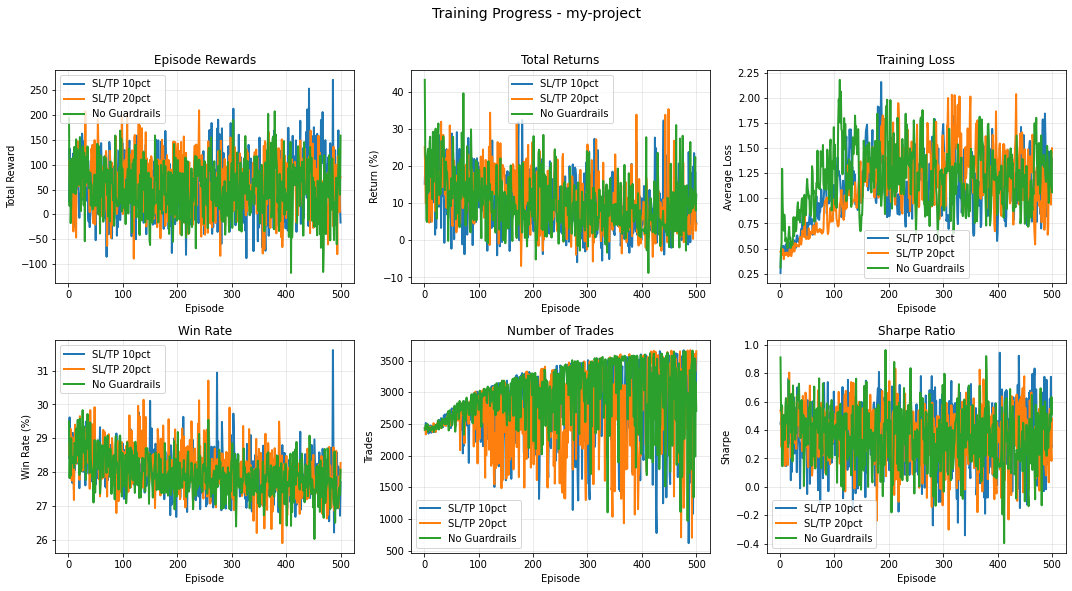

In [7]:
# Plot training progress for all strategies
if not TEST_MODE:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    for strategy_name, results in all_results.items():
        history = results['training_history']['training_history']
        if history:
            history_df = pd.DataFrame(history)

            # Episode rewards
            axes[0, 0].plot(history_df['episode'], history_df['reward'],
                          label=strategy_name, linewidth=2)
            axes[0, 0].set_title('Episode Rewards')
            axes[0, 0].set_xlabel('Episode')
            axes[0, 0].set_ylabel('Total Reward')
            axes[0, 0].grid(True, alpha=0.3)
            axes[0, 0].legend()

            # Total returns
            axes[0, 1].plot(history_df['episode'], history_df['return'] * 100,
                          label=strategy_name, linewidth=2)
            axes[0, 1].set_title('Total Returns')
            axes[0, 1].set_xlabel('Episode')
            axes[0, 1].set_ylabel('Return (%)')
            axes[0, 1].grid(True, alpha=0.3)
            axes[0, 1].legend()

            # Training Loss
            axes[0, 2].plot(history_df['episode'], history_df.get('avg_loss', 0),
                          label=strategy_name, linewidth=2)
            axes[0, 2].set_title('Training Loss')
            axes[0, 2].set_xlabel('Episode')
            axes[0, 2].set_ylabel('Average Loss')
            axes[0, 2].grid(True, alpha=0.3)
            axes[0, 2].legend()

            # Win rate
            axes[1, 0].plot(history_df['episode'], history_df['win_rate'] * 100,
                          label=strategy_name, linewidth=2)
            axes[1, 0].set_title('Win Rate')
            axes[1, 0].set_xlabel('Episode')
            axes[1, 0].set_ylabel('Win Rate (%)')
            axes[1, 0].grid(True, alpha=0.3)
            axes[1, 0].legend()

            # Number of trades
            axes[1, 1].plot(history_df['episode'], history_df['trades'],
                          label=strategy_name, linewidth=2)
            axes[1, 1].set_title('Number of Trades')
            axes[1, 1].set_xlabel('Episode')
            axes[1, 1].set_ylabel('Trades')
            axes[1, 1].grid(True, alpha=0.3)
            axes[1, 1].legend()

            # Sharpe Ratio
            axes[1, 2].plot(history_df['episode'], history_df['sharpe'],
                          label=strategy_name, linewidth=2)
            axes[1, 2].set_title('Sharpe Ratio')
            axes[1, 2].set_xlabel('Episode')
            axes[1, 2].set_ylabel('Sharpe')
            axes[1, 2].grid(True, alpha=0.3)
            axes[1, 2].legend()

    plt.suptitle(f'Training Progress - {PROJECT_FOLDER}', fontsize=14, y=1.02)
    plt.tight_layout()
    
    # Save the plot
    plot_path = f"{results_dir}/training_progress.png"
    plt.savefig(plot_path, dpi=100, bbox_inches='tight')
    print(f"✅ Training progress plot saved to: {plot_path}")
    
    plt.show()
else:
    print("📊 Skipping training plots (TEST_MODE enabled)")

## 6. Out-of-Sample Validation Comparison

Compare all strategies across all validation periods.

In [8]:
# Validate all strategies on all periods
print(f"\n{'='*70}")
print(f"📊 OUT-OF-SAMPLE VALIDATION COMPARISON")
print(f"{'='*70}")
print(f"Validation periods: {len(validation_periods)}\n")

validation_results = {}

for strategy_name, results in all_results.items():
    print(f"\nValidating: {strategy_name}")
    trainer = results['trainer']

    period_metrics = []

    for i, val_period in enumerate(validation_periods, 1):
        print(f"  Period {i}: {val_period.index.min().date()} to {val_period.index.max().date()}", end=" ")

        val_env = TradingEnvironment(
            val_period,
            feature_columns,
            results['config'],
            mode='test'
        )

        val_metrics = trainer.evaluate(val_env, verbose=False)
        period_metrics.append({
            'period': i,
            'return': val_metrics.get('total_return', 0),
            'sharpe': val_metrics.get('sharpe_ratio', 0),
            'max_drawdown': val_metrics.get('max_drawdown', 0),
            'win_rate': val_metrics.get('win_rate', 0),
            'trades': val_metrics.get('num_trades', 0)
        })

        print(f"→ Return: {val_metrics.get('total_return', 0):.2%}")

    validation_results[strategy_name] = period_metrics

print(f"\n✅ Validation complete for all strategies")


📊 OUT-OF-SAMPLE VALIDATION COMPARISON
Validation periods: 5


Validating: SL/TP 10pct
  Period 1: 2005-02-08 to 2005-12-30 → Return: 0.11%
  Period 2: 2008-01-02 to 2008-12-31 Guardrail Triggered at step 197: Take Profit triggered (14.52% gain)
Guardrail Triggered at step 208: Take Profit triggered (11.69% gain)
Guardrail Triggered at step 227: Take Profit triggered (12.70% gain)
→ Return: 0.64%
  Period 3: 2012-01-03 to 2012-12-31 → Return: -0.03%
  Period 4: 2013-01-02 to 2013-12-31 → Return: 0.04%
  Period 5: 2021-01-04 to 2021-12-31 → Return: 0.94%

Validating: SL/TP 20pct
  Period 1: 2005-02-08 to 2005-12-30 → Return: 0.11%
  Period 2: 2008-01-02 to 2008-12-31 → Return: -0.01%
  Period 3: 2012-01-03 to 2012-12-31 → Return: -0.03%
  Period 4: 2013-01-02 to 2013-12-31 → Return: 0.04%
  Period 5: 2021-01-04 to 2021-12-31 → Return: 0.94%

Validating: No Guardrails
  Period 1: 2005-02-08 to 2005-12-30 → Return: 0.11%
  Period 2: 2008-01-02 to 2008-12-31 → Return: -1.04%
  Period 3: 20

✅ Validation comparison plot saved to: results/my-project/run_20260118_215254/validation_comparison.png


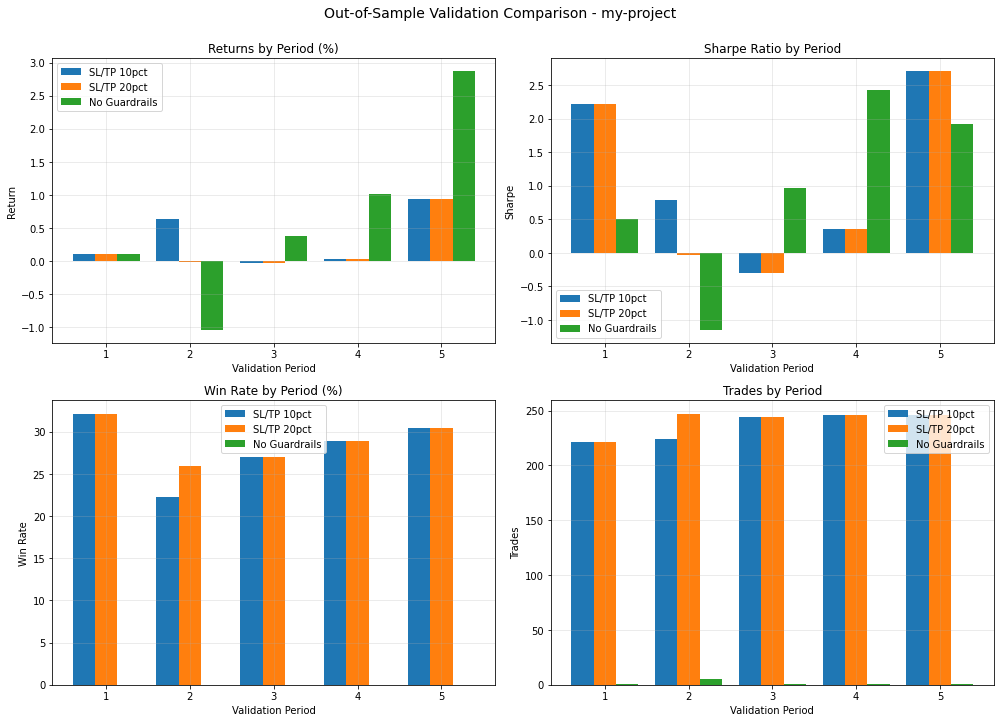

In [9]:
# Plot validation comparison
if len(validation_periods) > 0 and len(all_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    metrics_to_plot = [
        ('return', 'Returns by Period (%)', 0, 0, 100),
        ('sharpe', 'Sharpe Ratio by Period', 0, 1, 1),
        ('win_rate', 'Win Rate by Period (%)', 1, 0, 100),
        ('trades', 'Trades by Period', 1, 1, 1)
    ]

    for metric, title, row, col, multiplier in metrics_to_plot:
        ax = axes[row, col]

        x = np.arange(1, len(validation_periods) + 1)
        width = 0.8 / max(len(all_results), 1)

        for i, (strategy_name, period_metrics) in enumerate(validation_results.items()):
            values = [pm[metric] * multiplier for pm in period_metrics]
            offset = (i - len(all_results)/2 + 0.5) * width
            ax.bar(x + offset, values, width, label=strategy_name)

        ax.set_title(title)
        ax.set_xlabel('Validation Period')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.set_xticks(x)
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.suptitle(f'Out-of-Sample Validation Comparison - {PROJECT_FOLDER}', fontsize=14, y=1.00)
    plt.tight_layout()
    
    # Save the plot
    plot_path = f"{results_dir}/validation_comparison.png"
    plt.savefig(plot_path, dpi=100, bbox_inches='tight')
    print(f"✅ Validation comparison plot saved to: {plot_path}")
    
    plt.show()
else:
    print("📊 No validation periods to plot")

## 7. Test Set Comparison

Compare all strategies on the held-out test period.

In [10]:
# Test all strategies
print(f"\n{'='*70}")
print(f"🧪 FINAL TEST COMPARISON")
print(f"{'='*70}")
print(f"Test period: {test_data.index.min().date()} to {test_data.index.max().date()}")
print(f"Test samples: {len(test_data)}\n")

test_results = {}
metrics_calc = PerformanceMetrics()

for strategy_name, results in all_results.items():
    print(f"Testing: {strategy_name}")
    trainer = results['trainer']

    test_env = TradingEnvironment(
        test_data,
        feature_columns,
        results['config'],
        mode='test'
    )

    test_metrics = trainer.evaluate(test_env, verbose=False)
    comprehensive_metrics = metrics_calc.calculate_metrics(
        test_env.portfolio_values,
        test_env.trades,
        test_env.starting_balance
    )

    test_results[strategy_name] = {
        'metrics': comprehensive_metrics,
        'portfolio_values': test_env.portfolio_values.copy(),
        'trades': test_env.trades.copy()
    }

    print(f"  Return: {comprehensive_metrics['total_return']:.2%}")
    print(f"  Sharpe: {comprehensive_metrics['sharpe_ratio']:.2f}")
    print(f"  Win Rate: {comprehensive_metrics['win_rate']:.2%}\n")

print(f"✅ Test evaluation complete for all strategies")


🧪 FINAL TEST COMPARISON
Test period: 2024-12-30 to 2025-12-30
Test samples: 251

Testing: SL/TP 10pct
Guardrail Triggered at step 68: Take Profit triggered (10.50% gain)
  Return: 1.56%
  Sharpe: 0.73
  Win Rate: 57.50%

Testing: SL/TP 20pct
  Return: 1.44%
  Sharpe: 1.77
  Win Rate: 58.20%

Testing: No Guardrails
  Return: 3.16%
  Sharpe: 0.99
  Win Rate: 0.00%

✅ Test evaluation complete for all strategies


In [11]:
# Test comparison table
comparison_data = []
for strategy_name, result in test_results.items():
    m = result['metrics']
    comparison_data.append({
        'Strategy': strategy_name,
        'Return (%)': f"{m['total_return']*100:.2f}",
        'Sharpe': f"{m['sharpe_ratio']:.2f}",
        'Max DD (%)': f"{m['max_drawdown']*100:.2f}",
        'Win Rate (%)': f"{m['win_rate']*100:.2f}",
        'Trades': m['num_trades']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*70)
print("📊 TEST RESULTS SUMMARY")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)


📊 TEST RESULTS SUMMARY
     Strategy Return (%) Sharpe Max DD (%) Win Rate (%)  Trades
  SL/TP 10pct       1.56   0.73      -1.97        57.50     120
  SL/TP 20pct       1.44   1.77      -0.61        58.20     122
No Guardrails       3.16   0.99      -3.38         0.00       0


✅ Test portfolio comparison saved to: results/my-project/run_20260118_215254/test_portfolio_values.png


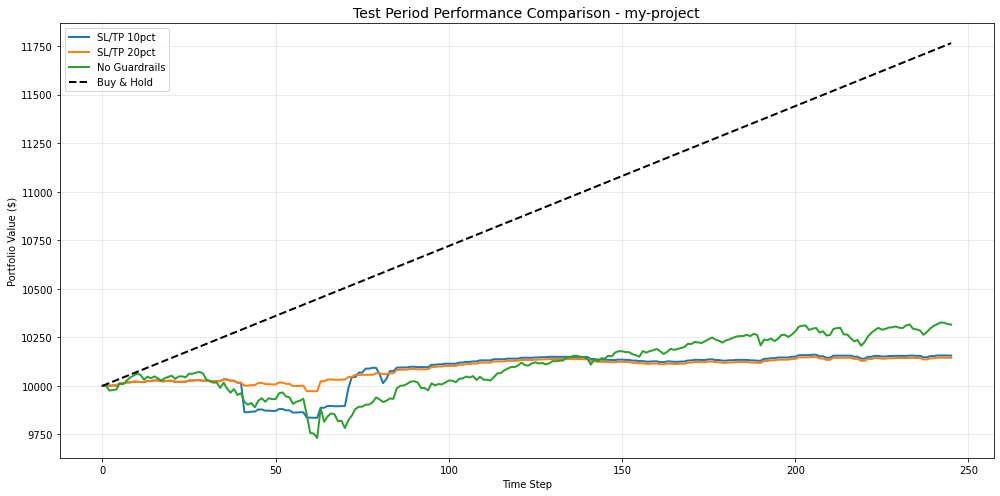

In [12]:
# Plot test comparison - Portfolio values over time
fig, ax = plt.subplots(figsize=(14, 7))

for strategy_name, result in test_results.items():
    ax.plot(result['portfolio_values'], label=strategy_name, linewidth=2)

# Add buy & hold
price_col = f"{ticker}_Close_orig"
window_size = data_config.config['data']['window_size']
initial_price = test_data.iloc[window_size][price_col]
final_price = test_data.iloc[-1][price_col]
buy_hold_return = (final_price - initial_price) / initial_price
starting_balance = list(all_results.values())[0]['config']['trading']['starting_balance']

buy_hold_values = [starting_balance * (1 + buy_hold_return * i / len(test_data))
                   for i in range(len(test_results[list(test_results.keys())[0]]['portfolio_values']))]
ax.plot(buy_hold_values, label='Buy & Hold', linewidth=2, linestyle='--', color='black')

ax.set_title(f'Test Period Performance Comparison - {PROJECT_FOLDER}', fontsize=14)
ax.set_xlabel('Time Step')
ax.set_ylabel('Portfolio Value ($)')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()

# Save the plot
plot_path = f"{results_dir}/test_portfolio_values.png"
plt.savefig(plot_path, dpi=100, bbox_inches='tight')
print(f"✅ Test portfolio comparison saved to: {plot_path}")

plt.show()

✅ Test metrics comparison saved to: results/my-project/run_20260118_215254/test_metrics_comparison.png


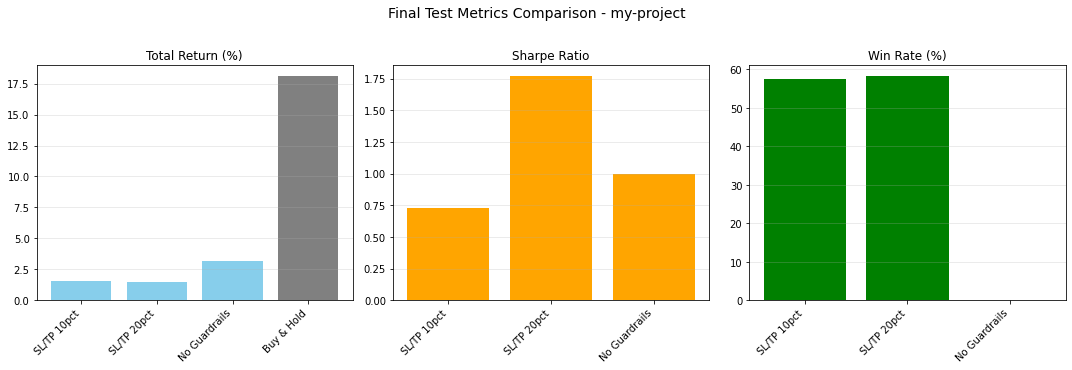

In [13]:
# Final comparison bar chart
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

strategies = list(test_results.keys())
returns = [test_results[s]['metrics']['total_return'] * 100 for s in strategies]
sharpes = [test_results[s]['metrics']['sharpe_ratio'] for s in strategies]
win_rates = [test_results[s]['metrics']['win_rate'] * 100 for s in strategies]

# Add buy & hold to comparison
strategies_with_bh = strategies + ['Buy & Hold']
returns_with_bh = returns + [buy_hold_return * 100]

x = np.arange(len(strategies))
x_with_bh = np.arange(len(strategies_with_bh))

axes[0].bar(x_with_bh, returns_with_bh, color=['skyblue']*len(strategies) + ['gray'])
axes[0].set_title('Total Return (%)')
axes[0].set_xticks(x_with_bh)
axes[0].set_xticklabels(strategies_with_bh, rotation=45, ha='right')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(x, sharpes, color='orange')
axes[1].set_title('Sharpe Ratio')
axes[1].set_xticks(x)
axes[1].set_xticklabels(strategies, rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')

axes[2].bar(x, win_rates, color='green')
axes[2].set_title('Win Rate (%)')
axes[2].set_xticks(x)
axes[2].set_xticklabels(strategies, rotation=45, ha='right')
axes[2].grid(True, alpha=0.3, axis='y')

plt.suptitle(f'Final Test Metrics Comparison - {PROJECT_FOLDER}', fontsize=14, y=1.02)
plt.tight_layout()

# Save the plot
plot_path = f"{results_dir}/test_metrics_comparison.png"
plt.savefig(plot_path, dpi=100, bbox_inches='tight')
print(f"✅ Test metrics comparison saved to: {plot_path}")

plt.show()

## 8. Save Final Results

In [14]:
# Save final results data (plots already saved above)
# Note: results_dir was created in cell 3

# Save CSV comparison
comparison_df.to_csv(f"{results_dir}/test_comparison.csv", index=False)

# Save comprehensive results
final_results = {
    'timestamp': datetime.now().isoformat(),
    'project': PROJECT_FOLDER,
    'test_mode': TEST_MODE,
    'run_name': run_name,
    'data_config': data_config.config,
    'strategies': {},
    'validation_results': validation_results,
    'test_results': {k: v['metrics'] for k, v in test_results.items()},
    'buy_hold_return': float(buy_hold_return)
}

for strategy_name, results in all_results.items():
    final_results['strategies'][strategy_name] = {
        'experiment_name': results['experiment_name'],
        'config': results['config'],
        'training_history': results['training_history']['training_history']
    }

# Save to JSON
results_path = f"{results_dir}/final_results.json"
with open(results_path, 'w') as f:
    json.dump(final_results, f, indent=2, default=str)

print(f"\n{'='*70}")
print(f"✅ COMPLETE PIPELINE FINISHED!")
print(f"{'='*70}")
print(f"📁 Project: {PROJECT_FOLDER}")
print(f"📝 Run name: {run_name}")
print(f"📊 Strategies trained: {len(trading_configs)}")
print(f"📈 Results saved to: {results_dir}/")
print(f"📄 Final results: {results_path}")

# List saved files
saved_files = os.listdir(results_dir)
saved_files.sort()
print(f"\n📁 Saved files:")
for file in saved_files:
    size_kb = os.path.getsize(f"{results_dir}/{file}") / 1024
    file_type = "📊 Plot" if file.endswith('.png') else "📄 Data" if file.endswith('.csv') else "📋 Results"
    print(f"   {file_type}: {file} ({size_kb:.1f} KB)")

# Count plots saved
plot_files = [f for f in saved_files if f.endswith('.png')]
print(f"\n📊 Plots saved: {len(plot_files)}")

# Show best strategy
if test_results:
    print(f"\n🏆 Best performing strategy:")
    best_strategy = max(test_results.items(), key=lambda x: x[1]['metrics']['total_return'])
    print(f"   {best_strategy[0]}")
    print(f"   • Return: {best_strategy[1]['metrics']['total_return']:.2%}")
    print(f"   • Sharpe: {best_strategy[1]['metrics']['sharpe_ratio']:.2f}")
    print(f"   • vs Buy & Hold: {(best_strategy[1]['metrics']['total_return'] - buy_hold_return):.2%}")

print(f"{'='*70}")

# Print final summary
logger.print_summary()


✅ COMPLETE PIPELINE FINISHED!
📁 Project: my-project
📝 Run name: my-project_SPY_20260118_215254
📊 Strategies trained: 3
📈 Results saved to: results/my-project/run_20260118_215254/
📄 Final results: results/my-project/run_20260118_215254/final_results.json

📁 Saved files:
   📋 Results: final_results.json (1392.9 KB)
   📄 Data: test_comparison.csv (0.2 KB)
   📊 Plot: test_metrics_comparison.png (32.4 KB)
   📊 Plot: test_portfolio_values.png (80.5 KB)
   📊 Plot: training_progress.png (319.2 KB)
   📊 Plot: validation_comparison.png (69.0 KB)

📊 Plots saved: 4

🏆 Best performing strategy:
   No Guardrails
   • Return: 3.16%
   • Sharpe: 0.99
   • vs Buy & Hold: -14.93%

RUN SUMMARY: my-project_SPY_20260118_215254

Stages Completed: 7
  • Data Collection: 1.2s
  • Feature Engineering: 0.1s
  • Data Normalization: 0.1s
  • Data Splitting: 0.2s
  • Training: SL/TP 10pct: 13649.7s
  • Training: SL/TP 20pct: 7637.6s
  • Training: No Guardrails: 7643.4s

Latest Training Metrics:
  • reward: 158.57